# Modification of Santa's 2019 Starter Notebook for Genetic Algorithm method

## Import

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import time 
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# to save 
import pickle
from sklearn.externals import joblib

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) 
# will list all files under the input directory

import os

## Definitions

In [360]:
# Paths to folders/files
#PATH_INPUT = '/kaggle/input' #for kaggle
PATH_INPUT = 'kaggle/input'
PATH_TO_SAVE_DATA = "../../data"
PATH_BASELINE_0 = PATH_TO_SAVE_DATA + '/df_fake_news.pkl'
PATH_SAVE_PROB_FAM = PATH_TO_SAVE_DATA + '/df_prob_fam.pkl'
PATH_SAVE_DF_POP = PATH_TO_SAVE_DATA + '/df_pop.pkl'
PATH_SAVE_DF_POP_10 = PATH_TO_SAVE_DATA + '/df_pop_10.pkl'
# Data information
DAY_RANGE = list(range(1, 101)) # day before Christmas
DAY_RANGE_MIN = np.min(DAY_RANGE) 
DAY_RANGE_MAX = np.max(DAY_RANGE) 

# Hyper-parameters:
NB_FIRST_POP = 1000 # number of first population of choices 
R_FIRST_MUT = 0.01 # RATIO of mutation for first population
R_POP_MUT = 0.05 # RATIO of population mutation after first generation
R_MUT = 0.01 # RATIO of number of family choices mutated
DELTA_DAYS = 1 # delta of days around previous best day for generation/mutation
R_POP_LOST = 0.01 # Ratio of lost individuals in population 
NB_MAX_EPOCHS = 1000
# method 2 : by choices
DELTA_CHOICE = 1
CHOICE_RANGE_MIN = 0
CHOICE_RANGE_MAX = 10

In [26]:
for dirname, _, filenames in os.walk(PATH_INPUT):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

kaggle/input/.DS_Store
kaggle/input/santa-2019-workshop-scheduling/family_data.csv
kaggle/input/santa-2019-workshop-scheduling/sample_submission.csv


## Useful functions

In [484]:
def find_choice_range(choice_curr):
    '''
    select range of choices 
    from random between +/- delta choice around choice_curr
    
    return a range
    '''
    choice_min = np.min([np.max([CHOICE_RANGE_MIN, choice_curr - DELTA_CHOICE]), 
                          CHOICE_RANGE_MAX - 2 * DELTA_CHOICE])
    choice_max = np.min([CHOICE_RANGE_MAX, 
                        np.max([CHOICE_RANGE_MIN + 2 * DELTA_CHOICE, 
                        choice_curr + DELTA_CHOICE])]) + 1
    range_choice = range(choice_min, choice_max)
    
    return range_choice

def find_choice_from_day(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    '''
    fam_days = data_choice.loc[fam_id]
    
    idx_choice_curr = fam_days[day_curr == fam_days].index
    
    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]

def choose_day_prob(choice_curr, fam_id):
    '''
    find or choose the day of given choice number according to family choices
    
    if choice 10, then find a day randomly
    
    return a day
    '''
  
    choice_curr = np.array(choice_curr)
    
    vect_days_choice = data_choice.loc[fam_id, np.minimum(9, choice_curr)]
    vect_days_choice = np.array(vect_days_choice)
    
    idx_choice_10 = np.nonzero(choice_curr == 10)[0]
    if idx_choice_10.shape[0] > 0:
        nb_10 = idx_choice_10.shape[0]
        vect_all_days = np.array(range(1, 101))
        vect_prob_10 = np.array(df_prob_fam.astype("float").loc[fam_id])/ \
            df_prob_fam.loc[fam_id].sum()
        #vect_prob_10 = np.ones(vect_all_days.shape[0])
        vect_prob_10[idx_choice_10] = 0
        vect_prob_10 = vect_prob_10 / np.sum(vect_prob_10)
        days_10 = np.random.choice(vect_all_days, size=nb_10,
                                  p=vect_prob_10)
        #print("idx_choice_10: ", idx_choice_10)
        for i_day, indice in enumerate(idx_choice_10):
            
            if vect_days_choice.shape:
                
                ''' print("days_10: ", days_10)
                print("vect_days_choice: ", np.array(vect_days_choice))
                print("vect_days_choice[indice]: ", 
                      np.array(vect_days_choice)[indice])
                print("i_day: ", i_day)
                print("days_10[i_day]: ", days_10[i_day])
                print("indice : ", indice)'''

                vect_days_choice[indice] = days_10[i_day]
            else:
                vect_days_choice = np.array(days_10[i_day])
            
        return vect_days_choice
    else:
        return vect_days_choice
    
def mutation_day(day_curr, fam_id, nb_mut=1, flag_prob=False):
    # function mutation of days : around choices
    # day_curr -> choice_curr -> range choices -> 
    # choose randomly 1 choice -> 1 day 
    # fam_id = 0
    # day_curr = 100
    # mutation_day(day_curr, fam_id, 10)
    choice_curr = find_choice_from_day(day_curr, fam_id)
    #print("choice_curr: ", choice_curr)
    range_choices = find_choice_range(choice_curr)
    #print("range_choices: ", np.array(range_choices))
    
    if flag_prob:
        vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        #np.array(df_prob.loc[data.loc[fam_id,"n_people"], 
        #                     ['choice_{}'.format(i) for i in range_choices]])
        vect_prob = vect_prob / vect_prob.sum()
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                                     p=vect_prob)
    else:
        choice_new = np.random.choice(range_choices, size=nb_mut)
        
    day_new = choose_day_prob(choice_new, fam_id)
    #print("choice_new: ", choice_new)
    return day_new

def find_day_range(day_curr):
    '''
    select range of days from random between +/- delta day around day_curr
    
    return a range
    '''
    day_min = np.min([np.max([DAY_RANGE_MIN, day_curr-DELTA_DAYS]), 
                      DAY_RANGE_MAX - 2 * DELTA_DAYS])
    day_max = np.min([DAY_RANGE_MAX, np.max([DAY_RANGE_MIN + 2 * DELTA_DAYS, 
                                             day_curr + DELTA_DAYS])]) + 1
    range_day = range(day_min, day_max)

    return range_day


def generate_pop(seed_indiv=None, nb_pop=None, r_mut=None):
    '''
    Generate first polulation from one seed individual
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return dataFrame population
    '''
    t_fit_0 = time.time()
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    if seed_indiv is None:
        seed_indiv = submission
    if nb_pop is None:
        nb_pop = NB_FIRST_POP
    if r_mut is None:
        r_mut = R_FIRST_MUT
    #print("seed_indiv: ", seed_indiv)
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    # initialize with same previous best indiv.
    df_pop = pd.DataFrame(index=range(0, nb_pop), 
                          columns=seed_indiv["family_id"])

    for fam_id in seed_indiv["family_id"]:
        df_pop[fam_id] = seed_indiv.at[fam_id,'assigned_day']

    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in data.index: # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        day_curr = seed_indiv.at[fam_id, 'assigned_day']
        # find range around day curr +/- DELTA
        range_curr = find_day_range(day_curr)
        # retrict probabilities to range. use df_prob_fam = f(fam_id, day)
        day_prob = df_prob_fam.astype("float").loc[fam_id, range_curr]/ \
            df_prob_fam.loc[fam_id, range_curr].sum()
        # choose randomly with probabilities days around old best day
        vect_pop_mutated = np.random.choice(np.array(range_curr), 
                                size=nb_pop, 
                                p=np.array(day_prob))

        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(range(0, nb_pop), 
                                     size=int(r_mut*nb_pop))

        df_pop.loc[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    df_pop.loc[0] = seed_indiv['assigned_day']
    
    print("Generation population is done.")
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    
    return df_pop

In [504]:
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    list_days.append(mutation_day(day_curr, fam_id, 1, True))
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

Timing :  2.389463186264038


In [507]:
nb_mut = 1
vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
t_fit_0 = time.time()
for I in range(0,1000):
    vect_prob = vect_prob / vect_prob.sum()
    #print("vect_prob: ", vect_prob)
    choice_new = np.random.choice(range_choices, size=nb_mut,
                                     p=vect_prob)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

Timing :  0.0770421028137207


In [514]:
choice_new

array([8])

In [513]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    choose_day_prob(choice_new, fam_id)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

Timing :  0.7321329116821289


In [515]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    find_choice_from_day(day_curr, fam_id)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

Timing :  0.6577200889587402


In [516]:
nb_mut = 1
t_fit_0 = time.time()
list_days=[]
for I in range(0,1000):
    find_choice_range(choice_curr)
len(list_days)
t_fit_1 = time.time()
print("Timing : ", t_fit_1 - t_fit_0)

Timing :  0.05540800094604492


In [517]:
def fun_test(range_choices, nb_mut):
    t_fit_0 = time.time()
    for I in range(0,1000):
        vect_prob = np.array(df_prob.loc[data.loc[fam_id,"n_people"], 
                     ['choice_{}'.format(i) for i in range_choices]])
        vect_prob = vect_prob / vect_prob.sum()
    t_fit_1 = time.time()
    print("Timing 1: ", t_fit_1 - t_fit_0)
    t_fit_0 = time.time()
    for I in range(0,1000):
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                             p=vect_prob)
    t_fit_1 = time.time()
    print("Timing 2: ", t_fit_1 - t_fit_0)
    print(vect_prob) 
t_fit_0 = time.time()
fun_test(range_choices, nb_mut)
t_fit_1 = time.time()
print("Timing Tot: ", t_fit_1 - t_fit_0)

Timing 1:  0.9553639888763428
Timing 2:  0.05506300926208496
[0.58935396 0.32748678 0.08315927]
Timing Tot:  1.0112509727478027


In [518]:
def fun_test(range_choices, nb_mut):
    t_fit_0 = time.time()
    for I in range(0,1000):
        vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        vect_prob = vect_prob / vect_prob.sum()
    t_fit_1 = time.time()
    print("Timing 1: ", t_fit_1 - t_fit_0)
    t_fit_0 = time.time()
    for I in range(0,1000):
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                             p=vect_prob)
    t_fit_1 = time.time()
    print("Timing 2: ", t_fit_1 - t_fit_0)
    print(vect_prob) 
t_fit_0 = time.time()
fun_test(range_choices, nb_mut)
t_fit_1 = time.time()
print("Timing Tot: ", t_fit_1 - t_fit_0)

Timing 1:  0.022983789443969727
Timing 2:  0.05568528175354004
[0.58935396 0.32748678 0.08315927]
Timing Tot:  0.0793609619140625


In [501]:
def fun_test(range_choices, nb_mut):
    t_fit_0 = time.time()
    for I in range(0,1000):
        vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        vect_prob = vect_prob / vect_prob.sum()
    t_fit_1 = time.time()
    print("Timing 1: ", t_fit_1 - t_fit_0)
    t_fit_0 = time.time()
    for I in range(0,1000):
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                             p=vect_prob)
        day_new = choose_day_prob(choice_new, fam_id)
    t_fit_1 = time.time()
    print("Timing 2: ", t_fit_1 - t_fit_0)
    
    vect_prob = vect_prob / vect_prob.sum()
    #print("vect_prob: ", vect_prob)

    
    print(vect_prob) 
t_fit_0 = time.time()
fun_test(range_choices, nb_mut)
t_fit_1 = time.time()
print("Timing Tot: ", t_fit_1 - t_fit_0)

Timing 1:  0.044342756271362305
Timing 2:  6.729721784591675
[0.58935396 0.32748678 0.08315927]
Timing Tot:  6.77520489692688


In [543]:

arr_choice = np.array(data_choice)

def find_choice_from_day_arr(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    '''
    #fam_days = arr_choice[fam_id,:]
    #idx_choice_curr = fam_days[day_curr == fam_days].index
    idx_choice_curr = np.nonzero(arr_choice[fam_id,:] == day_curr)[0]
    
    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]

find_choice_from_day_arr(52, 0)

0

In [542]:
find_choice_from_day(52, 0)

0

In [537]:
def test_fun():
    day_curr = 28
    print(arr_choice[0,:])
    print(arr_choice[0,:] == day_curr)
    idx_choice_curr = np.nonzero(arr_choice[0,:] == day_curr)[0]
    if idx_choice_curr.shape[0] == 0:
        print( 10 )
    else:
        print(idx_choice_curr[0])
test_fun()

[52 38 12 82 33 75 64 76 10 28]
[False False False False False False False False False  True]
9


In [529]:
day_curr

100

In [521]:
data_choice

0   1   2   3   4   5   6    7   8    9
family_id                                           
0           52  38  12  82  33  75  64   76  10   28
1           26   4  82   5  11  47  38    6  66   61
2          100  54  25  12  27  82  10   89  80   33
3            2  95   1  96  32   6  40   31   9   59
4           53   1  47  93  26   3  46   16  42   39
5           32  59  12   3  60  26  35   50   5    2
6           88   4   1   3  91  32  39   57  28   99
7           25  11  52  48  10  17  88   50  95   66
8           18  60   1  12  89  33  16   10  53   67
9            1  88  39  50  26  18  96   47  46   28
10          96  92   8   5  67  12  57   34  80   46
11          19  75  39  44   2  68  53   89   7   94
12          52  98  53   1  39  67  87   24  65   95
13          54  52  25  53   1  60  10   12  11   57
14          45  25  34  38  88  16   1    4  89   29
15          22   4  82  10   5  58  75    1  18   94
16          46  50   1  17  52  74   7   21  38   25
17          47  52  74   5   4  40  79   61  10   17
18          75  87  74  38  52  13  10    4  81   68
19           3  12   5   1   7  26  49   44  97  100
20           3  88  17  68  32  73  25    1  59   74
21          56   1  45  69  31   4  80   38  81   12
22          61  33   1  82  60  10  92   17  73   22
23          19  82  18  73  11  68   3   94  59   16
24          75  95  24   4  38  52   3    1  28    5
25          16  11  12  53   3  98  25   61  19   18
26          58  95   4  25  66  62  53   94  14    8
27          38  95   1  43  88  39   9    4  65   74
28          81  27  54  21  45  67  33    2   7   53
29          89   8   1  82  80  67  54   11  26   74
...        ...  ..  ..  ..  ..  ..  ..  ...  ..  ...
4970        22   1  16   6  47  11  79   88  60    3
4971        12   8  60   1   2  25  18   50  45   17
4972        66   8  75  32  39  52  58   87  45    1
4973        87   5   1  22  52   8  66   94   3   38
4974        15  45  80   5   1  12  82   31  33   38
4975        10  83   5  47  73  95  66   86  79   54
4976        39  45  60  68  17  52   3   20  80    1
4977        54  33  31  25  24   1  73  100  55   22
4978        40   5  11  10  39  73  51   63   7    1
4979        14  55  45  73  89  35   1    5   4   50
4980        52  28  72  38  12  71  41   53  32   51
4981        44  11  54  61  98  15  12   48  75   38
4982        47  41  96  45  40  33  91   80  17   83
4983        19  16  55  30  24  18  94    1  66   11
4984        41   4  18   5  67  43  40   34  66   75
4985        25  59  96   6  36  52  51   10  54   60
4986        82  54  81  49  40  60  26    1   4   19
4987        22  87  40  89  74  73  32   18  24    4
4988        88  73  89  11  75  94  84   82   3   40
4989        59  92  31  14  38  75  60   49  78   12
4990        47  61  74  12  80  46  32   94   4   19
4991        45  47  29   1  83   5  49   14  91   75
4992        12  75  31  90  22  26  76   32   1   52
4993        62   1  89  66  28  60  81   40  88   13
4994        52  59   1  54  80  87  16   47  13   15
4995        16   1  66  33  18  70  56   46  86   60
4996        88  66  20  17  26  54  81   91  59   48
4997        32  66  54  17  27  21  74   81   3    7
4998        67  92   4  17  53  77   1   12  26   70
4999        13  11  25  80  88  40  96   39  18   47

[5000 rows x 10 columns]

In [520]:
arr_choice = np.array(data_choice)
arr_choice

array([[ 52,  38,  12, ...,  76,  10,  28],
       [ 26,   4,  82, ...,   6,  66,  61],
       [100,  54,  25, ...,  89,  80,  33],
       ...,
       [ 32,  66,  54, ...,  81,   3,   7],
       [ 67,  92,   4, ...,  12,  26,  70],
       [ 13,  11,  25, ...,  39,  18,  47]])

In [502]:
nb_mut

9

In [478]:
vect_prob

[0.1, 0.03]

In [473]:
np.array(range_choices)

array([ 8,  9, 10])

In [474]:
df_prob

choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  choice_6  \
2  0.100491  0.099238  0.098787  0.097535  0.095030  0.094580  0.092075   
3  0.102556  0.101278  0.100588  0.099310  0.096753  0.096063  0.093507   
4  0.104708  0.103403  0.102463  0.101158  0.098549  0.097609  0.094999   
5  0.106952  0.105619  0.104419  0.103087  0.100421  0.099221  0.096556   
6  0.109294  0.107932  0.106461  0.105099  0.102375  0.100904  0.098180   
7  0.111742  0.110349  0.108594  0.107202  0.104417  0.102662  0.099877   
8  0.114301  0.112877  0.110825  0.109401  0.106552  0.104501  0.101652   

   choice_7  choice_8  choice_9  choice_10  
2  0.091173  0.088669  0.076195   0.066227  
3  0.092127  0.089571  0.071754   0.056494  
4  0.093120  0.090511  0.067127   0.046353  
5  0.094156  0.091491  0.062301   0.035777  
6  0.095238  0.092514  0.057264   0.024738  
7  0.096368  0.093583  0.052001   0.013205  
8  0.097550  0.094701  0.046497   0.001143

In [461]:
arr_prob = np.array(df_prob)
arr_prob[0,0]

0.10049061278022005

In [468]:
family_size_dict[0]

4

In [476]:
arr_prob[family_size_dict[0]-2,range_choices]

array([0.09051051, 0.06712683, 0.04635294])

In [458]:
data.head()

choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  \
family_id                                                               
0                52        38        12        82        33        75   
1                26         4        82         5        11        47   
2               100        54        25        12        27        82   
3                 2        95         1        96        32         6   
4                53         1        47        93        26         3   

           choice_6  choice_7  choice_8  choice_9  n_people  
family_id                                                    
0                64        76        10        28         4  
1                38         6        66        61         4  
2                10        89        80        33         3  
3                40        31         9        59         2  
4                46        16        42        39         4

## Read in the family information and sample submission

In [99]:
fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

data_choice = data.iloc[:,range(0,10)]
data_choice.columns = range(0,10)
# patch for optimization
arr_choice = np.array(data_choice)
data_choice.head()


0   1   2   3   4   5   6   7   8   9
family_id                                         
0           52  38  12  82  33  75  64  76  10  28
1           26   4  82   5  11  47  38   6  66  61
2          100  54  25  12  27  82  10  89  80  33
3            2  95   1  96  32   6  40  31   9  59
4           53   1  47  93  26   3  46  16  42  39

In [29]:
data.head()

choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  \
family_id                                                               
0                52        38        12        82        33        75   
1                26         4        82         5        11        47   
2               100        54        25        12        27        82   
3                 2        95         1        96        32         6   
4                53         1        47        93        26         3   

           choice_6  choice_7  choice_8  choice_9  n_people  
family_id                                                    
0                64        76        10        28         4  
1                38         6        66        61         4  
2                10        89        80        33         3  
3                40        31         9        59         2  
4                46        16        42        39         4

In [30]:
submission.head()

assigned_day
family_id              
0                   100
1                    99
2                    98
3                    97
4                    96

## Create some lookup dictionaries and define constants

You don't need to do it this way. :-)

In [31]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

## Cost Function
Very un-optimized  ;-)

In [32]:
def cost_function(prediction, flag_prompt=False):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n
    if flag_prompt:
        print("penalty for only families: ", penalty)
    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000
    if flag_prompt:
        print("daily_occupancy: ", daily_occupancy)
    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count
    if flag_prompt:
        print("accounting_cost: ", accounting_cost)
    penalty += accounting_cost

    return penalty

## Simple Opimization Approach : baseline #0

For each family, loop over their choices, and if keep it if the score improves. There's a lot of easy improvement that can be made to this code.

In [33]:
t_fit_0 = time.time()
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_cost = cost_function(best)
print("Start cost: ", start_cost)
new = best.copy()
cost_best = start_cost
# loop over each family
for fam_id, _ in enumerate(best):
    # loop over each family choice
    for pick in range(10):
        day = choice_dict[f'choice_{pick}'][fam_id]
        temp = new.copy()
        temp[fam_id] = day # add in the new pick
        cost_curr = cost_function(temp) # test cost
        if cost_curr < cost_best:
            new = temp.copy()
            cost_best = cost_curr
            #print("Current best cost: ", cost_best)

submission['assigned_day'] = new
score = cost_function(new)
submission.to_csv(f'submission_{score}.csv')
print(f'Score: {score}')

t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)



Start cost:  10641498.403135022


KeyboardInterrupt: 

In [172]:
np.array(range(10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# save for later use
joblib.dump(submission, PATH_BASELINE_0)


## Explore day occupancy

In [350]:
# show how people choose days : 
# 5 first choices 
# 5 last choices
#data
df_day = pd.DataFrame(index=range(1,101))
df_day["all_choices"] = 0
df_day["first_choices"] = 0
df_day["mid_choices"] = 0
df_day["last_choices"] = 0
list_choice_all = ['choice_{}'.format(n) for n in range(0, 10)]
list_choice_first = ['choice_{}'.format(n) for n in range(0, 3)]
list_choice_mid = ['choice_{}'.format(n) for n in range(3, 7)]
list_choice_last = ['choice_{}'.format(n) for n in range(7, 10)]

# for each first choices, add to each days the number of people
for choice in list_choice_all:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "all_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_first:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "first_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_mid:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "mid_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_last:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "last_choices"] += data.at[indice, "n_people"]
        
df_day.head()

all_choices  first_choices  mid_choices  last_choices
1        11568           4391         4449          2728
2         1806            501          729           576
3         3607           1021         1526          1060
4         3872           1148         1585          1139
5         3907           1181         1544          1182

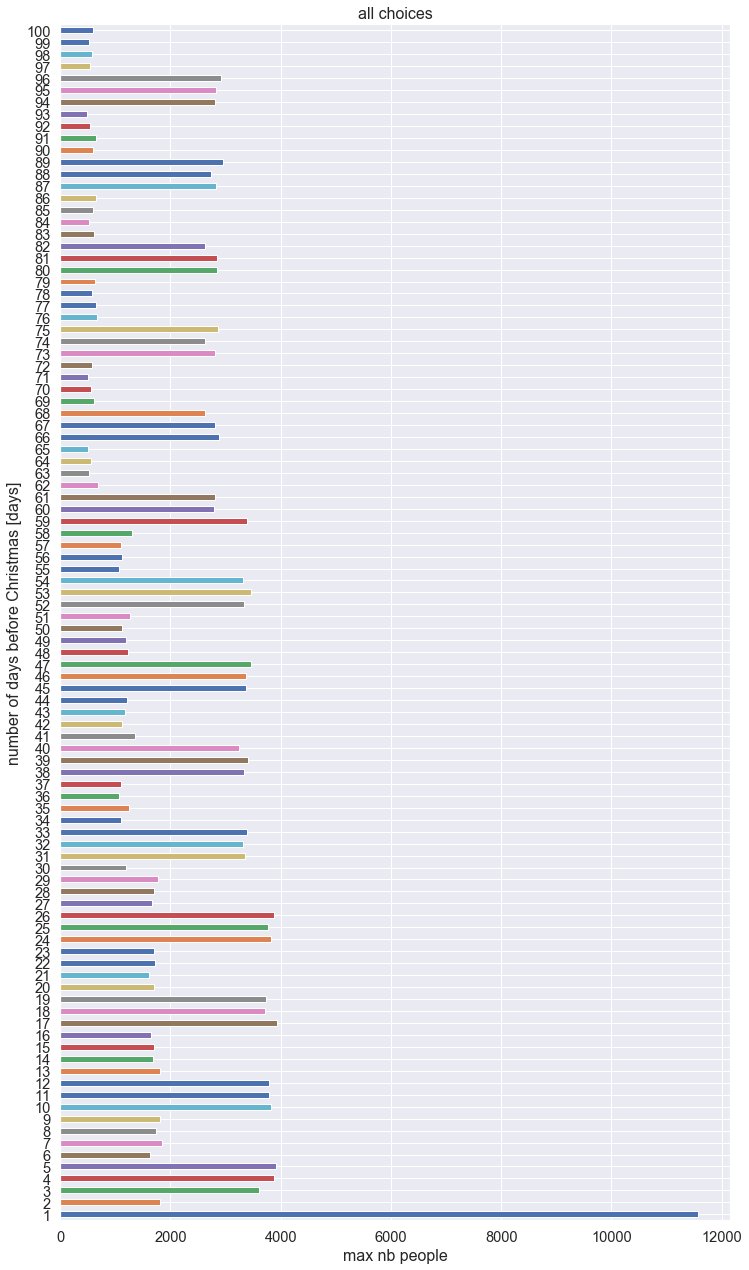

In [351]:
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_day["all_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("all choices");

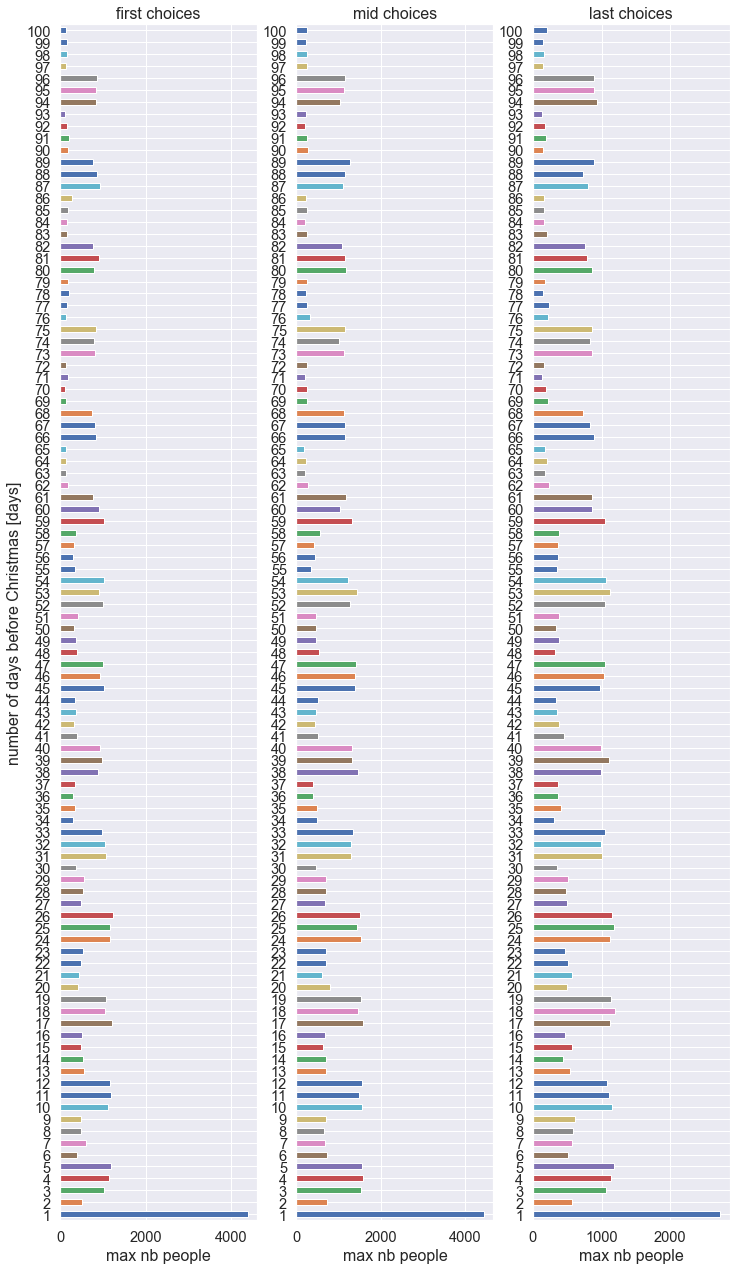

In [352]:
fig = plt.figure(figsize=(12, 22)) 
#plt.title("potential people vs choices")

ax1 = fig.add_subplot(1,3,1)
df_day["first_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("first choices")

ax2 = fig.add_subplot(1,3,2)
df_day["mid_choices"].plot.barh(ax=ax2)
ax2.set_xlabel("max nb people")
ax2.set_title("mid choices")

ax3 = fig.add_subplot(1,3,3)
df_day["last_choices"].plot.barh(ax=ax3)
ax3.set_xlabel("max nb people")
ax3.set_title("last choices");

### Creation of probality matrix

In [353]:
'''df_prob = df_fam_cost.filter(items=list_choice)
vect_penalty = [0, np.max(np.max(df_prob))]
print("vect_penalty: ", vect_penalty)
vect_prob = [0.1, 0.03]
print("vect_prob", vect_prob)
# family : number of people
df_prob = df_prob.applymap(lambda x: np.interp(x, vect_penalty, vect_prob))
for indice in df_prob.index:
    df_prob.loc[indice] = df_prob.loc[indice]/df_prob.loc[indice].sum()

df_prob'''

df_prob_day = pd.DataFrame(df_day["all_choices"])
df_prob_day["prob"] = 1/df_prob_day["all_choices"]
df_prob_day["prob"] = df_prob_day["prob"] / df_prob_day["prob"].sum()
df_prob_day["prob"].sum()

1.0

In [354]:
df_prob_day.head()

all_choices      prob
1        11568  0.001098
2         1806  0.007036
3         3607  0.003523
4         3872  0.003282
5         3907  0.003252

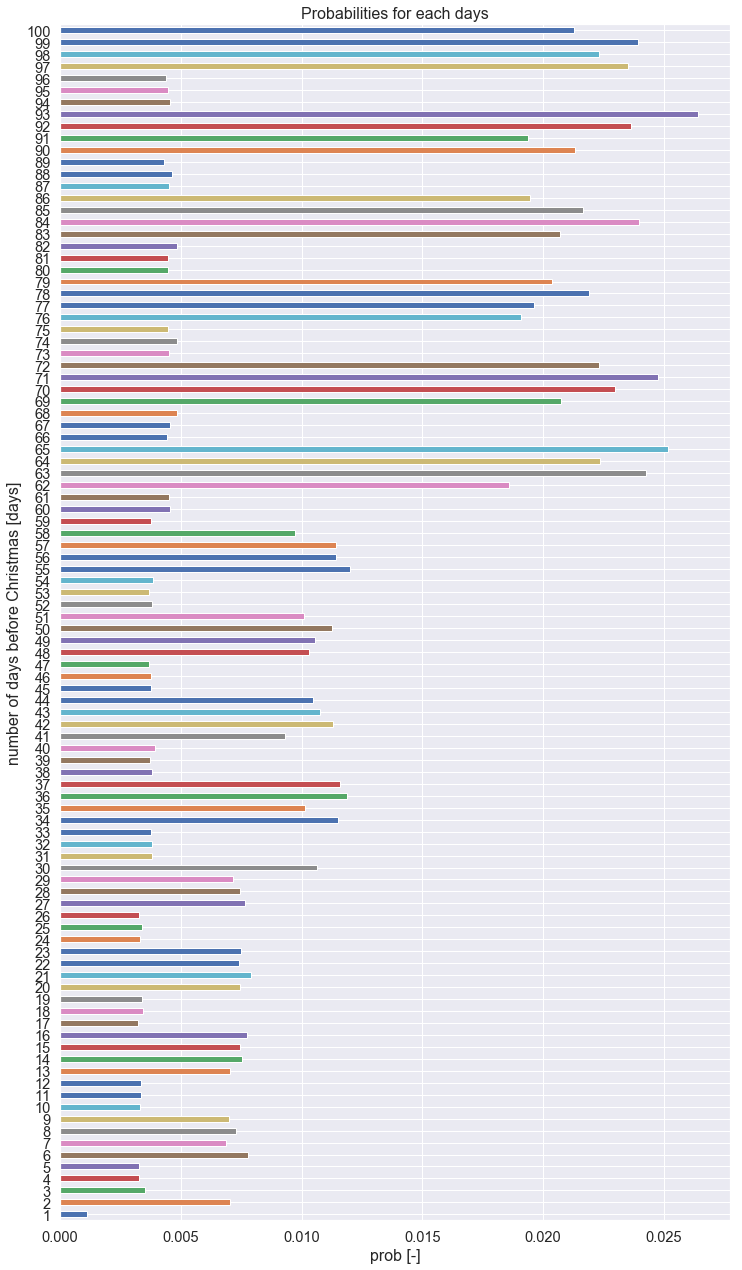

In [355]:
#df_prob_day["prob"].plot.barh()
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_prob_day["prob"].plot.barh(ax=ax1)
ax1.set_xlabel("prob [-]")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("Probabilities for each days");

## Explore family choice cost

In [41]:
def cost_family(n=1, choice=0):
    # Calculate the penalty for not getting top preference
    penalty = 0
    if choice == 0:
        penalty += 0
    elif choice == 1:
        penalty += 50
    elif choice == 2:
        penalty += 50 + 9 * n
    elif choice == 3:
        penalty += 100 + 9 * n
    elif choice == 4:
        penalty += 200 + 9 * n
    elif choice == 5:
        penalty += 200 + 18 * n
    elif choice == 6:
        penalty += 300 + 18 * n
    elif choice == 7:
        penalty += 300 + 36 * n
    elif choice == 8:
        penalty += 400 + 36 * n
    elif choice == 9:
        penalty += 500 + 36 * n + 199 * n
    else:
        penalty += 500 + 36 * n + 398 * n
        
    return penalty

In [42]:
cost_family(choice=1, n=2)

50

### Evolution of cost by number of people into family

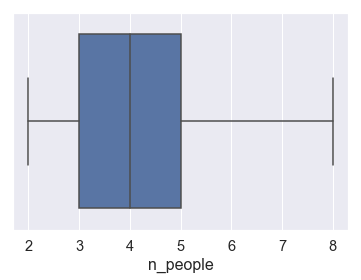

In [43]:
ax = sns.boxplot(x=data["n_people"])


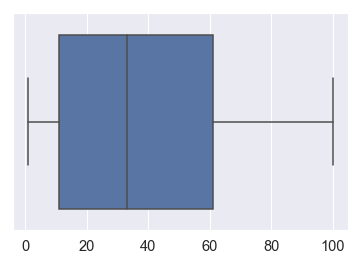

In [44]:
ax = sns.boxplot(data)

In [45]:
df_fam_cost = pd.DataFrame(index = np.array(range(np.min(data["n_people"]),
                            np.max(data["n_people"]) + 1)),
            columns=['choice_{}'.format(n_choice) for n_choice in range(0, 11)])
df_fam_cost["n"] = df_fam_cost.index
df_fam_cost

choice_0 choice_1 choice_2 choice_3 choice_4 choice_5 choice_6 choice_7  \
2      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
5      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
7      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
8      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

  choice_8 choice_9 choice_10  n  
2      NaN      NaN       NaN  2  
3      NaN      NaN       NaN  3  
4      NaN      NaN       NaN  4  
5      NaN      NaN       NaN  5  
6      NaN      NaN       NaN  6  
7      NaN      NaN       NaN  7  
8      NaN      NaN       NaN  8

In [46]:
df_fam_cost["choice_0"] = df_fam_cost["n"].apply(cost_family, args=(0,))
df_fam_cost["choice_1"] = df_fam_cost["n"].apply(cost_family, args=(1,))
df_fam_cost["choice_2"] = df_fam_cost["n"].apply(cost_family, args=(2,))
df_fam_cost["choice_3"] = df_fam_cost["n"].apply(cost_family, args=(3,))
df_fam_cost["choice_4"] = df_fam_cost["n"].apply(cost_family, args=(4,))
df_fam_cost["choice_5"] = df_fam_cost["n"].apply(cost_family, args=(5,))
df_fam_cost["choice_6"] = df_fam_cost["n"].apply(cost_family, args=(6,))
df_fam_cost["choice_7"] = df_fam_cost["n"].apply(cost_family, args=(7,))
df_fam_cost["choice_8"] = df_fam_cost["n"].apply(cost_family, args=(8,))
df_fam_cost["choice_9"] = df_fam_cost["n"].apply(cost_family, args=(9,))
df_fam_cost["choice_10"] = df_fam_cost["n"].apply(cost_family, args=(10,))
df_fam_cost

choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  choice_6  \
2         0        50        68       118       218       236       336   
3         0        50        77       127       227       254       354   
4         0        50        86       136       236       272       372   
5         0        50        95       145       245       290       390   
6         0        50       104       154       254       308       408   
7         0        50       113       163       263       326       426   
8         0        50       122       172       272       344       444   

   choice_7  choice_8  choice_9  choice_10  n  
2       372       472       970       1368  2  
3       408       508      1205       1802  3  
4       444       544      1440       2236  4  
5       480       580      1675       2670  5  
6       516       616      1910       3104  6  
7       552       652      2145       3538  7  
8       588       688      2380       3972  8

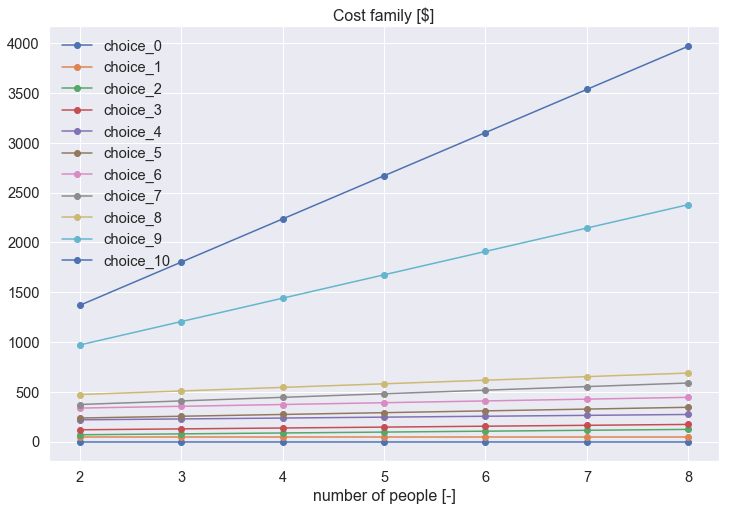

In [47]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost family [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for choice in list_choice:
    plt.plot(df_fam_cost["n"], df_fam_cost[choice], '-o', label=choice)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("number of people [-]");

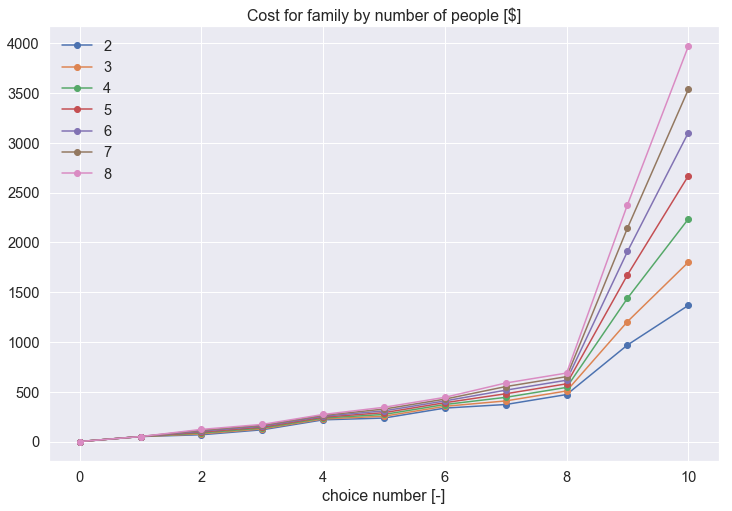

In [48]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost for family by number of people [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for n in df_fam_cost["n"]:
    plt.plot(range(0, df_fam_cost.filter(items=list_choice).shape[1]), 
        np.array(df_fam_cost.filter(items=list_choice).filter(items=[n], 
                                                              axis=0))[0],
             '-o', label=n)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("choice number [-]");

### Creation of probability matrix

In [346]:
def create_df_fam_cost_prob(df_fam_cost, p_min=0.03, p_max=0.1, ):
    # For genetic algo, for start population or mutation,
    # try to assign probabilities of choice for each possibilities : 
    # from  choice 0 to 10.
    df_prob = df_fam_cost.filter(items=list_choice)
    vect_penalty = [0, np.max(np.max(df_prob))]
    print("vect_penalty: ", vect_penalty)
    vect_prob = [p_max, p_min]
    print("vect_prob", vect_prob)
    # family : number of people
    df_prob = df_prob.applymap(lambda x: np.interp(x, vect_penalty, vect_prob))
    for indice in df_prob.index:
        df_prob.loc[indice] = df_prob.loc[indice]/df_prob.loc[indice].sum()

    return df_prob  


#### p max = 0.1, p min = 0.03

In [336]:
df_prob = create_df_fam_cost_prob(df_fam_cost)
df_prob

vect_penalty:  [0, 3972]
vect_prob [0.1, 0.03]


choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  choice_6  \
2  0.097481  0.096622  0.096313  0.095454  0.093736  0.093427  0.091709   
3  0.098846  0.097975  0.097505  0.096634  0.094892  0.094422  0.092680   
4  0.100250  0.099367  0.098731  0.097848  0.096081  0.095445  0.093678   
5  0.101695  0.100799  0.099992  0.099096  0.097304  0.096498  0.094705   
6  0.103182  0.102272  0.101291  0.100381  0.098563  0.097581  0.095763   
7  0.104713  0.103790  0.102627  0.101705  0.099859  0.098697  0.096851   
8  0.106290  0.105353  0.104004  0.103068  0.101195  0.099846  0.097973   

   choice_7  choice_8  choice_9  choice_10  
2  0.091090  0.089372  0.080817   0.073980  
3  0.091739  0.089997  0.077855   0.067455  
4  0.092406  0.090639  0.074809   0.060746  
5  0.093092  0.091300  0.071675   0.053843  
6  0.093799  0.091980  0.068450   0.046738  
7  0.094526  0.092681  0.065129   0.039423  
8  0.095275  0.093402  0.061708   0.031887

#### p max = 0.5, p min = 0.01

In [347]:
df_prob_2 = create_df_fam_cost_prob(df_fam_cost, p_min=0.01, p_max=1)
df_prob_2

vect_penalty:  [0, 3972]
vect_prob [1, 0.01]


choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  choice_6  \
2  0.100491  0.099238  0.098787  0.097535  0.095030  0.094580  0.092075   
3  0.102556  0.101278  0.100588  0.099310  0.096753  0.096063  0.093507   
4  0.104708  0.103403  0.102463  0.101158  0.098549  0.097609  0.094999   
5  0.106952  0.105619  0.104419  0.103087  0.100421  0.099221  0.096556   
6  0.109294  0.107932  0.106461  0.105099  0.102375  0.100904  0.098180   
7  0.111742  0.110349  0.108594  0.107202  0.104417  0.102662  0.099877   
8  0.114301  0.112877  0.110825  0.109401  0.106552  0.104501  0.101652   

   choice_7  choice_8  choice_9  choice_10  
2  0.091173  0.088669  0.076195   0.066227  
3  0.092127  0.089571  0.071754   0.056494  
4  0.093120  0.090511  0.067127   0.046353  
5  0.094156  0.091491  0.062301   0.035777  
6  0.095238  0.092514  0.057264   0.024738  
7  0.096368  0.093583  0.052001   0.013205  
8  0.097550  0.094701  0.046497   0.001143

In [364]:

# save
joblib.dump(df_prob_2, PATH_TO_SAVE_DATA + '/df_prob_2.pkl')

['../../data/df_prob_2.pkl']

## Creation of days probabilities by family

In [348]:
def create_df_prob_day_fam(df_prob_day, df_prob):
    df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)
    for fam_id in df_prob_fam.index:
        # give at first to each families the same day probabilities
        df_prob_fam.loc[fam_id] = df_prob_day["prob"]
        # and add prob for each day choosen by families
        for choice in list_choice_all: 
            prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]
            day_curr = data.at[fam_id, choice]
            # add this prob of these days to family into df_prob_fam
            df_prob_fam.loc[fam_id, day_curr] += prob_curr
            #print(day_curr)
            #print(prob_curr)
        df_prob_fam.loc[fam_id] = \
            df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()
    return df_prob_fam

In [359]:
df_prob_fam = create_df_prob_day_fam(df_prob_day, df_prob_2)
# save
joblib.dump(df_prob_fam, PATH_TO_SAVE_DATA + '/df_prob_fam_2.pkl')

['../../data/df_prob_fam_2.pkl']

In [358]:

'''df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)
for fam_id in df_prob_fam.index:
    # give at first to each families the same day probabilities
    df_prob_fam.loc[fam_id] = df_prob_day["prob"]
    # and add prob for each day choosen by families
    for choice in list_choice_all: 
        prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]
        day_curr = data.at[fam_id, choice]
        # add this prob of these days to family into df_prob_fam
        df_prob_fam.loc[fam_id, day_curr] += prob_curr
        #print(day_curr)
        #print(prob_curr)
    df_prob_fam.loc[fam_id] = \
        df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()
    
     
    
df_prob_fam'''

'df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)\nfor fam_id in df_prob_fam.index:\n    # give at first to each families the same day probabilities\n    df_prob_fam.loc[fam_id] = df_prob_day["prob"]\n    # and add prob for each day choosen by families\n    for choice in list_choice_all: \n        prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]\n        day_curr = data.at[fam_id, choice]\n        # add this prob of these days to family into df_prob_fam\n        df_prob_fam.loc[fam_id, day_curr] += prob_curr\n        #print(day_curr)\n        #print(prob_curr)\n    df_prob_fam.loc[fam_id] =         df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()\n    \n     \n    \ndf_prob_fam'

In [413]:
# save
joblib.dump(df_prob_fam, PATH_SAVE_PROB_FAM)

['../../data//df_prob_fam.pkl']

In [322]:
df_prob_fam.loc[0].plot()

NameError: name 'df_prob_fam' is not defined

## From Scratch

### Generate first population

In [381]:

np.random.choice(np.array(range(0, df_prob.shape[1])), size=1, 
                 p=df_prob.loc[2].values)

array([6])

In [165]:
data.loc[indice,"n_people"]

4

In [265]:
# df_choice : contains number choices of all the population of 5000 families
df_choice = pd.DataFrame()

# for each family, create n choice among their first choice
for indice in data.index:
    vect_pop = np.random.choice(np.array(range(0, df_prob.shape[1])), 
                            size=NB_FIRST_POP, 
                            p=df_prob.loc[data.loc[indice,"n_people"]].values)
    df_choice[indice] = vect_pop
df_choice.shape

(1000, 5000)

In [266]:
df_choice.head()

0     1     2     3     4     5     6     7     8     9     ...   4990  \
0     3     3     5     8     3     9     4     1     2     6  ...      0   
1     7     3     0     6     0     9     9     4     8     7  ...      2   
2     1     4     1    10     4     1     5     7     5     5  ...      0   
3     4     9     6     0     6     6     2     5     5     1  ...      7   
4     8     7     7     5     3     4     5     2     8     3  ...      5   

   4991  4992  4993  4994  4995  4996  4997  4998  4999  
0     4     7     2     0     9     1     1     8     6  
1     3     3     3     5     1     1     9     2     3  
2     4     6     6     7     0     8     4     8     5  
3     7     8     4     2     6    10     2     2     4  
4     8     8     0     6     7     1     1     8    10  

[5 rows x 5000 columns]

### Treatment of choices

In [301]:
# for choice number 10, choose a day among all days except choices 0 to 9 : 
# probability is choosen uniform

def choose_day(choice_curr, fam_id):
    if choice_curr == 10:
        vect_choices = list(range(1, 101))
        for indice in range(0, 10):
            vect_choices.remove(data.loc[fam_id, "choice_{}".format(indice)])    
        #print(vect_choices)
        return np.random.choice(vect_choices, size=1)[0]
    else:
        return data.at[fam_id, "choice_{}".format(choice_curr)]


In [268]:
df_pop = df_choice.copy()
for fam_id in df_pop.columns:
    df_pop[fam_id] = df_pop[fam_id].apply(choose_day, args=(fam_id,))
    
df_pop

0     1     2     3     4     5     6     7     8     9     ...   4990  \
0      82     5    82     9    93     2    91    11     1    96  ...     47   
1      76     5   100    40    53     2    99    10    53    47  ...     74   
2      38    11    54    54    26    59    32    50    33    18  ...     47   
3      33    61    10     2    46    35     1    17    33    88  ...     94   
4      10     6    89     6    93    60    32    52    53    50  ...     46   
5      52     5    27    96    39    26    57    88     1    39  ...      5   
6      38    40    27    59     1    32    99    11     1    28  ...     61   
7      33    97    25    93     3    59    88    17    33    96  ...     74   
8      75    11    80     6    46    78     4    88    18    39  ...      4   
9      52    11    25    32    93    12    57    48    12    18  ...     32   
10     82    11    10     2     1    50    99    66    89    39  ...     80   
11     12     4    27    95    84    60    99    17     1    88  ...     12   
12     38    49    80    31    26     2    91    17    10    18  ...     19   
13     82    55    33    95     1    12    91    66    16    18  ...     46   
14     12     4    89     9    53    60    91    17    12    28  ...      4   
15     38    26    82     9    90    32     1    10    39     1  ...     19   
16     12    82    82    40    47     2     3    66    60    28  ...     19   
17     12    26   100    31     3    60     4    25     1    46  ...      4   
18     10    66    10    59    53    60    99    50    33     1  ...     74   
19     28    66     9    59    26     2    39    10    10    26  ...     80   
20     64    66    54     9    39    26    28    10    10    46  ...     80   
21     76    38    80    31    46     5    88    11    89    18  ...     74   
22     82    66    33    40    93     2     3    17    16    39  ...     61   
23     33     4    29     2    90    32    57    32    10    28  ...     47   
24     12    47    10     9     3    12     3    88    18    26  ...     33   
25     76    29    25     9    53    59     3    10    33    88  ...     32   
26     52    61    33     6    47    26    91    88    60    47  ...     12   
27     64     4    33    40     1    26    26    50    67    39  ...     12   
28     76    47    82    31    53     2    39    11     1    19  ...     32   
29     76     4    80     2    39    60     1    50    16    88  ...     94   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...    ...   
970    12    38    10    32     1    32     1    88    33    18  ...     80   
971    10    11    66    95    93    50    32    25    18    39  ...     12   
972    12    38    82     2    39    59    99    11    33    28  ...     47   
973    12    47    33    31    39    26    99    66    12    39  ...     80   
974    39    26    27     2     3     3    28    20    60    26  ...      4   
975    10     6    25    96     1    18    39    95    33    18  ...     32   
976    28    47    80    25    16    35     4    25    89    96  ...     19   
977    75    11    25    31    26    50    39    10    12    39  ...     74   
978    10    82    82    40    26     3     3    52    33    73  ...     32   
979    28     5    25    59    39     5     4    66    60    46  ...     47   
980    12    66   100    32    46    60     1    11    12    47  ...     80   
981    28    26    27    31    93    35     3    10    18    26  ...     47   
982    33    61   100     4    93    26    88    88    33    88  ...     80   
983    33     6    27     6     3    35    39    95    53    28  ...     47   
984    10    61    54    31    16    12    28    25    33    39  ...     19   
985    75    66   100    44    26     5    57    50    18    28  ...     47   
986    10     4    10     2     3    32     4    50    12    96  ...     46   
987    52     6    33    59    39    60    39    10     1    88  ...     32   
988    38    82    12    59    93    35    28    11    

### Evaluation of cost for all population

In [262]:
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

cost
0    4.405331e+62
1    8.627548e+56
2    1.346244e+59
3    5.624646e+61
4    7.746507e+61
5    2.343082e+51
6    4.598295e+66
7    7.982710e+56
8    1.347359e+57
9    1.105799e+60
10   3.893130e+59
11   3.936574e+58
12   1.621637e+63
13   8.510317e+52
14   5.895593e+59
15   3.340682e+55
16   1.358198e+57
17   1.079468e+64
18   5.832608e+60
19   4.579328e+60
20   7.319800e+50
21   5.446452e+56
22   2.165810e+54
23   9.561077e+62
24   8.721047e+45
25   2.068069e+60
26   2.355648e+53
27   1.844667e+70
28   7.279254e+61
29   2.525690e+60
..            ...
970  2.353798e+53
971  1.748307e+63
972  6.841872e+70
973  1.497576e+52
974  4.638929e+67
975  1.978431e+53
976  1.781199e+60
977  1.518226e+59
978  1.235310e+60
979  4.351479e+56
980  1.345891e+54
981  2.343632e+57
982  2.683243e+62
983  6.366676e+52
984  3.907275e+53
985  5.390364e+70
986  1.374826e+58
987  1.280499e+55
988  8.832879e+63
989  8.525397e+64
990  5.807663e+56
991  1.103143e+55
992  7.475599e+53
993  9.080145e+57
994  7.006668e+57
995  4.932254e+65
996  5.323330e+49
997  2.865219e+55
998  3.724813e+63
999  1.000177e+55

[1000 rows x 1 columns]

In [269]:
best = submission['assigned_day'].tolist()
len(best)

5000

In [335]:
cost_function(best)

penalty for only families:  666488
daily_occupancy:  {100: 127, 99: 127, 98: 128, 97: 127, 96: 168, 95: 201, 94: 212, 93: 126, 92: 135, 91: 126, 90: 143, 89: 189, 88: 226, 87: 219, 86: 126, 85: 125, 84: 127, 83: 131, 82: 161, 81: 185, 80: 203, 79: 126, 78: 139, 77: 126, 76: 126, 75: 170, 74: 196, 73: 206, 72: 126, 71: 126, 70: 128, 69: 127, 68: 169, 67: 210, 66: 238, 65: 125, 64: 129, 63: 126, 62: 139, 61: 179, 60: 208, 59: 235, 58: 207, 57: 154, 56: 154, 55: 179, 54: 214, 53: 228, 52: 244, 51: 202, 50: 151, 49: 195, 48: 214, 47: 249, 46: 269, 45: 257, 44: 220, 43: 186, 42: 205, 41: 232, 40: 241, 39: 265, 38: 231, 37: 194, 36: 160, 35: 183, 34: 215, 33: 251, 32: 277, 31: 269, 30: 242, 29: 254, 28: 272, 27: 284, 26: 293, 25: 295, 24: 280, 23: 265, 22: 254, 21: 256, 20: 264, 19: 288, 18: 294, 17: 283, 16: 273, 15: 267, 14: 270, 13: 284, 12: 298, 11: 291, 10: 280, 9: 260, 8: 261, 7: 259, 6: 281, 5: 296, 4: 291, 3: 291, 2: 271, 1: 294}
accounting_cost:  5766.027668334263


672254.0276683343

## From baseline #0

In [173]:
# reload 
submission = pd.read_csv('submission_672254.0276683343.csv')

In [558]:
# reload
df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)

### Generate first population

Generation of 1000 "families choices" ensemble from baseline : 
- Number of individuals for first generation : NB_FIRST_POP
- Ratio of generation/mutation for first generation : R_FIRST_MUT
- delta around day choosen  : +/- DELTA_DAYS

Try to find fine tune these hyperparameters (I don't have method ! )

In [384]:
#submission = pd.read_csv('submission_672254.0276683343.csv')

In [174]:
# check baseline
cost_function(submission['assigned_day'])

672254.0276683343

In [81]:


find_day_range(50)

range(49, 52)

In [17]:
fam_id = 0
submission.at[fam_id, 'assigned_day']

52

In [ ]:
df_pop = generate_pop()
print("df_pop.shape: ", df_pop.shape)
df_pop.head()

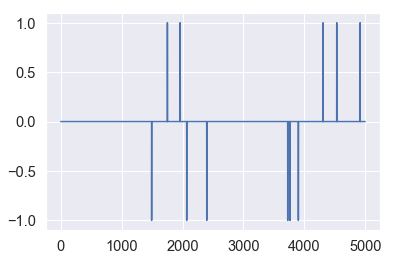

In [571]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

A effacer : 

In [83]:
# GENERATION OF FIRST POP:

# initialize with same previous best indiv.
df_pop = pd.DataFrame(index=range(0, NB_FIRST_POP), 
                      columns=submission["family_id"])

for fam_id in submission["family_id"]:
    df_pop[fam_id] = submission.at[fam_id,'assigned_day']

# create NB_FIRST_POP family choices from baseline :
# use probabilies
# df_pop : contains number choices of all the population of 5000 families
# df_pop = f(indiv., family)
# for each family, create n choice among their first choice
# use day probabilities specific for each family
for fam_id in data.index: # data = f(family, num choice)
    # day current is the old best submission day for this family
    day_curr = submission.at[fam_id, 'assigned_day']
    # find range around day curr +/- DELTA
    range_curr = find_day_range(day_curr)
    # retrict probabilities to range # df_prob_fam = f(fam_id, day)
    day_prob = df_prob_fam.astype("float").loc[fam_id,range_curr]/df_prob_fam.\
        loc[fam_id,range_curr].sum()
    # choose randomly with probabilities days around old best day
    vect_pop = np.random.choice(np.array(range_curr), 
                            size=NB_FIRST_POP, 
                            p=np.array(day_prob))
    
    # apply the new days only a part of pop : R_FIRST_MUT [-]
    range_mut = np.random.choice(range(0, NB_FIRST_POP), 
                                 size=int(R_FIRST_MUT*NB_FIRST_POP))
    
    #df_pop[fam_id] = submission['assigned_day']
    
    df_pop.loc[range_mut, fam_id] = vect_pop[range_mut]

# keep the best : 
df_pop.loc[0] = submission['assigned_day']

print("df_pop.shape: ", df_pop.shape)
df_pop.head()

df_pop.shape:  (1000, 5000)


family_id  0     1     2     3     4     5     6     7     8     9     ...   \
0            52    26   100     2    53    59    88    25    18     1  ...    
1            52    26   100     2    53    59    88    25    18     1  ...    
2            52    26   100     2    53    59    88    25    18     1  ...    
3            52    26   100     2    53    59    88    25    18     1  ...    
4            52    26   100     2    53    59    88    25    18     1  ...    

family_id  4990  4991  4992  4993  4994  4995  4996  4997  4998  4999  
0            61    29    90    62    52    16    88    32    67    13  
1            61    29    90    62    52    16    88    32    67    13  
2            61    29    90    62    52    16    88    32    67    13  
3            61    29    90    62    52    16    88    32    67    13  
4            61    29    90    62    52    16    88    32    67    13  

[5 rows x 5000 columns]

### Save pop

In [84]:
# save
joblib.dump(df_pop, PATH_SAVE_DF_POP)

['../../data//df_pop.pkl']

### Evaluation #1

In [570]:
# load 
df_pop = joblib.load(PATH_SAVE_DF_POP)

In [544]:
# create cost dataFrame for all population
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

cost
0    672254.027668
21   673249.435665
632  675341.022931
587  675579.598524
904  675800.361230
552  676043.157413
148  676060.161931
215  676639.495767
599  676960.819718
550  677205.766828

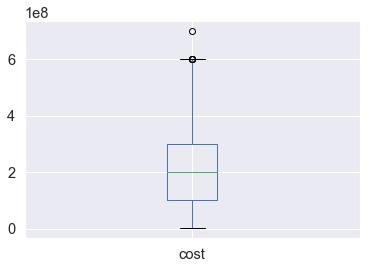

In [545]:
df_cost.boxplot()

### Loop over generations

In [546]:
# load 
#df_pop = joblib.load(PATH_SAVE_DF_POP)
#df_pop.shape

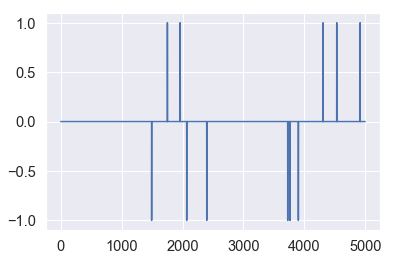

In [547]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

 
GENERATION #0 / nb. pop: 1000
nb_survivor:  990
              cost
990  672254.027668
991  673249.435665
21   675086.477112
238  675663.626834
743  675797.897188
Timing epoch:  13.22744607925415
 
GENERATION #1 / nb. pop: 992
nb_survivor:  982
              cost
982  672254.027668
983  673249.435665
302  675468.568847
303  675777.101886
561  676477.414141
Timing epoch:  13.66027307510376
 
GENERATION #2 / nb. pop: 984
nb_survivor:  974
              cost
0    672254.027668
974  672254.027668
975  673249.435665
805  674974.609299
845  675310.694047
Timing epoch:  12.444685935974121


Text(0, 0.5, 'cost [$]')

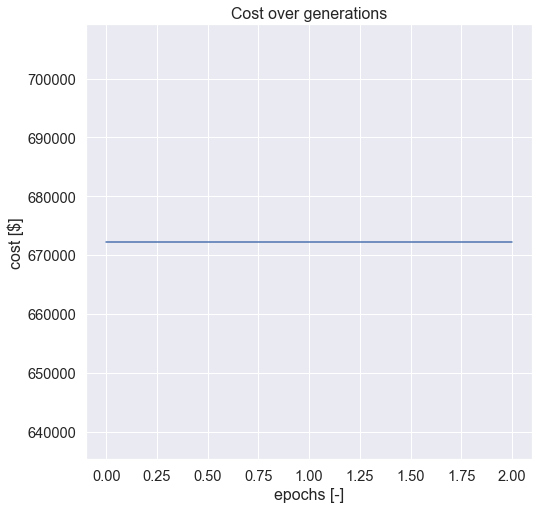

In [548]:
nb_seeds = 2 # number of seed sources : keep them along epochs
# LOOP OVER GENERATIONS 
list_best_cost = []
for gen_id in range(0, NB_MAX_EPOCHS):
    t_fit_0 = time.time()
    print(" ")
    print("GENERATION #{} / nb. pop: {}".format(gen_id, df_pop.shape[0]))
    
    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    #list_best_indiv = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
        #list_best_indiv.append(df_pop.loc[list_name_best[indice]])
    df_best = df_pop.loc[list_name_best]
    # LOST WORST INDIV.

    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - nb_seeds)
    if (nb_survivor+nb_seeds) % 2 != 0:
        nb_survivor += 1
    print("nb_survivor: ", nb_survivor + nb_seeds)
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))
    
    # check if previous best is still here
    #if name_best not in vect_survivor:
        # else replace by previous best
        #vect_survivor[0] = name_best

    df_pop = df_pop.loc[vect_survivor] 
    #df_pop_surv=df_pop.copy()

    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 

    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace first indiv
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)
    #df_pop_cross=df_pop.copy()

    # MUTATION
    # mutation of R_MUT * number of indiv 
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))

    # add the best 
    df_pop = df_pop.append(df_best, ignore_index=True)

    # EVALUATION
    # create cost dataFrame for all population
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 

    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

    print(df_cost.sort_values(by="cost").head(nb_seeds+3))
    
    t_fit_1 = time.time()
    print("Timing epoch: ", t_fit_1 - t_fit_0)
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

cost rankings:
[672254.0276683343, 673249.4356646903, 674728.7104080453, 675890.9699308008, 675979.8116211004]


In [518]:
list_name_best

[983, 314]

In [519]:
df_pop.loc[list_name_best]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


family_id  0     1      2     3     4     5     6     7     8     9     ...   \
983         NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
314        52.0  26.0  100.0   2.0  53.0  59.0  88.0  25.0  18.0   1.0  ...    

family_id  4990  4991  4992  4993  4994  4995  4996  4997  4998  4999  
983         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
314        61.0  29.0  90.0  62.0  52.0  16.0  88.0  32.0  67.0  13.0  

[2 rows x 5000 columns]

In [510]:

np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), vect_survivor))

array([990, 803, 867, 174, 379, 990, 193, 507, 142, 785, 631, 533, 422,
       203, 580, 977, 387,  20, 393, 612, 803, 505, 811, 359,  46, 461,
       944, 169, 775, 897, 467, 648, 976, 376, 518, 114, 741, 108, 181,
       768, 745, 330, 750, 705,  25, 163, 406, 736, 924,   5, 761,  40,
       430, 723, 876,  52, 879, 102, 820, 899, 516, 374, 337, 249, 302,
       559, 950, 759, 217, 920, 546, 550, 482,  35,  66, 277, 686, 492,
       601, 248, 267, 195, 522, 791,   1, 228, 534, 287, 969, 242, 814,
       988, 746, 835, 531, 166, 312, 110, 839,  50, 951,  80, 925, 341,
       189, 140, 433, 513, 933, 152, 680, 959, 927,  94, 921, 500, 470,
       582,  18, 887, 480, 639, 429,  79, 399, 397, 269,  51, 216, 424,
       415, 188, 731, 451, 810, 818, 272, 136, 663, 562, 457, 443,  15,
       673, 545, 871, 548, 788, 782, 172, 633, 848,  92, 535, 958, 437,
       726, 836, 564, 787, 598, 986, 698,  83,  95, 843, 261, 150, 450,
         7, 180, 348, 754, 692, 834, 520, 645, 144, 230, 640, 22

In [492]:
df_cost_sort.shape

(991, 3)

In [499]:
df_cost_sort.iloc[0:2,2] = 0

In [500]:
df_cost_sort

cost  rank      prob
990  6.722540e+05     1  0.000000
803  6.740412e+05     2  0.000000
723  6.743262e+05     3  0.044585
976  6.752261e+05     4  0.033438
5    6.753410e+05     5  0.026751
871  6.757341e+05     6  0.022292
25   6.760432e+05     7  0.019108
768  6.766036e+05     8  0.016719
169  6.766395e+05     9  0.014862
46   6.769514e+05    10  0.013375
461  6.770891e+05    11  0.012159
20   6.776100e+05    12  0.011146
920  6.779448e+05    13  0.010289
397  6.782558e+05    14  0.009554
761  6.782579e+05    15  0.008917
470  6.782830e+05    16  0.008360
376  6.783910e+05    17  0.007868
522  6.783969e+05    18  0.007431
580  6.786026e+05    19  0.007040
114  6.787559e+05    20  0.006688
40   6.792164e+05    21  0.006369
925  6.794635e+05    22  0.006080
242  6.795082e+05    23  0.005815
759  6.797625e+05    24  0.005573
141  6.800638e+05    25  0.005350
516  6.801533e+05    26  0.005144
142  6.804211e+05    27  0.004954
550  6.806977e+05    28  0.004777
387  6.807988e+05    29  0.004612
986  6.809628e+05    30  0.004458
..            ...   ...       ...
914  5.007527e+08   962  0.000139
256  5.007535e+08   963  0.000139
949  5.007557e+08   964  0.000139
781  5.007564e+08   965  0.000139
207  5.007603e+08   966  0.000138
629  5.007668e+08   967  0.000138
335  5.007700e+08   968  0.000138
24   5.007761e+08   969  0.000138
816  6.006767e+08   970  0.000138
953  6.006855e+08   971  0.000138
904  6.006864e+08   972  0.000138
638  6.006886e+08   973  0.000137
143  6.006930e+08   974  0.000137
872  6.006934e+08   975  0.000137
933  6.006985e+08   976  0.000137
873  6.006998e+08   977  0.000137
830  6.007444e+08   978  0.000137
84   6.007514e+08   979  0.000137
547  6.007529e+08   980  0.000136
259  6.007560e+08   981  0.000136
586  6.007606e+08   982  0.000136
911  6.007691e+08   983  0.000136
235  6.008261e+08   984  0.000136
795  7.006870e+08   985  0.000136
491  7.007442e+08   986  0.000136
678  7.007611e+08   987  0.000136
201  7.007786e+08   988  0.000135
910  8.007432e+08   989  0.000135
942  8.007518e+08   990  0.000135
436  1.000755e+09   991  0.000135

[991 rows x 3 columns]

In [480]:
df_cost_sort.shape

(991, 3)

In [477]:
list_best_indiv[1]

family_id
0        52
1        26
2       100
3         2
4        53
5        59
6        88
7        25
8        18
9         1
10       92
11       19
12       52
13       54
14       45
15       22
16       46
17       47
18       75
19        3
20        3
21       56
22       33
23       19
24       75
25       16
26       58
27       38
28       27
29       89
       ... 
4970     22
4971      8
4972      8
4973      5
4974     15
4975     83
4976     39
4977     54
4978     40
4979     55
4980     28
4981     44
4982     47
4983     16
4984     41
4985     25
4986     82
4987     22
4988     88
4989     92
4990     61
4991     29
4992     90
4993     62
4994     52
4995     16
4996     88
4997     32
4998     67
4999     13
Name: 803, Length: 5000, dtype: int64

In [451]:
df_cost_sort.head()

cost  rank      prob
198  6.696340e+05     1  0.170270
77   3.010847e+08     2  0.085135
19   4.009763e+08     3  0.056757
64   4.012742e+08     4  0.042567
52   5.007436e+08     5  0.034054

In [296]:
cost_function(df_pop.loc[0].tolist())

672254.0276683343

In [308]:
cost_function(best_indiv)

669634.0092723282

In [304]:
vect_best_choice=[]
for fam_id in df_pop.columns:
    vect_best_choice.append(choose_day(0,fam_id))

In [307]:
len(vect_best_choice)

5000

In [309]:
cost_function(vect_best_choice)

1.0647073818721987e+90

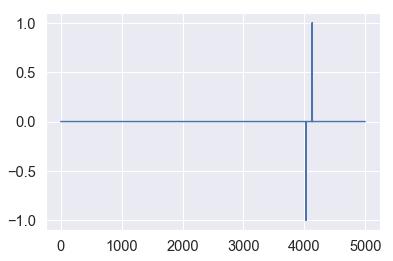

In [298]:
plt.plot(df_pop.columns, df_pop.loc[0] - best_indiv)
   

283


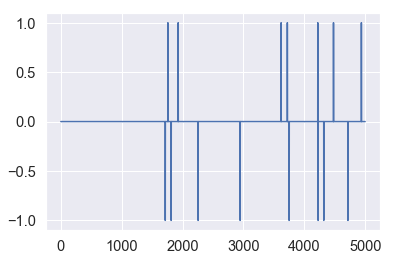

In [229]:
print(indice_mut[0])
plt.plot(df_pop.columns, df_pop_surv.loc[indice_mut[0]]\
         -df_pop_cross.loc[indice_mut[0]])
   

283


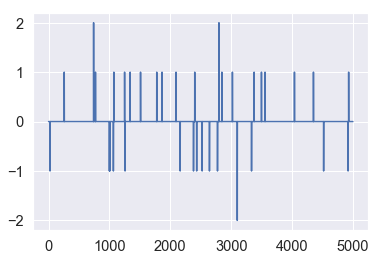

In [230]:
print(indice_mut[0])
plt.plot(df_pop.columns, df_pop.loc[indice_mut[0]]\
         -df_pop_cross.loc[indice_mut[0]])

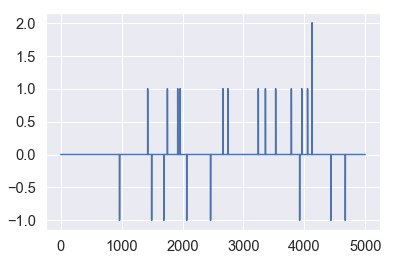

In [217]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

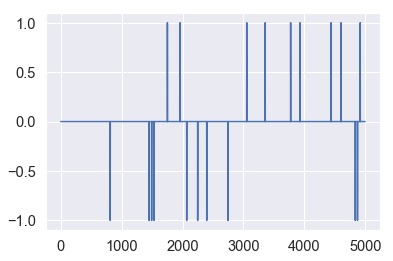

In [191]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

## From multiple baselines

### Find several baseline / seed source

#### Create ranges

In [52]:
submission = pd.read_csv(fpath, index_col='family_id')

In [53]:
submission.shape[0]

5000

In [54]:
NB_FIRST_SEED = 10
df_range = pd.DataFrame(index=range(0, NB_FIRST_SEED), 
                        columns=range(0, submission.shape[0]))

df_range.loc[0] = np.array(range(0, submission.shape[0]))

df_range.loc[1] = np.array(range(submission.index.max(), 
                                 submission.index.min()-1, -1))  

#for indice in range(2, NB_FIRST_SEED):
    

In [55]:
start_pt = np.linspace(0, submission.shape[0], 
                       num=int((NB_FIRST_SEED)/2)+1, dtype="int")
start_pt = start_pt[1:-1]
start_pt

array([1000, 2000, 3000, 4000])

In [56]:
np.array(range(10,0,-1))

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [57]:
indice = 2
for st_id, _ in enumerate(start_pt):
    df_range.loc[indice+st_id] = np.concatenate((np.array(range(start_pt[st_id], 
                                                submission.shape[0])), 
               np.array(range(0, start_pt[st_id]))))

indice = 6
for st_id, _ in enumerate(start_pt):
    df_range.loc[indice+st_id] = \
        np.concatenate((range(start_pt[st_id], 0-1, -1), 
                range(submission.shape[0]-1, start_pt[st_id], -1)))

df_range    

0     1     2     3     4     5     6     7     8     9     ...   4990  \
0     0     1     2     3     4     5     6     7     8     9  ...   4990   
1  4999  4998  4997  4996  4995  4994  4993  4992  4991  4990  ...      9   
2  1000  1001  1002  1003  1004  1005  1006  1007  1008  1009  ...    990   
3  2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  ...   1990   
4  3000  3001  3002  3003  3004  3005  3006  3007  3008  3009  ...   2990   
5  4000  4001  4002  4003  4004  4005  4006  4007  4008  4009  ...   3990   
6  1000   999   998   997   996   995   994   993   992   991  ...   1010   
7  2000  1999  1998  1997  1996  1995  1994  1993  1992  1991  ...   2010   
8  3000  2999  2998  2997  2996  2995  2994  2993  2992  2991  ...   3010   
9  4000  3999  3998  3997  3996  3995  3994  3993  3992  3991  ...   4010   

   4991  4992  4993  4994  4995  4996  4997  4998  4999  
0  4991  4992  4993  4994  4995  4996  4997  4998  4999  
1     8     7     6     5     4     3     2     1     0  
2   991   992   993   994   995   996   997   998   999  
3  1991  1992  1993  1994  1995  1996  1997  1998  1999  
4  2991  2992  2993  2994  2995  2996  2997  2998  2999  
5  3991  3992  3993  3994  3995  3996  3997  3998  3999  
6  1009  1008  1007  1006  1005  1004  1003  1002  1001  
7  2009  2008  2007  2006  2005  2004  2003  2002  2001  
8  3009  3008  3007  3006  3005  3004  3003  3002  3001  
9  4009  4008  4007  4006  4005  4004  4003  4002  4001  

[10 rows x 5000 columns]

In [24]:
df_range.min().min()

0

In [25]:
df_range.max().max()

4999

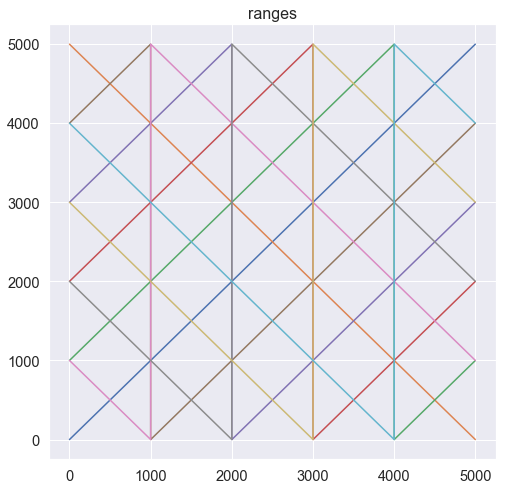

In [26]:
fig = plt.figure(figsize=(8, 8))
plt.title("ranges")
for indice in range(0, df_range.shape[0]):
    plt.plot(df_range.loc[indice])


#### Evaluate baselines & save

In [449]:
t_fit_0 = time.time()
submission = pd.read_csv(fpath, index_col='family_id')
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_cost = cost_function(best)
print("Start cost: ", start_cost)

for indice in df_range.index:
    # initiate first inviduate 
    new = best.copy()
    cost_best = start_cost
    # choose current range in df_range
    range_optim = df_range.loc[indice]
    # loop over each family with this current range
    for fam_id in range_optim:
        # loop over each family choice
        for pick in range(10):
            day = choice_dict[f'choice_{pick}'][fam_id]
            temp = new.copy()
            temp[fam_id] = day # add in the new pick
            cost_curr = cost_function(temp) # test cost
            if cost_curr < cost_best:
                new = temp.copy()
                cost_best = cost_curr
                #print("Current best cost: ", cost_best)

    submission['assigned_day'] = new
    score = cost_function(new)
    submission.to_csv(f'submission_range{indice}.csv')
    print(f'Score: {score}')

t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)



Start cost:  10641498.403135022
Score: 657505.9426095837
Score: 677348.7683962411
Score: 605419.8337085167
Score: 656228.7546566363
Timing:  1473.9507336616516


### Generate first population

#### Method 1:  Day by days

In [27]:
df_range

0     1     2     3     4     5     6     7     8     9     ...   4990  \
0     0     1     2     3     4     5     6     7     8     9  ...   4990   
1  4999  4998  4997  4996  4995  4994  4993  4992  4991  4990  ...      9   
2  1000  1001  1002  1003  1004  1005  1006  1007  1008  1009  ...    990   
3  2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  ...   1990   
4  3000  3001  3002  3003  3004  3005  3006  3007  3008  3009  ...   2990   
5  4000  4001  4002  4003  4004  4005  4006  4007  4008  4009  ...   3990   
6  1000   999   998   997   996   995   994   993   992   991  ...   1010   
7  2000  1999  1998  1997  1996  1995  1994  1993  1992  1991  ...   2010   
8  3000  2999  2998  2997  2996  2995  2994  2993  2992  2991  ...   3010   
9  4000  3999  3998  3997  3996  3995  3994  3993  3992  3991  ...   4010   

   4991  4992  4993  4994  4995  4996  4997  4998  4999  
0  4991  4992  4993  4994  4995  4996  4997  4998  4999  
1     8     7     6     5     4     3     2     1     0  
2   991   992   993   994   995   996   997   998   999  
3  1991  1992  1993  1994  1995  1996  1997  1998  1999  
4  2991  2992  2993  2994  2995  2996  2997  2998  2999  
5  3991  3992  3993  3994  3995  3996  3997  3998  3999  
6  1009  1008  1007  1006  1005  1004  1003  1002  1001  
7  2009  2008  2007  2006  2005  2004  2003  2002  2001  
8  3009  3008  3007  3006  3005  3004  3003  3002  3001  
9  4009  4008  4007  4006  4005  4004  4003  4002  4001  

[10 rows x 5000 columns]

In [88]:
# HYPERPARAMETERS
DELTA_DAYS = 3
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000

df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)
nb_indiv_done = 0
nb_range = df_range.index.shape[0]
for i_seed in df_range.index:
    # choose number of indiv.
    nb_indiv_curr = np.floor(NB_FIRST_POP/df_range.shape[0])
    nb_indiv_done += nb_indiv_curr
    if i_seed == nb_range-1:
        if NB_FIRST_POP % nb_range != 0:
            nb_indiv_curr += NB_FIRST_POP % nb_range
    nb_indiv_curr = int(nb_indiv_curr)
    print("# {} / nb_indiv_curr: {} / done: {}".format(i_seed, nb_indiv_curr, 
                                                       nb_indiv_done))
    # load best indiv in range #i_seed
    seed_indiv = pd.read_csv(f'submission_range{i_seed}.csv')
    # generate sub-pop 
    df_pop_curr = generate_pop(seed_indiv=seed_indiv, nb_pop=nb_indiv_curr, 
                               r_mut=R_FIRST_MUT)
    # add sub-pop to pop
    if i_seed == 0:
        df_pop = df_pop_curr
    else:
        df_pop = df_pop.append(df_pop_curr, ignore_index=True)

print("df_pop.shape: ", df_pop.shape) 
df_pop.head()

# 0 / nb_indiv_curr: 100 / done: 100.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  91.89893078804016
# 1 / nb_indiv_curr: 100 / done: 200.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  84.70671820640564
# 2 / nb_indiv_curr: 100 / done: 300.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  85.22644996643066
# 3 / nb_indiv_curr: 100 / done: 400.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  694.5717761516571
# 4 / nb_indiv_curr: 100 / done: 500.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  111.29203581809998
# 5 / nb_indiv_curr: 100 / done: 600.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  82.3056640625
# 6 / nb_indiv_curr: 100 / done: 700.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation populati

family_id  0     1     2     3     4     5     6     7     8     9     ...   \
0            52    26   100     2    53    59    88    25    18     1  ...    
1            52    26   100     2    53    59    88    25    18     1  ...    
2            52    26   100     2    53    59    88    25    18     2  ...    
3            52    26   100     2    53    59    88    25    18     1  ...    
4            52    26   100     2    53    59    88    25    18     1  ...    

family_id  4990  4991  4992  4993  4994  4995  4996  4997  4998  4999  
0            61    29    90    62    52    16    88    32    67    13  
1            61    29    90    62    52    16    88    32    67    13  
2            61    29    90    62    52    16    88    32    67    13  
3            61    29    90    62    52    16    88    32    67    13  
4            61    29    90    62    52    16    88    32    67    13  

[5 rows x 5000 columns]

#### Save pop

In [141]:
# save
#joblib.dump(df_pop, PATH_SAVE_DF_POP_10)
#DELTA_DAYS = 3
#R_FIRST_MUT = 0.01
#NB_FIRST_POP = 1000
# POP
joblib.dump(df_pop,
            PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dd{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_DAYS),
           compress=True)

['../../data/df_pop1000_fs10_rfm0.01_dd3.pkl']

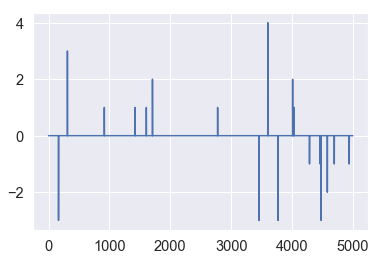

In [90]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [91]:
df_pop.describe()

family_id         0            1            2            3            4     \
count      1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean         56.001000    52.999000    99.998000    30.492000    52.994000   
std          22.875102    38.102583     0.063246    43.550713     0.141365   
min          38.000000     4.000000    98.000000     1.000000    50.000000   
25%          38.000000    26.000000   100.000000     2.000000    53.000000   
50%          52.000000    26.000000   100.000000     2.000000    53.000000   
75%          52.000000    99.000000   100.000000    97.000000    53.000000   
max         100.000000   100.000000   100.000000    97.000000    54.000000   

family_id         5            6            7            8            9     \
count      1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean         42.814000    71.211000    59.097000    22.196000    52.184000   
std          13.234748    33.633133    29.094434    12.608273    30.926471   
min          29.000000     1.000000    22.000000    16.000000     1.000000   
25%          32.000000    88.000000    25.000000    18.000000    50.000000   
50%          32.000000    88.000000    48.000000    18.000000    50.000000   
75%          59.000000    88.000000    93.000000    18.000000    88.000000   
max          62.000000    91.000000    95.000000    60.000000    91.000000   

family_id     ...             4990         4991        4992         4993  \
count         ...      1000.000000  1000.000000  1000.00000  1000.000000   
mean          ...        56.706000    43.411000    27.59700    62.003000   
std           ...         8.773742     4.811989    31.21979     0.170353   
min           ...        47.000000    28.000000     9.00000    60.000000   
25%           ...        47.000000    45.000000    12.00000    62.000000   
50%           ...        61.000000    45.000000    12.00000    62.000000   
75%           ...        61.000000    45.000000    12.00000    62.000000   
max           ...        77.000000    47.000000    91.00000    65.000000   

family_id         4994         4995         4996        4997         4998  \
count      1000.000000  1000.000000  1000.000000  1000.00000  1000.000000   
mean         53.405000    16.010000    67.609000    38.80100    79.506000   
std           2.797642     0.141138    31.183369    13.60016    12.502811   
min          51.000000    16.000000    20.000000    29.00000    67.000000   
25%          52.000000    16.000000    20.000000    32.00000    67.000000   
50%          52.000000    16.000000    88.000000    32.00000    81.000000   
75%          52.000000    16.000000    88.000000    32.00000    92.000000   
max          59.000000    18.000000    91.000000    66.00000    93.000000   

family_id        4999  
count      1000.00000  
mean         14.19500  
std           3.60527  
min          11.00000  
25%          13.00000  
50%          13.00000  
75%          13.00000  
max          25.00000  

[8 rows x 5000 columns]

#### Method 2:  Choice by Choices

In [432]:
def generate_pop_choices(seed_indiv=None, nb_pop=None, r_mut=None):
    '''
    Generate first polulation from one seed individual by family choices
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return dataFrame population
    '''
    t_fit_0 = time.time()
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    if seed_indiv is None:
        seed_indiv = submission
    if nb_pop is None:
        nb_pop = NB_FIRST_POP
    if r_mut is None:
        r_mut = R_FIRST_MUT
    #print("seed_indiv: ", seed_indiv)
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    # initialize with same previous best indiv.
    df_pop = pd.DataFrame(index=range(0, nb_pop), 
                          columns=seed_indiv["family_id"])

    for fam_id in seed_indiv["family_id"]:
        df_pop[fam_id] = seed_indiv.at[fam_id,'assigned_day']

    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in data.index: # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        day_curr = seed_indiv.at[fam_id, 'assigned_day']
        
        vect_pop_mutated = mutation_day(day_curr, fam_id, nb_mut=nb_pop, 
                                        flag_prob=True)
        
        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(range(0, nb_pop), 
                                     size=int(r_mut*nb_pop))

        df_pop.loc[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    df_pop.loc[0] = seed_indiv['assigned_day']
    
    print("Generation population is done.")
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    
    return df_pop

In [433]:
# HYPERPARAMETERS
DELTA_CHOICE = 1
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000

#df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)
df_prob_fam = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_fam_2.pkl')
df_prob = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_2.pkl')

nb_indiv_done = 0
nb_range = df_range.index.shape[0]
for i_seed in df_range.index:
    # choose number of indiv.
    nb_indiv_curr = np.floor(NB_FIRST_POP/df_range.shape[0])
    nb_indiv_done += nb_indiv_curr
    if i_seed == nb_range-1:
        if NB_FIRST_POP % nb_range != 0:
            nb_indiv_curr += NB_FIRST_POP % nb_range
    nb_indiv_curr = int(nb_indiv_curr)
    print("# {} / nb_indiv_curr: {} / done: {}".format(i_seed, nb_indiv_curr, 
                                                       nb_indiv_done))
    # load best indiv in range #i_seed
    seed_indiv = pd.read_csv(f'submission_range{i_seed}.csv')
    # generate sub-pop 
    df_pop_curr = generate_pop_choices(seed_indiv=seed_indiv, 
                                       nb_pop=nb_indiv_curr, 
                                       r_mut=R_FIRST_MUT)
    # add sub-pop to pop
    if i_seed == 0:
        df_pop = df_pop_curr
    else:
        df_pop = df_pop.append(df_pop_curr, ignore_index=True)

print("df_pop.shape: ", df_pop.shape) 
df_pop.head()

# 0 / nb_indiv_curr: 100 / done: 100.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  53.41584396362305
# 1 / nb_indiv_curr: 100 / done: 200.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  42.22392964363098
# 2 / nb_indiv_curr: 100 / done: 300.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  44.29747796058655
# 3 / nb_indiv_curr: 100 / done: 400.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  42.89790415763855
# 4 / nb_indiv_curr: 100 / done: 500.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  45.88465929031372
# 5 / nb_indiv_curr: 100 / done: 600.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  47.983644247055054
# 6 / nb_indiv_curr: 100 / done: 700.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation popu

family_id  0     1     2     3     4     5     6     7     8     9     ...   \
0            52    26   100     2    53    59    88    25    18     1  ...    
1            52    26   100     2    53    59    88    25    18     1  ...    
2            52    26   100     2    53    59    88    25    18     1  ...    
3            52    26   100     2    53    59    88    25    18     1  ...    
4            52    26   100     2    53    59    88    25    18     1  ...    

family_id  4990  4991  4992  4993  4994  4995  4996  4997  4998  4999  
0            61    29    90    62    52    16    88    32    67    13  
1            61    29    90    62    52    16    88    32    67    13  
2            61    29    90    62    52    16    88    32    67    13  
3            61    29    90    62    52    16    88    32    67    13  
4            61    29    90    62    52    16    88    32     4    13  

[5 rows x 5000 columns]

#### Save pop

In [435]:
# save
#joblib.dump(df_pop, PATH_SAVE_DF_POP_10)
#DELTA_DAYS = 3
#R_FIRST_MUT = 0.01
#NB_FIRST_POP = 1000
# POP
joblib.dump(df_pop,
            PATH_TO_SAVE_DATA + '/df_pop_choices{}_fs{}_rfm{}_dc{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_CHOICE),
           compress=True)

['../../data/df_pop_choices1000_fs10_rfm0.01_dc1.pkl']

## Run with pop by choices

### Evaluation #1

In [ ]:
df_prob_fam = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_fam_2.pkl')
df_prob = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_2.pkl')
# patch to optimize mutation fonction:
arr_prob = np.array(df_prob)

In [436]:
NB_FIRST_SEED = 10
DELTA_CHOICE = 1
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000
# load 
df_pop = joblib.load(PATH_TO_SAVE_DATA + '/df_pop_choices{}_fs{}_rfm{}_dc{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_CHOICE))

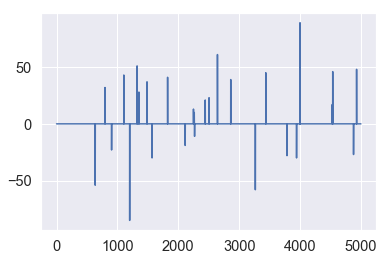

In [437]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [438]:
# create cost dataFrame for all population
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

cost
800  605419.833709
400  654844.718387
900  656228.754657
600  657505.942610
0    672254.027668
700  677348.768396
300  679410.167648
200  684479.327148
500  686524.150792
342  689530.226809

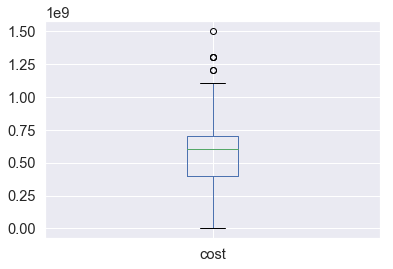

In [439]:
df_cost.boxplot()

###  Loop over generations

 
GENERATION #0 / nb. pop: 1000
nb_survivor:  990
              cost
980  605419.833709
Timing epoch:  22.543166160583496
 
GENERATION #1 / nb. pop: 990
nb_survivor:  980
              cost
970  605419.833709
Timing epoch:  21.62666392326355
 
GENERATION #2 / nb. pop: 980
nb_survivor:  970
              cost
960  605419.833709
Timing epoch:  21.722731828689575
 
GENERATION #3 / nb. pop: 970
nb_survivor:  960
              cost
950  605419.833709
Timing epoch:  20.52338194847107
 
GENERATION #4 / nb. pop: 960
nb_survivor:  950
              cost
940  605419.833709
Timing epoch:  20.19354796409607
 
GENERATION #5 / nb. pop: 950
nb_survivor:  940
              cost
930  605419.833709
Timing epoch:  20.6294949054718
 
GENERATION #6 / nb. pop: 940
nb_survivor:  930
              cost
920  605419.833709
Timing epoch:  19.83353900909424
 
GENERATION #7 / nb. pop: 930
nb_survivor:  920
              cost
910  605419.833709
Timing epoch:  19.30399799346924
 
GENERATION #8 / nb. pop: 920
nb_surv

              cost
486  605419.833709
Timing epoch:  11.082397937774658
 
GENERATION #69 / nb. pop: 496
nb_survivor:  492
              cost
482  605419.833709
Timing epoch:  10.543960809707642
 
GENERATION #70 / nb. pop: 492
nb_survivor:  488
              cost
478  605419.833709
Timing epoch:  11.207478046417236
 
GENERATION #71 / nb. pop: 488
nb_survivor:  484
              cost
478  605419.833709
Timing epoch:  10.554502725601196
 
GENERATION #72 / nb. pop: 484
nb_survivor:  480
              cost
474  605419.833709
Timing epoch:  10.68985390663147
 
GENERATION #73 / nb. pop: 480
nb_survivor:  476
              cost
469  605419.833709
Timing epoch:  10.57303500175476
 
GENERATION #74 / nb. pop: 476
nb_survivor:  472
              cost
464  605419.833709
Timing epoch:  11.477778911590576
 
GENERATION #75 / nb. pop: 472
nb_survivor:  468
              cost
465  605419.833709
Timing epoch:  16.891663074493408
 
GENERATION #76 / nb. pop: 468
nb_survivor:  464
             cost
27  6054

              cost
165  603066.209484
Timing epoch:  5.548461198806763
 
GENERATION #137 / nb. pop: 262
nb_survivor:  260
              cost
250  603066.209484
Timing epoch:  5.583633899688721
 
GENERATION #138 / nb. pop: 260
nb_survivor:  258
              cost
250  603066.209484
Timing epoch:  7.32743501663208
 
GENERATION #139 / nb. pop: 258
nb_survivor:  256
              cost
246  603066.209484
Timing epoch:  5.48625111579895
 
GENERATION #140 / nb. pop: 256
nb_survivor:  254
              cost
245  603066.209484
Timing epoch:  5.606489181518555
 
GENERATION #141 / nb. pop: 254
nb_survivor:  252
             cost
43  603066.209484
Timing epoch:  5.446778059005737
 
GENERATION #142 / nb. pop: 252
nb_survivor:  250
              cost
247  603066.209484
Timing epoch:  5.342530965805054
 
GENERATION #143 / nb. pop: 250
nb_survivor:  248
              cost
245  603066.209484
Timing epoch:  5.194733142852783
 
GENERATION #144 / nb. pop: 248
nb_survivor:  246
            cost
0  603026.5

            cost
50  601640.26172
Timing epoch:  2.5355939865112305
 
GENERATION #205 / nb. pop: 126
nb_survivor:  124
             cost
114  601640.26172
Timing epoch:  2.5120179653167725
 
GENERATION #206 / nb. pop: 124
nb_survivor:  122
             cost
112  601640.26172
Timing epoch:  2.5440759658813477
 
GENERATION #207 / nb. pop: 122
nb_survivor:  120
           cost
0  601640.26172
Timing epoch:  2.4761509895324707
 
GENERATION #208 / nb. pop: 120
nb_survivor:  118
             cost
108  601640.26172
Timing epoch:  2.3714659214019775
 
GENERATION #209 / nb. pop: 118
nb_survivor:  116
             cost
112  601640.26172
Timing epoch:  2.289494037628174
 
GENERATION #210 / nb. pop: 116
nb_survivor:  114
             cost
106  601640.26172
Timing epoch:  2.293686866760254
 
GENERATION #211 / nb. pop: 114
nb_survivor:  112
           cost
0  601640.26172
Timing epoch:  2.2920889854431152
 
GENERATION #212 / nb. pop: 112
nb_survivor:  110
           cost
0  601640.26172
Timing epoch

            cost
0  598490.314143
Timing epoch:  2.446479082107544
 
GENERATION #274 / nb. pop: 100
nb_survivor:  100
             cost
13  598441.220077
Timing epoch:  2.116135835647583
 
GENERATION #275 / nb. pop: 100
nb_survivor:  100
             cost
90  598441.220077
Timing epoch:  2.0616109371185303
 
GENERATION #276 / nb. pop: 100
nb_survivor:  100
             cost
90  598441.220077
Timing epoch:  2.0584652423858643
 
GENERATION #277 / nb. pop: 100
nb_survivor:  100
             cost
91  598441.220077
Timing epoch:  2.248774766921997
 
GENERATION #278 / nb. pop: 100
nb_survivor:  100
            cost
2  598441.220077
Timing epoch:  2.1029129028320312
 
GENERATION #279 / nb. pop: 100
nb_survivor:  100
            cost
1  598441.220077
Timing epoch:  2.145050287246704
 
GENERATION #280 / nb. pop: 100
nb_survivor:  100
             cost
90  598441.220077
Timing epoch:  2.041646957397461
 
GENERATION #281 / nb. pop: 100
nb_survivor:  100
             cost
96  598441.220077
Timing 

             cost
90  598138.833384
Timing epoch:  2.0559771060943604
 
GENERATION #343 / nb. pop: 100
nb_survivor:  100
             cost
90  598138.833384
Timing epoch:  2.056439161300659
 
GENERATION #344 / nb. pop: 100
nb_survivor:  100
            cost
3  598138.833384
Timing epoch:  2.0510196685791016
 
GENERATION #345 / nb. pop: 100
nb_survivor:  100
             cost
23  598116.881037
Timing epoch:  2.077820062637329
 
GENERATION #346 / nb. pop: 100
nb_survivor:  100
             cost
90  598116.881037
Timing epoch:  2.086418390274048
 
GENERATION #347 / nb. pop: 100
nb_survivor:  100
             cost
91  598116.881037
Timing epoch:  2.0523979663848877
 
GENERATION #348 / nb. pop: 100
nb_survivor:  100
             cost
90  598116.881037
Timing epoch:  2.0686678886413574
 
GENERATION #349 / nb. pop: 100
nb_survivor:  100
             cost
91  598116.881037
Timing epoch:  2.079440116882324
 
GENERATION #350 / nb. pop: 100
nb_survivor:  100
             cost
50  598115.996819
Ti

             cost
53  597695.203036
Timing epoch:  1.9768671989440918
 
GENERATION #412 / nb. pop: 100
nb_survivor:  100
             cost
90  597695.203036
Timing epoch:  1.9682002067565918
 
GENERATION #413 / nb. pop: 100
nb_survivor:  100
             cost
90  597695.203036
Timing epoch:  1.9680838584899902
 
GENERATION #414 / nb. pop: 100
nb_survivor:  100
             cost
52  597686.893023
Timing epoch:  1.9906270503997803
 
GENERATION #415 / nb. pop: 100
nb_survivor:  100
            cost
0  597686.893023
Timing epoch:  2.018897771835327
 
GENERATION #416 / nb. pop: 100
nb_survivor:  100
            cost
3  597677.562595
Timing epoch:  1.9732038974761963
 
GENERATION #417 / nb. pop: 100
nb_survivor:  100
             cost
90  597677.562595
Timing epoch:  2.196516990661621
 
GENERATION #418 / nb. pop: 100
nb_survivor:  100
             cost
90  597677.562595
Timing epoch:  2.0124030113220215
 
GENERATION #419 / nb. pop: 100
nb_survivor:  100
             cost
10  597672.226977
Ti

             cost
99  597589.183269
Timing epoch:  1.9275498390197754
 
GENERATION #481 / nb. pop: 100
nb_survivor:  100
             cost
99  597589.183269
Timing epoch:  1.950275182723999
 
GENERATION #482 / nb. pop: 100
nb_survivor:  100
             cost
99  597589.183269
Timing epoch:  1.955306053161621
 
GENERATION #483 / nb. pop: 100
nb_survivor:  100
             cost
99  597589.183269
Timing epoch:  1.9914941787719727
 
GENERATION #484 / nb. pop: 100
nb_survivor:  100
             cost
99  597589.183269
Timing epoch:  1.9802680015563965
 
GENERATION #485 / nb. pop: 100
nb_survivor:  100
            cost
0  597589.183269
Timing epoch:  1.9613037109375
 
GENERATION #486 / nb. pop: 100
nb_survivor:  100
             cost
49  597589.183269
Timing epoch:  1.9300448894500732
 
GENERATION #487 / nb. pop: 100
nb_survivor:  100
             cost
99  597589.183269
Timing epoch:  1.9524071216583252
 
GENERATION #488 / nb. pop: 100
nb_survivor:  100
             cost
99  597589.183269
Tim

             cost
70  595490.064821
Timing epoch:  1.9671719074249268
 
GENERATION #550 / nb. pop: 100
nb_survivor:  100
             cost
90  595490.064821
Timing epoch:  2.018455743789673
 
GENERATION #551 / nb. pop: 100
nb_survivor:  100
             cost
90  595490.064821
Timing epoch:  1.9582579135894775
 
GENERATION #552 / nb. pop: 100
nb_survivor:  100
             cost
29  595473.997206
Timing epoch:  2.0776143074035645
 
GENERATION #553 / nb. pop: 100
nb_survivor:  100
             cost
90  595473.997206
Timing epoch:  1.963541030883789
 
GENERATION #554 / nb. pop: 100
nb_survivor:  100
            cost
1  595457.492696
Timing epoch:  1.9504749774932861
 
GENERATION #555 / nb. pop: 100
nb_survivor:  100
            cost
7  595403.899691
Timing epoch:  1.9579403400421143
 
GENERATION #556 / nb. pop: 100
nb_survivor:  100
             cost
90  595403.899691
Timing epoch:  2.0843772888183594
 
GENERATION #557 / nb. pop: 100
nb_survivor:  100
             cost
13  595385.724239
Ti

             cost
90  594676.765931
Timing epoch:  1.93430495262146
 
GENERATION #619 / nb. pop: 100
nb_survivor:  100
             cost
90  594676.765931
Timing epoch:  1.9713501930236816
 
GENERATION #620 / nb. pop: 100
nb_survivor:  100
             cost
63  594597.567573
Timing epoch:  1.954237937927246
 
GENERATION #621 / nb. pop: 100
nb_survivor:  100
             cost
90  594597.567573
Timing epoch:  1.929988145828247
 
GENERATION #622 / nb. pop: 100
nb_survivor:  100
             cost
66  594487.730332
Timing epoch:  2.045984983444214
 
GENERATION #623 / nb. pop: 100
nb_survivor:  100
             cost
90  594487.730332
Timing epoch:  1.9917240142822266
 
GENERATION #624 / nb. pop: 100
nb_survivor:  100
             cost
67  594406.268998
Timing epoch:  1.97987699508667
 
GENERATION #625 / nb. pop: 100
nb_survivor:  100
             cost
90  594406.268998
Timing epoch:  1.9354169368743896
 
GENERATION #626 / nb. pop: 100
nb_survivor:  100
             cost
23  594390.633555
Tim

            cost
0  594235.480144
Timing epoch:  1.9606809616088867
 
GENERATION #688 / nb. pop: 100
nb_survivor:  100
            cost
0  594235.480144
Timing epoch:  1.9272871017456055
 
GENERATION #689 / nb. pop: 100
nb_survivor:  100
             cost
99  594235.480144
Timing epoch:  1.9288067817687988
 
GENERATION #690 / nb. pop: 100
nb_survivor:  100
             cost
99  594235.480144
Timing epoch:  1.948101282119751
 
GENERATION #691 / nb. pop: 100
nb_survivor:  100
             cost
99  594235.480144
Timing epoch:  1.9586570262908936
 
GENERATION #692 / nb. pop: 100
nb_survivor:  100
             cost
99  594235.480144
Timing epoch:  2.072746992111206
 
GENERATION #693 / nb. pop: 100
nb_survivor:  100
            cost
0  594235.480144
Timing epoch:  2.075510025024414
 
GENERATION #694 / nb. pop: 100
nb_survivor:  100
            cost
0  594235.480144
Timing epoch:  2.0528340339660645
 
GENERATION #695 / nb. pop: 100
nb_survivor:  100
             cost
49  594235.480144
Timing 

             cost
19  592324.978589
Timing epoch:  2.048233985900879
 
GENERATION #757 / nb. pop: 100
nb_survivor:  100
            cost
1  592324.978589
Timing epoch:  1.9594569206237793
 
GENERATION #758 / nb. pop: 100
nb_survivor:  100
             cost
90  592324.978589
Timing epoch:  2.0408010482788086
 
GENERATION #759 / nb. pop: 100
nb_survivor:  100
             cost
74  592237.239628
Timing epoch:  1.9502758979797363
 
GENERATION #760 / nb. pop: 100
nb_survivor:  100
             cost
62  592237.239628
Timing epoch:  1.9354329109191895
 
GENERATION #761 / nb. pop: 100
nb_survivor:  100
            cost
5  592230.640609
Timing epoch:  1.9356398582458496
 
GENERATION #762 / nb. pop: 100
nb_survivor:  100
             cost
90  592230.640609
Timing epoch:  1.9954397678375244
 
GENERATION #763 / nb. pop: 100
nb_survivor:  100
             cost
93  592230.640609
Timing epoch:  2.031147003173828
 
GENERATION #764 / nb. pop: 100
nb_survivor:  100
             cost
40  592230.640609
Ti

             cost
68  592173.264798
Timing epoch:  2.8430678844451904
 
GENERATION #826 / nb. pop: 100
nb_survivor:  100
             cost
87  592085.621385
Timing epoch:  2.760867118835449
 
GENERATION #827 / nb. pop: 100
nb_survivor:  100
             cost
50  592085.621385
Timing epoch:  3.58712100982666
 
GENERATION #828 / nb. pop: 100
nb_survivor:  100
             cost
91  592085.621385
Timing epoch:  2.9010908603668213
 
GENERATION #829 / nb. pop: 100
nb_survivor:  100
            cost
0  592073.319073
Timing epoch:  2.533010244369507
 
GENERATION #830 / nb. pop: 100
nb_survivor:  100
             cost
90  592073.319073
Timing epoch:  2.6142141819000244
 
GENERATION #831 / nb. pop: 100
nb_survivor:  100
             cost
90  592073.319073
Timing epoch:  3.551487922668457
 
GENERATION #832 / nb. pop: 100
nb_survivor:  100
             cost
90  592073.319073
Timing epoch:  2.6336450576782227
 
GENERATION #833 / nb. pop: 100
nb_survivor:  100
            cost
3  592073.319073
Timin

             cost
90  591449.952696
Timing epoch:  2.811598777770996
 
GENERATION #895 / nb. pop: 100
nb_survivor:  100
             cost
90  591449.952696
Timing epoch:  2.179732084274292
 
GENERATION #896 / nb. pop: 100
nb_survivor:  100
             cost
23  591449.952696
Timing epoch:  2.1503829956054688
 
GENERATION #897 / nb. pop: 100
nb_survivor:  100
            cost
31  591442.32687
Timing epoch:  2.9216790199279785
 
GENERATION #898 / nb. pop: 100
nb_survivor:  100
            cost
90  591442.32687
Timing epoch:  2.40714168548584
 
GENERATION #899 / nb. pop: 100
nb_survivor:  100
           cost
0  591442.32687
Timing epoch:  3.036787986755371
 
GENERATION #900 / nb. pop: 100
nb_survivor:  100
            cost
91  591442.32687
Timing epoch:  2.065398931503296
 
GENERATION #901 / nb. pop: 100
nb_survivor:  100
           cost
1  591442.32687
Timing epoch:  2.0156631469726562
 
GENERATION #902 / nb. pop: 100
nb_survivor:  100
            cost
92  591442.32687
Timing epoch:  2.0

             cost
70  589178.202404
Timing epoch:  2.251540184020996
 
GENERATION #964 / nb. pop: 100
nb_survivor:  100
             cost
46  589178.202404
Timing epoch:  2.4203968048095703
 
GENERATION #965 / nb. pop: 100
nb_survivor:  100
             cost
90  589178.202404
Timing epoch:  2.0786540508270264
 
GENERATION #966 / nb. pop: 100
nb_survivor:  100
             cost
18  589178.202404
Timing epoch:  2.1418962478637695
 
GENERATION #967 / nb. pop: 100
nb_survivor:  100
             cost
86  589178.202404
Timing epoch:  2.0956642627716064
 
GENERATION #968 / nb. pop: 100
nb_survivor:  100
            cost
0  589178.202404
Timing epoch:  2.1428420543670654
 
GENERATION #969 / nb. pop: 100
nb_survivor:  100
             cost
49  589178.202404
Timing epoch:  2.157252788543701
 
GENERATION #970 / nb. pop: 100
nb_survivor:  100
             cost
99  589178.202404
Timing epoch:  2.1905109882354736
 
GENERATION #971 / nb. pop: 100
nb_survivor:  100
             cost
99  589178.202404


            cost
2  588093.577304
Timing epoch:  2.133080005645752
 
GENERATION #1033 / nb. pop: 100
nb_survivor:  100
             cost
90  588093.577304
Timing epoch:  2.06488299369812
 
GENERATION #1034 / nb. pop: 100
nb_survivor:  100
             cost
26  588093.577304
Timing epoch:  2.073780059814453
 
GENERATION #1035 / nb. pop: 100
nb_survivor:  100
             cost
91  588093.577304
Timing epoch:  2.219312906265259
 
GENERATION #1036 / nb. pop: 100
nb_survivor:  100
             cost
59  588093.577304
Timing epoch:  2.3882951736450195
 
GENERATION #1037 / nb. pop: 100
nb_survivor:  100
             cost
30  588087.765646
Timing epoch:  3.484783887863159
 
GENERATION #1038 / nb. pop: 100
nb_survivor:  100
            cost
0  588087.765646
Timing epoch:  2.9386470317840576
 
GENERATION #1039 / nb. pop: 100
nb_survivor:  100
             cost
91  588087.765646
Timing epoch:  3.102750062942505
 
GENERATION #1040 / nb. pop: 100
nb_survivor:  100
             cost
91  588087.765646

             cost
99  585805.968236
Timing epoch:  2.5731751918792725
 
GENERATION #1101 / nb. pop: 100
nb_survivor:  100
             cost
99  585805.968236
Timing epoch:  3.424048900604248
 
GENERATION #1102 / nb. pop: 100
nb_survivor:  100
             cost
99  585805.968236
Timing epoch:  3.664522886276245
 
GENERATION #1103 / nb. pop: 100
nb_survivor:  100
             cost
99  585805.968236
Timing epoch:  2.6059200763702393
 
GENERATION #1104 / nb. pop: 100
nb_survivor:  100
             cost
30  585724.451048
Timing epoch:  2.418494939804077
 
GENERATION #1105 / nb. pop: 100
nb_survivor:  100
             cost
90  585724.451048
Timing epoch:  2.3565378189086914
 
GENERATION #1106 / nb. pop: 100
nb_survivor:  100
            cost
0  585724.451048
Timing epoch:  2.546046018600464
 
GENERATION #1107 / nb. pop: 100
nb_survivor:  100
             cost
91  585724.451048
Timing epoch:  2.302298069000244
 
GENERATION #1108 / nb. pop: 100
nb_survivor:  100
            cost
0  585724.4510

             cost
99  584525.632999
Timing epoch:  2.055267810821533
 
GENERATION #1169 / nb. pop: 100
nb_survivor:  100
            cost
0  584525.632999
Timing epoch:  2.0500831604003906
 
GENERATION #1170 / nb. pop: 100
nb_survivor:  100
             cost
60  584520.423512
Timing epoch:  2.099363088607788
 
GENERATION #1171 / nb. pop: 100
nb_survivor:  100
            cost
0  584520.423512
Timing epoch:  2.6499199867248535
 
GENERATION #1172 / nb. pop: 100
nb_survivor:  100
            cost
0  584520.423512
Timing epoch:  2.4955010414123535
 
GENERATION #1173 / nb. pop: 100
nb_survivor:  100
             cost
93  584520.423512
Timing epoch:  2.6806368827819824
 
GENERATION #1174 / nb. pop: 100
nb_survivor:  100
            cost
0  584520.423512
Timing epoch:  2.8824548721313477
 
GENERATION #1175 / nb. pop: 100
nb_survivor:  100
             cost
99  584520.423512
Timing epoch:  2.3141257762908936
 
GENERATION #1176 / nb. pop: 100
nb_survivor:  100
            cost
0  584520.423512


            cost
8  584179.901989
Timing epoch:  3.5676980018615723
 
GENERATION #1237 / nb. pop: 100
nb_survivor:  100
             cost
99  584179.901989
Timing epoch:  4.369605302810669
 
GENERATION #1238 / nb. pop: 100
nb_survivor:  100
            cost
2  582013.468418
Timing epoch:  4.773903131484985
 
GENERATION #1239 / nb. pop: 100
nb_survivor:  100
             cost
90  582013.468418
Timing epoch:  4.6140830516815186
 
GENERATION #1240 / nb. pop: 100
nb_survivor:  100
             cost
91  582013.468418
Timing epoch:  3.595196008682251
 
GENERATION #1241 / nb. pop: 100
nb_survivor:  100
             cost
87  582013.468418
Timing epoch:  2.30311918258667
 
GENERATION #1242 / nb. pop: 100
nb_survivor:  100
             cost
90  582013.468418
Timing epoch:  2.8984639644622803
 
GENERATION #1243 / nb. pop: 100
nb_survivor:  100
             cost
18  582013.468418
Timing epoch:  2.384019136428833
 
GENERATION #1244 / nb. pop: 100
nb_survivor:  100
             cost
99  582013.46841

             cost
90  581834.731041
Timing epoch:  2.509660005569458
 
GENERATION #1305 / nb. pop: 100
nb_survivor:  100
             cost
52  581834.731041
Timing epoch:  2.1090481281280518
 
GENERATION #1306 / nb. pop: 100
nb_survivor:  100
             cost
90  581834.731041
Timing epoch:  3.4594919681549072
 
GENERATION #1307 / nb. pop: 100
nb_survivor:  100
             cost
43  581834.731041
Timing epoch:  3.7223448753356934
 
GENERATION #1308 / nb. pop: 100
nb_survivor:  100
             cost
95  581834.731041
Timing epoch:  2.5581161975860596
 
GENERATION #1309 / nb. pop: 100
nb_survivor:  100
             cost
91  581834.731041
Timing epoch:  3.09826397895813
 
GENERATION #1310 / nb. pop: 100
nb_survivor:  100
             cost
99  581834.731041
Timing epoch:  2.2436251640319824
 
GENERATION #1311 / nb. pop: 100
nb_survivor:  100
             cost
99  581834.731041
Timing epoch:  2.21213698387146
 
GENERATION #1312 / nb. pop: 100
nb_survivor:  100
             cost
87  581767.

            cost
0  581706.703555
Timing epoch:  2.8655059337615967
 
GENERATION #1374 / nb. pop: 100
nb_survivor:  100
             cost
99  581706.703555
Timing epoch:  2.7138240337371826
 
GENERATION #1375 / nb. pop: 100
nb_survivor:  100
             cost
99  581706.703555
Timing epoch:  2.7165451049804688
 
GENERATION #1376 / nb. pop: 100
nb_survivor:  100
             cost
99  581706.703555
Timing epoch:  3.0390000343322754
 
GENERATION #1377 / nb. pop: 100
nb_survivor:  100
             cost
99  581706.703555
Timing epoch:  2.7534918785095215
 
GENERATION #1378 / nb. pop: 100
nb_survivor:  100
            cost
0  581706.703555
Timing epoch:  2.7638232707977295
 
GENERATION #1379 / nb. pop: 100
nb_survivor:  100
             cost
99  581706.703555
Timing epoch:  2.935898780822754
 
GENERATION #1380 / nb. pop: 100
nb_survivor:  100
             cost
99  581706.703555
Timing epoch:  2.999256134033203
 
GENERATION #1381 / nb. pop: 100
nb_survivor:  100
             cost
13  581694.8

             cost
88  579876.849758
Timing epoch:  2.7536189556121826
 
GENERATION #1442 / nb. pop: 100
nb_survivor:  100
            cost
0  579876.849758
Timing epoch:  2.9018149375915527
 
GENERATION #1443 / nb. pop: 100
nb_survivor:  100
             cost
93  579876.849758
Timing epoch:  2.859226942062378
 
GENERATION #1444 / nb. pop: 100
nb_survivor:  100
            cost
0  579876.849758
Timing epoch:  2.7666537761688232
 
GENERATION #1445 / nb. pop: 100
nb_survivor:  100
            cost
0  579876.849758
Timing epoch:  2.908100128173828
 
GENERATION #1446 / nb. pop: 100
nb_survivor:  100
             cost
99  579876.849758
Timing epoch:  2.642361879348755
 
GENERATION #1447 / nb. pop: 100
nb_survivor:  100
            cost
0  579876.849758
Timing epoch:  2.805769205093384
 
GENERATION #1448 / nb. pop: 100
nb_survivor:  100
            cost
0  579876.849758
Timing epoch:  2.6603281497955322
 
GENERATION #1449 / nb. pop: 100
nb_survivor:  100
             cost
99  579876.849758
Ti

             cost
99  579286.905982
Timing epoch:  2.821521759033203
 
GENERATION #1510 / nb. pop: 100
nb_survivor:  100
            cost
0  579286.905982
Timing epoch:  2.7435641288757324
 
GENERATION #1511 / nb. pop: 100
nb_survivor:  100
            cost
0  579286.905982
Timing epoch:  2.7193148136138916
 
GENERATION #1512 / nb. pop: 100
nb_survivor:  100
            cost
0  579286.905982
Timing epoch:  2.7039332389831543
 
GENERATION #1513 / nb. pop: 100
nb_survivor:  100
             cost
99  579286.905982
Timing epoch:  2.721885919570923
 
GENERATION #1514 / nb. pop: 100
nb_survivor:  100
            cost
0  579286.905982
Timing epoch:  2.6188340187072754
 
GENERATION #1515 / nb. pop: 100
nb_survivor:  100
            cost
0  579286.905982
Timing epoch:  2.7305920124053955
 
GENERATION #1516 / nb. pop: 100
nb_survivor:  100
             cost
99  579286.905982
Timing epoch:  2.836423873901367
 
GENERATION #1517 / nb. pop: 100
nb_survivor:  100
            cost
0  579286.905982
Tim

             cost
90  577248.459014
Timing epoch:  2.0131428241729736
 
GENERATION #1578 / nb. pop: 100
nb_survivor:  100
             cost
95  577248.459014
Timing epoch:  2.00909686088562
 
GENERATION #1579 / nb. pop: 100
nb_survivor:  100
             cost
37  577164.575078
Timing epoch:  1.9659857749938965
 
GENERATION #1580 / nb. pop: 100
nb_survivor:  100
             cost
90  577164.575078
Timing epoch:  1.964717149734497
 
GENERATION #1581 / nb. pop: 100
nb_survivor:  100
             cost
90  577164.575078
Timing epoch:  2.015099048614502
 
GENERATION #1582 / nb. pop: 100
nb_survivor:  100
            cost
1  577164.575078
Timing epoch:  1.9228100776672363
 
GENERATION #1583 / nb. pop: 100
nb_survivor:  100
             cost
90  577164.575078
Timing epoch:  1.9233837127685547
 
GENERATION #1584 / nb. pop: 100
nb_survivor:  100
             cost
67  577164.575078
Timing epoch:  1.9755449295043945
 
GENERATION #1585 / nb. pop: 100
nb_survivor:  100
             cost
92  577164.5

             cost
92  577003.150938
Timing epoch:  3.740017890930176
 
GENERATION #1646 / nb. pop: 100
nb_survivor:  100
             cost
92  577003.150938
Timing epoch:  6.076219081878662
 
GENERATION #1647 / nb. pop: 100
nb_survivor:  100
             cost
90  577003.150938
Timing epoch:  10.849646091461182
 
GENERATION #1648 / nb. pop: 100
nb_survivor:  100
             cost
91  577003.150938
Timing epoch:  5.945078134536743
 
GENERATION #1649 / nb. pop: 100
nb_survivor:  100
             cost
96  577003.150938
Timing epoch:  2.964294910430908
 
GENERATION #1650 / nb. pop: 100
nb_survivor:  100
             cost
91  577003.150938
Timing epoch:  4.909355163574219
 
GENERATION #1651 / nb. pop: 100
nb_survivor:  100
            cost
0  577003.150938
Timing epoch:  3.739893913269043
 
GENERATION #1652 / nb. pop: 100
nb_survivor:  100
             cost
99  577003.150938
Timing epoch:  3.3144350051879883
 
GENERATION #1653 / nb. pop: 100
nb_survivor:  100
             cost
99  577003.150

             cost
99  576936.823847
Timing epoch:  2.9192769527435303
 
GENERATION #1714 / nb. pop: 100
nb_survivor:  100
             cost
99  576936.823847
Timing epoch:  2.8208911418914795
 
GENERATION #1715 / nb. pop: 100
nb_survivor:  100
            cost
0  576936.823847
Timing epoch:  2.8511850833892822
 
GENERATION #1716 / nb. pop: 100
nb_survivor:  100
             cost
99  576936.823847
Timing epoch:  2.724808931350708
 
GENERATION #1717 / nb. pop: 100
nb_survivor:  100
             cost
42  576888.907009
Timing epoch:  2.8871960639953613
 
GENERATION #1718 / nb. pop: 100
nb_survivor:  100
             cost
90  576888.907009
Timing epoch:  2.7402377128601074
 
GENERATION #1719 / nb. pop: 100
nb_survivor:  100
             cost
27  576888.907009
Timing epoch:  2.752516984939575
 
GENERATION #1720 / nb. pop: 100
nb_survivor:  100
            cost
0  576888.907009
Timing epoch:  2.6981661319732666
 
GENERATION #1721 / nb. pop: 100
nb_survivor:  100
             cost
92  576888.9

            cost
99  575011.59415
Timing epoch:  2.8868520259857178
 
GENERATION #1782 / nb. pop: 100
nb_survivor:  100
            cost
99  575011.59415
Timing epoch:  3.0040981769561768
 
GENERATION #1783 / nb. pop: 100
nb_survivor:  100
           cost
0  575011.59415
Timing epoch:  2.7956252098083496
 
GENERATION #1784 / nb. pop: 100
nb_survivor:  100
           cost
0  575011.59415
Timing epoch:  3.9405288696289062
 
GENERATION #1785 / nb. pop: 100
nb_survivor:  100
             cost
51  574957.717033
Timing epoch:  4.516233921051025
 
GENERATION #1786 / nb. pop: 100
nb_survivor:  100
             cost
90  574957.717033
Timing epoch:  3.5462169647216797
 
GENERATION #1787 / nb. pop: 100
nb_survivor:  100
            cost
0  574957.717033
Timing epoch:  2.7533247470855713
 
GENERATION #1788 / nb. pop: 100
nb_survivor:  100
             cost
63  574916.709794
Timing epoch:  2.9386188983917236
 
GENERATION #1789 / nb. pop: 100
nb_survivor:  100
             cost
90  574916.709794
Tim

           cost
90  574668.0228
Timing epoch:  2.435811758041382
 
GENERATION #1851 / nb. pop: 100
nb_survivor:  100
          cost
0  574668.0228
Timing epoch:  2.5164389610290527
 
GENERATION #1852 / nb. pop: 100
nb_survivor:  100
           cost
91  574668.0228
Timing epoch:  2.3554389476776123
 
GENERATION #1853 / nb. pop: 100
nb_survivor:  100
          cost
0  574668.0228
Timing epoch:  2.3326737880706787
 
GENERATION #1854 / nb. pop: 100
nb_survivor:  100
           cost
63  574668.0228
Timing epoch:  2.416692018508911
 
GENERATION #1855 / nb. pop: 100
nb_survivor:  100
           cost
87  574668.0228
Timing epoch:  2.3359129428863525
 
GENERATION #1856 / nb. pop: 100
nb_survivor:  100
           cost
91  574668.0228
Timing epoch:  2.2715651988983154
 
GENERATION #1857 / nb. pop: 100
nb_survivor:  100
           cost
92  574668.0228
Timing epoch:  2.2931623458862305
 
GENERATION #1858 / nb. pop: 100
nb_survivor:  100
          cost
0  574668.0228
Timing epoch:  2.26652193069458


            cost
0  574269.407205
Timing epoch:  2.2415459156036377
 
GENERATION #1920 / nb. pop: 100
nb_survivor:  100
            cost
1  574269.407205
Timing epoch:  2.3623969554901123
 
GENERATION #1921 / nb. pop: 100
nb_survivor:  100
             cost
91  574269.407205
Timing epoch:  2.27130389213562
 
GENERATION #1922 / nb. pop: 100
nb_survivor:  100
            cost
0  574269.407205
Timing epoch:  2.4143190383911133
 
GENERATION #1923 / nb. pop: 100
nb_survivor:  100
             cost
99  574269.407205
Timing epoch:  2.3332488536834717
 
GENERATION #1924 / nb. pop: 100
nb_survivor:  100
             cost
99  574269.407205
Timing epoch:  2.3442068099975586
 
GENERATION #1925 / nb. pop: 100
nb_survivor:  100
             cost
99  574269.407205
Timing epoch:  2.481775999069214
 
GENERATION #1926 / nb. pop: 100
nb_survivor:  100
             cost
99  574269.407205
Timing epoch:  2.508147954940796
 
GENERATION #1927 / nb. pop: 100
nb_survivor:  100
             cost
99  574269.40720

             cost
99  574159.932382
Timing epoch:  2.340654134750366
 
GENERATION #1988 / nb. pop: 100
nb_survivor:  100
             cost
99  574159.932382
Timing epoch:  2.341679096221924
 
GENERATION #1989 / nb. pop: 100
nb_survivor:  100
             cost
99  574159.932382
Timing epoch:  2.2998762130737305
 
GENERATION #1990 / nb. pop: 100
nb_survivor:  100
            cost
0  574159.932382
Timing epoch:  2.2625598907470703
 
GENERATION #1991 / nb. pop: 100
nb_survivor:  100
             cost
99  574159.932382
Timing epoch:  2.2740931510925293
 
GENERATION #1992 / nb. pop: 100
nb_survivor:  100
            cost
0  574159.932382
Timing epoch:  2.286176919937134
 
GENERATION #1993 / nb. pop: 100
nb_survivor:  100
             cost
23  574128.590393
Timing epoch:  2.302543878555298
 
GENERATION #1994 / nb. pop: 100
nb_survivor:  100
             cost
23  574128.590393
Timing epoch:  2.3583950996398926
 
GENERATION #1995 / nb. pop: 100
nb_survivor:  100
             cost
90  574128.590

             cost
37  574032.443825
Timing epoch:  2.3186700344085693
 
GENERATION #2056 / nb. pop: 100
nb_survivor:  100
             cost
91  574032.443825
Timing epoch:  2.3999550342559814
 
GENERATION #2057 / nb. pop: 100
nb_survivor:  100
             cost
42  573973.947417
Timing epoch:  2.4032108783721924
 
GENERATION #2058 / nb. pop: 100
nb_survivor:  100
             cost
53  573973.947417
Timing epoch:  2.314152956008911
 
GENERATION #2059 / nb. pop: 100
nb_survivor:  100
             cost
90  573973.947417
Timing epoch:  2.5269060134887695
 
GENERATION #2060 / nb. pop: 100
nb_survivor:  100
             cost
90  573973.947417
Timing epoch:  2.8889873027801514
 
GENERATION #2061 / nb. pop: 100
nb_survivor:  100
             cost
92  573973.947417
Timing epoch:  2.307417869567871
 
GENERATION #2062 / nb. pop: 100
nb_survivor:  100
            cost
0  573973.947417
Timing epoch:  2.2624430656433105
 
GENERATION #2063 / nb. pop: 100
nb_survivor:  100
             cost
40  573973

            cost
73  573740.51214
Timing epoch:  2.2840688228607178
 
GENERATION #2125 / nb. pop: 100
nb_survivor:  100
            cost
90  573740.51214
Timing epoch:  2.2363529205322266
 
GENERATION #2126 / nb. pop: 100
nb_survivor:  100
           cost
1  573740.51214
Timing epoch:  2.2671449184417725
 
GENERATION #2127 / nb. pop: 100
nb_survivor:  100
           cost
35  573692.5348
Timing epoch:  2.3559751510620117
 
GENERATION #2128 / nb. pop: 100
nb_survivor:  100
             cost
62  573679.938991
Timing epoch:  2.3949270248413086
 
GENERATION #2129 / nb. pop: 100
nb_survivor:  100
             cost
90  573679.938991
Timing epoch:  2.3037755489349365
 
GENERATION #2130 / nb. pop: 100
nb_survivor:  100
             cost
46  573661.404339
Timing epoch:  2.2981109619140625
 
GENERATION #2131 / nb. pop: 100
nb_survivor:  100
             cost
90  573661.404339
Timing epoch:  2.3022091388702393
 
GENERATION #2132 / nb. pop: 100
nb_survivor:  100
             cost
91  573661.404339


            cost
0  573466.008759
Timing epoch:  2.2960689067840576
 
GENERATION #2193 / nb. pop: 100
nb_survivor:  100
            cost
0  573466.008759
Timing epoch:  2.265726089477539
 
GENERATION #2194 / nb. pop: 100
nb_survivor:  100
             cost
99  573466.008759
Timing epoch:  2.271751880645752
 
GENERATION #2195 / nb. pop: 100
nb_survivor:  100
            cost
0  573466.008759
Timing epoch:  2.346561908721924
 
GENERATION #2196 / nb. pop: 100
nb_survivor:  100
             cost
99  573466.008759
Timing epoch:  2.2587530612945557
 
GENERATION #2197 / nb. pop: 100
nb_survivor:  100
            cost
0  573466.008759
Timing epoch:  2.2674949169158936
 
GENERATION #2198 / nb. pop: 100
nb_survivor:  100
             cost
99  573466.008759
Timing epoch:  2.3420820236206055
 
GENERATION #2199 / nb. pop: 100
nb_survivor:  100
             cost
99  573466.008759
Timing epoch:  2.4723000526428223
 
GENERATION #2200 / nb. pop: 100
nb_survivor:  100
             cost
99  573466.008759

             cost
49  572712.169765
Timing epoch:  2.364147901535034
 
GENERATION #2261 / nb. pop: 100
nb_survivor:  100
             cost
99  572712.169765
Timing epoch:  2.392737627029419
 
GENERATION #2262 / nb. pop: 100
nb_survivor:  100
             cost
68  572702.221213
Timing epoch:  2.3841280937194824
 
GENERATION #2263 / nb. pop: 100
nb_survivor:  100
            cost
0  572702.221213
Timing epoch:  2.427767038345337
 
GENERATION #2264 / nb. pop: 100
nb_survivor:  100
             cost
91  572702.221213
Timing epoch:  2.5479018688201904
 
GENERATION #2265 / nb. pop: 100
nb_survivor:  100
            cost
0  572702.221213
Timing epoch:  2.462700128555298
 
GENERATION #2266 / nb. pop: 100
nb_survivor:  100
             cost
92  572702.221213
Timing epoch:  2.370853900909424
 
GENERATION #2267 / nb. pop: 100
nb_survivor:  100
            cost
0  572702.221213
Timing epoch:  2.2955362796783447
 
GENERATION #2268 / nb. pop: 100
nb_survivor:  100
             cost
91  572702.221213

             cost
29  570544.005371
Timing epoch:  2.2860898971557617
 
GENERATION #2329 / nb. pop: 100
nb_survivor:  100
           cost
0  570526.87263
Timing epoch:  2.371447801589966
 
GENERATION #2330 / nb. pop: 100
nb_survivor:  100
            cost
90  570526.87263
Timing epoch:  2.353255033493042
 
GENERATION #2331 / nb. pop: 100
nb_survivor:  100
            cost
90  570526.87263
Timing epoch:  2.3596110343933105
 
GENERATION #2332 / nb. pop: 100
nb_survivor:  100
            cost
90  570526.87263
Timing epoch:  2.2654919624328613
 
GENERATION #2333 / nb. pop: 100
nb_survivor:  100
           cost
0  570526.87263
Timing epoch:  2.3393962383270264
 
GENERATION #2334 / nb. pop: 100
nb_survivor:  100
            cost
90  570526.87263
Timing epoch:  2.3318898677825928
 
GENERATION #2335 / nb. pop: 100
nb_survivor:  100
            cost
92  570526.87263
Timing epoch:  2.3191890716552734
 
GENERATION #2336 / nb. pop: 100
nb_survivor:  100
           cost
1  570526.87263
Timing epoch

             cost
99  570355.044256
Timing epoch:  2.373831033706665
 
GENERATION #2398 / nb. pop: 100
nb_survivor:  100
             cost
99  570355.044256
Timing epoch:  2.393810987472534
 
GENERATION #2399 / nb. pop: 100
nb_survivor:  100
            cost
0  570355.044256
Timing epoch:  2.268064022064209
 
GENERATION #2400 / nb. pop: 100
nb_survivor:  100
             cost
12  570354.994917
Timing epoch:  2.274470806121826
 
GENERATION #2401 / nb. pop: 100
nb_survivor:  100
             cost
30  570354.994917
Timing epoch:  2.258681058883667
 
GENERATION #2402 / nb. pop: 100
nb_survivor:  100
            cost
0  570354.994917
Timing epoch:  2.3206770420074463
 
GENERATION #2403 / nb. pop: 100
nb_survivor:  100
            cost
2  570354.994917
Timing epoch:  2.877472162246704
 
GENERATION #2404 / nb. pop: 100
nb_survivor:  100
             cost
59  570354.994917
Timing epoch:  2.5681211948394775
 
GENERATION #2405 / nb. pop: 100
nb_survivor:  100
             cost
99  570354.994917


             cost
97  567429.767522
Timing epoch:  2.3746588230133057
 
GENERATION #2467 / nb. pop: 100
nb_survivor:  100
             cost
99  567429.767522
Timing epoch:  2.3239002227783203
 
GENERATION #2468 / nb. pop: 100
nb_survivor:  100
             cost
99  567429.767522
Timing epoch:  2.3527729511260986
 
GENERATION #2469 / nb. pop: 100
nb_survivor:  100
             cost
99  567429.767522
Timing epoch:  2.359606981277466
 
GENERATION #2470 / nb. pop: 100
nb_survivor:  100
             cost
99  567429.767522
Timing epoch:  2.3342888355255127
 
GENERATION #2471 / nb. pop: 100
nb_survivor:  100
            cost
0  567429.767522
Timing epoch:  2.3658008575439453
 
GENERATION #2472 / nb. pop: 100
nb_survivor:  100
             cost
99  567429.767522
Timing epoch:  2.315251111984253
 
GENERATION #2473 / nb. pop: 100
nb_survivor:  100
             cost
99  567429.767522
Timing epoch:  2.3120949268341064
 
GENERATION #2474 / nb. pop: 100
nb_survivor:  100
             cost
99  567429

            cost
0  567244.689269
Timing epoch:  2.415756940841675
 
GENERATION #2535 / nb. pop: 100
nb_survivor:  100
             cost
99  567244.689269
Timing epoch:  2.315833806991577
 
GENERATION #2536 / nb. pop: 100
nb_survivor:  100
            cost
0  567244.689269
Timing epoch:  2.442676067352295
 
GENERATION #2537 / nb. pop: 100
nb_survivor:  100
            cost
0  567244.689269
Timing epoch:  2.337928056716919
 
GENERATION #2538 / nb. pop: 100
nb_survivor:  100
             cost
99  567244.689269
Timing epoch:  2.3977320194244385
 
GENERATION #2539 / nb. pop: 100
nb_survivor:  100
            cost
0  567244.689269
Timing epoch:  2.288914203643799
 
GENERATION #2540 / nb. pop: 100
nb_survivor:  100
            cost
0  567244.689269
Timing epoch:  2.3265089988708496
 
GENERATION #2541 / nb. pop: 100
nb_survivor:  100
            cost
0  567244.689269
Timing epoch:  2.4055209159851074
 
GENERATION #2542 / nb. pop: 100
nb_survivor:  100
             cost
49  567244.689269
Timin

             cost
49  567183.721318
Timing epoch:  2.5617990493774414
 
GENERATION #2604 / nb. pop: 100
nb_survivor:  100
            cost
0  567183.721318
Timing epoch:  2.515687942504883
 
GENERATION #2605 / nb. pop: 100
nb_survivor:  100
            cost
0  567183.721318
Timing epoch:  2.8589088916778564
 
GENERATION #2606 / nb. pop: 100
nb_survivor:  100
             cost
99  567183.721318
Timing epoch:  2.499756097793579
 
GENERATION #2607 / nb. pop: 100
nb_survivor:  100
             cost
12  567172.217319
Timing epoch:  2.465087890625
 
GENERATION #2608 / nb. pop: 100
nb_survivor:  100
             cost
90  567172.217319
Timing epoch:  2.318180799484253
 
GENERATION #2609 / nb. pop: 100
nb_survivor:  100
             cost
90  567172.217319
Timing epoch:  2.511647939682007
 
GENERATION #2610 / nb. pop: 100
nb_survivor:  100
             cost
90  567172.217319
Timing epoch:  2.2514960765838623
 
GENERATION #2611 / nb. pop: 100
nb_survivor:  100
             cost
14  567172.217319


            cost
2  565846.787929
Timing epoch:  2.270313024520874
 
GENERATION #2672 / nb. pop: 100
nb_survivor:  100
             cost
74  565846.787929
Timing epoch:  2.452227830886841
 
GENERATION #2673 / nb. pop: 100
nb_survivor:  100
             cost
15  565846.787929
Timing epoch:  2.324341058731079
 
GENERATION #2674 / nb. pop: 100
nb_survivor:  100
             cost
86  565846.787929
Timing epoch:  2.341902017593384
 
GENERATION #2675 / nb. pop: 100
nb_survivor:  100
            cost
0  565846.787929
Timing epoch:  2.2886719703674316
 
GENERATION #2676 / nb. pop: 100
nb_survivor:  100
            cost
0  565846.787929
Timing epoch:  2.362802028656006
 
GENERATION #2677 / nb. pop: 100
nb_survivor:  100
             cost
99  565846.787929
Timing epoch:  2.3584210872650146
 
GENERATION #2678 / nb. pop: 100
nb_survivor:  100
             cost
99  565846.787929
Timing epoch:  2.3416340351104736
 
GENERATION #2679 / nb. pop: 100
nb_survivor:  100
             cost
99  565846.787929

             cost
90  565656.485443
Timing epoch:  2.2933781147003174
 
GENERATION #2741 / nb. pop: 100
nb_survivor:  100
            cost
0  565656.485443
Timing epoch:  2.3534369468688965
 
GENERATION #2742 / nb. pop: 100
nb_survivor:  100
             cost
90  565656.485443
Timing epoch:  2.291093111038208
 
GENERATION #2743 / nb. pop: 100
nb_survivor:  100
             cost
91  565656.485443
Timing epoch:  2.323652982711792
 
GENERATION #2744 / nb. pop: 100
nb_survivor:  100
            cost
0  565656.485443
Timing epoch:  2.254086971282959
 
GENERATION #2745 / nb. pop: 100
nb_survivor:  100
             cost
99  565656.485443
Timing epoch:  2.4272618293762207
 
GENERATION #2746 / nb. pop: 100
nb_survivor:  100
            cost
0  565656.485443
Timing epoch:  2.332073926925659
 
GENERATION #2747 / nb. pop: 100
nb_survivor:  100
             cost
99  565656.485443
Timing epoch:  2.352696180343628
 
GENERATION #2748 / nb. pop: 100
nb_survivor:  100
            cost
0  565656.485443
T

             cost
90  565556.636173
Timing epoch:  2.7495028972625732
 
GENERATION #2809 / nb. pop: 100
nb_survivor:  100
             cost
90  565556.636173
Timing epoch:  2.5654921531677246
 
GENERATION #2810 / nb. pop: 100
nb_survivor:  100
            cost
3  565556.636173
Timing epoch:  2.3703529834747314
 
GENERATION #2811 / nb. pop: 100
nb_survivor:  100
            cost
9  565556.636173
Timing epoch:  2.3935129642486572
 
GENERATION #2812 / nb. pop: 100
nb_survivor:  100
             cost
91  565556.636173
Timing epoch:  2.304229974746704
 
GENERATION #2813 / nb. pop: 100
nb_survivor:  100
             cost
99  565556.636173
Timing epoch:  2.6328558921813965
 
GENERATION #2814 / nb. pop: 100
nb_survivor:  100
             cost
99  565556.636173
Timing epoch:  2.5762510299682617
 
GENERATION #2815 / nb. pop: 100
nb_survivor:  100
             cost
99  565556.636173
Timing epoch:  2.295426845550537
 
GENERATION #2816 / nb. pop: 100
nb_survivor:  100
             cost
49  565556.6

             cost
99  565417.585382
Timing epoch:  2.298447847366333
 
GENERATION #2877 / nb. pop: 100
nb_survivor:  100
             cost
99  565417.585382
Timing epoch:  2.272000789642334
 
GENERATION #2878 / nb. pop: 100
nb_survivor:  100
            cost
0  565417.585382
Timing epoch:  2.3159689903259277
 
GENERATION #2879 / nb. pop: 100
nb_survivor:  100
            cost
0  565417.585382
Timing epoch:  2.327670097351074
 
GENERATION #2880 / nb. pop: 100
nb_survivor:  100
            cost
0  565417.585382
Timing epoch:  2.338243007659912
 
GENERATION #2881 / nb. pop: 100
nb_survivor:  100
            cost
0  565417.585382
Timing epoch:  2.366780996322632
 
GENERATION #2882 / nb. pop: 100
nb_survivor:  100
             cost
99  565417.585382
Timing epoch:  2.3265469074249268
 
GENERATION #2883 / nb. pop: 100
nb_survivor:  100
            cost
0  565417.585382
Timing epoch:  2.391704797744751
 
GENERATION #2884 / nb. pop: 100
nb_survivor:  100
            cost
0  565417.585382
Timing

           cost
1  564314.59681
Timing epoch:  2.443199872970581
 
GENERATION #2945 / nb. pop: 100
nb_survivor:  100
            cost
90  564314.59681
Timing epoch:  2.6373291015625
 
GENERATION #2946 / nb. pop: 100
nb_survivor:  100
            cost
92  564314.59681
Timing epoch:  2.558974027633667
 
GENERATION #2947 / nb. pop: 100
nb_survivor:  100
            cost
91  564314.59681
Timing epoch:  2.3243248462677
 
GENERATION #2948 / nb. pop: 100
nb_survivor:  100
            cost
99  564314.59681
Timing epoch:  2.232774019241333
 
GENERATION #2949 / nb. pop: 100
nb_survivor:  100
           cost
0  564314.59681
Timing epoch:  2.3157289028167725
 
GENERATION #2950 / nb. pop: 100
nb_survivor:  100
            cost
99  564314.59681
Timing epoch:  2.326853036880493
 
GENERATION #2951 / nb. pop: 100
nb_survivor:  100
           cost
0  564314.59681
Timing epoch:  2.30056095123291
 
GENERATION #2952 / nb. pop: 100
nb_survivor:  100
           cost
0  564314.59681
Timing epoch:  2.475806951

            cost
0  564026.161234
Timing epoch:  2.3628311157226562
 
GENERATION #3014 / nb. pop: 100
nb_survivor:  100
             cost
99  564026.161234
Timing epoch:  2.3435988426208496
 
GENERATION #3015 / nb. pop: 100
nb_survivor:  100
             cost
99  564026.161234
Timing epoch:  2.5702240467071533
 
GENERATION #3016 / nb. pop: 100
nb_survivor:  100
            cost
0  564026.161234
Timing epoch:  2.4242918491363525
 
GENERATION #3017 / nb. pop: 100
nb_survivor:  100
            cost
0  564026.161234
Timing epoch:  3.112224817276001
 
GENERATION #3018 / nb. pop: 100
nb_survivor:  100
             cost
99  564026.161234
Timing epoch:  2.3856770992279053
 
GENERATION #3019 / nb. pop: 100
nb_survivor:  100
             cost
99  564026.161234
Timing epoch:  2.3319058418273926
 
GENERATION #3020 / nb. pop: 100
nb_survivor:  100
             cost
99  564026.161234
Timing epoch:  2.4155478477478027
 
GENERATION #3021 / nb. pop: 100
nb_survivor:  100
             cost
99  564026.16

             cost
33  562691.501206
Timing epoch:  2.2866437435150146
 
GENERATION #3082 / nb. pop: 100
nb_survivor:  100
            cost
0  562691.501206
Timing epoch:  2.3306870460510254
 
GENERATION #3083 / nb. pop: 100
nb_survivor:  100
            cost
0  562691.501206
Timing epoch:  2.2734429836273193
 
GENERATION #3084 / nb. pop: 100
nb_survivor:  100
             cost
90  562691.501206
Timing epoch:  2.427680015563965
 
GENERATION #3085 / nb. pop: 100
nb_survivor:  100
             cost
45  562691.275496
Timing epoch:  2.3319430351257324
 
GENERATION #3086 / nb. pop: 100
nb_survivor:  100
            cost
1  562691.275496
Timing epoch:  2.4287569522857666
 
GENERATION #3087 / nb. pop: 100
nb_survivor:  100
             cost
93  562691.275496
Timing epoch:  2.386302947998047
 
GENERATION #3088 / nb. pop: 100
nb_survivor:  100
             cost
91  562691.275496
Timing epoch:  2.444310188293457
 
GENERATION #3089 / nb. pop: 100
nb_survivor:  100
             cost
94  562691.2754

             cost
99  562432.848234
Timing epoch:  2.2906110286712646
 
GENERATION #3150 / nb. pop: 100
nb_survivor:  100
             cost
49  562432.848234
Timing epoch:  2.348361015319824
 
GENERATION #3151 / nb. pop: 100
nb_survivor:  100
             cost
31  562377.780334
Timing epoch:  2.3028719425201416
 
GENERATION #3152 / nb. pop: 100
nb_survivor:  100
             cost
90  562377.780334
Timing epoch:  2.2429938316345215
 
GENERATION #3153 / nb. pop: 100
nb_survivor:  100
            cost
8  562377.780334
Timing epoch:  2.482510805130005
 
GENERATION #3154 / nb. pop: 100
nb_survivor:  100
             cost
91  562377.780334
Timing epoch:  2.31412410736084
 
GENERATION #3155 / nb. pop: 100
nb_survivor:  100
            cost
1  562377.780334
Timing epoch:  2.328882932662964
 
GENERATION #3156 / nb. pop: 100
nb_survivor:  100
             cost
26  562377.780334
Timing epoch:  2.546076774597168
 
GENERATION #3157 / nb. pop: 100
nb_survivor:  100
             cost
75  562377.78033

           cost
0  562182.91388
Timing epoch:  2.611074209213257
 
GENERATION #3219 / nb. pop: 100
nb_survivor:  100
            cost
99  562182.91388
Timing epoch:  2.357184886932373
 
GENERATION #3220 / nb. pop: 100
nb_survivor:  100
           cost
0  562182.91388
Timing epoch:  2.577829122543335
 
GENERATION #3221 / nb. pop: 100
nb_survivor:  100
           cost
0  562182.91388
Timing epoch:  2.464735984802246
 
GENERATION #3222 / nb. pop: 100
nb_survivor:  100
           cost
0  562182.91388
Timing epoch:  2.4635419845581055
 
GENERATION #3223 / nb. pop: 100
nb_survivor:  100
            cost
99  562182.91388
Timing epoch:  3.369856834411621
 
GENERATION #3224 / nb. pop: 100
nb_survivor:  100
           cost
0  562182.91388
Timing epoch:  3.07528018951416
 
GENERATION #3225 / nb. pop: 100
nb_survivor:  100
            cost
99  562182.91388
Timing epoch:  2.9116051197052
 
GENERATION #3226 / nb. pop: 100
nb_survivor:  100
           cost
0  562182.91388
Timing epoch:  3.15358996391

           cost
0  562182.91388
Timing epoch:  2.339521884918213
 
GENERATION #3289 / nb. pop: 100
nb_survivor:  100
           cost
0  562182.91388
Timing epoch:  2.2975618839263916
 
GENERATION #3290 / nb. pop: 100
nb_survivor:  100
           cost
0  562182.91388
Timing epoch:  2.3199453353881836
 
GENERATION #3291 / nb. pop: 100
nb_survivor:  100
           cost
0  562182.91388
Timing epoch:  2.327322006225586
 
GENERATION #3292 / nb. pop: 100
nb_survivor:  100
           cost
0  562182.91388
Timing epoch:  2.451915979385376
 
GENERATION #3293 / nb. pop: 100
nb_survivor:  100
             cost
83  562153.449743
Timing epoch:  2.312883138656616
 
GENERATION #3294 / nb. pop: 100
nb_survivor:  100
             cost
90  562153.449743
Timing epoch:  2.7121951580047607
 
GENERATION #3295 / nb. pop: 100
nb_survivor:  100
             cost
90  562153.449743
Timing epoch:  2.5190250873565674
 
GENERATION #3296 / nb. pop: 100
nb_survivor:  100
             cost
90  562153.449743
Timing epoch

             cost
99  560006.803723
Timing epoch:  2.4555866718292236
 
GENERATION #3357 / nb. pop: 100
nb_survivor:  100
            cost
3  559894.077607
Timing epoch:  2.2419393062591553
 
GENERATION #3358 / nb. pop: 100
nb_survivor:  100
             cost
90  559894.077607
Timing epoch:  2.3301749229431152
 
GENERATION #3359 / nb. pop: 100
nb_survivor:  100
             cost
90  559894.077607
Timing epoch:  2.3255670070648193
 
GENERATION #3360 / nb. pop: 100
nb_survivor:  100
             cost
90  559894.077607
Timing epoch:  2.3156940937042236
 
GENERATION #3361 / nb. pop: 100
nb_survivor:  100
             cost
79  559894.077607
Timing epoch:  2.8118321895599365
 
GENERATION #3362 / nb. pop: 100
nb_survivor:  100
            cost
1  559894.077607
Timing epoch:  2.5352158546447754
 
GENERATION #3363 / nb. pop: 100
nb_survivor:  100
             cost
15  558938.088764
Timing epoch:  2.3549089431762695
 
GENERATION #3364 / nb. pop: 100
nb_survivor:  100
             cost
90  558938

             cost
49  558350.220225
Timing epoch:  2.488726854324341
 
GENERATION #3425 / nb. pop: 100
nb_survivor:  100
            cost
0  558350.220225
Timing epoch:  2.359743118286133
 
GENERATION #3426 / nb. pop: 100
nb_survivor:  100
            cost
0  558350.220225
Timing epoch:  2.353358745574951
 
GENERATION #3427 / nb. pop: 100
nb_survivor:  100
            cost
0  558350.220225
Timing epoch:  2.400639057159424
 
GENERATION #3428 / nb. pop: 100
nb_survivor:  100
             cost
10  558335.305055
Timing epoch:  2.279723882675171
 
GENERATION #3429 / nb. pop: 100
nb_survivor:  100
            cost
0  558335.305055
Timing epoch:  2.2725698947906494
 
GENERATION #3430 / nb. pop: 100
nb_survivor:  100
            cost
8  558335.305055
Timing epoch:  2.265450954437256
 
GENERATION #3431 / nb. pop: 100
nb_survivor:  100
             cost
50  558335.305055
Timing epoch:  2.6666972637176514
 
GENERATION #3432 / nb. pop: 100
nb_survivor:  100
             cost
90  558335.305055
Timi

            cost
0  558011.191702
Timing epoch:  2.378006935119629
 
GENERATION #3494 / nb. pop: 100
nb_survivor:  100
             cost
70  558011.191702
Timing epoch:  2.3265841007232666
 
GENERATION #3495 / nb. pop: 100
nb_survivor:  100
             cost
31  557973.396795
Timing epoch:  2.432204008102417
 
GENERATION #3496 / nb. pop: 100
nb_survivor:  100
             cost
90  557973.396795
Timing epoch:  2.3226330280303955
 
GENERATION #3497 / nb. pop: 100
nb_survivor:  100
            cost
6  557964.709439
Timing epoch:  2.426253080368042
 
GENERATION #3498 / nb. pop: 100
nb_survivor:  100
            cost
0  557964.709439
Timing epoch:  2.3661999702453613
 
GENERATION #3499 / nb. pop: 100
nb_survivor:  100
            cost
1  557954.349835
Timing epoch:  2.366361141204834
 
GENERATION #3500 / nb. pop: 100
nb_survivor:  100
            cost
0  557954.349835
Timing epoch:  2.3713300228118896
 
GENERATION #3501 / nb. pop: 100
nb_survivor:  100
             cost
51  557926.914532
Ti

             cost
99  555534.245183
Timing epoch:  2.3684070110321045
 
GENERATION #3562 / nb. pop: 100
nb_survivor:  100
             cost
99  555534.245183
Timing epoch:  2.5631988048553467
 
GENERATION #3563 / nb. pop: 100
nb_survivor:  100
             cost
99  555534.245183
Timing epoch:  2.5376980304718018
 
GENERATION #3564 / nb. pop: 100
nb_survivor:  100
             cost
62  555523.225361
Timing epoch:  2.9388608932495117
 
GENERATION #3565 / nb. pop: 100
nb_survivor:  100
            cost
0  555523.225361
Timing epoch:  2.7203338146209717
 
GENERATION #3566 / nb. pop: 100
nb_survivor:  100
            cost
0  555523.225361
Timing epoch:  2.3384242057800293
 
GENERATION #3567 / nb. pop: 100
nb_survivor:  100
            cost
1  555523.225361
Timing epoch:  2.413970947265625
 
GENERATION #3568 / nb. pop: 100
nb_survivor:  100
             cost
90  555523.225361
Timing epoch:  2.322404146194458
 
GENERATION #3569 / nb. pop: 100
nb_survivor:  100
            cost
2  555523.22536

            cost
0  555523.225361
Timing epoch:  2.3592529296875
 
GENERATION #3630 / nb. pop: 100
nb_survivor:  100
            cost
0  555523.225361
Timing epoch:  2.3839149475097656
 
GENERATION #3631 / nb. pop: 100
nb_survivor:  100
             cost
49  555523.225361
Timing epoch:  2.3851611614227295
 
GENERATION #3632 / nb. pop: 100
nb_survivor:  100
             cost
99  555523.225361
Timing epoch:  2.4095418453216553
 
GENERATION #3633 / nb. pop: 100
nb_survivor:  100
            cost
0  555523.225361
Timing epoch:  2.374234914779663
 
GENERATION #3634 / nb. pop: 100
nb_survivor:  100
            cost
0  555523.225361
Timing epoch:  2.323765993118286
 
GENERATION #3635 / nb. pop: 100
nb_survivor:  100
             cost
49  555523.225361
Timing epoch:  2.358154058456421
 
GENERATION #3636 / nb. pop: 100
nb_survivor:  100
             cost
99  555523.225361
Timing epoch:  2.32753586769104
 
GENERATION #3637 / nb. pop: 100
nb_survivor:  100
             cost
99  555523.225361
Timi

           cost
0  555143.22074
Timing epoch:  2.262876033782959
 
GENERATION #3699 / nb. pop: 100
nb_survivor:  100
           cost
0  555143.22074
Timing epoch:  3.026322841644287
 
GENERATION #3700 / nb. pop: 100
nb_survivor:  100
            cost
99  555143.22074
Timing epoch:  2.3162600994110107
 
GENERATION #3701 / nb. pop: 100
nb_survivor:  100
            cost
99  555143.22074
Timing epoch:  2.653071880340576
 
GENERATION #3702 / nb. pop: 100
nb_survivor:  100
            cost
99  555143.22074
Timing epoch:  2.51947021484375
 
GENERATION #3703 / nb. pop: 100
nb_survivor:  100
           cost
0  555143.22074
Timing epoch:  2.3009562492370605
 
GENERATION #3704 / nb. pop: 100
nb_survivor:  100
           cost
0  555143.22074
Timing epoch:  2.2897281646728516
 
GENERATION #3705 / nb. pop: 100
nb_survivor:  100
           cost
0  555143.22074
Timing epoch:  2.8727529048919678
 
GENERATION #3706 / nb. pop: 100
nb_survivor:  100
           cost
0  555143.22074
Timing epoch:  2.799761

             cost
99  555108.472427
Timing epoch:  2.4137420654296875
 
GENERATION #3768 / nb. pop: 100
nb_survivor:  100
            cost
0  555108.472427
Timing epoch:  2.408111810684204
 
GENERATION #3769 / nb. pop: 100
nb_survivor:  100
             cost
99  555108.472427
Timing epoch:  2.284554958343506
 
GENERATION #3770 / nb. pop: 100
nb_survivor:  100
             cost
99  555108.472427
Timing epoch:  2.2855849266052246
 
GENERATION #3771 / nb. pop: 100
nb_survivor:  100
             cost
99  555108.472427
Timing epoch:  2.33408522605896
 
GENERATION #3772 / nb. pop: 100
nb_survivor:  100
            cost
0  555108.472427
Timing epoch:  2.5016660690307617
 
GENERATION #3773 / nb. pop: 100
nb_survivor:  100
            cost
0  555108.472427
Timing epoch:  2.32957124710083
 
GENERATION #3774 / nb. pop: 100
nb_survivor:  100
            cost
0  555108.472427
Timing epoch:  2.2572832107543945
 
GENERATION #3775 / nb. pop: 100
nb_survivor:  100
             cost
99  555108.472427
Ti

             cost
15  555038.203243
Timing epoch:  2.344440221786499
 
GENERATION #3837 / nb. pop: 100
nb_survivor:  100
             cost
90  555038.203243
Timing epoch:  2.4309468269348145
 
GENERATION #3838 / nb. pop: 100
nb_survivor:  100
             cost
90  555038.203243
Timing epoch:  2.2866790294647217
 
GENERATION #3839 / nb. pop: 100
nb_survivor:  100
            cost
0  555038.203243
Timing epoch:  2.2833070755004883
 
GENERATION #3840 / nb. pop: 100
nb_survivor:  100
            cost
0  555038.203243
Timing epoch:  2.4011759757995605
 
GENERATION #3841 / nb. pop: 100
nb_survivor:  100
             cost
17  555010.952447
Timing epoch:  2.3111417293548584
 
GENERATION #3842 / nb. pop: 100
nb_survivor:  100
             cost
45  555010.952447
Timing epoch:  2.415449857711792
 
GENERATION #3843 / nb. pop: 100
nb_survivor:  100
             cost
90  555010.952447
Timing epoch:  2.3679070472717285
 
GENERATION #3844 / nb. pop: 100
nb_survivor:  100
             cost
90  555010.9

            cost
1  554724.632796
Timing epoch:  2.3610479831695557
 
GENERATION #3905 / nb. pop: 100
nb_survivor:  100
             cost
90  554724.632796
Timing epoch:  2.48384165763855
 
GENERATION #3906 / nb. pop: 100
nb_survivor:  100
             cost
99  554724.632796
Timing epoch:  2.326556921005249
 
GENERATION #3907 / nb. pop: 100
nb_survivor:  100
             cost
99  554724.632796
Timing epoch:  2.370588779449463
 
GENERATION #3908 / nb. pop: 100
nb_survivor:  100
            cost
0  554724.632796
Timing epoch:  2.4855549335479736
 
GENERATION #3909 / nb. pop: 100
nb_survivor:  100
             cost
99  554724.632796
Timing epoch:  2.4090559482574463
 
GENERATION #3910 / nb. pop: 100
nb_survivor:  100
             cost
99  554724.632796
Timing epoch:  2.562422037124634
 
GENERATION #3911 / nb. pop: 100
nb_survivor:  100
             cost
14  554660.029672
Timing epoch:  2.385098934173584
 
GENERATION #3912 / nb. pop: 100
nb_survivor:  100
             cost
90  554660.02967

             cost
91  553591.027701
Timing epoch:  2.321913957595825
 
GENERATION #3973 / nb. pop: 100
nb_survivor:  100
             cost
26  553591.027701
Timing epoch:  2.383558988571167
 
GENERATION #3974 / nb. pop: 100
nb_survivor:  100
             cost
33  553591.027701
Timing epoch:  2.3282229900360107
 
GENERATION #3975 / nb. pop: 100
nb_survivor:  100
            cost
9  553591.027701
Timing epoch:  2.2792749404907227
 
GENERATION #3976 / nb. pop: 100
nb_survivor:  100
            cost
8  553591.027701
Timing epoch:  2.347533702850342
 
GENERATION #3977 / nb. pop: 100
nb_survivor:  100
             cost
26  553579.074873
Timing epoch:  2.4528119564056396
 
GENERATION #3978 / nb. pop: 100
nb_survivor:  100
             cost
90  553579.074873
Timing epoch:  2.3590848445892334
 
GENERATION #3979 / nb. pop: 100
nb_survivor:  100
            cost
0  553579.074873
Timing epoch:  2.329489231109619
 
GENERATION #3980 / nb. pop: 100
nb_survivor:  100
            cost
0  553579.074873


            cost
24  553301.24088
Timing epoch:  2.27252197265625
 
GENERATION #4041 / nb. pop: 100
nb_survivor:  100
           cost
0  553301.24088
Timing epoch:  2.2515902519226074
 
GENERATION #4042 / nb. pop: 100
nb_survivor:  100
            cost
99  553301.24088
Timing epoch:  2.4431469440460205
 
GENERATION #4043 / nb. pop: 100
nb_survivor:  100
            cost
99  553301.24088
Timing epoch:  2.3070380687713623
 
GENERATION #4044 / nb. pop: 100
nb_survivor:  100
           cost
0  553301.24088
Timing epoch:  2.3119051456451416
 
GENERATION #4045 / nb. pop: 100
nb_survivor:  100
            cost
99  553301.24088
Timing epoch:  3.11836576461792
 
GENERATION #4046 / nb. pop: 100
nb_survivor:  100
           cost
0  553301.24088
Timing epoch:  3.8308868408203125
 
GENERATION #4047 / nb. pop: 100
nb_survivor:  100
           cost
0  553301.24088
Timing epoch:  2.455880880355835
 
GENERATION #4048 / nb. pop: 100
nb_survivor:  100
            cost
99  553301.24088
Timing epoch:  3.29

             cost
99  553222.234771
Timing epoch:  2.3916220664978027
 
GENERATION #4110 / nb. pop: 100
nb_survivor:  100
             cost
99  553222.234771
Timing epoch:  2.3448703289031982
 
GENERATION #4111 / nb. pop: 100
nb_survivor:  100
            cost
0  553222.234771
Timing epoch:  2.2760298252105713
 
GENERATION #4112 / nb. pop: 100
nb_survivor:  100
            cost
0  553222.234771
Timing epoch:  2.441516160964966
 
GENERATION #4113 / nb. pop: 100
nb_survivor:  100
             cost
99  553222.234771
Timing epoch:  2.2944047451019287
 
GENERATION #4114 / nb. pop: 100
nb_survivor:  100
             cost
99  553222.234771
Timing epoch:  2.418983221054077
 
GENERATION #4115 / nb. pop: 100
nb_survivor:  100
             cost
49  553222.234771
Timing epoch:  2.4247028827667236
 
GENERATION #4116 / nb. pop: 100
nb_survivor:  100
             cost
99  553222.234771
Timing epoch:  2.3914289474487305
 
GENERATION #4117 / nb. pop: 100
nb_survivor:  100
             cost
99  553222.2

            cost
99  551485.47028
Timing epoch:  2.569754123687744
 
GENERATION #4178 / nb. pop: 100
nb_survivor:  100
            cost
99  551485.47028
Timing epoch:  2.4151060581207275
 
GENERATION #4179 / nb. pop: 100
nb_survivor:  100
            cost
99  551485.47028
Timing epoch:  2.3765921592712402
 
GENERATION #4180 / nb. pop: 100
nb_survivor:  100
           cost
0  551485.47028
Timing epoch:  3.179723024368286
 
GENERATION #4181 / nb. pop: 100
nb_survivor:  100
            cost
49  551485.47028
Timing epoch:  2.3564810752868652
 
GENERATION #4182 / nb. pop: 100
nb_survivor:  100
           cost
0  551485.47028
Timing epoch:  2.9894347190856934
 
GENERATION #4183 / nb. pop: 100
nb_survivor:  100
           cost
0  551485.47028
Timing epoch:  2.3381481170654297
 
GENERATION #4184 / nb. pop: 100
nb_survivor:  100
           cost
0  551485.47028
Timing epoch:  2.2668938636779785
 
GENERATION #4185 / nb. pop: 100
nb_survivor:  100
             cost
63  551392.495535
Timing epoch: 

            cost
0  551355.370045
Timing epoch:  2.373664140701294
 
GENERATION #4247 / nb. pop: 100
nb_survivor:  100
             cost
99  551355.370045
Timing epoch:  2.402845859527588
 
GENERATION #4248 / nb. pop: 100
nb_survivor:  100
             cost
99  551355.370045
Timing epoch:  2.4955739974975586
 
GENERATION #4249 / nb. pop: 100
nb_survivor:  100
             cost
99  551355.370045
Timing epoch:  2.449425220489502
 
GENERATION #4250 / nb. pop: 100
nb_survivor:  100
            cost
0  551355.370045
Timing epoch:  2.3849589824676514
 
GENERATION #4251 / nb. pop: 100
nb_survivor:  100
            cost
0  551355.370045
Timing epoch:  2.2720859050750732
 
GENERATION #4252 / nb. pop: 100
nb_survivor:  100
             cost
99  551355.370045
Timing epoch:  2.354780912399292
 
GENERATION #4253 / nb. pop: 100
nb_survivor:  100
             cost
99  551355.370045
Timing epoch:  2.4588589668273926
 
GENERATION #4254 / nb. pop: 100
nb_survivor:  100
             cost
49  551355.37004

             cost
49  550274.125103
Timing epoch:  2.40073299407959
 
GENERATION #4315 / nb. pop: 100
nb_survivor:  100
             cost
99  550274.125103
Timing epoch:  3.1196799278259277
 
GENERATION #4316 / nb. pop: 100
nb_survivor:  100
             cost
99  550274.125103
Timing epoch:  2.494338035583496
 
GENERATION #4317 / nb. pop: 100
nb_survivor:  100
            cost
0  550274.125103
Timing epoch:  2.8844189643859863
 
GENERATION #4318 / nb. pop: 100
nb_survivor:  100
             cost
99  550274.125103
Timing epoch:  2.502716064453125
 
GENERATION #4319 / nb. pop: 100
nb_survivor:  100
             cost
99  550274.125103
Timing epoch:  2.451870918273926
 
GENERATION #4320 / nb. pop: 100
nb_survivor:  100
             cost
99  550274.125103
Timing epoch:  2.302798271179199
 
GENERATION #4321 / nb. pop: 100
nb_survivor:  100
             cost
49  550274.125103
Timing epoch:  2.4873008728027344
 
GENERATION #4322 / nb. pop: 100
nb_survivor:  100
             cost
99  550274.125

             cost
99  550263.127344
Timing epoch:  2.251400947570801
 
GENERATION #4383 / nb. pop: 100
nb_survivor:  100
            cost
0  550263.127344
Timing epoch:  2.6078059673309326
 
GENERATION #4384 / nb. pop: 100
nb_survivor:  100
            cost
0  550263.127344
Timing epoch:  2.5399322509765625
 
GENERATION #4385 / nb. pop: 100
nb_survivor:  100
            cost
0  550263.127344
Timing epoch:  2.792670965194702
 
GENERATION #4386 / nb. pop: 100
nb_survivor:  100
             cost
99  550263.127344
Timing epoch:  2.4856479167938232
 
GENERATION #4387 / nb. pop: 100
nb_survivor:  100
            cost
0  550263.127344
Timing epoch:  2.5173401832580566
 
GENERATION #4388 / nb. pop: 100
nb_survivor:  100
             cost
99  550263.127344
Timing epoch:  2.495731830596924
 
GENERATION #4389 / nb. pop: 100
nb_survivor:  100
             cost
99  550263.127344
Timing epoch:  2.335271120071411
 
GENERATION #4390 / nb. pop: 100
nb_survivor:  100
             cost
99  550263.127344


            cost
0  549976.454573
Timing epoch:  2.3859481811523438
 
GENERATION #4451 / nb. pop: 100
nb_survivor:  100
             cost
79  549954.981134
Timing epoch:  2.2143611907958984
 
GENERATION #4452 / nb. pop: 100
nb_survivor:  100
            cost
0  549954.981134
Timing epoch:  2.431262969970703
 
GENERATION #4453 / nb. pop: 100
nb_survivor:  100
             cost
90  549954.981134
Timing epoch:  2.4099557399749756
 
GENERATION #4454 / nb. pop: 100
nb_survivor:  100
             cost
92  549954.981134
Timing epoch:  2.3197319507598877
 
GENERATION #4455 / nb. pop: 100
nb_survivor:  100
            cost
1  549954.981134
Timing epoch:  2.359445810317993
 
GENERATION #4456 / nb. pop: 100
nb_survivor:  100
             cost
49  549954.981134
Timing epoch:  2.5408880710601807
 
GENERATION #4457 / nb. pop: 100
nb_survivor:  100
             cost
99  549954.981134
Timing epoch:  2.4135348796844482
 
GENERATION #4458 / nb. pop: 100
nb_survivor:  100
            cost
0  549954.98113

            cost
99  549061.36879
Timing epoch:  2.4489939212799072
 
GENERATION #4520 / nb. pop: 100
nb_survivor:  100
           cost
0  549061.36879
Timing epoch:  2.444490909576416
 
GENERATION #4521 / nb. pop: 100
nb_survivor:  100
            cost
99  549061.36879
Timing epoch:  2.3158929347991943
 
GENERATION #4522 / nb. pop: 100
nb_survivor:  100
            cost
99  549061.36879
Timing epoch:  2.3578858375549316
 
GENERATION #4523 / nb. pop: 100
nb_survivor:  100
            cost
99  549061.36879
Timing epoch:  2.3343939781188965
 
GENERATION #4524 / nb. pop: 100
nb_survivor:  100
            cost
49  549061.36879
Timing epoch:  2.33681583404541
 
GENERATION #4525 / nb. pop: 100
nb_survivor:  100
            cost
99  549061.36879
Timing epoch:  2.3888309001922607
 
GENERATION #4526 / nb. pop: 100
nb_survivor:  100
            cost
99  549061.36879
Timing epoch:  2.6417510509490967
 
GENERATION #4527 / nb. pop: 100
nb_survivor:  100
            cost
99  549061.36879
Timing epoc

             cost
25  547896.330575
Timing epoch:  2.299056053161621
 
GENERATION #4588 / nb. pop: 100
nb_survivor:  100
             cost
90  547896.330575
Timing epoch:  2.3298380374908447
 
GENERATION #4589 / nb. pop: 100
nb_survivor:  100
            cost
1  547896.330575
Timing epoch:  2.4643640518188477
 
GENERATION #4590 / nb. pop: 100
nb_survivor:  100
             cost
90  547896.330575
Timing epoch:  2.3360021114349365
 
GENERATION #4591 / nb. pop: 100
nb_survivor:  100
            cost
1  547896.330575
Timing epoch:  2.6292827129364014
 
GENERATION #4592 / nb. pop: 100
nb_survivor:  100
             cost
94  547896.330575
Timing epoch:  2.3797082901000977
 
GENERATION #4593 / nb. pop: 100
nb_survivor:  100
             cost
99  547896.330575
Timing epoch:  2.2952818870544434
 
GENERATION #4594 / nb. pop: 100
nb_survivor:  100
            cost
0  547896.330575
Timing epoch:  2.348629951477051
 
GENERATION #4595 / nb. pop: 100
nb_survivor:  100
             cost
11  547523.024

             cost
23  547336.390619
Timing epoch:  2.305586099624634
 
GENERATION #4656 / nb. pop: 100
nb_survivor:  100
             cost
28  547336.390619
Timing epoch:  2.409909963607788
 
GENERATION #4657 / nb. pop: 100
nb_survivor:  100
             cost
49  547336.390619
Timing epoch:  2.3407280445098877
 
GENERATION #4658 / nb. pop: 100
nb_survivor:  100
             cost
99  547336.390619
Timing epoch:  2.457120895385742
 
GENERATION #4659 / nb. pop: 100
nb_survivor:  100
             cost
49  547336.390619
Timing epoch:  2.4190614223480225
 
GENERATION #4660 / nb. pop: 100
nb_survivor:  100
             cost
99  547336.390619
Timing epoch:  2.4195380210876465
 
GENERATION #4661 / nb. pop: 100
nb_survivor:  100
             cost
99  547336.390619
Timing epoch:  2.300341844558716
 
GENERATION #4662 / nb. pop: 100
nb_survivor:  100
             cost
99  547336.390619
Timing epoch:  3.161072015762329
 
GENERATION #4663 / nb. pop: 100
nb_survivor:  100
             cost
99  547336.

             cost
29  547260.622996
Timing epoch:  2.5557680130004883
 
GENERATION #4724 / nb. pop: 100
nb_survivor:  100
             cost
49  547260.622996
Timing epoch:  2.516469955444336
 
GENERATION #4725 / nb. pop: 100
nb_survivor:  100
             cost
49  547260.622996
Timing epoch:  2.415921926498413
 
GENERATION #4726 / nb. pop: 100
nb_survivor:  100
             cost
99  547260.622996
Timing epoch:  2.3059420585632324
 
GENERATION #4727 / nb. pop: 100
nb_survivor:  100
            cost
0  547260.622996
Timing epoch:  2.4425458908081055
 
GENERATION #4728 / nb. pop: 100
nb_survivor:  100
             cost
99  547260.622996
Timing epoch:  2.429471015930176
 
GENERATION #4729 / nb. pop: 100
nb_survivor:  100
             cost
99  547260.622996
Timing epoch:  2.31811785697937
 
GENERATION #4730 / nb. pop: 100
nb_survivor:  100
            cost
0  547260.622996
Timing epoch:  2.430734634399414
 
GENERATION #4731 / nb. pop: 100
nb_survivor:  100
             cost
12  546760.46810

             cost
49  545842.407998
Timing epoch:  2.6938419342041016
 
GENERATION #4792 / nb. pop: 100
nb_survivor:  100
            cost
0  545842.407998
Timing epoch:  2.3980727195739746
 
GENERATION #4793 / nb. pop: 100
nb_survivor:  100
            cost
0  545842.407998
Timing epoch:  2.6018450260162354
 
GENERATION #4794 / nb. pop: 100
nb_survivor:  100
             cost
99  545842.407998
Timing epoch:  2.3224360942840576
 
GENERATION #4795 / nb. pop: 100
nb_survivor:  100
             cost
99  545842.407998
Timing epoch:  2.6382858753204346
 
GENERATION #4796 / nb. pop: 100
nb_survivor:  100
             cost
99  545842.407998
Timing epoch:  3.648686170578003
 
GENERATION #4797 / nb. pop: 100
nb_survivor:  100
            cost
0  545842.407998
Timing epoch:  2.6800057888031006
 
GENERATION #4798 / nb. pop: 100
nb_survivor:  100
            cost
0  545842.407998
Timing epoch:  2.8156628608703613
 
GENERATION #4799 / nb. pop: 100
nb_survivor:  100
             cost
99  545842.4079

             cost
99  543542.190939
Timing epoch:  2.365316152572632
 
GENERATION #4860 / nb. pop: 100
nb_survivor:  100
            cost
0  543542.190939
Timing epoch:  3.386526107788086
 
GENERATION #4861 / nb. pop: 100
nb_survivor:  100
             cost
99  543542.190939
Timing epoch:  2.348069667816162
 
GENERATION #4862 / nb. pop: 100
nb_survivor:  100
             cost
99  543542.190939
Timing epoch:  2.60298490524292
 
GENERATION #4863 / nb. pop: 100
nb_survivor:  100
             cost
99  543542.190939
Timing epoch:  2.2945210933685303
 
GENERATION #4864 / nb. pop: 100
nb_survivor:  100
            cost
0  543542.190939
Timing epoch:  2.4011449813842773
 
GENERATION #4865 / nb. pop: 100
nb_survivor:  100
            cost
0  543542.190939
Timing epoch:  2.5017011165618896
 
GENERATION #4866 / nb. pop: 100
nb_survivor:  100
            cost
0  543542.190939
Timing epoch:  3.1742196083068848
 
GENERATION #4867 / nb. pop: 100
nb_survivor:  100
             cost
99  543542.190939
T

             cost
90  543106.326916
Timing epoch:  3.1526479721069336
 
GENERATION #4929 / nb. pop: 100
nb_survivor:  100
             cost
90  543106.326916
Timing epoch:  2.3344039916992188
 
GENERATION #4930 / nb. pop: 100
nb_survivor:  100
             cost
99  543106.326916
Timing epoch:  3.294484853744507
 
GENERATION #4931 / nb. pop: 100
nb_survivor:  100
             cost
16  543082.069477
Timing epoch:  2.3498458862304688
 
GENERATION #4932 / nb. pop: 100
nb_survivor:  100
             cost
90  543082.069477
Timing epoch:  2.3684911727905273
 
GENERATION #4933 / nb. pop: 100
nb_survivor:  100
             cost
90  543082.069477
Timing epoch:  2.4195010662078857
 
GENERATION #4934 / nb. pop: 100
nb_survivor:  100
             cost
46  543082.069477
Timing epoch:  2.3283791542053223
 
GENERATION #4935 / nb. pop: 100
nb_survivor:  100
             cost
84  543082.069477
Timing epoch:  2.2938051223754883
 
GENERATION #4936 / nb. pop: 100
nb_survivor:  100
            cost
6  54308

             cost
99  541869.439534
Timing epoch:  2.3971710205078125
 
GENERATION #4997 / nb. pop: 100
nb_survivor:  100
            cost
0  541869.439534
Timing epoch:  2.271543025970459
 
GENERATION #4998 / nb. pop: 100
nb_survivor:  100
             cost
99  541869.439534
Timing epoch:  2.3260252475738525
 
GENERATION #4999 / nb. pop: 100
nb_survivor:  100
             cost
99  541869.439534
Timing epoch:  2.39589524269104
 
GENERATION #5000 / nb. pop: 100
nb_survivor:  100
             cost
99  541869.439534
Timing epoch:  2.4048781394958496
 
GENERATION #5001 / nb. pop: 100
nb_survivor:  100
            cost
0  541869.439534
Timing epoch:  2.3690249919891357
 
GENERATION #5002 / nb. pop: 100
nb_survivor:  100
            cost
0  541869.439534
Timing epoch:  2.4525210857391357
 
GENERATION #5003 / nb. pop: 100
nb_survivor:  100
             cost
57  540892.374636
Timing epoch:  2.3420400619506836
 
GENERATION #5004 / nb. pop: 100
nb_survivor:  100
             cost
90  540892.3746

           cost
0  540130.15212
Timing epoch:  3.2376017570495605
 
GENERATION #5066 / nb. pop: 100
nb_survivor:  100
            cost
49  540130.15212
Timing epoch:  2.2898008823394775
 
GENERATION #5067 / nb. pop: 100
nb_survivor:  100
            cost
99  540130.15212
Timing epoch:  2.456328868865967
 
GENERATION #5068 / nb. pop: 100
nb_survivor:  100
           cost
0  540130.15212
Timing epoch:  2.344139575958252
 
GENERATION #5069 / nb. pop: 100
nb_survivor:  100
           cost
0  540130.15212
Timing epoch:  2.275573968887329
 
GENERATION #5070 / nb. pop: 100
nb_survivor:  100
            cost
99  540130.15212
Timing epoch:  2.528285264968872
 
GENERATION #5071 / nb. pop: 100
nb_survivor:  100
            cost
99  540130.15212
Timing epoch:  2.330254077911377
 
GENERATION #5072 / nb. pop: 100
nb_survivor:  100
           cost
0  540130.15212
Timing epoch:  2.2979001998901367
 
GENERATION #5073 / nb. pop: 100
nb_survivor:  100
           cost
0  540130.15212
Timing epoch:  2.4248

             cost
25  540051.292283
Timing epoch:  2.459549903869629
 
GENERATION #5135 / nb. pop: 100
nb_survivor:  100
             cost
94  540051.292283
Timing epoch:  2.3320388793945312
 
GENERATION #5136 / nb. pop: 100
nb_survivor:  100
             cost
96  540051.292283
Timing epoch:  2.3961400985717773
 
GENERATION #5137 / nb. pop: 100
nb_survivor:  100
             cost
99  540051.292283
Timing epoch:  2.4026758670806885
 
GENERATION #5138 / nb. pop: 100
nb_survivor:  100
             cost
99  540051.292283
Timing epoch:  2.2608070373535156
 
GENERATION #5139 / nb. pop: 100
nb_survivor:  100
             cost
99  540051.292283
Timing epoch:  2.33724308013916
 
GENERATION #5140 / nb. pop: 100
nb_survivor:  100
             cost
99  540051.292283
Timing epoch:  2.5451369285583496
 
GENERATION #5141 / nb. pop: 100
nb_survivor:  100
             cost
99  540051.292283
Timing epoch:  2.3559930324554443
 
GENERATION #5142 / nb. pop: 100
nb_survivor:  100
             cost
99  54005

             cost
94  539843.092545
Timing epoch:  2.4092800617218018
 
GENERATION #5203 / nb. pop: 100
nb_survivor:  100
             cost
54  539843.092545
Timing epoch:  2.440445899963379
 
GENERATION #5204 / nb. pop: 100
nb_survivor:  100
             cost
99  539843.092545
Timing epoch:  2.613980770111084
 
GENERATION #5205 / nb. pop: 100
nb_survivor:  100
             cost
99  539843.092545
Timing epoch:  2.8895962238311768
 
GENERATION #5206 / nb. pop: 100
nb_survivor:  100
             cost
99  539843.092545
Timing epoch:  2.4749622344970703
 
GENERATION #5207 / nb. pop: 100
nb_survivor:  100
             cost
99  539843.092545
Timing epoch:  2.570162057876587
 
GENERATION #5208 / nb. pop: 100
nb_survivor:  100
            cost
0  539843.092545
Timing epoch:  2.302833080291748
 
GENERATION #5209 / nb. pop: 100
nb_survivor:  100
            cost
0  539843.092545
Timing epoch:  2.3041810989379883
 
GENERATION #5210 / nb. pop: 100
nb_survivor:  100
             cost
64  539828.338

             cost
49  538025.940127
Timing epoch:  2.297175884246826
 
GENERATION #5271 / nb. pop: 100
nb_survivor:  100
             cost
99  538025.940127
Timing epoch:  2.3883635997772217
 
GENERATION #5272 / nb. pop: 100
nb_survivor:  100
            cost
0  538025.940127
Timing epoch:  2.346874952316284
 
GENERATION #5273 / nb. pop: 100
nb_survivor:  100
             cost
99  538025.940127
Timing epoch:  2.3123321533203125
 
GENERATION #5274 / nb. pop: 100
nb_survivor:  100
             cost
99  538025.940127
Timing epoch:  2.41194224357605
 
GENERATION #5275 / nb. pop: 100
nb_survivor:  100
             cost
99  538025.940127
Timing epoch:  2.326529026031494
 
GENERATION #5276 / nb. pop: 100
nb_survivor:  100
             cost
99  538025.940127
Timing epoch:  2.275949001312256
 
GENERATION #5277 / nb. pop: 100
nb_survivor:  100
            cost
0  538025.940127
Timing epoch:  2.389045000076294
 
GENERATION #5278 / nb. pop: 100
nb_survivor:  100
             cost
99  538025.940127

             cost
99  537870.728874
Timing epoch:  2.598526954650879
 
GENERATION #5340 / nb. pop: 100
nb_survivor:  100
            cost
0  537870.728874
Timing epoch:  2.4392662048339844
 
GENERATION #5341 / nb. pop: 100
nb_survivor:  100
             cost
49  537870.728874
Timing epoch:  2.5894148349761963
 
GENERATION #5342 / nb. pop: 100
nb_survivor:  100
             cost
99  537870.728874
Timing epoch:  2.3645389080047607
 
GENERATION #5343 / nb. pop: 100
nb_survivor:  100
            cost
0  537870.728874
Timing epoch:  2.3467628955841064
 
GENERATION #5344 / nb. pop: 100
nb_survivor:  100
            cost
0  537870.728874
Timing epoch:  2.752579927444458
 
GENERATION #5345 / nb. pop: 100
nb_survivor:  100
            cost
0  537870.728874
Timing epoch:  2.5431411266326904
 
GENERATION #5346 / nb. pop: 100
nb_survivor:  100
            cost
0  537870.728874
Timing epoch:  2.5524959564208984
 
GENERATION #5347 / nb. pop: 100
nb_survivor:  100
            cost
0  537870.728874
Ti

             cost
99  537751.654372
Timing epoch:  2.3892228603363037
 
GENERATION #5408 / nb. pop: 100
nb_survivor:  100
             cost
99  537751.654372
Timing epoch:  2.5473227500915527
 
GENERATION #5409 / nb. pop: 100
nb_survivor:  100
             cost
99  537751.654372
Timing epoch:  2.994424819946289
 
GENERATION #5410 / nb. pop: 100
nb_survivor:  100
             cost
99  537751.654372
Timing epoch:  2.513176918029785
 
GENERATION #5411 / nb. pop: 100
nb_survivor:  100
             cost
99  537751.654372
Timing epoch:  2.8021819591522217
 
GENERATION #5412 / nb. pop: 100
nb_survivor:  100
             cost
99  537751.654372
Timing epoch:  2.4392080307006836
 
GENERATION #5413 / nb. pop: 100
nb_survivor:  100
            cost
0  537751.654372
Timing epoch:  2.307772159576416
 
GENERATION #5414 / nb. pop: 100
nb_survivor:  100
             cost
99  537751.654372
Timing epoch:  2.374228000640869
 
GENERATION #5415 / nb. pop: 100
nb_survivor:  100
             cost
99  537751.6

             cost
49  537689.369881
Timing epoch:  2.3428947925567627
 
GENERATION #5476 / nb. pop: 100
nb_survivor:  100
             cost
99  537689.369881
Timing epoch:  2.2977499961853027
 
GENERATION #5477 / nb. pop: 100
nb_survivor:  100
             cost
99  537689.369881
Timing epoch:  2.3115148544311523
 
GENERATION #5478 / nb. pop: 100
nb_survivor:  100
             cost
99  537689.369881
Timing epoch:  2.3877370357513428
 
GENERATION #5479 / nb. pop: 100
nb_survivor:  100
            cost
0  537689.369881
Timing epoch:  2.311249017715454
 
GENERATION #5480 / nb. pop: 100
nb_survivor:  100
            cost
0  537689.369881
Timing epoch:  2.4738118648529053
 
GENERATION #5481 / nb. pop: 100
nb_survivor:  100
             cost
99  537689.369881
Timing epoch:  2.39206600189209
 
GENERATION #5482 / nb. pop: 100
nb_survivor:  100
            cost
0  537689.369881
Timing epoch:  2.5024800300598145
 
GENERATION #5483 / nb. pop: 100
nb_survivor:  100
            cost
0  537689.369881

             cost
99  536910.517898
Timing epoch:  2.5490150451660156
 
GENERATION #5544 / nb. pop: 100
nb_survivor:  100
             cost
99  536910.517898
Timing epoch:  2.4807310104370117
 
GENERATION #5545 / nb. pop: 100
nb_survivor:  100
             cost
99  536910.517898
Timing epoch:  2.4041459560394287
 
GENERATION #5546 / nb. pop: 100
nb_survivor:  100
            cost
0  536910.517898
Timing epoch:  2.503629207611084
 
GENERATION #5547 / nb. pop: 100
nb_survivor:  100
             cost
99  536910.517898
Timing epoch:  2.2824440002441406
 
GENERATION #5548 / nb. pop: 100
nb_survivor:  100
             cost
99  536910.517898
Timing epoch:  2.2620291709899902
 
GENERATION #5549 / nb. pop: 100
nb_survivor:  100
            cost
0  536910.517898
Timing epoch:  2.408139944076538
 
GENERATION #5550 / nb. pop: 100
nb_survivor:  100
             cost
49  536910.517898
Timing epoch:  2.389353036880493
 
GENERATION #5551 / nb. pop: 100
nb_survivor:  100
             cost
99  536910.51

             cost
80  536144.184914
Timing epoch:  2.340696096420288
 
GENERATION #5612 / nb. pop: 100
nb_survivor:  100
             cost
90  536144.184914
Timing epoch:  2.466332197189331
 
GENERATION #5613 / nb. pop: 100
nb_survivor:  100
             cost
90  536144.184914
Timing epoch:  2.328890800476074
 
GENERATION #5614 / nb. pop: 100
nb_survivor:  100
            cost
0  536144.184914
Timing epoch:  2.407104969024658
 
GENERATION #5615 / nb. pop: 100
nb_survivor:  100
            cost
0  536144.184914
Timing epoch:  2.461419105529785
 
GENERATION #5616 / nb. pop: 100
nb_survivor:  100
            cost
2  536070.256939
Timing epoch:  2.363525867462158
 
GENERATION #5617 / nb. pop: 100
nb_survivor:  100
            cost
1  536070.256939
Timing epoch:  2.3211569786071777
 
GENERATION #5618 / nb. pop: 100
nb_survivor:  100
             cost
90  536070.256939
Timing epoch:  2.3766419887542725
 
GENERATION #5619 / nb. pop: 100
nb_survivor:  100
            cost
0  536070.256939
Timi

             cost
90  535716.367721
Timing epoch:  2.4227969646453857
 
GENERATION #5680 / nb. pop: 100
nb_survivor:  100
             cost
99  535716.367721
Timing epoch:  2.3649637699127197
 
GENERATION #5681 / nb. pop: 100
nb_survivor:  100
            cost
0  535716.367721
Timing epoch:  2.363281726837158
 
GENERATION #5682 / nb. pop: 100
nb_survivor:  100
            cost
15  535685.13808
Timing epoch:  2.2600209712982178
 
GENERATION #5683 / nb. pop: 100
nb_survivor:  100
            cost
13  535685.13808
Timing epoch:  2.3374180793762207
 
GENERATION #5684 / nb. pop: 100
nb_survivor:  100
            cost
90  535685.13808
Timing epoch:  2.5432510375976562
 
GENERATION #5685 / nb. pop: 100
nb_survivor:  100
            cost
90  535685.13808
Timing epoch:  2.715137004852295
 
GENERATION #5686 / nb. pop: 100
nb_survivor:  100
           cost
3  535685.13808
Timing epoch:  2.4015390872955322
 
GENERATION #5687 / nb. pop: 100
nb_survivor:  100
            cost
93  535685.13808
Timing

             cost
90  535556.868301
Timing epoch:  2.364161968231201
 
GENERATION #5748 / nb. pop: 100
nb_survivor:  100
             cost
91  535556.868301
Timing epoch:  2.3427329063415527
 
GENERATION #5749 / nb. pop: 100
nb_survivor:  100
             cost
92  535556.868301
Timing epoch:  2.4251861572265625
 
GENERATION #5750 / nb. pop: 100
nb_survivor:  100
             cost
91  535556.868301
Timing epoch:  2.438912868499756
 
GENERATION #5751 / nb. pop: 100
nb_survivor:  100
             cost
61  535550.814533
Timing epoch:  2.3963069915771484
 
GENERATION #5752 / nb. pop: 100
nb_survivor:  100
             cost
90  535550.814533
Timing epoch:  2.7024168968200684
 
GENERATION #5753 / nb. pop: 100
nb_survivor:  100
             cost
90  535550.814533
Timing epoch:  2.2430360317230225
 
GENERATION #5754 / nb. pop: 100
nb_survivor:  100
             cost
90  535550.814533
Timing epoch:  2.3453621864318848
 
GENERATION #5755 / nb. pop: 100
nb_survivor:  100
            cost
0  535550

            cost
0  534654.395524
Timing epoch:  2.5065410137176514
 
GENERATION #5816 / nb. pop: 100
nb_survivor:  100
             cost
93  534654.395524
Timing epoch:  2.413637161254883
 
GENERATION #5817 / nb. pop: 100
nb_survivor:  100
             cost
99  534654.395524
Timing epoch:  2.486258029937744
 
GENERATION #5818 / nb. pop: 100
nb_survivor:  100
             cost
99  534654.395524
Timing epoch:  2.432586908340454
 
GENERATION #5819 / nb. pop: 100
nb_survivor:  100
            cost
0  534654.395524
Timing epoch:  2.3843929767608643
 
GENERATION #5820 / nb. pop: 100
nb_survivor:  100
            cost
0  534654.395524
Timing epoch:  2.3916401863098145
 
GENERATION #5821 / nb. pop: 100
nb_survivor:  100
             cost
99  534654.395524
Timing epoch:  2.351240873336792
 
GENERATION #5822 / nb. pop: 100
nb_survivor:  100
            cost
0  534654.395524
Timing epoch:  2.3787288665771484
 
GENERATION #5823 / nb. pop: 100
nb_survivor:  100
            cost
0  534654.395524
Ti

            cost
0  534590.303822
Timing epoch:  2.5011777877807617
 
GENERATION #5884 / nb. pop: 100
nb_survivor:  100
             cost
99  534590.303822
Timing epoch:  2.348806858062744
 
GENERATION #5885 / nb. pop: 100
nb_survivor:  100
            cost
0  534590.303822
Timing epoch:  2.489295721054077
 
GENERATION #5886 / nb. pop: 100
nb_survivor:  100
             cost
99  534590.303822
Timing epoch:  2.387228012084961
 
GENERATION #5887 / nb. pop: 100
nb_survivor:  100
             cost
99  534590.303822
Timing epoch:  2.3031201362609863
 
GENERATION #5888 / nb. pop: 100
nb_survivor:  100
             cost
99  534590.303822
Timing epoch:  2.456171989440918
 
GENERATION #5889 / nb. pop: 100
nb_survivor:  100
             cost
99  534590.303822
Timing epoch:  2.9082090854644775
 
GENERATION #5890 / nb. pop: 100
nb_survivor:  100
             cost
99  534590.303822
Timing epoch:  2.441153049468994
 
GENERATION #5891 / nb. pop: 100
nb_survivor:  100
             cost
49  534590.3038

             cost
99  534373.269727
Timing epoch:  2.39296293258667
 
GENERATION #5952 / nb. pop: 100
nb_survivor:  100
            cost
0  534373.269727
Timing epoch:  2.5412163734436035
 
GENERATION #5953 / nb. pop: 100
nb_survivor:  100
            cost
0  534373.269727
Timing epoch:  2.3315272331237793
 
GENERATION #5954 / nb. pop: 100
nb_survivor:  100
             cost
99  534373.269727
Timing epoch:  2.4888360500335693
 
GENERATION #5955 / nb. pop: 100
nb_survivor:  100
             cost
99  534373.269727
Timing epoch:  2.3021399974823
 
GENERATION #5956 / nb. pop: 100
nb_survivor:  100
             cost
99  534373.269727
Timing epoch:  2.242083787918091
 
GENERATION #5957 / nb. pop: 100
nb_survivor:  100
            cost
0  534373.269727
Timing epoch:  2.396144151687622
 
GENERATION #5958 / nb. pop: 100
nb_survivor:  100
             cost
99  534373.269727
Timing epoch:  2.3131282329559326
 
GENERATION #5959 / nb. pop: 100
nb_survivor:  100
            cost
0  534373.269727
Tim

             cost
90  534194.155173
Timing epoch:  2.3769240379333496
 
GENERATION #6021 / nb. pop: 100
nb_survivor:  100
            cost
5  534194.155173
Timing epoch:  2.551928997039795
 
GENERATION #6022 / nb. pop: 100
nb_survivor:  100
             cost
92  534194.155173
Timing epoch:  2.329672336578369
 
GENERATION #6023 / nb. pop: 100
nb_survivor:  100
             cost
90  534194.155173
Timing epoch:  2.4175119400024414
 
GENERATION #6024 / nb. pop: 100
nb_survivor:  100
            cost
0  534180.334964
Timing epoch:  2.55029296875
 
GENERATION #6025 / nb. pop: 100
nb_survivor:  100
            cost
4  534180.334964
Timing epoch:  2.306013822555542
 
GENERATION #6026 / nb. pop: 100
nb_survivor:  100
            cost
8  534180.334964
Timing epoch:  2.2748489379882812
 
GENERATION #6027 / nb. pop: 100
nb_survivor:  100
             cost
76  534180.334964
Timing epoch:  2.5517640113830566
 
GENERATION #6028 / nb. pop: 100
nb_survivor:  100
             cost
90  534180.334964
Timi

             cost
39  533888.842179
Timing epoch:  2.396713972091675
 
GENERATION #6089 / nb. pop: 100
nb_survivor:  100
             cost
90  533888.842179
Timing epoch:  2.2997469902038574
 
GENERATION #6090 / nb. pop: 100
nb_survivor:  100
            cost
4  533871.401023
Timing epoch:  2.4410696029663086
 
GENERATION #6091 / nb. pop: 100
nb_survivor:  100
             cost
90  533871.401023
Timing epoch:  2.4824368953704834
 
GENERATION #6092 / nb. pop: 100
nb_survivor:  100
             cost
90  533871.401023
Timing epoch:  2.3723628520965576
 
GENERATION #6093 / nb. pop: 100
nb_survivor:  100
             cost
90  533871.401023
Timing epoch:  2.4636218547821045
 
GENERATION #6094 / nb. pop: 100
nb_survivor:  100
             cost
91  533871.401023
Timing epoch:  2.4384090900421143
 
GENERATION #6095 / nb. pop: 100
nb_survivor:  100
             cost
90  533871.401023
Timing epoch:  2.4643499851226807
 
GENERATION #6096 / nb. pop: 100
nb_survivor:  100
             cost
91  53387

             cost
99  533626.649195
Timing epoch:  2.406033754348755
 
GENERATION #6157 / nb. pop: 100
nb_survivor:  100
            cost
0  533626.649195
Timing epoch:  2.3810691833496094
 
GENERATION #6158 / nb. pop: 100
nb_survivor:  100
             cost
99  533626.649195
Timing epoch:  2.4511921405792236
 
GENERATION #6159 / nb. pop: 100
nb_survivor:  100
             cost
99  533626.649195
Timing epoch:  2.5088911056518555
 
GENERATION #6160 / nb. pop: 100
nb_survivor:  100
            cost
0  533626.649195
Timing epoch:  2.3145060539245605
 
GENERATION #6161 / nb. pop: 100
nb_survivor:  100
             cost
99  533626.649195
Timing epoch:  2.2626538276672363
 
GENERATION #6162 / nb. pop: 100
nb_survivor:  100
            cost
0  533626.649195
Timing epoch:  2.430655002593994
 
GENERATION #6163 / nb. pop: 100
nb_survivor:  100
            cost
0  533626.649195
Timing epoch:  2.3310489654541016
 
GENERATION #6164 / nb. pop: 100
nb_survivor:  100
            cost
0  533626.649195


             cost
83  533519.110194
Timing epoch:  2.784782886505127
 
GENERATION #6225 / nb. pop: 100
nb_survivor:  100
            cost
0  533519.110194
Timing epoch:  2.557722806930542
 
GENERATION #6226 / nb. pop: 100
nb_survivor:  100
             cost
90  533519.110194
Timing epoch:  2.35618257522583
 
GENERATION #6227 / nb. pop: 100
nb_survivor:  100
             cost
91  533519.110194
Timing epoch:  2.4920902252197266
 
GENERATION #6228 / nb. pop: 100
nb_survivor:  100
             cost
90  533519.110194
Timing epoch:  2.4642319679260254
 
GENERATION #6229 / nb. pop: 100
nb_survivor:  100
             cost
92  533519.110194
Timing epoch:  2.3275201320648193
 
GENERATION #6230 / nb. pop: 100
nb_survivor:  100
             cost
74  532448.965239
Timing epoch:  2.295703887939453
 
GENERATION #6231 / nb. pop: 100
nb_survivor:  100
             cost
90  532448.965239
Timing epoch:  2.4058942794799805
 
GENERATION #6232 / nb. pop: 100
nb_survivor:  100
             cost
90  532448.96

             cost
90  531877.952197
Timing epoch:  2.3646109104156494
 
GENERATION #6293 / nb. pop: 100
nb_survivor:  100
             cost
90  531877.952197
Timing epoch:  2.338057041168213
 
GENERATION #6294 / nb. pop: 100
nb_survivor:  100
             cost
48  531877.952197
Timing epoch:  2.5220892429351807
 
GENERATION #6295 / nb. pop: 100
nb_survivor:  100
             cost
90  531877.952197
Timing epoch:  2.389080047607422
 
GENERATION #6296 / nb. pop: 100
nb_survivor:  100
            cost
0  531877.952197
Timing epoch:  2.4341020584106445
 
GENERATION #6297 / nb. pop: 100
nb_survivor:  100
            cost
0  531877.952197
Timing epoch:  2.4822938442230225
 
GENERATION #6298 / nb. pop: 100
nb_survivor:  100
            cost
0  531877.952197
Timing epoch:  2.3556509017944336
 
GENERATION #6299 / nb. pop: 100
nb_survivor:  100
             cost
91  531877.952197
Timing epoch:  2.256399154663086
 
GENERATION #6300 / nb. pop: 100
nb_survivor:  100
             cost
99  531877.9521

            cost
5  531754.297665
Timing epoch:  2.4886348247528076
 
GENERATION #6361 / nb. pop: 100
nb_survivor:  100
             cost
90  531754.297665
Timing epoch:  2.5299129486083984
 
GENERATION #6362 / nb. pop: 100
nb_survivor:  100
             cost
91  531754.297665
Timing epoch:  2.3032162189483643
 
GENERATION #6363 / nb. pop: 100
nb_survivor:  100
             cost
38  531754.297665
Timing epoch:  2.4380552768707275
 
GENERATION #6364 / nb. pop: 100
nb_survivor:  100
             cost
26  531754.297665
Timing epoch:  2.3411600589752197
 
GENERATION #6365 / nb. pop: 100
nb_survivor:  100
             cost
80  531754.297665
Timing epoch:  2.357436180114746
 
GENERATION #6366 / nb. pop: 100
nb_survivor:  100
            cost
0  531754.297665
Timing epoch:  3.373722791671753
 
GENERATION #6367 / nb. pop: 100
nb_survivor:  100
            cost
0  531754.297665
Timing epoch:  2.60090708732605
 
GENERATION #6368 / nb. pop: 100
nb_survivor:  100
             cost
99  531754.29766

            cost
49  531670.62109
Timing epoch:  2.3675529956817627
 
GENERATION #6430 / nb. pop: 100
nb_survivor:  100
            cost
99  531670.62109
Timing epoch:  2.3521289825439453
 
GENERATION #6431 / nb. pop: 100
nb_survivor:  100
            cost
99  531670.62109
Timing epoch:  2.2908408641815186
 
GENERATION #6432 / nb. pop: 100
nb_survivor:  100
           cost
0  531670.62109
Timing epoch:  2.2938740253448486
 
GENERATION #6433 / nb. pop: 100
nb_survivor:  100
            cost
99  531670.62109
Timing epoch:  3.293705940246582
 
GENERATION #6434 / nb. pop: 100
nb_survivor:  100
            cost
99  531670.62109
Timing epoch:  2.428802728652954
 
GENERATION #6435 / nb. pop: 100
nb_survivor:  100
           cost
0  531670.62109
Timing epoch:  3.3764920234680176
 
GENERATION #6436 / nb. pop: 100
nb_survivor:  100
            cost
99  531670.62109
Timing epoch:  2.4660699367523193
 
GENERATION #6437 / nb. pop: 100
nb_survivor:  100
            cost
99  531670.62109
Timing epoch

            cost
99  531618.96474
Timing epoch:  2.3464009761810303
 
GENERATION #6499 / nb. pop: 100
nb_survivor:  100
           cost
0  531618.96474
Timing epoch:  2.541592836380005
 
GENERATION #6500 / nb. pop: 100
nb_survivor:  100
           cost
0  531618.96474
Timing epoch:  2.336350917816162
 
GENERATION #6501 / nb. pop: 100
nb_survivor:  100
            cost
49  531618.96474
Timing epoch:  2.3185617923736572
 
GENERATION #6502 / nb. pop: 100
nb_survivor:  100
            cost
99  531618.96474
Timing epoch:  2.4376890659332275
 
GENERATION #6503 / nb. pop: 100
nb_survivor:  100
             cost
30  531616.560999
Timing epoch:  2.271270275115967
 
GENERATION #6504 / nb. pop: 100
nb_survivor:  100
            cost
0  531616.560999
Timing epoch:  2.2836191654205322
 
GENERATION #6505 / nb. pop: 100
nb_survivor:  100
             cost
91  531616.560999
Timing epoch:  2.3747661113739014
 
GENERATION #6506 / nb. pop: 100
nb_survivor:  100
            cost
0  531616.560999
Timing ep

             cost
19  531469.152752
Timing epoch:  2.599207878112793
 
GENERATION #6567 / nb. pop: 100
nb_survivor:  100
            cost
0  531469.152752
Timing epoch:  2.4109902381896973
 
GENERATION #6568 / nb. pop: 100
nb_survivor:  100
            cost
0  531469.152752
Timing epoch:  2.342266082763672
 
GENERATION #6569 / nb. pop: 100
nb_survivor:  100
             cost
90  531469.152752
Timing epoch:  2.4881012439727783
 
GENERATION #6570 / nb. pop: 100
nb_survivor:  100
             cost
89  531469.152752
Timing epoch:  2.411055088043213
 
GENERATION #6571 / nb. pop: 100
nb_survivor:  100
             cost
35  531461.582499
Timing epoch:  2.419645071029663
 
GENERATION #6572 / nb. pop: 100
nb_survivor:  100
             cost
51  531461.582499
Timing epoch:  2.4198720455169678
 
GENERATION #6573 / nb. pop: 100
nb_survivor:  100
             cost
90  531461.582499
Timing epoch:  2.337129831314087
 
GENERATION #6574 / nb. pop: 100
nb_survivor:  100
             cost
59  531461.5824

          cost
0  529586.9201
Timing epoch:  2.399247169494629
 
GENERATION #6636 / nb. pop: 100
nb_survivor:  100
           cost
99  529586.9201
Timing epoch:  2.3201401233673096
 
GENERATION #6637 / nb. pop: 100
nb_survivor:  100
             cost
43  529579.307122
Timing epoch:  2.3758127689361572
 
GENERATION #6638 / nb. pop: 100
nb_survivor:  100
             cost
90  529579.307122
Timing epoch:  2.370650053024292
 
GENERATION #6639 / nb. pop: 100
nb_survivor:  100
             cost
60  529579.307122
Timing epoch:  2.568927049636841
 
GENERATION #6640 / nb. pop: 100
nb_survivor:  100
             cost
90  529579.307122
Timing epoch:  2.4166529178619385
 
GENERATION #6641 / nb. pop: 100
nb_survivor:  100
            cost
0  529579.307122
Timing epoch:  2.441166639328003
 
GENERATION #6642 / nb. pop: 100
nb_survivor:  100
            cost
9  529543.541351
Timing epoch:  3.4149608612060547
 
GENERATION #6643 / nb. pop: 100
nb_survivor:  100
            cost
0  529543.541351
Timing e

             cost
61  527771.400091
Timing epoch:  2.28009295463562
 
GENERATION #6705 / nb. pop: 100
nb_survivor:  100
            cost
0  527771.400091
Timing epoch:  2.436331033706665
 
GENERATION #6706 / nb. pop: 100
nb_survivor:  100
             cost
48  527771.400091
Timing epoch:  2.3864200115203857
 
GENERATION #6707 / nb. pop: 100
nb_survivor:  100
            cost
0  527771.400091
Timing epoch:  2.3727521896362305
 
GENERATION #6708 / nb. pop: 100
nb_survivor:  100
            cost
0  527771.400091
Timing epoch:  2.479679822921753
 
GENERATION #6709 / nb. pop: 100
nb_survivor:  100
            cost
0  527771.400091
Timing epoch:  2.2499279975891113
 
GENERATION #6710 / nb. pop: 100
nb_survivor:  100
             cost
49  527771.400091
Timing epoch:  2.286907911300659
 
GENERATION #6711 / nb. pop: 100
nb_survivor:  100
             cost
49  527771.400091
Timing epoch:  2.4043800830841064
 
GENERATION #6712 / nb. pop: 100
nb_survivor:  100
             cost
99  527771.400091
T

             cost
99  527535.130376
Timing epoch:  3.3809401988983154
 
GENERATION #6773 / nb. pop: 100
nb_survivor:  100
             cost
99  527535.130376
Timing epoch:  2.402265787124634
 
GENERATION #6774 / nb. pop: 100
nb_survivor:  100
             cost
99  527535.130376
Timing epoch:  2.4251861572265625
 
GENERATION #6775 / nb. pop: 100
nb_survivor:  100
             cost
99  527535.130376
Timing epoch:  2.3477580547332764
 
GENERATION #6776 / nb. pop: 100
nb_survivor:  100
            cost
0  527535.130376
Timing epoch:  2.302656888961792
 
GENERATION #6777 / nb. pop: 100
nb_survivor:  100
             cost
99  527535.130376
Timing epoch:  2.381704092025757
 
GENERATION #6778 / nb. pop: 100
nb_survivor:  100
            cost
0  527535.130376
Timing epoch:  2.309260845184326
 
GENERATION #6779 / nb. pop: 100
nb_survivor:  100
            cost
0  527535.130376
Timing epoch:  2.2915031909942627
 
GENERATION #6780 / nb. pop: 100
nb_survivor:  100
             cost
99  527535.13037

             cost
90  527454.456936
Timing epoch:  2.295086145401001
 
GENERATION #6841 / nb. pop: 100
nb_survivor:  100
             cost
92  527454.456936
Timing epoch:  2.4249250888824463
 
GENERATION #6842 / nb. pop: 100
nb_survivor:  100
            cost
0  527454.456936
Timing epoch:  2.3078930377960205
 
GENERATION #6843 / nb. pop: 100
nb_survivor:  100
             cost
99  527454.456936
Timing epoch:  2.3487541675567627
 
GENERATION #6844 / nb. pop: 100
nb_survivor:  100
             cost
49  527454.456936
Timing epoch:  4.027318954467773
 
GENERATION #6845 / nb. pop: 100
nb_survivor:  100
            cost
0  527454.456936
Timing epoch:  2.335340976715088
 
GENERATION #6846 / nb. pop: 100
nb_survivor:  100
             cost
99  527454.456936
Timing epoch:  2.4741530418395996
 
GENERATION #6847 / nb. pop: 100
nb_survivor:  100
             cost
99  527454.456936
Timing epoch:  2.3603649139404297
 
GENERATION #6848 / nb. pop: 100
nb_survivor:  100
            cost
0  527369.6708

            cost
0  527289.684284
Timing epoch:  2.3415122032165527
 
GENERATION #6909 / nb. pop: 100
nb_survivor:  100
            cost
0  527289.684284
Timing epoch:  2.2403647899627686
 
GENERATION #6910 / nb. pop: 100
nb_survivor:  100
            cost
0  527289.684284
Timing epoch:  2.388624906539917
 
GENERATION #6911 / nb. pop: 100
nb_survivor:  100
            cost
0  527289.684284
Timing epoch:  2.324329137802124
 
GENERATION #6912 / nb. pop: 100
nb_survivor:  100
             cost
49  527289.684284
Timing epoch:  2.3851869106292725
 
GENERATION #6913 / nb. pop: 100
nb_survivor:  100
             cost
99  527289.684284
Timing epoch:  2.428989887237549
 
GENERATION #6914 / nb. pop: 100
nb_survivor:  100
            cost
0  527289.684284
Timing epoch:  2.3200933933258057
 
GENERATION #6915 / nb. pop: 100
nb_survivor:  100
             cost
99  527289.684284
Timing epoch:  2.3323628902435303
 
GENERATION #6916 / nb. pop: 100
nb_survivor:  100
             cost
49  527289.684284
T

             cost
99  527202.622132
Timing epoch:  2.447368860244751
 
GENERATION #6977 / nb. pop: 100
nb_survivor:  100
            cost
0  527202.622132
Timing epoch:  2.319606065750122
 
GENERATION #6978 / nb. pop: 100
nb_survivor:  100
             cost
49  527202.622132
Timing epoch:  2.368906021118164
 
GENERATION #6979 / nb. pop: 100
nb_survivor:  100
            cost
0  527202.622132
Timing epoch:  2.5564188957214355
 
GENERATION #6980 / nb. pop: 100
nb_survivor:  100
             cost
20  527173.083171
Timing epoch:  3.175813913345337
 
GENERATION #6981 / nb. pop: 100
nb_survivor:  100
             cost
74  527173.083171
Timing epoch:  2.5575718879699707
 
GENERATION #6982 / nb. pop: 100
nb_survivor:  100
            cost
0  527173.083171
Timing epoch:  2.318295955657959
 
GENERATION #6983 / nb. pop: 100
nb_survivor:  100
            cost
0  527173.083171
Timing epoch:  2.4233291149139404
 
GENERATION #6984 / nb. pop: 100
nb_survivor:  100
             cost
90  527173.083171
T

             cost
77  527095.377329
Timing epoch:  2.283147096633911
 
GENERATION #7045 / nb. pop: 100
nb_survivor:  100
             cost
90  527095.377329
Timing epoch:  2.456519842147827
 
GENERATION #7046 / nb. pop: 100
nb_survivor:  100
             cost
90  527095.377329
Timing epoch:  2.490541934967041
 
GENERATION #7047 / nb. pop: 100
nb_survivor:  100
             cost
90  527095.377329
Timing epoch:  2.3742010593414307
 
GENERATION #7048 / nb. pop: 100
nb_survivor:  100
             cost
90  527095.377329
Timing epoch:  2.6128482818603516
 
GENERATION #7049 / nb. pop: 100
nb_survivor:  100
             cost
90  527095.377329
Timing epoch:  2.338136672973633
 
GENERATION #7050 / nb. pop: 100
nb_survivor:  100
             cost
90  527095.377329
Timing epoch:  2.317969799041748
 
GENERATION #7051 / nb. pop: 100
nb_survivor:  100
             cost
90  527095.377329
Timing epoch:  2.4493749141693115
 
GENERATION #7052 / nb. pop: 100
nb_survivor:  100
            cost
0  527095.37

            cost
0  527077.875514
Timing epoch:  2.468536615371704
 
GENERATION #7113 / nb. pop: 100
nb_survivor:  100
             cost
99  527077.875514
Timing epoch:  2.283576011657715
 
GENERATION #7114 / nb. pop: 100
nb_survivor:  100
            cost
0  527077.875514
Timing epoch:  2.283053159713745
 
GENERATION #7115 / nb. pop: 100
nb_survivor:  100
            cost
0  527077.875514
Timing epoch:  2.374121904373169
 
GENERATION #7116 / nb. pop: 100
nb_survivor:  100
            cost
0  527077.875514
Timing epoch:  2.2819838523864746
 
GENERATION #7117 / nb. pop: 100
nb_survivor:  100
            cost
0  527077.875514
Timing epoch:  2.3521728515625
 
GENERATION #7118 / nb. pop: 100
nb_survivor:  100
            cost
0  527077.875514
Timing epoch:  2.4603898525238037
 
GENERATION #7119 / nb. pop: 100
nb_survivor:  100
            cost
0  527077.875514
Timing epoch:  2.4432661533355713
 
GENERATION #7120 / nb. pop: 100
nb_survivor:  100
            cost
0  527077.875514
Timing epoc

            cost
0  527030.503919
Timing epoch:  2.4392170906066895
 
GENERATION #7182 / nb. pop: 100
nb_survivor:  100
            cost
0  527030.503919
Timing epoch:  2.3499603271484375
 
GENERATION #7183 / nb. pop: 100
nb_survivor:  100
             cost
91  527030.503919
Timing epoch:  2.286612033843994
 
GENERATION #7184 / nb. pop: 100
nb_survivor:  100
             cost
92  527030.503919
Timing epoch:  2.7438459396362305
 
GENERATION #7185 / nb. pop: 100
nb_survivor:  100
             cost
99  527030.503919
Timing epoch:  2.347809076309204
 
GENERATION #7186 / nb. pop: 100
nb_survivor:  100
             cost
99  527030.503919
Timing epoch:  2.2795052528381348
 
GENERATION #7187 / nb. pop: 100
nb_survivor:  100
             cost
99  527030.503919
Timing epoch:  2.3882739543914795
 
GENERATION #7188 / nb. pop: 100
nb_survivor:  100
            cost
0  527030.503919
Timing epoch:  2.7179248332977295
 
GENERATION #7189 / nb. pop: 100
nb_survivor:  100
             cost
99  527030.503

             cost
39  526835.693556
Timing epoch:  2.3677549362182617
 
GENERATION #7250 / nb. pop: 100
nb_survivor:  100
            cost
1  526835.693556
Timing epoch:  2.4848239421844482
 
GENERATION #7251 / nb. pop: 100
nb_survivor:  100
             cost
60  526835.693556
Timing epoch:  3.773543357849121
 
GENERATION #7252 / nb. pop: 100
nb_survivor:  100
             cost
95  526835.693556
Timing epoch:  2.445736885070801
 
GENERATION #7253 / nb. pop: 100
nb_survivor:  100
             cost
99  526835.693556
Timing epoch:  2.3509109020233154
 
GENERATION #7254 / nb. pop: 100
nb_survivor:  100
             cost
99  526835.693556
Timing epoch:  2.353166103363037
 
GENERATION #7255 / nb. pop: 100
nb_survivor:  100
             cost
49  526835.693556
Timing epoch:  2.3647069931030273
 
GENERATION #7256 / nb. pop: 100
nb_survivor:  100
            cost
0  526835.693556
Timing epoch:  2.362231969833374
 
GENERATION #7257 / nb. pop: 100
nb_survivor:  100
             cost
99  526835.693

             cost
90  526712.491998
Timing epoch:  2.3502352237701416
 
GENERATION #7318 / nb. pop: 100
nb_survivor:  100
            cost
1  526712.491998
Timing epoch:  2.3689138889312744
 
GENERATION #7319 / nb. pop: 100
nb_survivor:  100
             cost
62  526712.491998
Timing epoch:  2.3893721103668213
 
GENERATION #7320 / nb. pop: 100
nb_survivor:  100
             cost
91  526712.491998
Timing epoch:  2.3287711143493652
 
GENERATION #7321 / nb. pop: 100
nb_survivor:  100
             cost
92  526712.491998
Timing epoch:  2.5631837844848633
 
GENERATION #7322 / nb. pop: 100
nb_survivor:  100
             cost
91  526712.491998
Timing epoch:  2.872408866882324
 
GENERATION #7323 / nb. pop: 100
nb_survivor:  100
             cost
99  526712.491998
Timing epoch:  2.5359811782836914
 
GENERATION #7324 / nb. pop: 100
nb_survivor:  100
            cost
0  526712.491998
Timing epoch:  2.5294339656829834
 
GENERATION #7325 / nb. pop: 100
nb_survivor:  100
            cost
0  526712.49

            cost
0  526482.474599
Timing epoch:  2.4168100357055664
 
GENERATION #7386 / nb. pop: 100
nb_survivor:  100
            cost
0  526482.474599
Timing epoch:  2.299252986907959
 
GENERATION #7387 / nb. pop: 100
nb_survivor:  100
             cost
99  526482.474599
Timing epoch:  2.342144012451172
 
GENERATION #7388 / nb. pop: 100
nb_survivor:  100
             cost
99  526482.474599
Timing epoch:  2.2993059158325195
 
GENERATION #7389 / nb. pop: 100
nb_survivor:  100
             cost
99  526482.474599
Timing epoch:  2.3284120559692383
 
GENERATION #7390 / nb. pop: 100
nb_survivor:  100
             cost
99  526482.474599
Timing epoch:  2.491379976272583
 
GENERATION #7391 / nb. pop: 100
nb_survivor:  100
            cost
0  526482.474599
Timing epoch:  2.3160300254821777
 
GENERATION #7392 / nb. pop: 100
nb_survivor:  100
            cost
0  526482.474599
Timing epoch:  2.5496418476104736
 
GENERATION #7393 / nb. pop: 100
nb_survivor:  100
            cost
0  526482.474599
T

             cost
99  526475.272432
Timing epoch:  2.3139100074768066
 
GENERATION #7455 / nb. pop: 100
nb_survivor:  100
            cost
0  526475.272432
Timing epoch:  2.2862741947174072
 
GENERATION #7456 / nb. pop: 100
nb_survivor:  100
             cost
99  526475.272432
Timing epoch:  2.456071138381958
 
GENERATION #7457 / nb. pop: 100
nb_survivor:  100
             cost
99  526475.272432
Timing epoch:  2.405123710632324
 
GENERATION #7458 / nb. pop: 100
nb_survivor:  100
             cost
31  526447.518702
Timing epoch:  2.3615710735321045
 
GENERATION #7459 / nb. pop: 100
nb_survivor:  100
             cost
90  526447.518702
Timing epoch:  3.3246958255767822
 
GENERATION #7460 / nb. pop: 100
nb_survivor:  100
             cost
90  526447.518702
Timing epoch:  2.6866860389709473
 
GENERATION #7461 / nb. pop: 100
nb_survivor:  100
            cost
19  526439.61933
Timing epoch:  2.3557748794555664
 
GENERATION #7462 / nb. pop: 100
nb_survivor:  100
            cost
90  526439.61

             cost
99  526350.773808
Timing epoch:  3.4643361568450928
 
GENERATION #7523 / nb. pop: 100
nb_survivor:  100
             cost
99  526350.773808
Timing epoch:  2.4148340225219727
 
GENERATION #7524 / nb. pop: 100
nb_survivor:  100
             cost
99  526350.773808
Timing epoch:  2.4378111362457275
 
GENERATION #7525 / nb. pop: 100
nb_survivor:  100
            cost
0  526350.773808
Timing epoch:  2.390672206878662
 
GENERATION #7526 / nb. pop: 100
nb_survivor:  100
             cost
99  526350.773808
Timing epoch:  2.429819345474243
 
GENERATION #7527 / nb. pop: 100
nb_survivor:  100
            cost
0  526350.773808
Timing epoch:  2.4468231201171875
 
GENERATION #7528 / nb. pop: 100
nb_survivor:  100
             cost
99  526350.773808
Timing epoch:  2.4274868965148926
 
GENERATION #7529 / nb. pop: 100
nb_survivor:  100
             cost
99  526350.773808
Timing epoch:  2.467366933822632
 
GENERATION #7530 / nb. pop: 100
nb_survivor:  100
            cost
0  526350.7738

             cost
29  526145.881119
Timing epoch:  2.414501190185547
 
GENERATION #7592 / nb. pop: 100
nb_survivor:  100
             cost
11  526086.931902
Timing epoch:  2.4918220043182373
 
GENERATION #7593 / nb. pop: 100
nb_survivor:  100
             cost
90  526086.931902
Timing epoch:  2.4942610263824463
 
GENERATION #7594 / nb. pop: 100
nb_survivor:  100
             cost
91  526086.931902
Timing epoch:  2.3359580039978027
 
GENERATION #7595 / nb. pop: 100
nb_survivor:  100
          cost
2  526026.5033
Timing epoch:  2.3515799045562744
 
GENERATION #7596 / nb. pop: 100
nb_survivor:  100
          cost
1  526026.5033
Timing epoch:  2.5663039684295654
 
GENERATION #7597 / nb. pop: 100
nb_survivor:  100
           cost
90  526026.5033
Timing epoch:  2.3357667922973633
 
GENERATION #7598 / nb. pop: 100
nb_survivor:  100
           cost
91  526026.5033
Timing epoch:  2.387801170349121
 
GENERATION #7599 / nb. pop: 100
nb_survivor:  100
           cost
91  526026.5033
Timing epoch: 

             cost
91  525983.402522
Timing epoch:  2.2835981845855713
 
GENERATION #7661 / nb. pop: 100
nb_survivor:  100
             cost
91  525983.402522
Timing epoch:  2.372641086578369
 
GENERATION #7662 / nb. pop: 100
nb_survivor:  100
            cost
2  525983.402522
Timing epoch:  2.4285690784454346
 
GENERATION #7663 / nb. pop: 100
nb_survivor:  100
             cost
53  525957.015405
Timing epoch:  2.3257882595062256
 
GENERATION #7664 / nb. pop: 100
nb_survivor:  100
             cost
90  525957.015405
Timing epoch:  2.540079116821289
 
GENERATION #7665 / nb. pop: 100
nb_survivor:  100
             cost
90  525957.015405
Timing epoch:  2.263918161392212
 
GENERATION #7666 / nb. pop: 100
nb_survivor:  100
             cost
49  525957.015405
Timing epoch:  2.319262981414795
 
GENERATION #7667 / nb. pop: 100
nb_survivor:  100
            cost
2  525957.015405
Timing epoch:  2.4368560314178467
 
GENERATION #7668 / nb. pop: 100
nb_survivor:  100
             cost
86  525957.015

             cost
99  525957.015405
Timing epoch:  2.368940591812134
 
GENERATION #7729 / nb. pop: 100
nb_survivor:  100
             cost
49  525957.015405
Timing epoch:  2.5003821849823
 
GENERATION #7730 / nb. pop: 100
nb_survivor:  100
             cost
99  525957.015405
Timing epoch:  2.314779043197632
 
GENERATION #7731 / nb. pop: 100
nb_survivor:  100
             cost
99  525957.015405
Timing epoch:  2.3556787967681885
 
GENERATION #7732 / nb. pop: 100
nb_survivor:  100
            cost
0  525957.015405
Timing epoch:  2.4118361473083496
 
GENERATION #7733 / nb. pop: 100
nb_survivor:  100
             cost
49  525957.015405
Timing epoch:  2.2843120098114014
 
GENERATION #7734 / nb. pop: 100
nb_survivor:  100
             cost
99  525957.015405
Timing epoch:  2.36460280418396
 
GENERATION #7735 / nb. pop: 100
nb_survivor:  100
             cost
99  525957.015405
Timing epoch:  2.5362000465393066
 
GENERATION #7736 / nb. pop: 100
nb_survivor:  100
             cost
49  525957.0154

            cost
0  525688.521828
Timing epoch:  2.381626844406128
 
GENERATION #7797 / nb. pop: 100
nb_survivor:  100
            cost
0  525688.521828
Timing epoch:  2.300940990447998
 
GENERATION #7798 / nb. pop: 100
nb_survivor:  100
            cost
0  525688.521828
Timing epoch:  2.458244800567627
 
GENERATION #7799 / nb. pop: 100
nb_survivor:  100
             cost
99  525688.521828
Timing epoch:  2.3156521320343018
 
GENERATION #7800 / nb. pop: 100
nb_survivor:  100
             cost
99  525688.521828
Timing epoch:  2.326362133026123
 
GENERATION #7801 / nb. pop: 100
nb_survivor:  100
             cost
99  525688.521828
Timing epoch:  2.5433709621429443
 
GENERATION #7802 / nb. pop: 100
nb_survivor:  100
             cost
99  525688.521828
Timing epoch:  2.3033981323242188
 
GENERATION #7803 / nb. pop: 100
nb_survivor:  100
             cost
99  525688.521828
Timing epoch:  2.312235116958618
 
GENERATION #7804 / nb. pop: 100
nb_survivor:  100
             cost
99  525688.521828

             cost
90  525536.114716
Timing epoch:  2.2858288288116455
 
GENERATION #7866 / nb. pop: 100
nb_survivor:  100
             cost
90  525536.114716
Timing epoch:  2.5784637928009033
 
GENERATION #7867 / nb. pop: 100
nb_survivor:  100
            cost
0  525536.114716
Timing epoch:  3.034029960632324
 
GENERATION #7868 / nb. pop: 100
nb_survivor:  100
            cost
0  525536.114716
Timing epoch:  2.4158549308776855
 
GENERATION #7869 / nb. pop: 100
nb_survivor:  100
             cost
95  525536.114716
Timing epoch:  2.4712369441986084
 
GENERATION #7870 / nb. pop: 100
nb_survivor:  100
             cost
90  525536.114716
Timing epoch:  2.4099929332733154
 
GENERATION #7871 / nb. pop: 100
nb_survivor:  100
            cost
0  525536.114716
Timing epoch:  2.3652260303497314
 
GENERATION #7872 / nb. pop: 100
nb_survivor:  100
             cost
99  525536.114716
Timing epoch:  2.520956039428711
 
GENERATION #7873 / nb. pop: 100
nb_survivor:  100
             cost
99  525536.114

             cost
49  523878.575328
Timing epoch:  2.3025460243225098
 
GENERATION #7934 / nb. pop: 100
nb_survivor:  100
             cost
99  523878.575328
Timing epoch:  2.4419729709625244
 
GENERATION #7935 / nb. pop: 100
nb_survivor:  100
             cost
99  523878.575328
Timing epoch:  2.3947248458862305
 
GENERATION #7936 / nb. pop: 100
nb_survivor:  100
            cost
0  523878.575328
Timing epoch:  2.4060590267181396
 
GENERATION #7937 / nb. pop: 100
nb_survivor:  100
             cost
99  523878.575328
Timing epoch:  2.361004114151001
 
GENERATION #7938 / nb. pop: 100
nb_survivor:  100
             cost
99  523878.575328
Timing epoch:  2.418765068054199
 
GENERATION #7939 / nb. pop: 100
nb_survivor:  100
            cost
0  523878.575328
Timing epoch:  2.988219976425171
 
GENERATION #7940 / nb. pop: 100
nb_survivor:  100
             cost
49  523878.575328
Timing epoch:  2.3267312049865723
 
GENERATION #7941 / nb. pop: 100
nb_survivor:  100
            cost
0  523878.5753

            cost
0  523611.082332
Timing epoch:  3.377971887588501
 
GENERATION #8002 / nb. pop: 100
nb_survivor:  100
            cost
0  523611.082332
Timing epoch:  2.879754066467285
 
GENERATION #8003 / nb. pop: 100
nb_survivor:  100
            cost
0  523611.082332
Timing epoch:  2.389075994491577
 
GENERATION #8004 / nb. pop: 100
nb_survivor:  100
            cost
0  523611.082332
Timing epoch:  3.100872039794922
 
GENERATION #8005 / nb. pop: 100
nb_survivor:  100
             cost
99  523611.082332
Timing epoch:  2.2470180988311768
 
GENERATION #8006 / nb. pop: 100
nb_survivor:  100
             cost
99  523611.082332
Timing epoch:  2.4421939849853516
 
GENERATION #8007 / nb. pop: 100
nb_survivor:  100
            cost
0  523611.082332
Timing epoch:  2.8652427196502686
 
GENERATION #8008 / nb. pop: 100
nb_survivor:  100
             cost
99  523611.082332
Timing epoch:  3.2437407970428467
 
GENERATION #8009 / nb. pop: 100
nb_survivor:  100
             cost
71  523590.371714
Ti

             cost
99  523590.371714
Timing epoch:  2.331847906112671
 
GENERATION #8070 / nb. pop: 100
nb_survivor:  100
            cost
0  523590.371714
Timing epoch:  2.471043109893799
 
GENERATION #8071 / nb. pop: 100
nb_survivor:  100
            cost
0  523590.371714
Timing epoch:  2.399554967880249
 
GENERATION #8072 / nb. pop: 100
nb_survivor:  100
            cost
0  523590.371714
Timing epoch:  2.963135004043579
 
GENERATION #8073 / nb. pop: 100
nb_survivor:  100
             cost
99  523590.371714
Timing epoch:  2.5586040019989014
 
GENERATION #8074 / nb. pop: 100
nb_survivor:  100
            cost
0  523590.371714
Timing epoch:  2.4828238487243652
 
GENERATION #8075 / nb. pop: 100
nb_survivor:  100
             cost
99  523590.371714
Timing epoch:  3.2161951065063477
 
GENERATION #8076 / nb. pop: 100
nb_survivor:  100
            cost
0  523590.371714
Timing epoch:  2.529168128967285
 
GENERATION #8077 / nb. pop: 100
nb_survivor:  100
             cost
99  523590.371714
Tim

            cost
0  520952.019902
Timing epoch:  2.4036612510681152
 
GENERATION #8139 / nb. pop: 100
nb_survivor:  100
             cost
18  520920.417532
Timing epoch:  2.4013149738311768
 
GENERATION #8140 / nb. pop: 100
nb_survivor:  100
             cost
90  520920.417532
Timing epoch:  2.704639196395874
 
GENERATION #8141 / nb. pop: 100
nb_survivor:  100
             cost
90  520920.417532
Timing epoch:  3.51869797706604
 
GENERATION #8142 / nb. pop: 100
nb_survivor:  100
             cost
90  520920.417532
Timing epoch:  5.669804811477661
 
GENERATION #8143 / nb. pop: 100
nb_survivor:  100
             cost
64  520920.417532
Timing epoch:  5.033038139343262
 
GENERATION #8144 / nb. pop: 100
nb_survivor:  100
             cost
36  520920.417532
Timing epoch:  3.4639360904693604
 
GENERATION #8145 / nb. pop: 100
nb_survivor:  100
            cost
1  520920.417532
Timing epoch:  5.896027088165283
 
GENERATION #8146 / nb. pop: 100
nb_survivor:  100
             cost
15  520913.23173

            cost
0  520618.350655
Timing epoch:  2.439340114593506
 
GENERATION #8208 / nb. pop: 100
nb_survivor:  100
             cost
29  520595.344365
Timing epoch:  2.5099220275878906
 
GENERATION #8209 / nb. pop: 100
nb_survivor:  100
             cost
90  520595.344365
Timing epoch:  2.485626220703125
 
GENERATION #8210 / nb. pop: 100
nb_survivor:  100
             cost
90  520595.344365
Timing epoch:  2.475872039794922
 
GENERATION #8211 / nb. pop: 100
nb_survivor:  100
             cost
90  520595.344365
Timing epoch:  2.9023358821868896
 
GENERATION #8212 / nb. pop: 100
nb_survivor:  100
            cost
0  520595.344365
Timing epoch:  2.546700954437256
 
GENERATION #8213 / nb. pop: 100
nb_survivor:  100
             cost
90  520595.344365
Timing epoch:  2.3541622161865234
 
GENERATION #8214 / nb. pop: 100
nb_survivor:  100
             cost
91  520595.344365
Timing epoch:  3.844736099243164
 
GENERATION #8215 / nb. pop: 100
nb_survivor:  100
             cost
35  520595.3443

             cost
90  520541.055439
Timing epoch:  2.219322919845581
 
GENERATION #8277 / nb. pop: 100
nb_survivor:  100
            cost
0  520541.055439
Timing epoch:  2.362008810043335
 
GENERATION #8278 / nb. pop: 100
nb_survivor:  100
            cost
0  520541.055439
Timing epoch:  2.169344186782837
 
GENERATION #8279 / nb. pop: 100
nb_survivor:  100
            cost
0  520541.055439
Timing epoch:  2.1962192058563232
 
GENERATION #8280 / nb. pop: 100
nb_survivor:  100
             cost
91  520541.055439
Timing epoch:  3.2188689708709717
 
GENERATION #8281 / nb. pop: 100
nb_survivor:  100
             cost
90  520541.055439
Timing epoch:  2.225468873977661
 
GENERATION #8282 / nb. pop: 100
nb_survivor:  100
             cost
90  520541.055439
Timing epoch:  2.157388687133789
 
GENERATION #8283 / nb. pop: 100
nb_survivor:  100
             cost
99  520541.055439
Timing epoch:  2.222580909729004
 
GENERATION #8284 / nb. pop: 100
nb_survivor:  100
             cost
99  520541.055439


             cost
99  520495.009368
Timing epoch:  2.6589620113372803
 
GENERATION #8345 / nb. pop: 100
nb_survivor:  100
            cost
0  520495.009368
Timing epoch:  2.3408336639404297
 
GENERATION #8346 / nb. pop: 100
nb_survivor:  100
            cost
0  520495.009368
Timing epoch:  2.4939610958099365
 
GENERATION #8347 / nb. pop: 100
nb_survivor:  100
             cost
99  520495.009368
Timing epoch:  2.5045220851898193
 
GENERATION #8348 / nb. pop: 100
nb_survivor:  100
            cost
0  520495.009368
Timing epoch:  2.3850550651550293
 
GENERATION #8349 / nb. pop: 100
nb_survivor:  100
            cost
0  520495.009368
Timing epoch:  2.800135850906372
 
GENERATION #8350 / nb. pop: 100
nb_survivor:  100
             cost
99  520495.009368
Timing epoch:  2.4789681434631348
 
GENERATION #8351 / nb. pop: 100
nb_survivor:  100
             cost
99  520495.009368
Timing epoch:  2.39945387840271
 
GENERATION #8352 / nb. pop: 100
nb_survivor:  100
            cost
0  520495.009368
T

            cost
0  520294.584341
Timing epoch:  3.3984591960906982
 
GENERATION #8413 / nb. pop: 100
nb_survivor:  100
             cost
99  520294.584341
Timing epoch:  3.3881168365478516
 
GENERATION #8414 / nb. pop: 100
nb_survivor:  100
             cost
99  520294.584341
Timing epoch:  3.287733793258667
 
GENERATION #8415 / nb. pop: 100
nb_survivor:  100
             cost
99  520294.584341
Timing epoch:  3.5263009071350098
 
GENERATION #8416 / nb. pop: 100
nb_survivor:  100
            cost
0  520294.584341
Timing epoch:  2.697746992111206
 
GENERATION #8417 / nb. pop: 100
nb_survivor:  100
             cost
28  520276.277046
Timing epoch:  2.3083651065826416
 
GENERATION #8418 / nb. pop: 100
nb_survivor:  100
            cost
0  520276.277046
Timing epoch:  2.706536054611206
 
GENERATION #8419 / nb. pop: 100
nb_survivor:  100
            cost
0  520276.277046
Timing epoch:  3.168670177459717
 
GENERATION #8420 / nb. pop: 100
nb_survivor:  100
             cost
90  520276.277046


             cost
90  519263.275651
Timing epoch:  4.11244797706604
 
GENERATION #8481 / nb. pop: 100
nb_survivor:  100
             cost
70  519263.275651
Timing epoch:  2.389817953109741
 
GENERATION #8482 / nb. pop: 100
nb_survivor:  100
             cost
91  519263.275651
Timing epoch:  2.4672768115997314
 
GENERATION #8483 / nb. pop: 100
nb_survivor:  100
             cost
91  519263.275651
Timing epoch:  2.652078866958618
 
GENERATION #8484 / nb. pop: 100
nb_survivor:  100
             cost
90  519263.275651
Timing epoch:  2.6103479862213135
 
GENERATION #8485 / nb. pop: 100
nb_survivor:  100
             cost
94  519263.275651
Timing epoch:  3.6057701110839844
 
GENERATION #8486 / nb. pop: 100
nb_survivor:  100
             cost
92  519263.275651
Timing epoch:  4.842843055725098
 
GENERATION #8487 / nb. pop: 100
nb_survivor:  100
             cost
90  519263.275651
Timing epoch:  3.7612249851226807
 
GENERATION #8488 / nb. pop: 100
nb_survivor:  100
             cost
99  519263.

            cost
1  518277.196659
Timing epoch:  2.4420299530029297
 
GENERATION #8549 / nb. pop: 100
nb_survivor:  100
             cost
92  518277.196659
Timing epoch:  2.732517719268799
 
GENERATION #8550 / nb. pop: 100
nb_survivor:  100
             cost
99  518277.196659
Timing epoch:  2.5042362213134766
 
GENERATION #8551 / nb. pop: 100
nb_survivor:  100
             cost
99  518277.196659
Timing epoch:  2.198768138885498
 
GENERATION #8552 / nb. pop: 100
nb_survivor:  100
             cost
99  518277.196659
Timing epoch:  2.265462875366211
 
GENERATION #8553 / nb. pop: 100
nb_survivor:  100
             cost
99  518277.196659
Timing epoch:  3.4768199920654297
 
GENERATION #8554 / nb. pop: 100
nb_survivor:  100
             cost
32  517203.590425
Timing epoch:  3.7199721336364746
 
GENERATION #8555 / nb. pop: 100
nb_survivor:  100
             cost
90  517203.590425
Timing epoch:  3.5306649208068848
 
GENERATION #8556 / nb. pop: 100
nb_survivor:  100
            cost
0  517203.59

             cost
49  516886.038273
Timing epoch:  2.3955471515655518
 
GENERATION #8617 / nb. pop: 100
nb_survivor:  100
             cost
99  516886.038273
Timing epoch:  2.2368860244750977
 
GENERATION #8618 / nb. pop: 100
nb_survivor:  100
             cost
49  516886.038273
Timing epoch:  2.3030238151550293
 
GENERATION #8619 / nb. pop: 100
nb_survivor:  100
            cost
0  516886.038273
Timing epoch:  2.361064910888672
 
GENERATION #8620 / nb. pop: 100
nb_survivor:  100
             cost
99  516886.038273
Timing epoch:  2.6092779636383057
 
GENERATION #8621 / nb. pop: 100
nb_survivor:  100
            cost
0  516886.038273
Timing epoch:  2.355520009994507
 
GENERATION #8622 / nb. pop: 100
nb_survivor:  100
            cost
0  516886.038273
Timing epoch:  4.731492042541504
 
GENERATION #8623 / nb. pop: 100
nb_survivor:  100
            cost
0  516886.038273
Timing epoch:  2.6484670639038086
 
GENERATION #8624 / nb. pop: 100
nb_survivor:  100
             cost
99  516886.038273

            cost
0  516698.202866
Timing epoch:  2.2348318099975586
 
GENERATION #8686 / nb. pop: 100
nb_survivor:  100
            cost
0  516698.202866
Timing epoch:  3.7401468753814697
 
GENERATION #8687 / nb. pop: 100
nb_survivor:  100
            cost
0  516698.202866
Timing epoch:  4.001382112503052
 
GENERATION #8688 / nb. pop: 100
nb_survivor:  100
             cost
99  516698.202866
Timing epoch:  2.532499074935913
 
GENERATION #8689 / nb. pop: 100
nb_survivor:  100
             cost
99  516698.202866
Timing epoch:  2.3598830699920654
 
GENERATION #8690 / nb. pop: 100
nb_survivor:  100
            cost
0  516698.202866
Timing epoch:  3.411066770553589
 
GENERATION #8691 / nb. pop: 100
nb_survivor:  100
             cost
99  516698.202866
Timing epoch:  2.1919188499450684
 
GENERATION #8692 / nb. pop: 100
nb_survivor:  100
             cost
99  516698.202866
Timing epoch:  2.3440840244293213
 
GENERATION #8693 / nb. pop: 100
nb_survivor:  100
            cost
0  516698.202866
T

            cost
99  516388.18992
Timing epoch:  2.9432718753814697
 
GENERATION #8755 / nb. pop: 100
nb_survivor:  100
            cost
99  516388.18992
Timing epoch:  3.6097781658172607
 
GENERATION #8756 / nb. pop: 100
nb_survivor:  100
            cost
99  516388.18992
Timing epoch:  2.702375888824463
 
GENERATION #8757 / nb. pop: 100
nb_survivor:  100
           cost
0  516388.18992
Timing epoch:  2.381645917892456
 
GENERATION #8758 / nb. pop: 100
nb_survivor:  100
            cost
99  516388.18992
Timing epoch:  2.478778123855591
 
GENERATION #8759 / nb. pop: 100
nb_survivor:  100
             cost
66  516366.863029
Timing epoch:  3.21816086769104
 
GENERATION #8760 / nb. pop: 100
nb_survivor:  100
            cost
4  516366.863029
Timing epoch:  4.177863121032715
 
GENERATION #8761 / nb. pop: 100
nb_survivor:  100
             cost
19  516351.636763
Timing epoch:  2.8668088912963867
 
GENERATION #8762 / nb. pop: 100
nb_survivor:  100
             cost
90  516351.636763
Timing e

            cost
0  516252.127824
Timing epoch:  2.4966702461242676
 
GENERATION #8823 / nb. pop: 100
nb_survivor:  100
             cost
99  516252.127824
Timing epoch:  2.600208044052124
 
GENERATION #8824 / nb. pop: 100
nb_survivor:  100
             cost
99  516252.127824
Timing epoch:  4.225486993789673
 
GENERATION #8825 / nb. pop: 100
nb_survivor:  100
            cost
0  516252.127824
Timing epoch:  2.6644160747528076
 
GENERATION #8826 / nb. pop: 100
nb_survivor:  100
             cost
99  516252.127824
Timing epoch:  2.567023277282715
 
GENERATION #8827 / nb. pop: 100
nb_survivor:  100
            cost
0  516252.127824
Timing epoch:  2.582387924194336
 
GENERATION #8828 / nb. pop: 100
nb_survivor:  100
             cost
99  516252.127824
Timing epoch:  2.582919120788574
 
GENERATION #8829 / nb. pop: 100
nb_survivor:  100
             cost
99  516252.127824
Timing epoch:  2.9414491653442383
 
GENERATION #8830 / nb. pop: 100
nb_survivor:  100
             cost
49  516252.127824

             cost
99  515386.306682
Timing epoch:  2.793182373046875
 
GENERATION #8891 / nb. pop: 100
nb_survivor:  100
            cost
0  515386.306682
Timing epoch:  3.083868980407715
 
GENERATION #8892 / nb. pop: 100
nb_survivor:  100
             cost
99  515386.306682
Timing epoch:  2.894308090209961
 
GENERATION #8893 / nb. pop: 100
nb_survivor:  100
            cost
0  515386.306682
Timing epoch:  2.868911027908325
 
GENERATION #8894 / nb. pop: 100
nb_survivor:  100
            cost
0  515386.306682
Timing epoch:  3.3039839267730713
 
GENERATION #8895 / nb. pop: 100
nb_survivor:  100
             cost
99  515386.306682
Timing epoch:  2.8929271697998047
 
GENERATION #8896 / nb. pop: 100
nb_survivor:  100
             cost
49  515386.306682
Timing epoch:  2.8126699924468994
 
GENERATION #8897 / nb. pop: 100
nb_survivor:  100
             cost
99  515386.306682
Timing epoch:  2.723493814468384
 
GENERATION #8898 / nb. pop: 100
nb_survivor:  100
             cost
99  515386.306682

            cost
5  515197.376509
Timing epoch:  2.4936769008636475
 
GENERATION #8960 / nb. pop: 100
nb_survivor:  100
             cost
80  515197.376509
Timing epoch:  3.440988302230835
 
GENERATION #8961 / nb. pop: 100
nb_survivor:  100
            cost
0  515197.376509
Timing epoch:  4.049190998077393
 
GENERATION #8962 / nb. pop: 100
nb_survivor:  100
            cost
0  515197.376509
Timing epoch:  2.601372003555298
 
GENERATION #8963 / nb. pop: 100
nb_survivor:  100
            cost
0  515196.006098
Timing epoch:  3.1138570308685303
 
GENERATION #8964 / nb. pop: 100
nb_survivor:  100
             cost
37  515153.693615
Timing epoch:  3.238753080368042
 
GENERATION #8965 / nb. pop: 100
nb_survivor:  100
            cost
2  515153.693615
Timing epoch:  3.023560047149658
 
GENERATION #8966 / nb. pop: 100
nb_survivor:  100
            cost
1  515153.693615
Timing epoch:  3.3615710735321045
 
GENERATION #8967 / nb. pop: 100
nb_survivor:  100
             cost
12  515153.693615
Timin

             cost
99  515147.791668
Timing epoch:  3.250498056411743
 
GENERATION #9028 / nb. pop: 100
nb_survivor:  100
            cost
0  515147.791668
Timing epoch:  3.8124608993530273
 
GENERATION #9029 / nb. pop: 100
nb_survivor:  100
            cost
0  515147.791668
Timing epoch:  5.038233041763306
 
GENERATION #9030 / nb. pop: 100
nb_survivor:  100
             cost
99  515147.791668
Timing epoch:  4.196439981460571
 
GENERATION #9031 / nb. pop: 100
nb_survivor:  100
            cost
0  515147.791668
Timing epoch:  2.7464399337768555
 
GENERATION #9032 / nb. pop: 100
nb_survivor:  100
            cost
0  515147.791668
Timing epoch:  2.6463851928710938
 
GENERATION #9033 / nb. pop: 100
nb_survivor:  100
            cost
0  515147.791668
Timing epoch:  2.627593994140625
 
GENERATION #9034 / nb. pop: 100
nb_survivor:  100
             cost
76  515132.562319
Timing epoch:  2.7086682319641113
 
GENERATION #9035 / nb. pop: 100
nb_survivor:  100
            cost
0  515132.562319
Timi

            cost
0  512731.605651
Timing epoch:  2.1922800540924072
 
GENERATION #9096 / nb. pop: 100
nb_survivor:  100
             cost
70  512690.942025
Timing epoch:  2.321528673171997
 
GENERATION #9097 / nb. pop: 100
nb_survivor:  100
             cost
90  512690.942025
Timing epoch:  2.2005910873413086
 
GENERATION #9098 / nb. pop: 100
nb_survivor:  100
             cost
90  512690.942025
Timing epoch:  2.194463014602661
 
GENERATION #9099 / nb. pop: 100
nb_survivor:  100
             cost
90  512690.942025
Timing epoch:  2.2231459617614746
 
GENERATION #9100 / nb. pop: 100
nb_survivor:  100
             cost
90  512690.942025
Timing epoch:  2.2133829593658447
 
GENERATION #9101 / nb. pop: 100
nb_survivor:  100
            cost
0  512634.123505
Timing epoch:  2.2206058502197266
 
GENERATION #9102 / nb. pop: 100
nb_survivor:  100
             cost
90  512634.123505
Timing epoch:  2.241097927093506
 
GENERATION #9103 / nb. pop: 100
nb_survivor:  100
             cost
37  512634.12

             cost
99  512634.123505
Timing epoch:  2.9707648754119873
 
GENERATION #9164 / nb. pop: 100
nb_survivor:  100
            cost
0  512634.123505
Timing epoch:  3.078995943069458
 
GENERATION #9165 / nb. pop: 100
nb_survivor:  100
            cost
0  512634.123505
Timing epoch:  3.2231249809265137
 
GENERATION #9166 / nb. pop: 100
nb_survivor:  100
             cost
99  512634.123505
Timing epoch:  5.435727119445801
 
GENERATION #9167 / nb. pop: 100
nb_survivor:  100
             cost
34  512633.201791
Timing epoch:  4.221982002258301
 
GENERATION #9168 / nb. pop: 100
nb_survivor:  100
            cost
7  512611.856596
Timing epoch:  4.164813756942749
 
GENERATION #9169 / nb. pop: 100
nb_survivor:  100
             cost
90  512611.856596
Timing epoch:  3.9769890308380127
 
GENERATION #9170 / nb. pop: 100
nb_survivor:  100
             cost
90  512611.856596
Timing epoch:  4.148247003555298
 
GENERATION #9171 / nb. pop: 100
nb_survivor:  100
            cost
0  512611.856596
T

             cost
33  512603.266269
Timing epoch:  2.5804810523986816
 
GENERATION #9232 / nb. pop: 100
nb_survivor:  100
             cost
37  512603.266269
Timing epoch:  2.6339221000671387
 
GENERATION #9233 / nb. pop: 100
nb_survivor:  100
             cost
99  512603.266269
Timing epoch:  4.0173680782318115
 
GENERATION #9234 / nb. pop: 100
nb_survivor:  100
             cost
99  512603.266269
Timing epoch:  2.632520914077759
 
GENERATION #9235 / nb. pop: 100
nb_survivor:  100
             cost
99  512603.266269
Timing epoch:  2.599600076675415
 
GENERATION #9236 / nb. pop: 100
nb_survivor:  100
             cost
99  512603.266269
Timing epoch:  2.4557600021362305
 
GENERATION #9237 / nb. pop: 100
nb_survivor:  100
            cost
0  512603.266269
Timing epoch:  3.7413508892059326
 
GENERATION #9238 / nb. pop: 100
nb_survivor:  100
             cost
99  512603.266269
Timing epoch:  2.914839029312134
 
GENERATION #9239 / nb. pop: 100
nb_survivor:  100
             cost
99  512603.

            cost
0  512597.275835
Timing epoch:  2.2104649543762207
 
GENERATION #9300 / nb. pop: 100
nb_survivor:  100
            cost
0  512597.275835
Timing epoch:  2.8669142723083496
 
GENERATION #9301 / nb. pop: 100
nb_survivor:  100
            cost
0  512597.275835
Timing epoch:  3.2509539127349854
 
GENERATION #9302 / nb. pop: 100
nb_survivor:  100
             cost
99  512597.275835
Timing epoch:  2.332653045654297
 
GENERATION #9303 / nb. pop: 100
nb_survivor:  100
             cost
99  512597.275835
Timing epoch:  2.1981618404388428
 
GENERATION #9304 / nb. pop: 100
nb_survivor:  100
             cost
49  512597.275835
Timing epoch:  2.4304728507995605
 
GENERATION #9305 / nb. pop: 100
nb_survivor:  100
             cost
99  512597.275835
Timing epoch:  2.334747314453125
 
GENERATION #9306 / nb. pop: 100
nb_survivor:  100
             cost
20  512000.718349
Timing epoch:  2.289297103881836
 
GENERATION #9307 / nb. pop: 100
nb_survivor:  100
             cost
90  512000.7183

            cost
99  511434.91831
Timing epoch:  2.6553900241851807
 
GENERATION #9369 / nb. pop: 100
nb_survivor:  100
           cost
0  511434.91831
Timing epoch:  3.6441657543182373
 
GENERATION #9370 / nb. pop: 100
nb_survivor:  100
           cost
0  511434.91831
Timing epoch:  3.130262851715088
 
GENERATION #9371 / nb. pop: 100
nb_survivor:  100
            cost
99  511434.91831
Timing epoch:  3.2744789123535156
 
GENERATION #9372 / nb. pop: 100
nb_survivor:  100
            cost
99  511434.91831
Timing epoch:  3.1429219245910645
 
GENERATION #9373 / nb. pop: 100
nb_survivor:  100
            cost
99  511434.91831
Timing epoch:  2.362334966659546
 
GENERATION #9374 / nb. pop: 100
nb_survivor:  100
            cost
49  511434.91831
Timing epoch:  2.847019672393799
 
GENERATION #9375 / nb. pop: 100
nb_survivor:  100
             cost
78  511418.716516
Timing epoch:  3.466740846633911
 
GENERATION #9376 / nb. pop: 100
nb_survivor:  100
            cost
0  511418.716516
Timing epoch

             cost
99  511378.865302
Timing epoch:  2.831670045852661
 
GENERATION #9438 / nb. pop: 100
nb_survivor:  100
             cost
29  511344.148916
Timing epoch:  2.988464832305908
 
GENERATION #9439 / nb. pop: 100
nb_survivor:  100
             cost
90  511344.148916
Timing epoch:  3.341630220413208
 
GENERATION #9440 / nb. pop: 100
nb_survivor:  100
            cost
0  511344.148916
Timing epoch:  3.189634084701538
 
GENERATION #9441 / nb. pop: 100
nb_survivor:  100
             cost
91  511344.148916
Timing epoch:  3.0038869380950928
 
GENERATION #9442 / nb. pop: 100
nb_survivor:  100
             cost
67  511344.148916
Timing epoch:  2.336761951446533
 
GENERATION #9443 / nb. pop: 100
nb_survivor:  100
            cost
1  511344.148916
Timing epoch:  2.6910178661346436
 
GENERATION #9444 / nb. pop: 100
nb_survivor:  100
            cost
0  511344.148916
Timing epoch:  2.8904869556427
 
GENERATION #9445 / nb. pop: 100
nb_survivor:  100
             cost
92  511344.148916
Ti

             cost
99  511277.658574
Timing epoch:  2.7363409996032715
 
GENERATION #9506 / nb. pop: 100
nb_survivor:  100
             cost
99  511277.658574
Timing epoch:  2.9446051120758057
 
GENERATION #9507 / nb. pop: 100
nb_survivor:  100
            cost
0  511277.658574
Timing epoch:  3.506955146789551
 
GENERATION #9508 / nb. pop: 100
nb_survivor:  100
             cost
99  511277.658574
Timing epoch:  3.2919201850891113
 
GENERATION #9509 / nb. pop: 100
nb_survivor:  100
            cost
0  511277.658574
Timing epoch:  2.2822341918945312
 
GENERATION #9510 / nb. pop: 100
nb_survivor:  100
             cost
68  509303.889899
Timing epoch:  3.3434271812438965
 
GENERATION #9511 / nb. pop: 100
nb_survivor:  100
             cost
90  509303.889899
Timing epoch:  2.9722418785095215
 
GENERATION #9512 / nb. pop: 100
nb_survivor:  100
             cost
91  509303.889899
Timing epoch:  2.231027841567993
 
GENERATION #9513 / nb. pop: 100
nb_survivor:  100
             cost
82  509303.8

             cost
90  509119.249315
Timing epoch:  4.151738882064819
 
GENERATION #9574 / nb. pop: 100
nb_survivor:  100
             cost
20  509119.249315
Timing epoch:  4.985501050949097
 
GENERATION #9575 / nb. pop: 100
nb_survivor:  100
            cost
0  509119.249315
Timing epoch:  3.03192400932312
 
GENERATION #9576 / nb. pop: 100
nb_survivor:  100
             cost
92  509119.249315
Timing epoch:  5.177326917648315
 
GENERATION #9577 / nb. pop: 100
nb_survivor:  100
             cost
92  509119.249315
Timing epoch:  3.151977777481079
 
GENERATION #9578 / nb. pop: 100
nb_survivor:  100
             cost
98  509119.249315
Timing epoch:  2.6730411052703857
 
GENERATION #9579 / nb. pop: 100
nb_survivor:  100
             cost
99  509119.249315
Timing epoch:  3.464607000350952
 
GENERATION #9580 / nb. pop: 100
nb_survivor:  100
            cost
0  509119.249315
Timing epoch:  3.5133070945739746
 
GENERATION #9581 / nb. pop: 100
nb_survivor:  100
             cost
99  509119.249315

             cost
99  509103.528902
Timing epoch:  2.3299899101257324
 
GENERATION #9642 / nb. pop: 100
nb_survivor:  100
             cost
56  509092.886598
Timing epoch:  2.730412006378174
 
GENERATION #9643 / nb. pop: 100
nb_survivor:  100
             cost
60  509092.886598
Timing epoch:  2.776383876800537
 
GENERATION #9644 / nb. pop: 100
nb_survivor:  100
             cost
91  509092.886598
Timing epoch:  2.5247433185577393
 
GENERATION #9645 / nb. pop: 100
nb_survivor:  100
             cost
68  509092.886598
Timing epoch:  2.309636116027832
 
GENERATION #9646 / nb. pop: 100
nb_survivor:  100
             cost
49  509092.886598
Timing epoch:  2.9022529125213623
 
GENERATION #9647 / nb. pop: 100
nb_survivor:  100
            cost
0  509092.886598
Timing epoch:  2.6818580627441406
 
GENERATION #9648 / nb. pop: 100
nb_survivor:  100
             cost
21  509092.886598
Timing epoch:  2.323554039001465
 
GENERATION #9649 / nb. pop: 100
nb_survivor:  100
             cost
99  509092.8

             cost
94  508968.016111
Timing epoch:  2.330160140991211
 
GENERATION #9710 / nb. pop: 100
nb_survivor:  100
            cost
0  508968.016111
Timing epoch:  3.132164239883423
 
GENERATION #9711 / nb. pop: 100
nb_survivor:  100
             cost
99  508968.016111
Timing epoch:  2.287169933319092
 
GENERATION #9712 / nb. pop: 100
nb_survivor:  100
             cost
99  508968.016111
Timing epoch:  2.820774793624878
 
GENERATION #9713 / nb. pop: 100
nb_survivor:  100
            cost
0  508968.016111
Timing epoch:  3.094703197479248
 
GENERATION #9714 / nb. pop: 100
nb_survivor:  100
            cost
0  508968.016111
Timing epoch:  3.0729048252105713
 
GENERATION #9715 / nb. pop: 100
nb_survivor:  100
             cost
99  508968.016111
Timing epoch:  2.45296573638916
 
GENERATION #9716 / nb. pop: 100
nb_survivor:  100
             cost
99  508968.016111
Timing epoch:  2.7292659282684326
 
GENERATION #9717 / nb. pop: 100
nb_survivor:  100
            cost
0  508968.016111
Tim

            cost
0  507810.273316
Timing epoch:  2.639732837677002
 
GENERATION #9778 / nb. pop: 100
nb_survivor:  100
             cost
99  507810.273316
Timing epoch:  2.685029983520508
 
GENERATION #9779 / nb. pop: 100
nb_survivor:  100
             cost
99  507810.273316
Timing epoch:  3.259927988052368
 
GENERATION #9780 / nb. pop: 100
nb_survivor:  100
            cost
0  507810.273316
Timing epoch:  3.738720178604126
 
GENERATION #9781 / nb. pop: 100
nb_survivor:  100
            cost
0  507810.273316
Timing epoch:  3.082821846008301
 
GENERATION #9782 / nb. pop: 100
nb_survivor:  100
            cost
0  507810.273316
Timing epoch:  2.661288261413574
 
GENERATION #9783 / nb. pop: 100
nb_survivor:  100
             cost
99  507810.273316
Timing epoch:  4.866114616394043
 
GENERATION #9784 / nb. pop: 100
nb_survivor:  100
             cost
99  507810.273316
Timing epoch:  2.603586196899414
 
GENERATION #9785 / nb. pop: 100
nb_survivor:  100
            cost
0  507810.273316
Timing

            cost
90  507689.87385
Timing epoch:  2.4737701416015625
 
GENERATION #9847 / nb. pop: 100
nb_survivor:  100
            cost
90  507689.87385
Timing epoch:  2.318469285964966
 
GENERATION #9848 / nb. pop: 100
nb_survivor:  100
            cost
91  507689.87385
Timing epoch:  2.863590955734253
 
GENERATION #9849 / nb. pop: 100
nb_survivor:  100
            cost
49  507689.87385
Timing epoch:  2.610391855239868
 
GENERATION #9850 / nb. pop: 100
nb_survivor:  100
            cost
90  507689.87385
Timing epoch:  3.2446131706237793
 
GENERATION #9851 / nb. pop: 100
nb_survivor:  100
            cost
28  507689.87385
Timing epoch:  5.87007999420166
 
GENERATION #9852 / nb. pop: 100
nb_survivor:  100
            cost
99  507689.87385
Timing epoch:  3.2389602661132812
 
GENERATION #9853 / nb. pop: 100
nb_survivor:  100
           cost
0  507689.87385
Timing epoch:  3.652053117752075
 
GENERATION #9854 / nb. pop: 100
nb_survivor:  100
            cost
99  507689.87385
Timing epoch: 

             cost
99  507686.400705
Timing epoch:  12.198649168014526
 
GENERATION #9916 / nb. pop: 100
nb_survivor:  100
            cost
25  507651.32731
Timing epoch:  4.488018035888672
 
GENERATION #9917 / nb. pop: 100
nb_survivor:  100
           cost
0  507651.32731
Timing epoch:  4.036547660827637
 
GENERATION #9918 / nb. pop: 100
nb_survivor:  100
            cost
59  507651.32731
Timing epoch:  3.724133253097534
 
GENERATION #9919 / nb. pop: 100
nb_survivor:  100
           cost
0  507651.32731
Timing epoch:  3.4440298080444336
 
GENERATION #9920 / nb. pop: 100
nb_survivor:  100
           cost
0  507651.32731
Timing epoch:  3.407475233078003
 
GENERATION #9921 / nb. pop: 100
nb_survivor:  100
           cost
0  507651.32731
Timing epoch:  5.300506114959717
 
GENERATION #9922 / nb. pop: 100
nb_survivor:  100
            cost
99  507651.32731
Timing epoch:  4.305428981781006
 
GENERATION #9923 / nb. pop: 100
nb_survivor:  100
           cost
0  507651.32731
Timing epoch:  4.531

            cost
0  507635.711193
Timing epoch:  2.3772852420806885
 
GENERATION #9985 / nb. pop: 100
nb_survivor:  100
             cost
99  507635.711193
Timing epoch:  2.332045078277588
 
GENERATION #9986 / nb. pop: 100
nb_survivor:  100
             cost
99  507635.711193
Timing epoch:  2.4308180809020996
 
GENERATION #9987 / nb. pop: 100
nb_survivor:  100
            cost
0  507635.711193
Timing epoch:  2.385633945465088
 
GENERATION #9988 / nb. pop: 100
nb_survivor:  100
            cost
0  507635.711193
Timing epoch:  2.207361936569214
 
GENERATION #9989 / nb. pop: 100
nb_survivor:  100
            cost
0  507635.711193
Timing epoch:  2.3838441371917725
 
GENERATION #9990 / nb. pop: 100
nb_survivor:  100
             cost
99  507635.711193
Timing epoch:  2.263524055480957
 
GENERATION #9991 / nb. pop: 100
nb_survivor:  100
            cost
0  507635.711193
Timing epoch:  2.3418281078338623
 
GENERATION #9992 / nb. pop: 100
nb_survivor:  100
            cost
0  507635.711193
Timi

            cost
99  507570.98166
Timing epoch:  2.002410888671875
 
GENERATION #10053 / nb. pop: 100
nb_survivor:  100
            cost
99  507570.98166
Timing epoch:  2.0141561031341553
 
GENERATION #10054 / nb. pop: 100
nb_survivor:  100
           cost
0  507570.98166
Timing epoch:  2.1193652153015137
 
GENERATION #10055 / nb. pop: 100
nb_survivor:  100
           cost
0  507570.98166
Timing epoch:  2.048448085784912
 
GENERATION #10056 / nb. pop: 100
nb_survivor:  100
           cost
0  507570.98166
Timing epoch:  2.0015642642974854
 
GENERATION #10057 / nb. pop: 100
nb_survivor:  100
            cost
49  507570.98166
Timing epoch:  2.0085558891296387
 
GENERATION #10058 / nb. pop: 100
nb_survivor:  100
            cost
99  507570.98166
Timing epoch:  2.4594790935516357
 
GENERATION #10059 / nb. pop: 100
nb_survivor:  100
             cost
38  507558.383598
Timing epoch:  2.141468048095703
 
GENERATION #10060 / nb. pop: 100
nb_survivor:  100
             cost
90  507558.383598
Tim

             cost
94  507551.208815
Timing epoch:  2.0747029781341553
 
GENERATION #10121 / nb. pop: 100
nb_survivor:  100
            cost
0  507551.208815
Timing epoch:  2.0543229579925537
 
GENERATION #10122 / nb. pop: 100
nb_survivor:  100
            cost
0  507551.208815
Timing epoch:  2.393587112426758
 
GENERATION #10123 / nb. pop: 100
nb_survivor:  100
             cost
99  507551.208815
Timing epoch:  1.9795498847961426
 
GENERATION #10124 / nb. pop: 100
nb_survivor:  100
             cost
99  507551.208815
Timing epoch:  2.146307945251465
 
GENERATION #10125 / nb. pop: 100
nb_survivor:  100
            cost
0  507551.208815
Timing epoch:  2.3030102252960205
 
GENERATION #10126 / nb. pop: 100
nb_survivor:  100
            cost
0  507551.208815
Timing epoch:  1.967048168182373
 
GENERATION #10127 / nb. pop: 100
nb_survivor:  100
            cost
0  507551.208815
Timing epoch:  2.387639045715332
 
GENERATION #10128 / nb. pop: 100
nb_survivor:  100
            cost
0  507551.208

             cost
91  507259.105185
Timing epoch:  2.656895875930786
 
GENERATION #10189 / nb. pop: 100
nb_survivor:  100
            cost
2  507259.105185
Timing epoch:  2.2939538955688477
 
GENERATION #10190 / nb. pop: 100
nb_survivor:  100
             cost
90  507259.105185
Timing epoch:  2.202737808227539
 
GENERATION #10191 / nb. pop: 100
nb_survivor:  100
            cost
0  507259.105185
Timing epoch:  2.2746334075927734
 
GENERATION #10192 / nb. pop: 100
nb_survivor:  100
             cost
99  507259.105185
Timing epoch:  1.9624629020690918
 
GENERATION #10193 / nb. pop: 100
nb_survivor:  100
             cost
49  507259.105185
Timing epoch:  2.112008810043335
 
GENERATION #10194 / nb. pop: 100
nb_survivor:  100
             cost
49  507259.105185
Timing epoch:  2.069150924682617
 
GENERATION #10195 / nb. pop: 100
nb_survivor:  100
             cost
99  507259.105185
Timing epoch:  2.0341403484344482
 
GENERATION #10196 / nb. pop: 100
nb_survivor:  100
             cost
49  50

             cost
99  507259.105185
Timing epoch:  3.4132533073425293
 
GENERATION #10257 / nb. pop: 100
nb_survivor:  100
             cost
99  507259.105185
Timing epoch:  3.524460792541504
 
GENERATION #10258 / nb. pop: 100
nb_survivor:  100
             cost
99  507259.105185
Timing epoch:  2.9232561588287354
 
GENERATION #10259 / nb. pop: 100
nb_survivor:  100
             cost
99  507259.105185
Timing epoch:  2.8271119594573975
 
GENERATION #10260 / nb. pop: 100
nb_survivor:  100
             cost
99  507259.105185
Timing epoch:  2.9796066284179688
 
GENERATION #10261 / nb. pop: 100
nb_survivor:  100
            cost
0  507259.105185
Timing epoch:  2.7737858295440674
 
GENERATION #10262 / nb. pop: 100
nb_survivor:  100
             cost
99  507259.105185
Timing epoch:  3.601238965988159
 
GENERATION #10263 / nb. pop: 100
nb_survivor:  100
             cost
99  507259.105185
Timing epoch:  2.2235300540924072
 
GENERATION #10264 / nb. pop: 100
nb_survivor:  100
            cost
0  

             cost
99  503556.298215
Timing epoch:  2.573280096054077
 
GENERATION #10325 / nb. pop: 100
nb_survivor:  100
             cost
99  503556.298215
Timing epoch:  2.89573073387146
 
GENERATION #10326 / nb. pop: 100
nb_survivor:  100
            cost
0  503556.298215
Timing epoch:  3.3495490550994873
 
GENERATION #10327 / nb. pop: 100
nb_survivor:  100
             cost
99  503556.298215
Timing epoch:  2.984513998031616
 
GENERATION #10328 / nb. pop: 100
nb_survivor:  100
            cost
0  503556.298215
Timing epoch:  2.655301094055176
 
GENERATION #10329 / nb. pop: 100
nb_survivor:  100
            cost
0  503556.298215
Timing epoch:  3.190875768661499
 
GENERATION #10330 / nb. pop: 100
nb_survivor:  100
             cost
99  503556.298215
Timing epoch:  2.6338229179382324
 
GENERATION #10331 / nb. pop: 100
nb_survivor:  100
            cost
0  503556.298215
Timing epoch:  2.4999330043792725
 
GENERATION #10332 / nb. pop: 100
nb_survivor:  100
             cost
99  503556.2

            cost
0  503385.795893
Timing epoch:  2.2945148944854736
 
GENERATION #10393 / nb. pop: 100
nb_survivor:  100
             cost
99  503385.795893
Timing epoch:  2.893881320953369
 
GENERATION #10394 / nb. pop: 100
nb_survivor:  100
             cost
99  503385.795893
Timing epoch:  2.4030611515045166
 
GENERATION #10395 / nb. pop: 100
nb_survivor:  100
             cost
99  503385.795893
Timing epoch:  2.1083450317382812
 
GENERATION #10396 / nb. pop: 100
nb_survivor:  100
             cost
47  503375.237952
Timing epoch:  2.351975202560425
 
GENERATION #10397 / nb. pop: 100
nb_survivor:  100
            cost
0  503375.237952
Timing epoch:  2.042919158935547
 
GENERATION #10398 / nb. pop: 100
nb_survivor:  100
             cost
14  503375.237952
Timing epoch:  2.031024932861328
 
GENERATION #10399 / nb. pop: 100
nb_survivor:  100
             cost
92  503375.237952
Timing epoch:  2.059899091720581
 
GENERATION #10400 / nb. pop: 100
nb_survivor:  100
             cost
90  503

             cost
87  503255.953961
Timing epoch:  2.0831899642944336
 
GENERATION #10461 / nb. pop: 100
nb_survivor:  100
             cost
90  503255.953961
Timing epoch:  2.766071081161499
 
GENERATION #10462 / nb. pop: 100
nb_survivor:  100
             cost
90  503255.953961
Timing epoch:  2.5713601112365723
 
GENERATION #10463 / nb. pop: 100
nb_survivor:  100
             cost
90  503255.953961
Timing epoch:  2.4259378910064697
 
GENERATION #10464 / nb. pop: 100
nb_survivor:  100
            cost
0  503255.953961
Timing epoch:  2.218224048614502
 
GENERATION #10465 / nb. pop: 100
nb_survivor:  100
             cost
91  503255.953961
Timing epoch:  2.313769817352295
 
GENERATION #10466 / nb. pop: 100
nb_survivor:  100
            cost
1  503255.953961
Timing epoch:  2.4943950176239014
 
GENERATION #10467 / nb. pop: 100
nb_survivor:  100
            cost
2  503255.953961
Timing epoch:  2.134389877319336
 
GENERATION #10468 / nb. pop: 100
nb_survivor:  100
             cost
90  5032

            cost
99  503190.88826
Timing epoch:  2.125565767288208
 
GENERATION #10529 / nb. pop: 100
nb_survivor:  100
            cost
49  503190.88826
Timing epoch:  2.148266077041626
 
GENERATION #10530 / nb. pop: 100
nb_survivor:  100
            cost
99  503190.88826
Timing epoch:  2.1154539585113525
 
GENERATION #10531 / nb. pop: 100
nb_survivor:  100
            cost
99  503190.88826
Timing epoch:  2.0824167728424072
 
GENERATION #10532 / nb. pop: 100
nb_survivor:  100
            cost
99  503190.88826
Timing epoch:  2.1566407680511475
 
GENERATION #10533 / nb. pop: 100
nb_survivor:  100
             cost
14  503093.952233
Timing epoch:  2.132086992263794
 
GENERATION #10534 / nb. pop: 100
nb_survivor:  100
             cost
90  503093.952233
Timing epoch:  2.1291210651397705
 
GENERATION #10535 / nb. pop: 100
nb_survivor:  100
            cost
0  503093.952233
Timing epoch:  2.1295878887176514
 
GENERATION #10536 / nb. pop: 100
nb_survivor:  100
            cost
1  503093.9522

             cost
99  502972.723969
Timing epoch:  3.8071250915527344
 
GENERATION #10597 / nb. pop: 100
nb_survivor:  100
             cost
99  502972.723969
Timing epoch:  2.947659730911255
 
GENERATION #10598 / nb. pop: 100
nb_survivor:  100
             cost
23  502947.844466
Timing epoch:  2.2669107913970947
 
GENERATION #10599 / nb. pop: 100
nb_survivor:  100
             cost
90  502947.844466
Timing epoch:  3.7905402183532715
 
GENERATION #10600 / nb. pop: 100
nb_survivor:  100
            cost
0  502947.844466
Timing epoch:  3.8985249996185303
 
GENERATION #10601 / nb. pop: 100
nb_survivor:  100
             cost
90  502947.844466
Timing epoch:  2.9824471473693848
 
GENERATION #10602 / nb. pop: 100
nb_survivor:  100
             cost
90  502947.844466
Timing epoch:  3.2300400733947754
 
GENERATION #10603 / nb. pop: 100
nb_survivor:  100
            cost
0  502947.844466
Timing epoch:  4.175007104873657
 
GENERATION #10604 / nb. pop: 100
nb_survivor:  100
             cost
42  

             cost
49  502886.735541
Timing epoch:  3.0811400413513184
 
GENERATION #10665 / nb. pop: 100
nb_survivor:  100
            cost
0  502886.735541
Timing epoch:  2.8058221340179443
 
GENERATION #10666 / nb. pop: 100
nb_survivor:  100
            cost
0  502886.735541
Timing epoch:  2.828739881515503
 
GENERATION #10667 / nb. pop: 100
nb_survivor:  100
            cost
0  502886.735541
Timing epoch:  2.6350998878479004
 
GENERATION #10668 / nb. pop: 100
nb_survivor:  100
            cost
0  502886.735541
Timing epoch:  2.512396812438965
 
GENERATION #10669 / nb. pop: 100
nb_survivor:  100
            cost
0  502886.735541
Timing epoch:  2.756808042526245
 
GENERATION #10670 / nb. pop: 100
nb_survivor:  100
             cost
49  502886.735541
Timing epoch:  2.647970199584961
 
GENERATION #10671 / nb. pop: 100
nb_survivor:  100
            cost
0  502886.735541
Timing epoch:  2.682640790939331
 
GENERATION #10672 / nb. pop: 100
nb_survivor:  100
            cost
0  502886.735541

             cost
99  502740.771919
Timing epoch:  3.336361885070801
 
GENERATION #10733 / nb. pop: 100
nb_survivor:  100
             cost
99  502740.771919
Timing epoch:  3.160889148712158
 
GENERATION #10734 / nb. pop: 100
nb_survivor:  100
             cost
99  502740.771919
Timing epoch:  2.4185009002685547
 
GENERATION #10735 / nb. pop: 100
nb_survivor:  100
             cost
99  502740.771919
Timing epoch:  2.8336331844329834
 
GENERATION #10736 / nb. pop: 100
nb_survivor:  100
             cost
99  502740.771919
Timing epoch:  2.440988063812256
 
GENERATION #10737 / nb. pop: 100
nb_survivor:  100
             cost
99  502740.771919
Timing epoch:  2.404651165008545
 
GENERATION #10738 / nb. pop: 100
nb_survivor:  100
            cost
0  502740.771919
Timing epoch:  2.3768560886383057
 
GENERATION #10739 / nb. pop: 100
nb_survivor:  100
             cost
99  502740.771919
Timing epoch:  2.51322603225708
 
GENERATION #10740 / nb. pop: 100
nb_survivor:  100
             cost
99  50

             cost
99  502669.215717
Timing epoch:  2.296319007873535
 
GENERATION #10801 / nb. pop: 100
nb_survivor:  100
             cost
99  502669.215717
Timing epoch:  2.332062005996704
 
GENERATION #10802 / nb. pop: 100
nb_survivor:  100
             cost
66  501397.466957
Timing epoch:  2.487459897994995
 
GENERATION #10803 / nb. pop: 100
nb_survivor:  100
             cost
36  501363.259666
Timing epoch:  2.324275016784668
 
GENERATION #10804 / nb. pop: 100
nb_survivor:  100
             cost
90  501363.259666
Timing epoch:  2.313222885131836
 
GENERATION #10805 / nb. pop: 100
nb_survivor:  100
             cost
87  500294.689452
Timing epoch:  2.42323899269104
 
GENERATION #10806 / nb. pop: 100
nb_survivor:  100
             cost
90  500294.689452
Timing epoch:  2.36165714263916
 
GENERATION #10807 / nb. pop: 100
nb_survivor:  100
            cost
7  499979.317928
Timing epoch:  2.35516095161438
 
GENERATION #10808 / nb. pop: 100
nb_survivor:  100
             cost
90  499979.

             cost
49  499931.189736
Timing epoch:  3.0522890090942383
 
GENERATION #10869 / nb. pop: 100
nb_survivor:  100
             cost
49  499931.189736
Timing epoch:  2.413914918899536
 
GENERATION #10870 / nb. pop: 100
nb_survivor:  100
             cost
99  499931.189736
Timing epoch:  2.351505994796753
 
GENERATION #10871 / nb. pop: 100
nb_survivor:  100
            cost
0  499931.189736
Timing epoch:  2.374485969543457
 
GENERATION #10872 / nb. pop: 100
nb_survivor:  100
            cost
0  499931.189736
Timing epoch:  2.402509927749634
 
GENERATION #10873 / nb. pop: 100
nb_survivor:  100
             cost
99  499931.189736
Timing epoch:  2.3781068325042725
 
GENERATION #10874 / nb. pop: 100
nb_survivor:  100
            cost
0  499931.189736
Timing epoch:  2.399752140045166
 
GENERATION #10875 / nb. pop: 100
nb_survivor:  100
            cost
0  499931.189736
Timing epoch:  4.332857131958008
 
GENERATION #10876 / nb. pop: 100
nb_survivor:  100
             cost
99  499931.1

             cost
49  499694.146152
Timing epoch:  3.1426498889923096
 
GENERATION #10937 / nb. pop: 100
nb_survivor:  100
            cost
0  499694.146152
Timing epoch:  2.924691915512085
 
GENERATION #10938 / nb. pop: 100
nb_survivor:  100
             cost
99  499694.146152
Timing epoch:  2.6754579544067383
 
GENERATION #10939 / nb. pop: 100
nb_survivor:  100
             cost
99  499694.146152
Timing epoch:  2.9615108966827393
 
GENERATION #10940 / nb. pop: 100
nb_survivor:  100
             cost
99  499694.146152
Timing epoch:  3.081655979156494
 
GENERATION #10941 / nb. pop: 100
nb_survivor:  100
             cost
99  499694.146152
Timing epoch:  3.0004212856292725
 
GENERATION #10942 / nb. pop: 100
nb_survivor:  100
             cost
99  499694.146152
Timing epoch:  6.106115102767944
 
GENERATION #10943 / nb. pop: 100
nb_survivor:  100
             cost
99  499694.146152
Timing epoch:  4.044766902923584
 
GENERATION #10944 / nb. pop: 100
nb_survivor:  100
             cost
99  

             cost
99  499574.395279
Timing epoch:  4.737936019897461
 
GENERATION #11005 / nb. pop: 100
nb_survivor:  100
            cost
0  499574.395279
Timing epoch:  2.666990280151367
 
GENERATION #11006 / nb. pop: 100
nb_survivor:  100
             cost
99  499574.395279
Timing epoch:  2.400747060775757
 
GENERATION #11007 / nb. pop: 100
nb_survivor:  100
             cost
49  499574.395279
Timing epoch:  2.411496877670288
 
GENERATION #11008 / nb. pop: 100
nb_survivor:  100
             cost
99  499574.395279
Timing epoch:  2.6626980304718018
 
GENERATION #11009 / nb. pop: 100
nb_survivor:  100
             cost
99  499574.395279
Timing epoch:  4.040277004241943
 
GENERATION #11010 / nb. pop: 100
nb_survivor:  100
             cost
99  499574.395279
Timing epoch:  2.9440858364105225
 
GENERATION #11011 / nb. pop: 100
nb_survivor:  100
            cost
0  499574.395279
Timing epoch:  3.13934588432312
 
GENERATION #11012 / nb. pop: 100
nb_survivor:  100
             cost
49  49957

            cost
0  499574.395279
Timing epoch:  2.225478172302246
 
GENERATION #11073 / nb. pop: 100
nb_survivor:  100
            cost
0  499574.395279
Timing epoch:  2.175464153289795
 
GENERATION #11074 / nb. pop: 100
nb_survivor:  100
             cost
99  499574.395279
Timing epoch:  2.205085039138794
 
GENERATION #11075 / nb. pop: 100
nb_survivor:  100
            cost
0  499574.395279
Timing epoch:  2.179550886154175
 
GENERATION #11076 / nb. pop: 100
nb_survivor:  100
            cost
0  499574.395279
Timing epoch:  2.2934670448303223
 
GENERATION #11077 / nb. pop: 100
nb_survivor:  100
            cost
0  499574.395279
Timing epoch:  2.580519914627075
 
GENERATION #11078 / nb. pop: 100
nb_survivor:  100
             cost
99  499574.395279
Timing epoch:  2.2033517360687256
 
GENERATION #11079 / nb. pop: 100
nb_survivor:  100
            cost
0  499574.395279
Timing epoch:  2.8043549060821533
 
GENERATION #11080 / nb. pop: 100
nb_survivor:  100
             cost
99  499574.3952

             cost
99  499551.208947
Timing epoch:  2.211034059524536
 
GENERATION #11141 / nb. pop: 100
nb_survivor:  100
            cost
0  499551.208947
Timing epoch:  2.188825845718384
 
GENERATION #11142 / nb. pop: 100
nb_survivor:  100
            cost
0  499551.208947
Timing epoch:  2.1534950733184814
 
GENERATION #11143 / nb. pop: 100
nb_survivor:  100
            cost
0  499551.208947
Timing epoch:  2.207895040512085
 
GENERATION #11144 / nb. pop: 100
nb_survivor:  100
             cost
99  499551.208947
Timing epoch:  2.1356418132781982
 
GENERATION #11145 / nb. pop: 100
nb_survivor:  100
             cost
99  499551.208947
Timing epoch:  3.3100061416625977
 
GENERATION #11146 / nb. pop: 100
nb_survivor:  100
            cost
0  499551.208947
Timing epoch:  2.543628692626953
 
GENERATION #11147 / nb. pop: 100
nb_survivor:  100
             cost
99  499551.208947
Timing epoch:  2.668508768081665
 
GENERATION #11148 / nb. pop: 100
nb_survivor:  100
             cost
99  499551.

             cost
99  499346.784283
Timing epoch:  2.527432918548584
 
GENERATION #11209 / nb. pop: 100
nb_survivor:  100
             cost
99  499346.784283
Timing epoch:  2.506943941116333
 
GENERATION #11210 / nb. pop: 100
nb_survivor:  100
            cost
0  499346.784283
Timing epoch:  3.5405240058898926
 
GENERATION #11211 / nb. pop: 100
nb_survivor:  100
             cost
99  499346.784283
Timing epoch:  5.270432949066162
 
GENERATION #11212 / nb. pop: 100
nb_survivor:  100
             cost
99  499346.784283
Timing epoch:  2.936138868331909
 
GENERATION #11213 / nb. pop: 100
nb_survivor:  100
            cost
0  499346.784283
Timing epoch:  2.5474798679351807
 
GENERATION #11214 / nb. pop: 100
nb_survivor:  100
             cost
99  499346.784283
Timing epoch:  2.993946075439453
 
GENERATION #11215 / nb. pop: 100
nb_survivor:  100
            cost
0  499346.784283
Timing epoch:  3.104344129562378
 
GENERATION #11216 / nb. pop: 100
nb_survivor:  100
             cost
99  499346

             cost
99  499323.535158
Timing epoch:  3.916908025741577
 
GENERATION #11277 / nb. pop: 100
nb_survivor:  100
            cost
0  499323.535158
Timing epoch:  4.524812698364258
 
GENERATION #11278 / nb. pop: 100
nb_survivor:  100
             cost
99  499323.535158
Timing epoch:  3.0095579624176025
 
GENERATION #11279 / nb. pop: 100
nb_survivor:  100
             cost
99  499323.535158
Timing epoch:  2.5589969158172607
 
GENERATION #11280 / nb. pop: 100
nb_survivor:  100
            cost
0  499323.535158
Timing epoch:  2.5998570919036865
 
GENERATION #11281 / nb. pop: 100
nb_survivor:  100
            cost
0  499323.535158
Timing epoch:  2.307637929916382
 
GENERATION #11282 / nb. pop: 100
nb_survivor:  100
             cost
99  499323.535158
Timing epoch:  2.349022388458252
 
GENERATION #11283 / nb. pop: 100
nb_survivor:  100
            cost
0  499323.535158
Timing epoch:  2.308471202850342
 
GENERATION #11284 / nb. pop: 100
nb_survivor:  100
             cost
99  499323.

             cost
99  499320.104112
Timing epoch:  2.3541910648345947
 
GENERATION #11345 / nb. pop: 100
nb_survivor:  100
             cost
99  499320.104112
Timing epoch:  2.426892042160034
 
GENERATION #11346 / nb. pop: 100
nb_survivor:  100
            cost
0  499320.104112
Timing epoch:  2.7811200618743896
 
GENERATION #11347 / nb. pop: 100
nb_survivor:  100
            cost
0  499320.104112
Timing epoch:  2.6996541023254395
 
GENERATION #11348 / nb. pop: 100
nb_survivor:  100
             cost
99  499320.104112
Timing epoch:  2.286102056503296
 
GENERATION #11349 / nb. pop: 100
nb_survivor:  100
            cost
0  499320.104112
Timing epoch:  2.4694180488586426
 
GENERATION #11350 / nb. pop: 100
nb_survivor:  100
            cost
0  499320.104112
Timing epoch:  2.419386148452759
 
GENERATION #11351 / nb. pop: 100
nb_survivor:  100
            cost
0  499320.104112
Timing epoch:  2.3837499618530273
 
GENERATION #11352 / nb. pop: 100
nb_survivor:  100
             cost
99  499320.

             cost
99  499213.813067
Timing epoch:  2.1131272315979004
 
GENERATION #11413 / nb. pop: 100
nb_survivor:  100
            cost
0  499213.813067
Timing epoch:  2.1341779232025146
 
GENERATION #11414 / nb. pop: 100
nb_survivor:  100
            cost
0  499213.813067
Timing epoch:  2.0736727714538574
 
GENERATION #11415 / nb. pop: 100
nb_survivor:  100
            cost
0  499213.813067
Timing epoch:  2.07202410697937
 
GENERATION #11416 / nb. pop: 100
nb_survivor:  100
            cost
0  499213.813067
Timing epoch:  2.0456461906433105
 
GENERATION #11417 / nb. pop: 100
nb_survivor:  100
            cost
0  499213.813067
Timing epoch:  2.045498847961426
 
GENERATION #11418 / nb. pop: 100
nb_survivor:  100
             cost
49  499213.813067
Timing epoch:  2.5628910064697266
 
GENERATION #11419 / nb. pop: 100
nb_survivor:  100
             cost
99  499213.813067
Timing epoch:  2.407489061355591
 
GENERATION #11420 / nb. pop: 100
nb_survivor:  100
             cost
99  499213.8

             cost
90  498901.427365
Timing epoch:  2.323329210281372
 
GENERATION #11481 / nb. pop: 100
nb_survivor:  100
             cost
90  498901.427365
Timing epoch:  2.550601005554199
 
GENERATION #11482 / nb. pop: 100
nb_survivor:  100
            cost
0  498901.427365
Timing epoch:  2.809765100479126
 
GENERATION #11483 / nb. pop: 100
nb_survivor:  100
            cost
1  498901.427365
Timing epoch:  2.762601375579834
 
GENERATION #11484 / nb. pop: 100
nb_survivor:  100
             cost
35  498901.427365
Timing epoch:  2.439237117767334
 
GENERATION #11485 / nb. pop: 100
nb_survivor:  100
             cost
92  498901.427365
Timing epoch:  2.489734172821045
 
GENERATION #11486 / nb. pop: 100
nb_survivor:  100
             cost
91  498901.427365
Timing epoch:  2.3817811012268066
 
GENERATION #11487 / nb. pop: 100
nb_survivor:  100
            cost
0  498901.427365
Timing epoch:  2.6763041019439697
 
GENERATION #11488 / nb. pop: 100
nb_survivor:  100
             cost
99  498901

             cost
99  498862.689625
Timing epoch:  2.296055793762207
 
GENERATION #11549 / nb. pop: 100
nb_survivor:  100
            cost
0  498862.689625
Timing epoch:  2.075486898422241
 
GENERATION #11550 / nb. pop: 100
nb_survivor:  100
             cost
99  498862.689625
Timing epoch:  2.1197550296783447
 
GENERATION #11551 / nb. pop: 100
nb_survivor:  100
             cost
99  498862.689625
Timing epoch:  2.1190688610076904
 
GENERATION #11552 / nb. pop: 100
nb_survivor:  100
             cost
99  498862.689625
Timing epoch:  2.125983953475952
 
GENERATION #11553 / nb. pop: 100
nb_survivor:  100
           cost
81  498821.2949
Timing epoch:  2.065938711166382
 
GENERATION #11554 / nb. pop: 100
nb_survivor:  100
          cost
0  498821.2949
Timing epoch:  2.0135819911956787
 
GENERATION #11555 / nb. pop: 100
nb_survivor:  100
          cost
1  498821.2949
Timing epoch:  2.2340221405029297
 
GENERATION #11556 / nb. pop: 100
nb_survivor:  100
          cost
0  498821.2949
Timing e

             cost
90  498123.101148
Timing epoch:  2.1945908069610596
 
GENERATION #11617 / nb. pop: 100
nb_survivor:  100
             cost
45  498069.698901
Timing epoch:  2.4916632175445557
 
GENERATION #11618 / nb. pop: 100
nb_survivor:  100
             cost
90  498069.698901
Timing epoch:  2.4096240997314453
 
GENERATION #11619 / nb. pop: 100
nb_survivor:  100
            cost
0  498069.698901
Timing epoch:  3.1331939697265625
 
GENERATION #11620 / nb. pop: 100
nb_survivor:  100
            cost
0  498069.698901
Timing epoch:  4.687971115112305
 
GENERATION #11621 / nb. pop: 100
nb_survivor:  100
             cost
24  498069.698901
Timing epoch:  6.2753520011901855
 
GENERATION #11622 / nb. pop: 100
nb_survivor:  100
             cost
24  498069.698901
Timing epoch:  5.639547824859619
 
GENERATION #11623 / nb. pop: 100
nb_survivor:  100
             cost
92  498069.698901
Timing epoch:  3.4199960231781006
 
GENERATION #11624 / nb. pop: 100
nb_survivor:  100
             cost
99  

            cost
92  497902.28875
Timing epoch:  3.0908050537109375
 
GENERATION #11685 / nb. pop: 100
nb_survivor:  100
            cost
90  497902.28875
Timing epoch:  4.627645015716553
 
GENERATION #11686 / nb. pop: 100
nb_survivor:  100
            cost
99  497902.28875
Timing epoch:  3.2093586921691895
 
GENERATION #11687 / nb. pop: 100
nb_survivor:  100
            cost
99  497902.28875
Timing epoch:  2.5381932258605957
 
GENERATION #11688 / nb. pop: 100
nb_survivor:  100
            cost
99  497902.28875
Timing epoch:  2.3526272773742676
 
GENERATION #11689 / nb. pop: 100
nb_survivor:  100
            cost
49  497902.28875
Timing epoch:  2.1905808448791504
 
GENERATION #11690 / nb. pop: 100
nb_survivor:  100
            cost
99  497902.28875
Timing epoch:  4.021806001663208
 
GENERATION #11691 / nb. pop: 100
nb_survivor:  100
            cost
99  497902.28875
Timing epoch:  3.4594151973724365
 
GENERATION #11692 / nb. pop: 100
nb_survivor:  100
            cost
99  497902.28875


            cost
0  497857.653436
Timing epoch:  3.0871689319610596
 
GENERATION #11753 / nb. pop: 100
nb_survivor:  100
            cost
0  497857.653436
Timing epoch:  2.963186740875244
 
GENERATION #11754 / nb. pop: 100
nb_survivor:  100
             cost
99  497857.653436
Timing epoch:  2.9246408939361572
 
GENERATION #11755 / nb. pop: 100
nb_survivor:  100
             cost
99  497857.653436
Timing epoch:  3.7465639114379883
 
GENERATION #11756 / nb. pop: 100
nb_survivor:  100
             cost
99  497857.653436
Timing epoch:  2.4115288257598877
 
GENERATION #11757 / nb. pop: 100
nb_survivor:  100
            cost
0  497857.653436
Timing epoch:  3.6748480796813965
 
GENERATION #11758 / nb. pop: 100
nb_survivor:  100
             cost
99  497857.653436
Timing epoch:  3.802654981613159
 
GENERATION #11759 / nb. pop: 100
nb_survivor:  100
             cost
99  497857.653436
Timing epoch:  3.3825948238372803
 
GENERATION #11760 / nb. pop: 100
nb_survivor:  100
             cost
99  49

            cost
0  497754.196661
Timing epoch:  2.4910728931427
 
GENERATION #11821 / nb. pop: 100
nb_survivor:  100
             cost
99  497754.196661
Timing epoch:  2.1457512378692627
 
GENERATION #11822 / nb. pop: 100
nb_survivor:  100
            cost
0  497754.196661
Timing epoch:  2.2021679878234863
 
GENERATION #11823 / nb. pop: 100
nb_survivor:  100
             cost
99  497754.196661
Timing epoch:  2.4692909717559814
 
GENERATION #11824 / nb. pop: 100
nb_survivor:  100
             cost
99  497754.196661
Timing epoch:  3.8422529697418213
 
GENERATION #11825 / nb. pop: 100
nb_survivor:  100
             cost
99  497754.196661
Timing epoch:  4.740569829940796
 
GENERATION #11826 / nb. pop: 100
nb_survivor:  100
             cost
99  497754.196661
Timing epoch:  4.196706056594849
 
GENERATION #11827 / nb. pop: 100
nb_survivor:  100
             cost
99  497754.196661
Timing epoch:  4.833369016647339
 
GENERATION #11828 / nb. pop: 100
nb_survivor:  100
             cost
99  4977

            cost
0  497617.274768
Timing epoch:  2.6678428649902344
 
GENERATION #11889 / nb. pop: 100
nb_survivor:  100
             cost
99  497617.274768
Timing epoch:  4.023045063018799
 
GENERATION #11890 / nb. pop: 100
nb_survivor:  100
             cost
99  497617.274768
Timing epoch:  2.633244276046753
 
GENERATION #11891 / nb. pop: 100
nb_survivor:  100
            cost
0  497617.274768
Timing epoch:  5.03499698638916
 
GENERATION #11892 / nb. pop: 100
nb_survivor:  100
             cost
99  497617.274768
Timing epoch:  2.4744250774383545
 
GENERATION #11893 / nb. pop: 100
nb_survivor:  100
             cost
99  497617.274768
Timing epoch:  2.6511502265930176
 
GENERATION #11894 / nb. pop: 100
nb_survivor:  100
            cost
0  497617.274768
Timing epoch:  2.3575150966644287
 
GENERATION #11895 / nb. pop: 100
nb_survivor:  100
            cost
0  497617.274768
Timing epoch:  2.1585559844970703
 
GENERATION #11896 / nb. pop: 100
nb_survivor:  100
             cost
99  497617

            cost
0  497537.749781
Timing epoch:  2.4447879791259766
 
GENERATION #11957 / nb. pop: 100
nb_survivor:  100
             cost
99  497537.749781
Timing epoch:  2.4605460166931152
 
GENERATION #11958 / nb. pop: 100
nb_survivor:  100
            cost
0  497537.749781
Timing epoch:  2.550348997116089
 
GENERATION #11959 / nb. pop: 100
nb_survivor:  100
            cost
0  497537.749781
Timing epoch:  2.4530749320983887
 
GENERATION #11960 / nb. pop: 100
nb_survivor:  100
             cost
99  497537.749781
Timing epoch:  2.415982961654663
 
GENERATION #11961 / nb. pop: 100
nb_survivor:  100
            cost
0  497537.749781
Timing epoch:  2.490694046020508
 
GENERATION #11962 / nb. pop: 100
nb_survivor:  100
             cost
99  497537.749781
Timing epoch:  3.4947457313537598
 
GENERATION #11963 / nb. pop: 100
nb_survivor:  100
             cost
99  497537.749781
Timing epoch:  3.3374240398406982
 
GENERATION #11964 / nb. pop: 100
nb_survivor:  100
             cost
49  49753

             cost
75  496591.958325
Timing epoch:  3.5710537433624268
 
GENERATION #12025 / nb. pop: 100
nb_survivor:  100
             cost
90  496591.958325
Timing epoch:  4.0814361572265625
 
GENERATION #12026 / nb. pop: 100
nb_survivor:  100
            cost
0  496591.958325
Timing epoch:  4.410341739654541
 
GENERATION #12027 / nb. pop: 100
nb_survivor:  100
             cost
39  496591.958325
Timing epoch:  5.028359889984131
 
GENERATION #12028 / nb. pop: 100
nb_survivor:  100
             cost
41  496591.958325
Timing epoch:  3.0555098056793213
 
GENERATION #12029 / nb. pop: 100
nb_survivor:  100
             cost
71  496591.958325
Timing epoch:  3.3798019886016846
 
GENERATION #12030 / nb. pop: 100
nb_survivor:  100
             cost
99  496591.958325
Timing epoch:  3.0444529056549072
 
GENERATION #12031 / nb. pop: 100
nb_survivor:  100
             cost
99  496591.958325
Timing epoch:  2.7081079483032227
 
GENERATION #12032 / nb. pop: 100
nb_survivor:  100
             cost
99

             cost
99  496443.229545
Timing epoch:  2.564303159713745
 
GENERATION #12093 / nb. pop: 100
nb_survivor:  100
            cost
0  496443.229545
Timing epoch:  2.346281051635742
 
GENERATION #12094 / nb. pop: 100
nb_survivor:  100
             cost
49  496443.229545
Timing epoch:  2.732733964920044
 
GENERATION #12095 / nb. pop: 100
nb_survivor:  100
             cost
49  496443.229545
Timing epoch:  3.3680620193481445
 
GENERATION #12096 / nb. pop: 100
nb_survivor:  100
             cost
99  496443.229545
Timing epoch:  3.33280611038208
 
GENERATION #12097 / nb. pop: 100
nb_survivor:  100
            cost
0  496443.229545
Timing epoch:  3.397221803665161
 
GENERATION #12098 / nb. pop: 100
nb_survivor:  100
             cost
49  496443.229545
Timing epoch:  4.0607008934021
 
GENERATION #12099 / nb. pop: 100
nb_survivor:  100
            cost
0  496443.229545
Timing epoch:  4.015435695648193
 
GENERATION #12100 / nb. pop: 100
nb_survivor:  100
             cost
99  496443.229

            cost
0  496300.304541
Timing epoch:  2.2161500453948975
 
GENERATION #12161 / nb. pop: 100
nb_survivor:  100
             cost
99  496300.304541
Timing epoch:  2.6226511001586914
 
GENERATION #12162 / nb. pop: 100
nb_survivor:  100
            cost
0  496300.304541
Timing epoch:  4.014291048049927
 
GENERATION #12163 / nb. pop: 100
nb_survivor:  100
             cost
99  496300.304541
Timing epoch:  5.1178319454193115
 
GENERATION #12164 / nb. pop: 100
nb_survivor:  100
            cost
0  496300.304541
Timing epoch:  5.81783127784729
 
GENERATION #12165 / nb. pop: 100
nb_survivor:  100
             cost
99  496300.304541
Timing epoch:  3.3284852504730225
 
GENERATION #12166 / nb. pop: 100
nb_survivor:  100
             cost
99  496300.304541
Timing epoch:  2.862651824951172
 
GENERATION #12167 / nb. pop: 100
nb_survivor:  100
             cost
99  496300.304541
Timing epoch:  2.8268020153045654
 
GENERATION #12168 / nb. pop: 100
nb_survivor:  100
             cost
99  4963

             cost
99  494646.720942
Timing epoch:  2.8120367527008057
 
GENERATION #12229 / nb. pop: 100
nb_survivor:  100
            cost
0  494646.720942
Timing epoch:  5.0393359661102295
 
GENERATION #12230 / nb. pop: 100
nb_survivor:  100
             cost
43  494615.252557
Timing epoch:  3.604109048843384
 
GENERATION #12231 / nb. pop: 100
nb_survivor:  100
            cost
0  494615.252557
Timing epoch:  3.0517611503601074
 
GENERATION #12232 / nb. pop: 100
nb_survivor:  100
            cost
1  494615.252557
Timing epoch:  2.5408129692077637
 
GENERATION #12233 / nb. pop: 100
nb_survivor:  100
            cost
0  494615.252557
Timing epoch:  2.313135862350464
 
GENERATION #12234 / nb. pop: 100
nb_survivor:  100
             cost
90  494615.252557
Timing epoch:  3.915708065032959
 
GENERATION #12235 / nb. pop: 100
nb_survivor:  100
             cost
92  494615.252557
Timing epoch:  5.241570711135864
 
GENERATION #12236 / nb. pop: 100
nb_survivor:  100
             cost
90  494615

             cost
99  494574.229437
Timing epoch:  2.7246110439300537
 
GENERATION #12297 / nb. pop: 100
nb_survivor:  100
             cost
99  494574.229437
Timing epoch:  2.9495182037353516
 
GENERATION #12298 / nb. pop: 100
nb_survivor:  100
            cost
0  494574.229437
Timing epoch:  2.9201500415802
 
GENERATION #12299 / nb. pop: 100
nb_survivor:  100
             cost
99  494574.229437
Timing epoch:  2.9011571407318115
 
GENERATION #12300 / nb. pop: 100
nb_survivor:  100
            cost
0  494574.229437
Timing epoch:  2.764442205429077
 
GENERATION #12301 / nb. pop: 100
nb_survivor:  100
             cost
99  494574.229437
Timing epoch:  2.797689199447632
 
GENERATION #12302 / nb. pop: 100
nb_survivor:  100
             cost
99  494574.229437
Timing epoch:  2.776630163192749
 
GENERATION #12303 / nb. pop: 100
nb_survivor:  100
             cost
49  494574.229437
Timing epoch:  2.7542848587036133
 
GENERATION #12304 / nb. pop: 100
nb_survivor:  100
             cost
99  4945

             cost
99  493730.867957
Timing epoch:  2.951084852218628
 
GENERATION #12365 / nb. pop: 100
nb_survivor:  100
             cost
99  493730.867957
Timing epoch:  3.1910459995269775
 
GENERATION #12366 / nb. pop: 100
nb_survivor:  100
            cost
0  493730.867957
Timing epoch:  3.9099819660186768
 
GENERATION #12367 / nb. pop: 100
nb_survivor:  100
             cost
99  493730.867957
Timing epoch:  3.641091823577881
 
GENERATION #12368 / nb. pop: 100
nb_survivor:  100
             cost
99  493730.867957
Timing epoch:  3.0081169605255127
 
GENERATION #12369 / nb. pop: 100
nb_survivor:  100
             cost
99  493730.867957
Timing epoch:  4.021476984024048
 
GENERATION #12370 / nb. pop: 100
nb_survivor:  100
             cost
99  493730.867957
Timing epoch:  3.9352219104766846
 
GENERATION #12371 / nb. pop: 100
nb_survivor:  100
             cost
99  493730.867957
Timing epoch:  3.582902193069458
 
GENERATION #12372 / nb. pop: 100
nb_survivor:  100
            cost
0  49

             cost
93  493643.759818
Timing epoch:  4.457093238830566
 
GENERATION #12433 / nb. pop: 100
nb_survivor:  100
             cost
90  493643.759818
Timing epoch:  4.053253173828125
 
GENERATION #12434 / nb. pop: 100
nb_survivor:  100
             cost
99  493643.759818
Timing epoch:  3.3206636905670166
 
GENERATION #12435 / nb. pop: 100
nb_survivor:  100
             cost
99  493643.759818
Timing epoch:  3.476004123687744
 
GENERATION #12436 / nb. pop: 100
nb_survivor:  100
             cost
99  493643.759818
Timing epoch:  3.3630712032318115
 
GENERATION #12437 / nb. pop: 100
nb_survivor:  100
             cost
99  493643.759818
Timing epoch:  3.860262155532837
 
GENERATION #12438 / nb. pop: 100
nb_survivor:  100
            cost
0  493643.759818
Timing epoch:  3.5839290618896484
 
GENERATION #12439 / nb. pop: 100
nb_survivor:  100
            cost
0  493643.759818
Timing epoch:  3.230199098587036
 
GENERATION #12440 / nb. pop: 100
nb_survivor:  100
             cost
99  493

             cost
99  493541.156453
Timing epoch:  4.964932203292847
 
GENERATION #12501 / nb. pop: 100
nb_survivor:  100
             cost
49  493541.156453
Timing epoch:  4.72008204460144
 
GENERATION #12502 / nb. pop: 100
nb_survivor:  100
            cost
0  493541.156453
Timing epoch:  6.05151629447937
 
GENERATION #12503 / nb. pop: 100
nb_survivor:  100
            cost
0  493541.156453
Timing epoch:  4.50878119468689
 
GENERATION #12504 / nb. pop: 100
nb_survivor:  100
            cost
0  493541.156453
Timing epoch:  4.251359939575195
 
GENERATION #12505 / nb. pop: 100
nb_survivor:  100
             cost
99  493541.156453
Timing epoch:  5.523239850997925
 
GENERATION #12506 / nb. pop: 100
nb_survivor:  100
             cost
49  493541.156453
Timing epoch:  6.341536045074463
 
GENERATION #12507 / nb. pop: 100
nb_survivor:  100
             cost
38  493530.562133
Timing epoch:  4.543463945388794
 
GENERATION #12508 / nb. pop: 100
nb_survivor:  100
            cost
0  493530.562133

            cost
99  492615.28581
Timing epoch:  5.572514057159424
 
GENERATION #12569 / nb. pop: 100
nb_survivor:  100
             cost
25  492583.619443
Timing epoch:  6.320205926895142
 
GENERATION #12570 / nb. pop: 100
nb_survivor:  100
             cost
90  492583.619443
Timing epoch:  6.537277936935425
 
GENERATION #12571 / nb. pop: 100
nb_survivor:  100
             cost
90  492583.619443
Timing epoch:  5.315963983535767
 
GENERATION #12572 / nb. pop: 100
nb_survivor:  100
             cost
90  492583.619443
Timing epoch:  4.804399251937866
 
GENERATION #12573 / nb. pop: 100
nb_survivor:  100
             cost
90  492583.619443
Timing epoch:  5.027035713195801
 
GENERATION #12574 / nb. pop: 100
nb_survivor:  100
            cost
8  492174.096971
Timing epoch:  4.394257068634033
 
GENERATION #12575 / nb. pop: 100
nb_survivor:  100
             cost
90  492174.096971
Timing epoch:  5.003392696380615
 
GENERATION #12576 / nb. pop: 100
nb_survivor:  100
            cost
1  492174.0

             cost
22  487175.850407
Timing epoch:  5.00457501411438
 
GENERATION #12637 / nb. pop: 100
nb_survivor:  100
             cost
99  487175.850407
Timing epoch:  5.3332531452178955
 
GENERATION #12638 / nb. pop: 100
nb_survivor:  100
             cost
99  487175.850407
Timing epoch:  4.883999824523926
 
GENERATION #12639 / nb. pop: 100
nb_survivor:  100
             cost
99  487175.850407
Timing epoch:  6.153079986572266
 
GENERATION #12640 / nb. pop: 100
nb_survivor:  100
            cost
0  487175.850407
Timing epoch:  5.0270490646362305
 
GENERATION #12641 / nb. pop: 100
nb_survivor:  100
             cost
99  487175.850407
Timing epoch:  4.5408241748809814
 
GENERATION #12642 / nb. pop: 100
nb_survivor:  100
             cost
66  487168.582787
Timing epoch:  4.36960506439209
 
GENERATION #12643 / nb. pop: 100
nb_survivor:  100
            cost
0  487134.268261
Timing epoch:  5.685766935348511
 
GENERATION #12644 / nb. pop: 100
nb_survivor:  100
             cost
90  48713

             cost
99  485959.364747
Timing epoch:  5.106432914733887
 
GENERATION #12705 / nb. pop: 100
nb_survivor:  100
             cost
99  485959.364747
Timing epoch:  5.065643072128296
 
GENERATION #12706 / nb. pop: 100
nb_survivor:  100
             cost
99  485959.364747
Timing epoch:  5.240292310714722
 
GENERATION #12707 / nb. pop: 100
nb_survivor:  100
            cost
0  485959.364747
Timing epoch:  4.998126029968262
 
GENERATION #12708 / nb. pop: 100
nb_survivor:  100
             cost
99  485959.364747
Timing epoch:  6.496492147445679
 
GENERATION #12709 / nb. pop: 100
nb_survivor:  100
            cost
0  485959.364747
Timing epoch:  6.01643705368042
 
GENERATION #12710 / nb. pop: 100
nb_survivor:  100
             cost
99  485959.364747
Timing epoch:  4.351313829421997
 
GENERATION #12711 / nb. pop: 100
nb_survivor:  100
             cost
99  485959.364747
Timing epoch:  4.087915897369385
 
GENERATION #12712 / nb. pop: 100
nb_survivor:  100
            cost
0  485959.36

            cost
0  483689.250493
Timing epoch:  4.742971897125244
 
GENERATION #12773 / nb. pop: 100
nb_survivor:  100
             cost
90  483689.250493
Timing epoch:  5.520301818847656
 
GENERATION #12774 / nb. pop: 100
nb_survivor:  100
             cost
56  483689.250493
Timing epoch:  5.083338022232056
 
GENERATION #12775 / nb. pop: 100
nb_survivor:  100
            cost
0  483680.759865
Timing epoch:  5.179816007614136
 
GENERATION #12776 / nb. pop: 100
nb_survivor:  100
             cost
90  483680.759865
Timing epoch:  5.165935754776001
 
GENERATION #12777 / nb. pop: 100
nb_survivor:  100
           cost
0  483669.60096
Timing epoch:  5.085658073425293
 
GENERATION #12778 / nb. pop: 100
nb_survivor:  100
            cost
90  483669.60096
Timing epoch:  5.921370029449463
 
GENERATION #12779 / nb. pop: 100
nb_survivor:  100
            cost
90  483669.60096
Timing epoch:  5.492101192474365
 
GENERATION #12780 / nb. pop: 100
nb_survivor:  100
            cost
0  483664.425253
Ti

            cost
0  483587.080485
Timing epoch:  5.987344980239868
 
GENERATION #12841 / nb. pop: 100
nb_survivor:  100
            cost
0  483587.080485
Timing epoch:  4.8177490234375
 
GENERATION #12842 / nb. pop: 100
nb_survivor:  100
             cost
99  483587.080485
Timing epoch:  4.989784002304077
 
GENERATION #12843 / nb. pop: 100
nb_survivor:  100
             cost
99  483587.080485
Timing epoch:  5.175040006637573
 
GENERATION #12844 / nb. pop: 100
nb_survivor:  100
            cost
0  483587.080485
Timing epoch:  6.046001195907593
 
GENERATION #12845 / nb. pop: 100
nb_survivor:  100
            cost
0  483587.080485
Timing epoch:  6.3551459312438965
 
GENERATION #12846 / nb. pop: 100
nb_survivor:  100
             cost
99  483587.080485
Timing epoch:  6.401995897293091
 
GENERATION #12847 / nb. pop: 100
nb_survivor:  100
            cost
0  483587.080485
Timing epoch:  5.727321624755859
 
GENERATION #12848 / nb. pop: 100
nb_survivor:  100
            cost
0  483587.080485
T

             cost
90  483420.639753
Timing epoch:  4.7196290493011475
 
GENERATION #12909 / nb. pop: 100
nb_survivor:  100
             cost
90  483420.639753
Timing epoch:  5.155196905136108
 
GENERATION #12910 / nb. pop: 100
nb_survivor:  100
            cost
0  483420.639753
Timing epoch:  4.793010950088501
 
GENERATION #12911 / nb. pop: 100
nb_survivor:  100
            cost
0  483420.639753
Timing epoch:  4.485031843185425
 
GENERATION #12912 / nb. pop: 100
nb_survivor:  100
            cost
1  483419.628582
Timing epoch:  6.452590227127075
 
GENERATION #12913 / nb. pop: 100
nb_survivor:  100
            cost
0  483419.628582
Timing epoch:  5.192070722579956
 
GENERATION #12914 / nb. pop: 100
nb_survivor:  100
            cost
1  483419.628582
Timing epoch:  4.891291856765747
 
GENERATION #12915 / nb. pop: 100
nb_survivor:  100
            cost
1  483419.628582
Timing epoch:  4.915025949478149
 
GENERATION #12916 / nb. pop: 100
nb_survivor:  100
             cost
90  483419.628582

           cost
0  482682.40646
Timing epoch:  4.696360111236572
 
GENERATION #12977 / nb. pop: 100
nb_survivor:  100
            cost
99  482682.40646
Timing epoch:  5.135195016860962
 
GENERATION #12978 / nb. pop: 100
nb_survivor:  100
            cost
49  482682.40646
Timing epoch:  5.442745923995972
 
GENERATION #12979 / nb. pop: 100
nb_survivor:  100
           cost
0  482682.40646
Timing epoch:  6.729754209518433
 
GENERATION #12980 / nb. pop: 100
nb_survivor:  100
             cost
30  482639.795425
Timing epoch:  6.957165241241455
 
GENERATION #12981 / nb. pop: 100
nb_survivor:  100
             cost
90  482639.795425
Timing epoch:  6.133196115493774
 
GENERATION #12982 / nb. pop: 100
nb_survivor:  100
             cost
42  482639.795425
Timing epoch:  5.476797819137573
 
GENERATION #12983 / nb. pop: 100
nb_survivor:  100
             cost
90  482639.795425
Timing epoch:  5.734211683273315
 
GENERATION #12984 / nb. pop: 100
nb_survivor:  100
             cost
90  482639.795425


             cost
99  482484.656248
Timing epoch:  4.436179161071777
 
GENERATION #13045 / nb. pop: 100
nb_survivor:  100
             cost
49  482484.656248
Timing epoch:  6.424465179443359
 
GENERATION #13046 / nb. pop: 100
nb_survivor:  100
             cost
99  482484.656248
Timing epoch:  5.772254943847656
 
GENERATION #13047 / nb. pop: 100
nb_survivor:  100
            cost
0  482484.656248
Timing epoch:  5.224838018417358
 
GENERATION #13048 / nb. pop: 100
nb_survivor:  100
             cost
99  482484.656248
Timing epoch:  5.87843918800354
 
GENERATION #13049 / nb. pop: 100
nb_survivor:  100
             cost
99  482484.656248
Timing epoch:  4.182069778442383
 
GENERATION #13050 / nb. pop: 100
nb_survivor:  100
             cost
99  482484.656248
Timing epoch:  5.253185033798218
 
GENERATION #13051 / nb. pop: 100
nb_survivor:  100
            cost
0  482484.656248
Timing epoch:  4.817016124725342
 
GENERATION #13052 / nb. pop: 100
nb_survivor:  100
             cost
99  482484.

            cost
0  482456.690276
Timing epoch:  6.038878917694092
 
GENERATION #13113 / nb. pop: 100
nb_survivor:  100
             cost
99  482456.690276
Timing epoch:  5.847846984863281
 
GENERATION #13114 / nb. pop: 100
nb_survivor:  100
             cost
99  482456.690276
Timing epoch:  5.399931907653809
 
GENERATION #13115 / nb. pop: 100
nb_survivor:  100
             cost
99  482456.690276
Timing epoch:  6.308917045593262
 
GENERATION #13116 / nb. pop: 100
nb_survivor:  100
             cost
99  482456.690276
Timing epoch:  5.732542991638184
 
GENERATION #13117 / nb. pop: 100
nb_survivor:  100
             cost
50  482389.140751
Timing epoch:  5.113332986831665
 
GENERATION #13118 / nb. pop: 100
nb_survivor:  100
            cost
0  482389.140751
Timing epoch:  8.231657266616821
 
GENERATION #13119 / nb. pop: 100
nb_survivor:  100
            cost
1  482389.140751
Timing epoch:  5.846232891082764
 
GENERATION #13120 / nb. pop: 100
nb_survivor:  100
             cost
36  482385.1

             cost
39  482291.513099
Timing epoch:  4.8076441287994385
 
GENERATION #13181 / nb. pop: 100
nb_survivor:  100
             cost
24  482291.513099
Timing epoch:  5.8083860874176025
 
GENERATION #13182 / nb. pop: 100
nb_survivor:  100
             cost
39  482282.870511
Timing epoch:  6.272325277328491
 
GENERATION #13183 / nb. pop: 100
nb_survivor:  100
             cost
90  482282.870511
Timing epoch:  5.292356252670288
 
GENERATION #13184 / nb. pop: 100
nb_survivor:  100
            cost
0  482282.870511
Timing epoch:  7.563348054885864
 
GENERATION #13185 / nb. pop: 100
nb_survivor:  100
            cost
0  482282.870511
Timing epoch:  5.99326491355896
 
GENERATION #13186 / nb. pop: 100
nb_survivor:  100
            cost
0  482282.870511
Timing epoch:  5.709559679031372
 
GENERATION #13187 / nb. pop: 100
nb_survivor:  100
             cost
97  482282.870511
Timing epoch:  4.333826065063477
 
GENERATION #13188 / nb. pop: 100
nb_survivor:  100
             cost
99  482282.

            cost
0  482121.808775
Timing epoch:  9.633676052093506
 
GENERATION #13249 / nb. pop: 100
nb_survivor:  100
            cost
3  482059.731711
Timing epoch:  20.836039304733276
 
GENERATION #13250 / nb. pop: 100
nb_survivor:  100
            cost
0  482059.731711
Timing epoch:  14.200242042541504
 
GENERATION #13251 / nb. pop: 100
nb_survivor:  100
             cost
90  482059.731711
Timing epoch:  10.547107696533203
 
GENERATION #13252 / nb. pop: 100
nb_survivor:  100
             cost
91  482059.731711
Timing epoch:  7.9757161140441895
 
GENERATION #13253 / nb. pop: 100
nb_survivor:  100
             cost
49  482059.731711
Timing epoch:  7.80470609664917
 
GENERATION #13254 / nb. pop: 100
nb_survivor:  100
             cost
19  482059.731711
Timing epoch:  7.688971042633057
 
GENERATION #13255 / nb. pop: 100
nb_survivor:  100
             cost
95  482059.731711
Timing epoch:  5.540141820907593
 
GENERATION #13256 / nb. pop: 100
nb_survivor:  100
             cost
22  48205

            cost
0  481993.049846
Timing epoch:  6.335483074188232
 
GENERATION #13317 / nb. pop: 100
nb_survivor:  100
             cost
99  481993.049846
Timing epoch:  6.898646116256714
 
GENERATION #13318 / nb. pop: 100
nb_survivor:  100
             cost
99  481993.049846
Timing epoch:  6.1693291664123535
 
GENERATION #13319 / nb. pop: 100
nb_survivor:  100
            cost
0  481993.049846
Timing epoch:  4.969226837158203
 
GENERATION #13320 / nb. pop: 100
nb_survivor:  100
             cost
49  481993.049846
Timing epoch:  6.390322208404541
 
GENERATION #13321 / nb. pop: 100
nb_survivor:  100
             cost
99  481993.049846
Timing epoch:  4.9519312381744385
 
GENERATION #13322 / nb. pop: 100
nb_survivor:  100
             cost
99  481993.049846
Timing epoch:  5.873230934143066
 
GENERATION #13323 / nb. pop: 100
nb_survivor:  100
            cost
0  481993.049846
Timing epoch:  5.696343898773193
 
GENERATION #13324 / nb. pop: 100
nb_survivor:  100
             cost
99  481993

            cost
0  481769.802721
Timing epoch:  5.1377317905426025
 
GENERATION #13385 / nb. pop: 100
nb_survivor:  100
             cost
79  481769.802721
Timing epoch:  4.444422960281372
 
GENERATION #13386 / nb. pop: 100
nb_survivor:  100
             cost
92  481769.802721
Timing epoch:  4.55104398727417
 
GENERATION #13387 / nb. pop: 100
nb_survivor:  100
             cost
97  481769.802721
Timing epoch:  6.49964714050293
 
GENERATION #13388 / nb. pop: 100
nb_survivor:  100
            cost
0  481769.802721
Timing epoch:  5.306673049926758
 
GENERATION #13389 / nb. pop: 100
nb_survivor:  100
             cost
99  481769.802721
Timing epoch:  6.442228078842163
 
GENERATION #13390 / nb. pop: 100
nb_survivor:  100
             cost
99  481769.802721
Timing epoch:  5.853571176528931
 
GENERATION #13391 / nb. pop: 100
nb_survivor:  100
             cost
49  481769.802721
Timing epoch:  6.137562274932861
 
GENERATION #13392 / nb. pop: 100
nb_survivor:  100
             cost
49  481769.

            cost
90  481528.03377
Timing epoch:  6.800288915634155
 
GENERATION #13453 / nb. pop: 100
nb_survivor:  100
            cost
78  481528.03377
Timing epoch:  6.471735954284668
 
GENERATION #13454 / nb. pop: 100
nb_survivor:  100
            cost
99  481528.03377
Timing epoch:  6.430483818054199
 
GENERATION #13455 / nb. pop: 100
nb_survivor:  100
           cost
0  481528.03377
Timing epoch:  5.067414045333862
 
GENERATION #13456 / nb. pop: 100
nb_survivor:  100
           cost
0  481528.03377
Timing epoch:  5.3261449337005615
 
GENERATION #13457 / nb. pop: 100
nb_survivor:  100
            cost
99  481528.03377
Timing epoch:  5.957293748855591
 
GENERATION #13458 / nb. pop: 100
nb_survivor:  100
            cost
99  481528.03377
Timing epoch:  9.072365760803223
 
GENERATION #13459 / nb. pop: 100
nb_survivor:  100
            cost
99  481528.03377
Timing epoch:  6.471098899841309
 
GENERATION #13460 / nb. pop: 100
nb_survivor:  100
            cost
49  481528.03377
Timing ep

             cost
99  481368.107909
Timing epoch:  5.049345970153809
 
GENERATION #13521 / nb. pop: 100
nb_survivor:  100
             cost
99  481368.107909
Timing epoch:  5.84218692779541
 
GENERATION #13522 / nb. pop: 100
nb_survivor:  100
             cost
99  481368.107909
Timing epoch:  5.201909065246582
 
GENERATION #13523 / nb. pop: 100
nb_survivor:  100
             cost
99  481368.107909
Timing epoch:  5.687386989593506
 
GENERATION #13524 / nb. pop: 100
nb_survivor:  100
             cost
99  481368.107909
Timing epoch:  5.936464309692383
 
GENERATION #13525 / nb. pop: 100
nb_survivor:  100
            cost
0  481368.107909
Timing epoch:  6.58039402961731
 
GENERATION #13526 / nb. pop: 100
nb_survivor:  100
             cost
99  481368.107909
Timing epoch:  6.087240934371948
 
GENERATION #13527 / nb. pop: 100
nb_survivor:  100
            cost
0  481368.107909
Timing epoch:  5.256402015686035
 
GENERATION #13528 / nb. pop: 100
nb_survivor:  100
             cost
99  481368.1

            cost
0  481368.107909
Timing epoch:  6.103214740753174
 
GENERATION #13589 / nb. pop: 100
nb_survivor:  100
             cost
99  481368.107909
Timing epoch:  5.727824926376343
 
GENERATION #13590 / nb. pop: 100
nb_survivor:  100
             cost
49  481368.107909
Timing epoch:  6.9435930252075195
 
GENERATION #13591 / nb. pop: 100
nb_survivor:  100
             cost
99  481368.107909
Timing epoch:  5.944015741348267
 
GENERATION #13592 / nb. pop: 100
nb_survivor:  100
            cost
0  481368.107909
Timing epoch:  5.54479193687439
 
GENERATION #13593 / nb. pop: 100
nb_survivor:  100
            cost
0  481368.107909
Timing epoch:  4.797105073928833
 
GENERATION #13594 / nb. pop: 100
nb_survivor:  100
             cost
99  481368.107909
Timing epoch:  6.7345290184021
 
GENERATION #13595 / nb. pop: 100
nb_survivor:  100
            cost
0  481368.107909
Timing epoch:  6.533611059188843
 
GENERATION #13596 / nb. pop: 100
nb_survivor:  100
             cost
99  481368.10790

            cost
0  481177.381225
Timing epoch:  6.089808940887451
 
GENERATION #13657 / nb. pop: 100
nb_survivor:  100
             cost
99  481177.381225
Timing epoch:  6.40048623085022
 
GENERATION #13658 / nb. pop: 100
nb_survivor:  100
             cost
17  481145.713715
Timing epoch:  4.517865896224976
 
GENERATION #13659 / nb. pop: 100
nb_survivor:  100
            cost
0  481145.713715
Timing epoch:  6.669652223587036
 
GENERATION #13660 / nb. pop: 100
nb_survivor:  100
             cost
91  481145.713715
Timing epoch:  5.231176137924194
 
GENERATION #13661 / nb. pop: 100
nb_survivor:  100
            cost
0  481145.713715
Timing epoch:  7.21616005897522
 
GENERATION #13662 / nb. pop: 100
nb_survivor:  100
             cost
91  481145.713715
Timing epoch:  5.495200157165527
 
GENERATION #13663 / nb. pop: 100
nb_survivor:  100
             cost
91  481145.713715
Timing epoch:  5.0853331089019775
 
GENERATION #13664 / nb. pop: 100
nb_survivor:  100
             cost
99  481145.71

             cost
91  480968.954384
Timing epoch:  6.2205328941345215
 
GENERATION #13725 / nb. pop: 100
nb_survivor:  100
             cost
90  480968.954384
Timing epoch:  9.368983745574951
 
GENERATION #13726 / nb. pop: 100
nb_survivor:  100
             cost
91  480968.954384
Timing epoch:  6.567579984664917
 
GENERATION #13727 / nb. pop: 100
nb_survivor:  100
             cost
99  480968.954384
Timing epoch:  6.326043128967285
 
GENERATION #13728 / nb. pop: 100
nb_survivor:  100
             cost
99  480968.954384
Timing epoch:  6.655855178833008
 
GENERATION #13729 / nb. pop: 100
nb_survivor:  100
             cost
99  480968.954384
Timing epoch:  6.6995861530303955
 
GENERATION #13730 / nb. pop: 100
nb_survivor:  100
             cost
99  480968.954384
Timing epoch:  4.867836952209473
 
GENERATION #13731 / nb. pop: 100
nb_survivor:  100
            cost
0  480968.954384
Timing epoch:  7.373027801513672
 
GENERATION #13732 / nb. pop: 100
nb_survivor:  100
            cost
0  4809

           cost
0  480035.27871
Timing epoch:  11.585300922393799
 
GENERATION #13793 / nb. pop: 100
nb_survivor:  100
           cost
0  480035.27871
Timing epoch:  13.599708080291748
 
GENERATION #13794 / nb. pop: 100
nb_survivor:  100
           cost
0  480035.27871
Timing epoch:  13.550537109375
 
GENERATION #13795 / nb. pop: 100
nb_survivor:  100
            cost
99  480035.27871
Timing epoch:  13.756441831588745
 
GENERATION #13796 / nb. pop: 100
nb_survivor:  100
           cost
0  480035.27871
Timing epoch:  10.565074920654297
 
GENERATION #13797 / nb. pop: 100
nb_survivor:  100
           cost
0  480035.27871
Timing epoch:  12.38532567024231
 
GENERATION #13798 / nb. pop: 100
nb_survivor:  100
           cost
0  480035.27871
Timing epoch:  11.837759256362915
 
GENERATION #13799 / nb. pop: 100
nb_survivor:  100
           cost
0  480035.27871
Timing epoch:  13.376562356948853
 
GENERATION #13800 / nb. pop: 100
nb_survivor:  100
            cost
99  480035.27871
Timing epoch:  1

             cost
29  479892.638727
Timing epoch:  6.020869016647339
 
GENERATION #13861 / nb. pop: 100
nb_survivor:  100
             cost
90  479892.638727
Timing epoch:  7.945711851119995
 
GENERATION #13862 / nb. pop: 100
nb_survivor:  100
            cost
7  479889.267189
Timing epoch:  5.053846120834351
 
GENERATION #13863 / nb. pop: 100
nb_survivor:  100
             cost
90  479889.267189
Timing epoch:  5.398458003997803
 
GENERATION #13864 / nb. pop: 100
nb_survivor:  100
             cost
91  479889.267189
Timing epoch:  5.6986870765686035
 
GENERATION #13865 / nb. pop: 100
nb_survivor:  100
             cost
91  479889.267189
Timing epoch:  4.368215084075928
 
GENERATION #13866 / nb. pop: 100
nb_survivor:  100
             cost
99  479889.267189
Timing epoch:  6.036632061004639
 
GENERATION #13867 / nb. pop: 100
nb_survivor:  100
             cost
99  479889.267189
Timing epoch:  4.2017693519592285
 
GENERATION #13868 / nb. pop: 100
nb_survivor:  100
             cost
99  47

            cost
0  478492.132255
Timing epoch:  7.410156011581421
 
GENERATION #13929 / nb. pop: 100
nb_survivor:  100
             cost
88  478491.780661
Timing epoch:  6.578442096710205
 
GENERATION #13930 / nb. pop: 100
nb_survivor:  100
             cost
90  478491.780661
Timing epoch:  6.119825839996338
 
GENERATION #13931 / nb. pop: 100
nb_survivor:  100
             cost
71  478491.780661
Timing epoch:  6.1879189014434814
 
GENERATION #13932 / nb. pop: 100
nb_survivor:  100
             cost
49  478491.780661
Timing epoch:  8.539910316467285
 
GENERATION #13933 / nb. pop: 100
nb_survivor:  100
            cost
3  478484.846591
Timing epoch:  5.536607027053833
 
GENERATION #13934 / nb. pop: 100
nb_survivor:  100
             cost
90  478484.846591
Timing epoch:  6.447538137435913
 
GENERATION #13935 / nb. pop: 100
nb_survivor:  100
             cost
24  478484.846591
Timing epoch:  5.1460120677948
 
GENERATION #13936 / nb. pop: 100
nb_survivor:  100
             cost
93  478484.

            cost
0  478346.956545
Timing epoch:  3.1450748443603516
 
GENERATION #13997 / nb. pop: 100
nb_survivor:  100
            cost
0  478346.956545
Timing epoch:  3.135382890701294
 
GENERATION #13998 / nb. pop: 100
nb_survivor:  100
             cost
99  478346.956545
Timing epoch:  3.227992057800293
 
GENERATION #13999 / nb. pop: 100
nb_survivor:  100
             cost
99  478346.956545
Timing epoch:  3.492300033569336
 
GENERATION #14000 / nb. pop: 100
nb_survivor:  100
            cost
0  478346.956545
Timing epoch:  3.1690311431884766
 
GENERATION #14001 / nb. pop: 100
nb_survivor:  100
             cost
99  478346.956545
Timing epoch:  2.8141400814056396
 
GENERATION #14002 / nb. pop: 100
nb_survivor:  100
             cost
99  478346.956545
Timing epoch:  3.018267869949341
 
GENERATION #14003 / nb. pop: 100
nb_survivor:  100
            cost
0  478346.956545
Timing epoch:  2.8529891967773438
 
GENERATION #14004 / nb. pop: 100
nb_survivor:  100
            cost
0  478346.9

            cost
0  478199.638157
Timing epoch:  2.931950807571411
 
GENERATION #14065 / nb. pop: 100
nb_survivor:  100
             cost
99  478199.638157
Timing epoch:  2.7766382694244385
 
GENERATION #14066 / nb. pop: 100
nb_survivor:  100
             cost
99  478199.638157
Timing epoch:  2.921513080596924
 
GENERATION #14067 / nb. pop: 100
nb_survivor:  100
             cost
99  478199.638157
Timing epoch:  2.851809024810791
 
GENERATION #14068 / nb. pop: 100
nb_survivor:  100
             cost
49  478199.638157
Timing epoch:  3.270962953567505
 
GENERATION #14069 / nb. pop: 100
nb_survivor:  100
             cost
99  478199.638157
Timing epoch:  3.877392053604126
 
GENERATION #14070 / nb. pop: 100
nb_survivor:  100
             cost
99  478199.638157
Timing epoch:  3.3496639728546143
 
GENERATION #14071 / nb. pop: 100
nb_survivor:  100
             cost
99  478199.638157
Timing epoch:  3.0380301475524902
 
GENERATION #14072 / nb. pop: 100
nb_survivor:  100
             cost
99  4

             cost
91  477596.708891
Timing epoch:  3.2753982543945312
 
GENERATION #14133 / nb. pop: 100
nb_survivor:  100
            cost
1  477596.708891
Timing epoch:  3.6395459175109863
 
GENERATION #14134 / nb. pop: 100
nb_survivor:  100
            cost
4  477596.708891
Timing epoch:  2.9861152172088623
 
GENERATION #14135 / nb. pop: 100
nb_survivor:  100
            cost
0  477596.708891
Timing epoch:  2.9013638496398926
 
GENERATION #14136 / nb. pop: 100
nb_survivor:  100
             cost
27  477513.766037
Timing epoch:  2.834498167037964
 
GENERATION #14137 / nb. pop: 100
nb_survivor:  100
             cost
91  477513.766037
Timing epoch:  2.803230047225952
 
GENERATION #14138 / nb. pop: 100
nb_survivor:  100
             cost
12  477513.582634
Timing epoch:  2.789881944656372
 
GENERATION #14139 / nb. pop: 100
nb_survivor:  100
             cost
37  477494.695084
Timing epoch:  2.76590895652771
 
GENERATION #14140 / nb. pop: 100
nb_survivor:  100
             cost
90  47749

             cost
99  477270.371792
Timing epoch:  2.9750092029571533
 
GENERATION #14201 / nb. pop: 100
nb_survivor:  100
            cost
0  477270.371792
Timing epoch:  2.89936900138855
 
GENERATION #14202 / nb. pop: 100
nb_survivor:  100
             cost
99  477270.371792
Timing epoch:  2.902515172958374
 
GENERATION #14203 / nb. pop: 100
nb_survivor:  100
             cost
99  477270.371792
Timing epoch:  3.7809228897094727
 
GENERATION #14204 / nb. pop: 100
nb_survivor:  100
             cost
99  477270.371792
Timing epoch:  2.845644235610962
 
GENERATION #14205 / nb. pop: 100
nb_survivor:  100
             cost
99  477270.371792
Timing epoch:  2.9401001930236816
 
GENERATION #14206 / nb. pop: 100
nb_survivor:  100
            cost
0  477270.371792
Timing epoch:  2.8902981281280518
 
GENERATION #14207 / nb. pop: 100
nb_survivor:  100
            cost
0  477270.371792
Timing epoch:  3.0374019145965576
 
GENERATION #14208 / nb. pop: 100
nb_survivor:  100
             cost
99  4772

            cost
1  477179.614129
Timing epoch:  2.9661998748779297
 
GENERATION #14269 / nb. pop: 100
nb_survivor:  100
            cost
6  477179.614129
Timing epoch:  3.5490899085998535
 
GENERATION #14270 / nb. pop: 100
nb_survivor:  100
             cost
93  477179.614129
Timing epoch:  4.0569212436676025
 
GENERATION #14271 / nb. pop: 100
nb_survivor:  100
             cost
94  477179.614129
Timing epoch:  3.339743137359619
 
GENERATION #14272 / nb. pop: 100
nb_survivor:  100
             cost
10  477179.614129
Timing epoch:  3.268976926803589
 
GENERATION #14273 / nb. pop: 100
nb_survivor:  100
             cost
99  477179.614129
Timing epoch:  3.478537082672119
 
GENERATION #14274 / nb. pop: 100
nb_survivor:  100
             cost
99  477179.614129
Timing epoch:  4.72789192199707
 
GENERATION #14275 / nb. pop: 100
nb_survivor:  100
             cost
99  477179.614129
Timing epoch:  3.9823248386383057
 
GENERATION #14276 / nb. pop: 100
nb_survivor:  100
            cost
0  47717

             cost
49  477071.164147
Timing epoch:  7.310741662979126
 
GENERATION #14337 / nb. pop: 100
nb_survivor:  100
             cost
21  477063.454454
Timing epoch:  7.100921869277954
 
GENERATION #14338 / nb. pop: 100
nb_survivor:  100
             cost
90  477063.454454
Timing epoch:  7.339807033538818
 
GENERATION #14339 / nb. pop: 100
nb_survivor:  100
            cost
0  477063.454454
Timing epoch:  7.907621145248413
 
GENERATION #14340 / nb. pop: 100
nb_survivor:  100
            cost
1  477063.454454
Timing epoch:  7.537770986557007
 
GENERATION #14341 / nb. pop: 100
nb_survivor:  100
             cost
94  477063.454454
Timing epoch:  7.530487060546875
 
GENERATION #14342 / nb. pop: 100
nb_survivor:  100
             cost
94  477063.454454
Timing epoch:  7.846364974975586
 
GENERATION #14343 / nb. pop: 100
nb_survivor:  100
             cost
99  477063.454454
Timing epoch:  7.851268768310547
 
GENERATION #14344 / nb. pop: 100
nb_survivor:  100
             cost
99  477063

            cost
6  474942.481745
Timing epoch:  8.624395608901978
 
GENERATION #14405 / nb. pop: 100
nb_survivor:  100
             cost
90  474942.481745
Timing epoch:  8.759726762771606
 
GENERATION #14406 / nb. pop: 100
nb_survivor:  100
            cost
0  474942.481745
Timing epoch:  7.966933727264404
 
GENERATION #14407 / nb. pop: 100
nb_survivor:  100
             cost
99  474942.481745
Timing epoch:  7.554299831390381
 
GENERATION #14408 / nb. pop: 100
nb_survivor:  100
             cost
99  474942.481745
Timing epoch:  7.261876106262207
 
GENERATION #14409 / nb. pop: 100
nb_survivor:  100
             cost
48  474889.290975
Timing epoch:  7.827049970626831
 
GENERATION #14410 / nb. pop: 100
nb_survivor:  100
             cost
90  474889.290975
Timing epoch:  7.583023309707642
 
GENERATION #14411 / nb. pop: 100
nb_survivor:  100
             cost
90  474889.290975
Timing epoch:  7.7690980434417725
 
GENERATION #14412 / nb. pop: 100
nb_survivor:  100
             cost
47  47488

            cost
0  474770.602617
Timing epoch:  2.7519848346710205
 
GENERATION #14473 / nb. pop: 100
nb_survivor:  100
             cost
32  474770.602617
Timing epoch:  2.7763779163360596
 
GENERATION #14474 / nb. pop: 100
nb_survivor:  100
            cost
0  474770.602617
Timing epoch:  2.944157838821411
 
GENERATION #14475 / nb. pop: 100
nb_survivor:  100
            cost
0  474770.602617
Timing epoch:  2.711728811264038
 
GENERATION #14476 / nb. pop: 100
nb_survivor:  100
            cost
0  474770.602617
Timing epoch:  2.7008931636810303
 
GENERATION #14477 / nb. pop: 100
nb_survivor:  100
             cost
99  474770.602617
Timing epoch:  2.7407028675079346
 
GENERATION #14478 / nb. pop: 100
nb_survivor:  100
             cost
99  474770.602617
Timing epoch:  2.7456870079040527
 
GENERATION #14479 / nb. pop: 100
nb_survivor:  100
            cost
0  474770.602617
Timing epoch:  2.6278369426727295
 
GENERATION #14480 / nb. pop: 100
nb_survivor:  100
            cost
0  474770.6

            cost
0  474673.109483
Timing epoch:  2.74937105178833
 
GENERATION #14541 / nb. pop: 100
nb_survivor:  100
             cost
99  474673.109483
Timing epoch:  2.7395148277282715
 
GENERATION #14542 / nb. pop: 100
nb_survivor:  100
            cost
0  474673.109483
Timing epoch:  2.639747142791748
 
GENERATION #14543 / nb. pop: 100
nb_survivor:  100
             cost
49  474673.109483
Timing epoch:  2.7871479988098145
 
GENERATION #14544 / nb. pop: 100
nb_survivor:  100
            cost
0  474673.109483
Timing epoch:  2.6945109367370605
 
GENERATION #14545 / nb. pop: 100
nb_survivor:  100
             cost
99  474673.109483
Timing epoch:  2.6650002002716064
 
GENERATION #14546 / nb. pop: 100
nb_survivor:  100
             cost
49  474673.109483
Timing epoch:  2.7889320850372314
 
GENERATION #14547 / nb. pop: 100
nb_survivor:  100
            cost
0  474673.109483
Timing epoch:  2.647130250930786
 
GENERATION #14548 / nb. pop: 100
nb_survivor:  100
            cost
0  474673.1

             cost
48  473758.524198
Timing epoch:  2.772430658340454
 
GENERATION #14610 / nb. pop: 100
nb_survivor:  100
             cost
90  473758.524198
Timing epoch:  2.7682688236236572
 
GENERATION #14611 / nb. pop: 100
nb_survivor:  100
             cost
71  473758.524198
Timing epoch:  2.767622947692871
 
GENERATION #14612 / nb. pop: 100
nb_survivor:  100
             cost
20  473758.524198
Timing epoch:  2.76111102104187
 
GENERATION #14613 / nb. pop: 100
nb_survivor:  100
             cost
30  473758.524198
Timing epoch:  2.740851879119873
 
GENERATION #14614 / nb. pop: 100
nb_survivor:  100
             cost
99  473758.524198
Timing epoch:  2.590507984161377
 
GENERATION #14615 / nb. pop: 100
nb_survivor:  100
            cost
0  473758.524198
Timing epoch:  2.8803062438964844
 
GENERATION #14616 / nb. pop: 100
nb_survivor:  100
             cost
99  473758.524198
Timing epoch:  2.7221102714538574
 
GENERATION #14617 / nb. pop: 100
nb_survivor:  100
             cost
99  47

            cost
0  472552.825589
Timing epoch:  3.3238089084625244
 
GENERATION #14678 / nb. pop: 100
nb_survivor:  100
             cost
99  472552.825589
Timing epoch:  3.118507146835327
 
GENERATION #14679 / nb. pop: 100
nb_survivor:  100
             cost
99  472552.825589
Timing epoch:  4.857630968093872
 
GENERATION #14680 / nb. pop: 100
nb_survivor:  100
             cost
99  472552.825589
Timing epoch:  3.056581974029541
 
GENERATION #14681 / nb. pop: 100
nb_survivor:  100
            cost
0  472552.825589
Timing epoch:  4.02282190322876
 
GENERATION #14682 / nb. pop: 100
nb_survivor:  100
             cost
99  472552.825589
Timing epoch:  3.0768320560455322
 
GENERATION #14683 / nb. pop: 100
nb_survivor:  100
            cost
0  472552.825589
Timing epoch:  2.620163679122925
 
GENERATION #14684 / nb. pop: 100
nb_survivor:  100
            cost
0  472552.825589
Timing epoch:  2.775757074356079
 
GENERATION #14685 / nb. pop: 100
nb_survivor:  100
            cost
0  472552.8255

            cost
0  472381.833949
Timing epoch:  2.6354260444641113
 
GENERATION #14746 / nb. pop: 100
nb_survivor:  100
             cost
99  472381.833949
Timing epoch:  2.7086801528930664
 
GENERATION #14747 / nb. pop: 100
nb_survivor:  100
             cost
49  472381.833949
Timing epoch:  2.8907129764556885
 
GENERATION #14748 / nb. pop: 100
nb_survivor:  100
             cost
99  472381.833949
Timing epoch:  2.7393851280212402
 
GENERATION #14749 / nb. pop: 100
nb_survivor:  100
             cost
99  472381.833949
Timing epoch:  2.7197577953338623
 
GENERATION #14750 / nb. pop: 100
nb_survivor:  100
            cost
0  472381.833949
Timing epoch:  2.790597915649414
 
GENERATION #14751 / nb. pop: 100
nb_survivor:  100
             cost
99  472381.833949
Timing epoch:  3.1084630489349365
 
GENERATION #14752 / nb. pop: 100
nb_survivor:  100
             cost
99  472381.833949
Timing epoch:  2.7276158332824707
 
GENERATION #14753 / nb. pop: 100
nb_survivor:  100
             cost
99 

            cost
49  472311.12727
Timing epoch:  2.673586130142212
 
GENERATION #14814 / nb. pop: 100
nb_survivor:  100
           cost
0  472311.12727
Timing epoch:  2.7099010944366455
 
GENERATION #14815 / nb. pop: 100
nb_survivor:  100
           cost
0  472311.12727
Timing epoch:  3.009658098220825
 
GENERATION #14816 / nb. pop: 100
nb_survivor:  100
            cost
99  472311.12727
Timing epoch:  2.966914176940918
 
GENERATION #14817 / nb. pop: 100
nb_survivor:  100
            cost
99  472311.12727
Timing epoch:  2.7260050773620605
 
GENERATION #14818 / nb. pop: 100
nb_survivor:  100
             cost
47  472013.572263
Timing epoch:  2.974884033203125
 
GENERATION #14819 / nb. pop: 100
nb_survivor:  100
             cost
90  472013.572263
Timing epoch:  2.768101930618286
 
GENERATION #14820 / nb. pop: 100
nb_survivor:  100
             cost
90  472013.572263
Timing epoch:  2.8632383346557617
 
GENERATION #14821 / nb. pop: 100
nb_survivor:  100
             cost
28  472013.572263

             cost
99  471479.840788
Timing epoch:  2.669118881225586
 
GENERATION #14882 / nb. pop: 100
nb_survivor:  100
             cost
99  471479.840788
Timing epoch:  2.6412107944488525
 
GENERATION #14883 / nb. pop: 100
nb_survivor:  100
            cost
0  471479.840788
Timing epoch:  2.6899309158325195
 
GENERATION #14884 / nb. pop: 100
nb_survivor:  100
             cost
99  471479.840788
Timing epoch:  2.8346660137176514
 
GENERATION #14885 / nb. pop: 100
nb_survivor:  100
            cost
0  471479.840788
Timing epoch:  2.6093387603759766
 
GENERATION #14886 / nb. pop: 100
nb_survivor:  100
            cost
0  471479.840788
Timing epoch:  3.040113925933838
 
GENERATION #14887 / nb. pop: 100
nb_survivor:  100
            cost
0  471479.840788
Timing epoch:  2.505319833755493
 
GENERATION #14888 / nb. pop: 100
nb_survivor:  100
             cost
99  471479.840788
Timing epoch:  3.095999240875244
 
GENERATION #14889 / nb. pop: 100
nb_survivor:  100
            cost
0  471479.8

             cost
62  468274.149809
Timing epoch:  2.4380722045898438
 
GENERATION #14950 / nb. pop: 100
nb_survivor:  100
             cost
53  468274.149809
Timing epoch:  2.601655960083008
 
GENERATION #14951 / nb. pop: 100
nb_survivor:  100
             cost
94  468274.149809
Timing epoch:  2.4497880935668945
 
GENERATION #14952 / nb. pop: 100
nb_survivor:  100
             cost
38  468274.149809
Timing epoch:  2.384873867034912
 
GENERATION #14953 / nb. pop: 100
nb_survivor:  100
             cost
98  468274.149809
Timing epoch:  2.517815113067627
 
GENERATION #14954 / nb. pop: 100
nb_survivor:  100
            cost
0  468274.149809
Timing epoch:  2.5460119247436523
 
GENERATION #14955 / nb. pop: 100
nb_survivor:  100
             cost
99  468274.149809
Timing epoch:  2.408907890319824
 
GENERATION #14956 / nb. pop: 100
nb_survivor:  100
             cost
99  468274.149809
Timing epoch:  2.7034223079681396
 
GENERATION #14957 / nb. pop: 100
nb_survivor:  100
            cost
0  46

             cost
99  468161.306238
Timing epoch:  2.644195795059204
 
GENERATION #15018 / nb. pop: 100
nb_survivor:  100
            cost
0  468161.306238
Timing epoch:  2.867537021636963
 
GENERATION #15019 / nb. pop: 100
nb_survivor:  100
            cost
0  468161.306238
Timing epoch:  3.497654914855957
 
GENERATION #15020 / nb. pop: 100
nb_survivor:  100
             cost
49  468161.306238
Timing epoch:  2.5611507892608643
 
GENERATION #15021 / nb. pop: 100
nb_survivor:  100
             cost
99  468161.306238
Timing epoch:  2.396682024002075
 
GENERATION #15022 / nb. pop: 100
nb_survivor:  100
            cost
0  468161.306238
Timing epoch:  2.555889368057251
 
GENERATION #15023 / nb. pop: 100
nb_survivor:  100
             cost
99  468161.306238
Timing epoch:  2.428391933441162
 
GENERATION #15024 / nb. pop: 100
nb_survivor:  100
             cost
99  468161.306238
Timing epoch:  2.4958789348602295
 
GENERATION #15025 / nb. pop: 100
nb_survivor:  100
            cost
0  468161.3

             cost
99  468123.053058
Timing epoch:  2.7145090103149414
 
GENERATION #15086 / nb. pop: 100
nb_survivor:  100
             cost
26  468091.007569
Timing epoch:  2.7109551429748535
 
GENERATION #15087 / nb. pop: 100
nb_survivor:  100
            cost
0  468091.007569
Timing epoch:  2.6282241344451904
 
GENERATION #15088 / nb. pop: 100
nb_survivor:  100
            cost
0  468091.007569
Timing epoch:  2.4641809463500977
 
GENERATION #15089 / nb. pop: 100
nb_survivor:  100
            cost
0  468091.007569
Timing epoch:  2.514253854751587
 
GENERATION #15090 / nb. pop: 100
nb_survivor:  100
             cost
49  468091.007569
Timing epoch:  2.6359589099884033
 
GENERATION #15091 / nb. pop: 100
nb_survivor:  100
             cost
95  468091.007569
Timing epoch:  2.5927977561950684
 
GENERATION #15092 / nb. pop: 100
nb_survivor:  100
            cost
0  468091.007569
Timing epoch:  2.356816291809082
 
GENERATION #15093 / nb. pop: 100
nb_survivor:  100
            cost
0  468091

            cost
49  468036.37759
Timing epoch:  2.519871950149536
 
GENERATION #15154 / nb. pop: 100
nb_survivor:  100
           cost
0  468036.37759
Timing epoch:  2.5558841228485107
 
GENERATION #15155 / nb. pop: 100
nb_survivor:  100
            cost
49  468036.37759
Timing epoch:  2.532555103302002
 
GENERATION #15156 / nb. pop: 100
nb_survivor:  100
            cost
99  468036.37759
Timing epoch:  2.7691609859466553
 
GENERATION #15157 / nb. pop: 100
nb_survivor:  100
            cost
99  468036.37759
Timing epoch:  2.4500961303710938
 
GENERATION #15158 / nb. pop: 100
nb_survivor:  100
           cost
0  468036.37759
Timing epoch:  2.325026035308838
 
GENERATION #15159 / nb. pop: 100
nb_survivor:  100
            cost
99  468036.37759
Timing epoch:  2.3554201126098633
 
GENERATION #15160 / nb. pop: 100
nb_survivor:  100
             cost
79  467952.426475
Timing epoch:  2.4995651245117188
 
GENERATION #15161 / nb. pop: 100
nb_survivor:  100
             cost
90  467952.426475
T

            cost
0  467788.279987
Timing epoch:  2.3656229972839355
 
GENERATION #15222 / nb. pop: 100
nb_survivor:  100
             cost
99  467788.279987
Timing epoch:  2.401181936264038
 
GENERATION #15223 / nb. pop: 100
nb_survivor:  100
             cost
73  467773.814987
Timing epoch:  2.558641195297241
 
GENERATION #15224 / nb. pop: 100
nb_survivor:  100
             cost
90  467773.814987
Timing epoch:  2.475407123565674
 
GENERATION #15225 / nb. pop: 100
nb_survivor:  100
            cost
0  467773.814987
Timing epoch:  2.4838199615478516
 
GENERATION #15226 / nb. pop: 100
nb_survivor:  100
            cost
0  467773.814987
Timing epoch:  2.5165469646453857
 
GENERATION #15227 / nb. pop: 100
nb_survivor:  100
            cost
0  467773.814987
Timing epoch:  2.5742621421813965
 
GENERATION #15228 / nb. pop: 100
nb_survivor:  100
             cost
99  467773.814987
Timing epoch:  2.390484094619751
 
GENERATION #15229 / nb. pop: 100
nb_survivor:  100
            cost
0  467773.8

           cost
0  467749.74839
Timing epoch:  2.4961159229278564
 
GENERATION #15290 / nb. pop: 100
nb_survivor:  100
            cost
99  467749.74839
Timing epoch:  2.575819969177246
 
GENERATION #15291 / nb. pop: 100
nb_survivor:  100
             cost
56  467628.878807
Timing epoch:  2.600085973739624
 
GENERATION #15292 / nb. pop: 100
nb_survivor:  100
             cost
90  467628.878807
Timing epoch:  2.6360321044921875
 
GENERATION #15293 / nb. pop: 100
nb_survivor:  100
             cost
72  467628.878807
Timing epoch:  2.527730941772461
 
GENERATION #15294 / nb. pop: 100
nb_survivor:  100
            cost
9  467628.878807
Timing epoch:  2.6677589416503906
 
GENERATION #15295 / nb. pop: 100
nb_survivor:  100
             cost
90  467628.878807
Timing epoch:  3.0073089599609375
 
GENERATION #15296 / nb. pop: 100
nb_survivor:  100
             cost
21  467602.294257
Timing epoch:  2.77140212059021
 
GENERATION #15297 / nb. pop: 100
nb_survivor:  100
             cost
55  467478.

             cost
99  467335.481855
Timing epoch:  2.557270050048828
 
GENERATION #15358 / nb. pop: 100
nb_survivor:  100
             cost
49  467335.481855
Timing epoch:  2.693681001663208
 
GENERATION #15359 / nb. pop: 100
nb_survivor:  100
            cost
0  467335.481855
Timing epoch:  2.656074047088623
 
GENERATION #15360 / nb. pop: 100
nb_survivor:  100
            cost
0  467335.481855
Timing epoch:  2.8168771266937256
 
GENERATION #15361 / nb. pop: 100
nb_survivor:  100
             cost
99  467335.481855
Timing epoch:  2.4638850688934326
 
GENERATION #15362 / nb. pop: 100
nb_survivor:  100
             cost
99  467335.481855
Timing epoch:  2.5889782905578613
 
GENERATION #15363 / nb. pop: 100
nb_survivor:  100
            cost
0  467335.481855
Timing epoch:  2.3652000427246094
 
GENERATION #15364 / nb. pop: 100
nb_survivor:  100
            cost
0  467335.481855
Timing epoch:  2.5542919635772705
 
GENERATION #15365 / nb. pop: 100
nb_survivor:  100
             cost
49  46733

             cost
90  467177.730731
Timing epoch:  2.7686710357666016
 
GENERATION #15426 / nb. pop: 100
nb_survivor:  100
             cost
26  467177.730731
Timing epoch:  2.5909640789031982
 
GENERATION #15427 / nb. pop: 100
nb_survivor:  100
             cost
90  467177.730731
Timing epoch:  2.683438777923584
 
GENERATION #15428 / nb. pop: 100
nb_survivor:  100
             cost
92  467177.730731
Timing epoch:  3.705077886581421
 
GENERATION #15429 / nb. pop: 100
nb_survivor:  100
             cost
92  467177.730731
Timing epoch:  2.7377378940582275
 
GENERATION #15430 / nb. pop: 100
nb_survivor:  100
            cost
0  467177.730731
Timing epoch:  2.4916749000549316
 
GENERATION #15431 / nb. pop: 100
nb_survivor:  100
             cost
99  467177.730731
Timing epoch:  2.468010902404785
 
GENERATION #15432 / nb. pop: 100
nb_survivor:  100
             cost
99  467177.730731
Timing epoch:  2.783050060272217
 
GENERATION #15433 / nb. pop: 100
nb_survivor:  100
            cost
0  46

             cost
99  466160.182923
Timing epoch:  2.5222530364990234
 
GENERATION #15494 / nb. pop: 100
nb_survivor:  100
            cost
0  466160.182923
Timing epoch:  2.546499252319336
 
GENERATION #15495 / nb. pop: 100
nb_survivor:  100
             cost
49  466160.182923
Timing epoch:  2.6463088989257812
 
GENERATION #15496 / nb. pop: 100
nb_survivor:  100
             cost
58  466143.163674
Timing epoch:  2.498223066329956
 
GENERATION #15497 / nb. pop: 100
nb_survivor:  100
             cost
90  466143.163674
Timing epoch:  2.468752861022949
 
GENERATION #15498 / nb. pop: 100
nb_survivor:  100
            cost
1  466143.163674
Timing epoch:  3.4576022624969482
 
GENERATION #15499 / nb. pop: 100
nb_survivor:  100
             cost
92  466143.163674
Timing epoch:  2.5520801544189453
 
GENERATION #15500 / nb. pop: 100
nb_survivor:  100
             cost
18  466143.163674
Timing epoch:  2.638314723968506
 
GENERATION #15501 / nb. pop: 100
nb_survivor:  100
             cost
92  46

           cost
99  464592.3667
Timing epoch:  3.140130043029785
 
GENERATION #15562 / nb. pop: 100
nb_survivor:  100
           cost
99  464592.3667
Timing epoch:  3.136918067932129
 
GENERATION #15563 / nb. pop: 100
nb_survivor:  100
           cost
99  464592.3667
Timing epoch:  2.575058937072754
 
GENERATION #15564 / nb. pop: 100
nb_survivor:  100
          cost
0  464592.3667
Timing epoch:  2.417505979537964
 
GENERATION #15565 / nb. pop: 100
nb_survivor:  100
           cost
99  464592.3667
Timing epoch:  2.3962998390197754
 
GENERATION #15566 / nb. pop: 100
nb_survivor:  100
           cost
49  464592.3667
Timing epoch:  2.535952091217041
 
GENERATION #15567 / nb. pop: 100
nb_survivor:  100
           cost
99  464592.3667
Timing epoch:  2.804273843765259
 
GENERATION #15568 / nb. pop: 100
nb_survivor:  100
          cost
0  464592.3667
Timing epoch:  2.5561349391937256
 
GENERATION #15569 / nb. pop: 100
nb_survivor:  100
           cost
49  464592.3667
Timing epoch:  2.486871004

             cost
93  464434.002672
Timing epoch:  2.6926369667053223
 
GENERATION #15630 / nb. pop: 100
nb_survivor:  100
             cost
90  464434.002672
Timing epoch:  2.51517391204834
 
GENERATION #15631 / nb. pop: 100
nb_survivor:  100
             cost
99  464434.002672
Timing epoch:  2.521523952484131
 
GENERATION #15632 / nb. pop: 100
nb_survivor:  100
             cost
99  464434.002672
Timing epoch:  2.554198741912842
 
GENERATION #15633 / nb. pop: 100
nb_survivor:  100
             cost
99  464434.002672
Timing epoch:  2.600200891494751
 
GENERATION #15634 / nb. pop: 100
nb_survivor:  100
             cost
49  464434.002672
Timing epoch:  2.5020930767059326
 
GENERATION #15635 / nb. pop: 100
nb_survivor:  100
             cost
99  464434.002672
Timing epoch:  2.4680750370025635
 
GENERATION #15636 / nb. pop: 100
nb_survivor:  100
            cost
0  464434.002672
Timing epoch:  2.4070358276367188
 
GENERATION #15637 / nb. pop: 100
nb_survivor:  100
             cost
57  4

             cost
90  464272.906535
Timing epoch:  2.549484968185425
 
GENERATION #15698 / nb. pop: 100
nb_survivor:  100
             cost
90  464272.906535
Timing epoch:  2.5978662967681885
 
GENERATION #15699 / nb. pop: 100
nb_survivor:  100
             cost
90  464272.906535
Timing epoch:  2.3885650634765625
 
GENERATION #15700 / nb. pop: 100
nb_survivor:  100
             cost
91  464272.906535
Timing epoch:  2.5569419860839844
 
GENERATION #15701 / nb. pop: 100
nb_survivor:  100
            cost
1  464272.906535
Timing epoch:  3.0598201751708984
 
GENERATION #15702 / nb. pop: 100
nb_survivor:  100
             cost
97  464272.906535
Timing epoch:  3.121227741241455
 
GENERATION #15703 / nb. pop: 100
nb_survivor:  100
             cost
27  464225.974516
Timing epoch:  2.5553462505340576
 
GENERATION #15704 / nb. pop: 100
nb_survivor:  100
            cost
0  464225.974516
Timing epoch:  2.4750781059265137
 
GENERATION #15705 / nb. pop: 100
nb_survivor:  100
            cost
1  46

             cost
55  464042.512423
Timing epoch:  2.5408198833465576
 
GENERATION #15766 / nb. pop: 100
nb_survivor:  100
            cost
1  464042.512423
Timing epoch:  2.655802011489868
 
GENERATION #15767 / nb. pop: 100
nb_survivor:  100
             cost
92  464042.512423
Timing epoch:  2.635239839553833
 
GENERATION #15768 / nb. pop: 100
nb_survivor:  100
            cost
0  464042.512423
Timing epoch:  2.6046948432922363
 
GENERATION #15769 / nb. pop: 100
nb_survivor:  100
             cost
40  464042.512423
Timing epoch:  2.430248975753784
 
GENERATION #15770 / nb. pop: 100
nb_survivor:  100
             cost
90  464042.512423
Timing epoch:  2.5544769763946533
 
GENERATION #15771 / nb. pop: 100
nb_survivor:  100
             cost
99  464042.512423
Timing epoch:  2.500826120376587
 
GENERATION #15772 / nb. pop: 100
nb_survivor:  100
             cost
99  464042.512423
Timing epoch:  2.6689870357513428
 
GENERATION #15773 / nb. pop: 100
nb_survivor:  100
            cost
0  4640

             cost
99  463755.233256
Timing epoch:  2.642271041870117
 
GENERATION #15834 / nb. pop: 100
nb_survivor:  100
             cost
99  463755.233256
Timing epoch:  2.5660431385040283
 
GENERATION #15835 / nb. pop: 100
nb_survivor:  100
            cost
0  463755.233256
Timing epoch:  2.7012298107147217
 
GENERATION #15836 / nb. pop: 100
nb_survivor:  100
             cost
99  463755.233256
Timing epoch:  2.5640251636505127
 
GENERATION #15837 / nb. pop: 100
nb_survivor:  100
            cost
0  463755.233256
Timing epoch:  2.5931568145751953
 
GENERATION #15838 / nb. pop: 100
nb_survivor:  100
             cost
99  463755.233256
Timing epoch:  2.670604944229126
 
GENERATION #15839 / nb. pop: 100
nb_survivor:  100
            cost
0  463755.233256
Timing epoch:  2.610551595687866
 
GENERATION #15840 / nb. pop: 100
nb_survivor:  100
            cost
0  463755.233256
Timing epoch:  2.4797706604003906
 
GENERATION #15841 / nb. pop: 100
nb_survivor:  100
            cost
0  463755.

             cost
40  463668.434393
Timing epoch:  2.503542900085449
 
GENERATION #15902 / nb. pop: 100
nb_survivor:  100
             cost
92  463668.434393
Timing epoch:  2.564209222793579
 
GENERATION #15903 / nb. pop: 100
nb_survivor:  100
             cost
99  463668.434393
Timing epoch:  2.713279962539673
 
GENERATION #15904 / nb. pop: 100
nb_survivor:  100
             cost
49  463668.434393
Timing epoch:  2.6889469623565674
 
GENERATION #15905 / nb. pop: 100
nb_survivor:  100
             cost
99  463668.434393
Timing epoch:  2.8642852306365967
 
GENERATION #15906 / nb. pop: 100
nb_survivor:  100
             cost
99  463668.434393
Timing epoch:  2.3512959480285645
 
GENERATION #15907 / nb. pop: 100
nb_survivor:  100
            cost
0  463668.434393
Timing epoch:  2.5267910957336426
 
GENERATION #15908 / nb. pop: 100
nb_survivor:  100
             cost
99  463668.434393
Timing epoch:  2.6575927734375
 
GENERATION #15909 / nb. pop: 100
nb_survivor:  100
             cost
49  46

             cost
90  462609.846777
Timing epoch:  2.3932437896728516
 
GENERATION #15970 / nb. pop: 100
nb_survivor:  100
            cost
0  462609.846777
Timing epoch:  2.3713631629943848
 
GENERATION #15971 / nb. pop: 100
nb_survivor:  100
             cost
60  462609.846777
Timing epoch:  2.535861015319824
 
GENERATION #15972 / nb. pop: 100
nb_survivor:  100
            cost
0  462609.846777
Timing epoch:  2.4025981426239014
 
GENERATION #15973 / nb. pop: 100
nb_survivor:  100
            cost
0  462609.846777
Timing epoch:  2.6191048622131348
 
GENERATION #15974 / nb. pop: 100
nb_survivor:  100
             cost
99  462609.846777
Timing epoch:  2.3700222969055176
 
GENERATION #15975 / nb. pop: 100
nb_survivor:  100
             cost
99  462609.846777
Timing epoch:  2.34383487701416
 
GENERATION #15976 / nb. pop: 100
nb_survivor:  100
             cost
20  462592.633262
Timing epoch:  2.441859006881714
 
GENERATION #15977 / nb. pop: 100
nb_survivor:  100
             cost
90  4625

            cost
0  462439.472832
Timing epoch:  2.5124611854553223
 
GENERATION #16038 / nb. pop: 100
nb_survivor:  100
            cost
0  462439.472832
Timing epoch:  2.558271884918213
 
GENERATION #16039 / nb. pop: 100
nb_survivor:  100
             cost
99  462439.472832
Timing epoch:  2.762557029724121
 
GENERATION #16040 / nb. pop: 100
nb_survivor:  100
             cost
99  462439.472832
Timing epoch:  2.499291181564331
 
GENERATION #16041 / nb. pop: 100
nb_survivor:  100
             cost
99  462439.472832
Timing epoch:  2.4355790615081787
 
GENERATION #16042 / nb. pop: 100
nb_survivor:  100
             cost
99  462439.472832
Timing epoch:  2.5490241050720215
 
GENERATION #16043 / nb. pop: 100
nb_survivor:  100
            cost
0  462439.472832
Timing epoch:  2.997318983078003
 
GENERATION #16044 / nb. pop: 100
nb_survivor:  100
             cost
99  462439.472832
Timing epoch:  2.6023361682891846
 
GENERATION #16045 / nb. pop: 100
nb_survivor:  100
            cost
0  462439

             cost
27  461938.454344
Timing epoch:  2.617511034011841
 
GENERATION #16106 / nb. pop: 100
nb_survivor:  100
            cost
1  461938.454344
Timing epoch:  2.7489280700683594
 
GENERATION #16107 / nb. pop: 100
nb_survivor:  100
             cost
90  461938.454344
Timing epoch:  2.698259115219116
 
GENERATION #16108 / nb. pop: 100
nb_survivor:  100
            cost
0  461938.454344
Timing epoch:  2.427227258682251
 
GENERATION #16109 / nb. pop: 100
nb_survivor:  100
             cost
99  461938.454344
Timing epoch:  2.524228096008301
 
GENERATION #16110 / nb. pop: 100
nb_survivor:  100
             cost
99  461938.454344
Timing epoch:  2.570105791091919
 
GENERATION #16111 / nb. pop: 100
nb_survivor:  100
            cost
0  461938.454344
Timing epoch:  2.5390162467956543
 
GENERATION #16112 / nb. pop: 100
nb_survivor:  100
            cost
0  461938.454344
Timing epoch:  2.596095085144043
 
GENERATION #16113 / nb. pop: 100
nb_survivor:  100
             cost
49  461938.4

             cost
99  461792.568155
Timing epoch:  3.838571071624756
 
GENERATION #16174 / nb. pop: 100
nb_survivor:  100
            cost
0  461792.568155
Timing epoch:  2.4870288372039795
 
GENERATION #16175 / nb. pop: 100
nb_survivor:  100
            cost
0  461792.568155
Timing epoch:  2.700147867202759
 
GENERATION #16176 / nb. pop: 100
nb_survivor:  100
            cost
0  461792.568155
Timing epoch:  2.567161798477173
 
GENERATION #16177 / nb. pop: 100
nb_survivor:  100
             cost
99  461792.568155
Timing epoch:  2.633711814880371
 
GENERATION #16178 / nb. pop: 100
nb_survivor:  100
            cost
0  461792.568155
Timing epoch:  2.3889317512512207
 
GENERATION #16179 / nb. pop: 100
nb_survivor:  100
             cost
99  461792.568155
Timing epoch:  2.584129810333252
 
GENERATION #16180 / nb. pop: 100
nb_survivor:  100
            cost
0  461792.568155
Timing epoch:  3.317290782928467
 
GENERATION #16181 / nb. pop: 100
nb_survivor:  100
            cost
0  461792.56815

             cost
90  460355.825477
Timing epoch:  2.7418601512908936
 
GENERATION #16242 / nb. pop: 100
nb_survivor:  100
             cost
90  460355.825477
Timing epoch:  2.386155843734741
 
GENERATION #16243 / nb. pop: 100
nb_survivor:  100
             cost
90  460355.825477
Timing epoch:  2.5528359413146973
 
GENERATION #16244 / nb. pop: 100
nb_survivor:  100
            cost
5  460355.825477
Timing epoch:  3.545504093170166
 
GENERATION #16245 / nb. pop: 100
nb_survivor:  100
             cost
43  460355.825477
Timing epoch:  2.7621428966522217
 
GENERATION #16246 / nb. pop: 100
nb_survivor:  100
            cost
7  460355.825477
Timing epoch:  2.6317379474639893
 
GENERATION #16247 / nb. pop: 100
nb_survivor:  100
             cost
93  460355.825477
Timing epoch:  2.7129650115966797
 
GENERATION #16248 / nb. pop: 100
nb_survivor:  100
             cost
94  460355.825477
Timing epoch:  2.602771043777466
 
GENERATION #16249 / nb. pop: 100
nb_survivor:  100
             cost
91  4

            cost
4  459924.595877
Timing epoch:  2.5406858921051025
 
GENERATION #16310 / nb. pop: 100
nb_survivor:  100
             cost
90  459924.595877
Timing epoch:  2.648362874984741
 
GENERATION #16311 / nb. pop: 100
nb_survivor:  100
             cost
90  459924.595877
Timing epoch:  2.5417966842651367
 
GENERATION #16312 / nb. pop: 100
nb_survivor:  100
             cost
30  459924.595877
Timing epoch:  2.3815081119537354
 
GENERATION #16313 / nb. pop: 100
nb_survivor:  100
             cost
93  459924.595877
Timing epoch:  2.5799291133880615
 
GENERATION #16314 / nb. pop: 100
nb_survivor:  100
             cost
35  459924.595877
Timing epoch:  2.4972779750823975
 
GENERATION #16315 / nb. pop: 100
nb_survivor:  100
             cost
99  459924.595877
Timing epoch:  3.6397860050201416
 
GENERATION #16316 / nb. pop: 100
nb_survivor:  100
             cost
99  459924.595877
Timing epoch:  2.713266134262085
 
GENERATION #16317 / nb. pop: 100
nb_survivor:  100
             cost
99

             cost
99  459584.590937
Timing epoch:  2.709808826446533
 
GENERATION #16378 / nb. pop: 100
nb_survivor:  100
            cost
0  459584.590937
Timing epoch:  2.5909838676452637
 
GENERATION #16379 / nb. pop: 100
nb_survivor:  100
             cost
99  459584.590937
Timing epoch:  2.4825873374938965
 
GENERATION #16380 / nb. pop: 100
nb_survivor:  100
            cost
0  459584.590937
Timing epoch:  2.536797046661377
 
GENERATION #16381 / nb. pop: 100
nb_survivor:  100
             cost
99  459584.590937
Timing epoch:  3.3691787719726562
 
GENERATION #16382 / nb. pop: 100
nb_survivor:  100
             cost
99  459584.590937
Timing epoch:  2.6197268962860107
 
GENERATION #16383 / nb. pop: 100
nb_survivor:  100
             cost
99  459584.590937
Timing epoch:  2.723222017288208
 
GENERATION #16384 / nb. pop: 100
nb_survivor:  100
            cost
0  459584.590937
Timing epoch:  2.5187630653381348
 
GENERATION #16385 / nb. pop: 100
nb_survivor:  100
             cost
99  459

            cost
0  459584.075502
Timing epoch:  2.2826778888702393
 
GENERATION #16446 / nb. pop: 100
nb_survivor:  100
             cost
99  459584.075502
Timing epoch:  2.820430040359497
 
GENERATION #16447 / nb. pop: 100
nb_survivor:  100
             cost
49  459584.075502
Timing epoch:  2.5924768447875977
 
GENERATION #16448 / nb. pop: 100
nb_survivor:  100
             cost
99  459584.075502
Timing epoch:  2.6620137691497803
 
GENERATION #16449 / nb. pop: 100
nb_survivor:  100
             cost
99  459584.075502
Timing epoch:  2.401419162750244
 
GENERATION #16450 / nb. pop: 100
nb_survivor:  100
             cost
99  459584.075502
Timing epoch:  2.484236240386963
 
GENERATION #16451 / nb. pop: 100
nb_survivor:  100
             cost
99  459584.075502
Timing epoch:  2.8091630935668945
 
GENERATION #16452 / nb. pop: 100
nb_survivor:  100
             cost
99  459584.075502
Timing epoch:  2.603454828262329
 
GENERATION #16453 / nb. pop: 100
nb_survivor:  100
             cost
99  

            cost
0  459573.377908
Timing epoch:  2.693794012069702
 
GENERATION #16514 / nb. pop: 100
nb_survivor:  100
            cost
0  459573.377908
Timing epoch:  2.522608995437622
 
GENERATION #16515 / nb. pop: 100
nb_survivor:  100
             cost
49  459573.377908
Timing epoch:  2.7998337745666504
 
GENERATION #16516 / nb. pop: 100
nb_survivor:  100
            cost
0  459573.377908
Timing epoch:  3.001816987991333
 
GENERATION #16517 / nb. pop: 100
nb_survivor:  100
            cost
0  459573.377908
Timing epoch:  3.801382303237915
 
GENERATION #16518 / nb. pop: 100
nb_survivor:  100
             cost
99  459573.377908
Timing epoch:  2.8738999366760254
 
GENERATION #16519 / nb. pop: 100
nb_survivor:  100
            cost
0  459573.377908
Timing epoch:  2.5534563064575195
 
GENERATION #16520 / nb. pop: 100
nb_survivor:  100
            cost
0  459573.377908
Timing epoch:  2.463887929916382
 
GENERATION #16521 / nb. pop: 100
nb_survivor:  100
            cost
0  459573.377908

             cost
91  459391.409953
Timing epoch:  2.516849994659424
 
GENERATION #16582 / nb. pop: 100
nb_survivor:  100
             cost
90  459391.409953
Timing epoch:  2.697640895843506
 
GENERATION #16583 / nb. pop: 100
nb_survivor:  100
            cost
2  459391.409953
Timing epoch:  2.4928741455078125
 
GENERATION #16584 / nb. pop: 100
nb_survivor:  100
            cost
0  459391.409953
Timing epoch:  2.4613301753997803
 
GENERATION #16585 / nb. pop: 100
nb_survivor:  100
             cost
99  459391.409953
Timing epoch:  2.67576003074646
 
GENERATION #16586 / nb. pop: 100
nb_survivor:  100
             cost
99  459391.409953
Timing epoch:  2.6036829948425293
 
GENERATION #16587 / nb. pop: 100
nb_survivor:  100
            cost
0  459391.409953
Timing epoch:  2.499682664871216
 
GENERATION #16588 / nb. pop: 100
nb_survivor:  100
             cost
99  459391.409953
Timing epoch:  4.434702157974243
 
GENERATION #16589 / nb. pop: 100
nb_survivor:  100
            cost
0  459391.4

             cost
90  459242.592725
Timing epoch:  2.4407830238342285
 
GENERATION #16650 / nb. pop: 100
nb_survivor:  100
            cost
0  459242.592725
Timing epoch:  2.5598840713500977
 
GENERATION #16651 / nb. pop: 100
nb_survivor:  100
             cost
93  459242.592725
Timing epoch:  2.6088340282440186
 
GENERATION #16652 / nb. pop: 100
nb_survivor:  100
            cost
1  459242.592725
Timing epoch:  3.7457549571990967
 
GENERATION #16653 / nb. pop: 100
nb_survivor:  100
            cost
0  459242.592725
Timing epoch:  3.0761759281158447
 
GENERATION #16654 / nb. pop: 100
nb_survivor:  100
             cost
99  459242.592725
Timing epoch:  2.4677488803863525
 
GENERATION #16655 / nb. pop: 100
nb_survivor:  100
             cost
99  459242.592725
Timing epoch:  2.590121030807495
 
GENERATION #16656 / nb. pop: 100
nb_survivor:  100
             cost
99  459242.592725
Timing epoch:  2.676954984664917
 
GENERATION #16657 / nb. pop: 100
nb_survivor:  100
            cost
0  4592

             cost
90  458961.113504
Timing epoch:  2.396879196166992
 
GENERATION #16719 / nb. pop: 100
nb_survivor:  100
            cost
0  458961.113504
Timing epoch:  2.703331232070923
 
GENERATION #16720 / nb. pop: 100
nb_survivor:  100
            cost
0  458961.113504
Timing epoch:  2.5278079509735107
 
GENERATION #16721 / nb. pop: 100
nb_survivor:  100
             cost
94  458961.113504
Timing epoch:  2.797300100326538
 
GENERATION #16722 / nb. pop: 100
nb_survivor:  100
             cost
99  458961.113504
Timing epoch:  2.6029770374298096
 
GENERATION #16723 / nb. pop: 100
nb_survivor:  100
             cost
99  458961.113504
Timing epoch:  2.537792682647705
 
GENERATION #16724 / nb. pop: 100
nb_survivor:  100
             cost
99  458961.113504
Timing epoch:  2.6295862197875977
 
GENERATION #16725 / nb. pop: 100
nb_survivor:  100
             cost
99  458961.113504
Timing epoch:  2.5390660762786865
 
GENERATION #16726 / nb. pop: 100
nb_survivor:  100
            cost
0  4589

             cost
69  457242.279357
Timing epoch:  2.4589922428131104
 
GENERATION #16787 / nb. pop: 100
nb_survivor:  100
             cost
90  457242.279357
Timing epoch:  2.3832969665527344
 
GENERATION #16788 / nb. pop: 100
nb_survivor:  100
             cost
90  457242.279357
Timing epoch:  2.5855350494384766
 
GENERATION #16789 / nb. pop: 100
nb_survivor:  100
             cost
90  457242.279357
Timing epoch:  2.4965100288391113
 
GENERATION #16790 / nb. pop: 100
nb_survivor:  100
             cost
90  457242.279357
Timing epoch:  2.6086959838867188
 
GENERATION #16791 / nb. pop: 100
nb_survivor:  100
             cost
90  457242.279357
Timing epoch:  2.436305284500122
 
GENERATION #16792 / nb. pop: 100
nb_survivor:  100
             cost
90  457242.279357
Timing epoch:  3.3629021644592285
 
GENERATION #16793 / nb. pop: 100
nb_survivor:  100
            cost
2  457242.279357
Timing epoch:  2.748798131942749
 
GENERATION #16794 / nb. pop: 100
nb_survivor:  100
             cost
64

             cost
99  457119.298449
Timing epoch:  2.478037118911743
 
GENERATION #16855 / nb. pop: 100
nb_survivor:  100
            cost
0  457119.298449
Timing epoch:  2.5029220581054688
 
GENERATION #16856 / nb. pop: 100
nb_survivor:  100
             cost
99  457119.298449
Timing epoch:  2.497150182723999
 
GENERATION #16857 / nb. pop: 100
nb_survivor:  100
            cost
0  457119.298449
Timing epoch:  2.3975889682769775
 
GENERATION #16858 / nb. pop: 100
nb_survivor:  100
            cost
0  457119.298449
Timing epoch:  2.346782922744751
 
GENERATION #16859 / nb. pop: 100
nb_survivor:  100
            cost
0  457119.298449
Timing epoch:  2.2712581157684326
 
GENERATION #16860 / nb. pop: 100
nb_survivor:  100
             cost
99  457119.298449
Timing epoch:  2.3760247230529785
 
GENERATION #16861 / nb. pop: 100
nb_survivor:  100
             cost
99  457119.298449
Timing epoch:  2.569927215576172
 
GENERATION #16862 / nb. pop: 100
nb_survivor:  100
             cost
99  457119

           cost
0  457086.28537
Timing epoch:  2.4519150257110596
 
GENERATION #16923 / nb. pop: 100
nb_survivor:  100
           cost
0  457086.28537
Timing epoch:  2.5536739826202393
 
GENERATION #16924 / nb. pop: 100
nb_survivor:  100
           cost
0  457086.28537
Timing epoch:  3.344334125518799
 
GENERATION #16925 / nb. pop: 100
nb_survivor:  100
           cost
0  457086.28537
Timing epoch:  2.7779603004455566
 
GENERATION #16926 / nb. pop: 100
nb_survivor:  100
           cost
0  457086.28537
Timing epoch:  2.557049036026001
 
GENERATION #16927 / nb. pop: 100
nb_survivor:  100
            cost
99  457086.28537
Timing epoch:  2.5138328075408936
 
GENERATION #16928 / nb. pop: 100
nb_survivor:  100
            cost
99  457086.28537
Timing epoch:  2.30126690864563
 
GENERATION #16929 / nb. pop: 100
nb_survivor:  100
            cost
99  457086.28537
Timing epoch:  2.423999071121216
 
GENERATION #16930 / nb. pop: 100
nb_survivor:  100
            cost
49  457086.28537
Timing epoch:

            cost
0  453609.708065
Timing epoch:  2.5680599212646484
 
GENERATION #16991 / nb. pop: 100
nb_survivor:  100
            cost
0  453609.708065
Timing epoch:  2.5763909816741943
 
GENERATION #16992 / nb. pop: 100
nb_survivor:  100
            cost
0  453609.708065
Timing epoch:  2.4633419513702393
 
GENERATION #16993 / nb. pop: 100
nb_survivor:  100
             cost
99  453609.708065
Timing epoch:  2.5915660858154297
 
GENERATION #16994 / nb. pop: 100
nb_survivor:  100
            cost
0  453609.708065
Timing epoch:  2.389634847640991
 
GENERATION #16995 / nb. pop: 100
nb_survivor:  100
             cost
99  453609.708065
Timing epoch:  2.5142569541931152
 
GENERATION #16996 / nb. pop: 100
nb_survivor:  100
            cost
0  453609.708065
Timing epoch:  2.5525870323181152
 
GENERATION #16997 / nb. pop: 100
nb_survivor:  100
             cost
49  453609.708065
Timing epoch:  2.430875062942505
 
GENERATION #16998 / nb. pop: 100
nb_survivor:  100
             cost
99  453609

            cost
0  453546.635246
Timing epoch:  2.667595863342285
 
GENERATION #17059 / nb. pop: 100
nb_survivor:  100
            cost
0  453546.635246
Timing epoch:  2.762956142425537
 
GENERATION #17060 / nb. pop: 100
nb_survivor:  100
            cost
0  453546.635246
Timing epoch:  2.662662982940674
 
GENERATION #17061 / nb. pop: 100
nb_survivor:  100
            cost
0  453546.635246
Timing epoch:  2.7223827838897705
 
GENERATION #17062 / nb. pop: 100
nb_survivor:  100
            cost
0  453546.635246
Timing epoch:  2.552962064743042
 
GENERATION #17063 / nb. pop: 100
nb_survivor:  100
            cost
0  453546.635246
Timing epoch:  2.666107177734375
 
GENERATION #17064 / nb. pop: 100
nb_survivor:  100
             cost
99  453546.635246
Timing epoch:  3.004693031311035
 
GENERATION #17065 / nb. pop: 100
nb_survivor:  100
             cost
49  453546.635246
Timing epoch:  2.675732135772705
 
GENERATION #17066 / nb. pop: 100
nb_survivor:  100
            cost
0  453546.635246
T

            cost
0  453535.790158
Timing epoch:  2.392467975616455
 
GENERATION #17127 / nb. pop: 100
nb_survivor:  100
             cost
99  453535.790158
Timing epoch:  2.3518149852752686
 
GENERATION #17128 / nb. pop: 100
nb_survivor:  100
             cost
99  453535.790158
Timing epoch:  2.3666441440582275
 
GENERATION #17129 / nb. pop: 100
nb_survivor:  100
            cost
0  453535.790158
Timing epoch:  2.5345191955566406
 
GENERATION #17130 / nb. pop: 100
nb_survivor:  100
            cost
0  453535.790158
Timing epoch:  2.5566279888153076
 
GENERATION #17131 / nb. pop: 100
nb_survivor:  100
             cost
99  453535.790158
Timing epoch:  2.383197784423828
 
GENERATION #17132 / nb. pop: 100
nb_survivor:  100
             cost
99  453535.790158
Timing epoch:  2.491050958633423
 
GENERATION #17133 / nb. pop: 100
nb_survivor:  100
             cost
99  453535.790158
Timing epoch:  2.408161163330078
 
GENERATION #17134 / nb. pop: 100
nb_survivor:  100
            cost
0  453535

            cost
0  453379.156006
Timing epoch:  2.620512008666992
 
GENERATION #17195 / nb. pop: 100
nb_survivor:  100
            cost
0  453379.156006
Timing epoch:  2.269888162612915
 
GENERATION #17196 / nb. pop: 100
nb_survivor:  100
             cost
99  453379.156006
Timing epoch:  2.5532782077789307
 
GENERATION #17197 / nb. pop: 100
nb_survivor:  100
             cost
99  453379.156006
Timing epoch:  2.5110630989074707
 
GENERATION #17198 / nb. pop: 100
nb_survivor:  100
             cost
99  453379.156006
Timing epoch:  2.593548059463501
 
GENERATION #17199 / nb. pop: 100
nb_survivor:  100
            cost
0  453379.156006
Timing epoch:  2.5129899978637695
 
GENERATION #17200 / nb. pop: 100
nb_survivor:  100
             cost
53  453368.260329
Timing epoch:  2.6919119358062744
 
GENERATION #17201 / nb. pop: 100
nb_survivor:  100
            cost
0  453368.260329
Timing epoch:  2.540437936782837
 
GENERATION #17202 / nb. pop: 100
nb_survivor:  100
             cost
91  453368

            cost
0  453367.923885
Timing epoch:  2.8489279747009277
 
GENERATION #17263 / nb. pop: 100
nb_survivor:  100
            cost
0  453367.923885
Timing epoch:  2.5480988025665283
 
GENERATION #17264 / nb. pop: 100
nb_survivor:  100
             cost
99  453367.923885
Timing epoch:  2.5277881622314453
 
GENERATION #17265 / nb. pop: 100
nb_survivor:  100
            cost
0  453367.923885
Timing epoch:  2.651477098464966
 
GENERATION #17266 / nb. pop: 100
nb_survivor:  100
             cost
99  453367.923885
Timing epoch:  2.468792676925659
 
GENERATION #17267 / nb. pop: 100
nb_survivor:  100
            cost
0  453367.923885
Timing epoch:  2.9833250045776367
 
GENERATION #17268 / nb. pop: 100
nb_survivor:  100
             cost
99  453367.923885
Timing epoch:  2.435054063796997
 
GENERATION #17269 / nb. pop: 100
nb_survivor:  100
            cost
0  453367.923885
Timing epoch:  2.578462839126587
 
GENERATION #17270 / nb. pop: 100
nb_survivor:  100
            cost
0  453367.923

             cost
91  453279.657365
Timing epoch:  2.4333109855651855
 
GENERATION #17331 / nb. pop: 100
nb_survivor:  100
             cost
90  453279.657365
Timing epoch:  2.6108710765838623
 
GENERATION #17332 / nb. pop: 100
nb_survivor:  100
             cost
50  453279.657365
Timing epoch:  2.3753581047058105
 
GENERATION #17333 / nb. pop: 100
nb_survivor:  100
            cost
0  453279.657365
Timing epoch:  2.49888014793396
 
GENERATION #17334 / nb. pop: 100
nb_survivor:  100
             cost
99  453279.657365
Timing epoch:  2.46976900100708
 
GENERATION #17335 / nb. pop: 100
nb_survivor:  100
             cost
83  453259.871176
Timing epoch:  2.6313962936401367
 
GENERATION #17336 / nb. pop: 100
nb_survivor:  100
             cost
36  453233.958573
Timing epoch:  2.4156222343444824
 
GENERATION #17337 / nb. pop: 100
nb_survivor:  100
            cost
0  453233.958573
Timing epoch:  2.505096912384033
 
GENERATION #17338 / nb. pop: 100
nb_survivor:  100
            cost
1  45323

             cost
99  452105.576098
Timing epoch:  2.521901845932007
 
GENERATION #17399 / nb. pop: 100
nb_survivor:  100
             cost
99  452105.576098
Timing epoch:  2.8294620513916016
 
GENERATION #17400 / nb. pop: 100
nb_survivor:  100
             cost
99  452105.576098
Timing epoch:  2.6735379695892334
 
GENERATION #17401 / nb. pop: 100
nb_survivor:  100
             cost
99  452105.576098
Timing epoch:  2.89727520942688
 
GENERATION #17402 / nb. pop: 100
nb_survivor:  100
             cost
49  452105.576098
Timing epoch:  2.8072619438171387
 
GENERATION #17403 / nb. pop: 100
nb_survivor:  100
            cost
0  452105.576098
Timing epoch:  2.3605539798736572
 
GENERATION #17404 / nb. pop: 100
nb_survivor:  100
             cost
49  452105.576098
Timing epoch:  2.4152719974517822
 
GENERATION #17405 / nb. pop: 100
nb_survivor:  100
            cost
0  452105.576098
Timing epoch:  2.5578489303588867
 
GENERATION #17406 / nb. pop: 100
nb_survivor:  100
            cost
0  452

             cost
99  452039.045691
Timing epoch:  2.33620285987854
 
GENERATION #17467 / nb. pop: 100
nb_survivor:  100
             cost
99  452039.045691
Timing epoch:  2.370185375213623
 
GENERATION #17468 / nb. pop: 100
nb_survivor:  100
            cost
0  452039.045691
Timing epoch:  2.3274428844451904
 
GENERATION #17469 / nb. pop: 100
nb_survivor:  100
             cost
99  452039.045691
Timing epoch:  2.575468063354492
 
GENERATION #17470 / nb. pop: 100
nb_survivor:  100
             cost
49  452028.153865
Timing epoch:  2.6039657592773438
 
GENERATION #17471 / nb. pop: 100
nb_survivor:  100
             cost
47  452028.153865
Timing epoch:  2.427129030227661
 
GENERATION #17472 / nb. pop: 100
nb_survivor:  100
             cost
11  452028.153865
Timing epoch:  2.5519096851348877
 
GENERATION #17473 / nb. pop: 100
nb_survivor:  100
             cost
90  452028.153865
Timing epoch:  2.485611915588379
 
GENERATION #17474 / nb. pop: 100
nb_survivor:  100
             cost
90  45

            cost
1  450242.085389
Timing epoch:  2.412324905395508
 
GENERATION #17535 / nb. pop: 100
nb_survivor:  100
            cost
3  450242.085389
Timing epoch:  2.935225009918213
 
GENERATION #17536 / nb. pop: 100
nb_survivor:  100
             cost
91  450242.085389
Timing epoch:  3.2352230548858643
 
GENERATION #17537 / nb. pop: 100
nb_survivor:  100
            cost
0  450242.085389
Timing epoch:  2.7065231800079346
 
GENERATION #17538 / nb. pop: 100
nb_survivor:  100
             cost
99  450242.085389
Timing epoch:  2.4332950115203857
 
GENERATION #17539 / nb. pop: 100
nb_survivor:  100
             cost
99  450242.085389
Timing epoch:  2.468618154525757
 
GENERATION #17540 / nb. pop: 100
nb_survivor:  100
             cost
49  450242.085389
Timing epoch:  2.491246223449707
 
GENERATION #17541 / nb. pop: 100
nb_survivor:  100
             cost
99  450242.085389
Timing epoch:  2.553400754928589
 
GENERATION #17542 / nb. pop: 100
nb_survivor:  100
            cost
0  450242.

             cost
90  448866.173527
Timing epoch:  2.3472139835357666
 
GENERATION #17603 / nb. pop: 100
nb_survivor:  100
             cost
90  448866.173527
Timing epoch:  2.557260036468506
 
GENERATION #17604 / nb. pop: 100
nb_survivor:  100
             cost
90  448866.173527
Timing epoch:  2.8096771240234375
 
GENERATION #17605 / nb. pop: 100
nb_survivor:  100
             cost
90  448866.173527
Timing epoch:  2.4502739906311035
 
GENERATION #17606 / nb. pop: 100
nb_survivor:  100
            cost
3  448852.719026
Timing epoch:  2.4387011528015137
 
GENERATION #17607 / nb. pop: 100
nb_survivor:  100
            cost
6  448852.719026
Timing epoch:  2.5253779888153076
 
GENERATION #17608 / nb. pop: 100
nb_survivor:  100
             cost
15  448850.269333
Timing epoch:  2.596158027648926
 
GENERATION #17609 / nb. pop: 100
nb_survivor:  100
             cost
90  448850.269333
Timing epoch:  2.3439440727233887
 
GENERATION #17610 / nb. pop: 100
nb_survivor:  100
             cost
75  

            cost
0  448530.196987
Timing epoch:  2.5339362621307373
 
GENERATION #17671 / nb. pop: 100
nb_survivor:  100
             cost
49  448530.196987
Timing epoch:  2.4979751110076904
 
GENERATION #17672 / nb. pop: 100
nb_survivor:  100
            cost
0  448530.196987
Timing epoch:  2.4767379760742188
 
GENERATION #17673 / nb. pop: 100
nb_survivor:  100
            cost
4  448519.446266
Timing epoch:  2.5594711303710938
 
GENERATION #17674 / nb. pop: 100
nb_survivor:  100
            cost
0  448519.446266
Timing epoch:  3.609570026397705
 
GENERATION #17675 / nb. pop: 100
nb_survivor:  100
             cost
90  448519.446266
Timing epoch:  2.77710223197937
 
GENERATION #17676 / nb. pop: 100
nb_survivor:  100
             cost
23  448519.446266
Timing epoch:  2.5987131595611572
 
GENERATION #17677 / nb. pop: 100
nb_survivor:  100
             cost
69  448519.446266
Timing epoch:  2.5146539211273193
 
GENERATION #17678 / nb. pop: 100
nb_survivor:  100
             cost
70  44851

             cost
99  448450.165055
Timing epoch:  2.5590450763702393
 
GENERATION #17739 / nb. pop: 100
nb_survivor:  100
             cost
99  448450.165055
Timing epoch:  2.545456886291504
 
GENERATION #17740 / nb. pop: 100
nb_survivor:  100
             cost
99  448450.165055
Timing epoch:  2.563931941986084
 
GENERATION #17741 / nb. pop: 100
nb_survivor:  100
             cost
99  448450.165055
Timing epoch:  2.3380699157714844
 
GENERATION #17742 / nb. pop: 100
nb_survivor:  100
             cost
99  448450.165055
Timing epoch:  2.5169930458068848
 
GENERATION #17743 / nb. pop: 100
nb_survivor:  100
            cost
0  448450.165055
Timing epoch:  2.537781000137329
 
GENERATION #17744 / nb. pop: 100
nb_survivor:  100
             cost
99  448450.165055
Timing epoch:  2.4626448154449463
 
GENERATION #17745 / nb. pop: 100
nb_survivor:  100
            cost
0  448450.165055
Timing epoch:  2.4945428371429443
 
GENERATION #17746 / nb. pop: 100
nb_survivor:  100
             cost
99  4

             cost
99  448308.522872
Timing epoch:  2.4506428241729736
 
GENERATION #17807 / nb. pop: 100
nb_survivor:  100
             cost
99  448308.522872
Timing epoch:  2.520328998565674
 
GENERATION #17808 / nb. pop: 100
nb_survivor:  100
             cost
99  448308.522872
Timing epoch:  2.701827049255371
 
GENERATION #17809 / nb. pop: 100
nb_survivor:  100
             cost
99  448308.522872
Timing epoch:  2.460498332977295
 
GENERATION #17810 / nb. pop: 100
nb_survivor:  100
            cost
0  448308.522872
Timing epoch:  2.6488077640533447
 
GENERATION #17811 / nb. pop: 100
nb_survivor:  100
             cost
99  448308.522872
Timing epoch:  2.5914478302001953
 
GENERATION #17812 / nb. pop: 100
nb_survivor:  100
             cost
99  448308.522872
Timing epoch:  2.6516740322113037
 
GENERATION #17813 / nb. pop: 100
nb_survivor:  100
             cost
99  448308.522872
Timing epoch:  2.5060439109802246
 
GENERATION #17814 / nb. pop: 100
nb_survivor:  100
             cost
49 

           cost
0  448211.85435
Timing epoch:  2.4364089965820312
 
GENERATION #17875 / nb. pop: 100
nb_survivor:  100
            cost
93  448211.85435
Timing epoch:  2.448348045349121
 
GENERATION #17876 / nb. pop: 100
nb_survivor:  100
            cost
91  448211.85435
Timing epoch:  2.9494659900665283
 
GENERATION #17877 / nb. pop: 100
nb_survivor:  100
           cost
18  446308.4216
Timing epoch:  2.4684407711029053
 
GENERATION #17878 / nb. pop: 100
nb_survivor:  100
           cost
90  446308.4216
Timing epoch:  2.3598380088806152
 
GENERATION #17879 / nb. pop: 100
nb_survivor:  100
           cost
90  446308.4216
Timing epoch:  2.5385959148406982
 
GENERATION #17880 / nb. pop: 100
nb_survivor:  100
           cost
90  446308.4216
Timing epoch:  2.425628900527954
 
GENERATION #17881 / nb. pop: 100
nb_survivor:  100
             cost
22  446096.449195
Timing epoch:  2.5838727951049805
 
GENERATION #17882 / nb. pop: 100
nb_survivor:  100
             cost
41  446096.449195
Timing

            cost
49  445545.94219
Timing epoch:  2.4663801193237305
 
GENERATION #17943 / nb. pop: 100
nb_survivor:  100
            cost
90  445545.94219
Timing epoch:  2.505419969558716
 
GENERATION #17944 / nb. pop: 100
nb_survivor:  100
            cost
99  445545.94219
Timing epoch:  2.3877060413360596
 
GENERATION #17945 / nb. pop: 100
nb_survivor:  100
            cost
99  445545.94219
Timing epoch:  2.587998390197754
 
GENERATION #17946 / nb. pop: 100
nb_survivor:  100
            cost
99  445545.94219
Timing epoch:  2.5930979251861572
 
GENERATION #17947 / nb. pop: 100
nb_survivor:  100
            cost
99  445545.94219
Timing epoch:  2.3231098651885986
 
GENERATION #17948 / nb. pop: 100
nb_survivor:  100
           cost
0  445545.94219
Timing epoch:  2.286299228668213
 
GENERATION #17949 / nb. pop: 100
nb_survivor:  100
           cost
0  445545.94219
Timing epoch:  2.3359060287475586
 
GENERATION #17950 / nb. pop: 100
nb_survivor:  100
           cost
0  445545.94219
Timing 

             cost
99  445435.137719
Timing epoch:  2.4896159172058105
 
GENERATION #18011 / nb. pop: 100
nb_survivor:  100
            cost
0  445435.137719
Timing epoch:  2.375096082687378
 
GENERATION #18012 / nb. pop: 100
nb_survivor:  100
            cost
0  445435.137719
Timing epoch:  2.5410289764404297
 
GENERATION #18013 / nb. pop: 100
nb_survivor:  100
            cost
0  445435.137719
Timing epoch:  2.688870906829834
 
GENERATION #18014 / nb. pop: 100
nb_survivor:  100
             cost
49  445435.137719
Timing epoch:  2.883474826812744
 
GENERATION #18015 / nb. pop: 100
nb_survivor:  100
             cost
49  445435.137719
Timing epoch:  2.4504950046539307
 
GENERATION #18016 / nb. pop: 100
nb_survivor:  100
             cost
99  445435.137719
Timing epoch:  2.5596888065338135
 
GENERATION #18017 / nb. pop: 100
nb_survivor:  100
            cost
0  445435.137719
Timing epoch:  2.582130193710327
 
GENERATION #18018 / nb. pop: 100
nb_survivor:  100
             cost
99  445435

             cost
99  445351.429478
Timing epoch:  2.8490450382232666
 
GENERATION #18079 / nb. pop: 100
nb_survivor:  100
             cost
99  445351.429478
Timing epoch:  2.4825527667999268
 
GENERATION #18080 / nb. pop: 100
nb_survivor:  100
            cost
0  445351.429478
Timing epoch:  2.3929378986358643
 
GENERATION #18081 / nb. pop: 100
nb_survivor:  100
            cost
0  445351.429478
Timing epoch:  2.588629961013794
 
GENERATION #18082 / nb. pop: 100
nb_survivor:  100
            cost
0  445351.429478
Timing epoch:  2.62402081489563
 
GENERATION #18083 / nb. pop: 100
nb_survivor:  100
             cost
99  445351.429478
Timing epoch:  2.385066032409668
 
GENERATION #18084 / nb. pop: 100
nb_survivor:  100
             cost
49  445351.429478
Timing epoch:  2.420681953430176
 
GENERATION #18085 / nb. pop: 100
nb_survivor:  100
             cost
99  445351.429478
Timing epoch:  2.4942448139190674
 
GENERATION #18086 / nb. pop: 100
nb_survivor:  100
             cost
99  44535

             cost
99  445302.202054
Timing epoch:  3.4805288314819336
 
GENERATION #18147 / nb. pop: 100
nb_survivor:  100
             cost
49  445302.202054
Timing epoch:  2.6747310161590576
 
GENERATION #18148 / nb. pop: 100
nb_survivor:  100
            cost
0  445302.202054
Timing epoch:  2.595451831817627
 
GENERATION #18149 / nb. pop: 100
nb_survivor:  100
            cost
0  445302.202054
Timing epoch:  2.6148529052734375
 
GENERATION #18150 / nb. pop: 100
nb_survivor:  100
             cost
49  445302.202054
Timing epoch:  2.6266679763793945
 
GENERATION #18151 / nb. pop: 100
nb_survivor:  100
             cost
99  445302.202054
Timing epoch:  2.574366331100464
 
GENERATION #18152 / nb. pop: 100
nb_survivor:  100
            cost
0  445302.202054
Timing epoch:  2.299628257751465
 
GENERATION #18153 / nb. pop: 100
nb_survivor:  100
            cost
0  445302.202054
Timing epoch:  2.618124008178711
 
GENERATION #18154 / nb. pop: 100
nb_survivor:  100
             cost
49  445302

            cost
0  445215.798301
Timing epoch:  2.4043240547180176
 
GENERATION #18215 / nb. pop: 100
nb_survivor:  100
             cost
99  445215.798301
Timing epoch:  2.5373029708862305
 
GENERATION #18216 / nb. pop: 100
nb_survivor:  100
            cost
0  445215.798301
Timing epoch:  2.6413047313690186
 
GENERATION #18217 / nb. pop: 100
nb_survivor:  100
            cost
0  445215.798301
Timing epoch:  2.358577013015747
 
GENERATION #18218 / nb. pop: 100
nb_survivor:  100
             cost
99  445215.798301
Timing epoch:  2.442559003829956
 
GENERATION #18219 / nb. pop: 100
nb_survivor:  100
             cost
99  445215.798301
Timing epoch:  2.458858013153076
 
GENERATION #18220 / nb. pop: 100
nb_survivor:  100
            cost
0  445215.798301
Timing epoch:  2.526585817337036
 
GENERATION #18221 / nb. pop: 100
nb_survivor:  100
             cost
99  445215.798301
Timing epoch:  2.462116241455078
 
GENERATION #18222 / nb. pop: 100
nb_survivor:  100
            cost
0  445215.79

             cost
64  444995.405243
Timing epoch:  2.518994092941284
 
GENERATION #18283 / nb. pop: 100
nb_survivor:  100
             cost
90  444995.405243
Timing epoch:  2.490664005279541
 
GENERATION #18284 / nb. pop: 100
nb_survivor:  100
            cost
0  444995.405243
Timing epoch:  2.6641628742218018
 
GENERATION #18285 / nb. pop: 100
nb_survivor:  100
             cost
90  444995.405243
Timing epoch:  2.328118085861206
 
GENERATION #18286 / nb. pop: 100
nb_survivor:  100
             cost
13  444942.577109
Timing epoch:  2.4888477325439453
 
GENERATION #18287 / nb. pop: 100
nb_survivor:  100
            cost
5  444939.311831
Timing epoch:  2.5192179679870605
 
GENERATION #18288 / nb. pop: 100
nb_survivor:  100
             cost
90  444939.311831
Timing epoch:  2.5826869010925293
 
GENERATION #18289 / nb. pop: 100
nb_survivor:  100
             cost
24  444939.311831
Timing epoch:  3.500370740890503
 
GENERATION #18290 / nb. pop: 100
nb_survivor:  100
             cost
50  44

            cost
0  444853.671988
Timing epoch:  2.4325649738311768
 
GENERATION #18351 / nb. pop: 100
nb_survivor:  100
             cost
49  444853.671988
Timing epoch:  2.4745140075683594
 
GENERATION #18352 / nb. pop: 100
nb_survivor:  100
             cost
99  444853.671988
Timing epoch:  2.6140830516815186
 
GENERATION #18353 / nb. pop: 100
nb_survivor:  100
             cost
49  444853.671988
Timing epoch:  2.470634937286377
 
GENERATION #18354 / nb. pop: 100
nb_survivor:  100
             cost
99  444853.671988
Timing epoch:  2.411130666732788
 
GENERATION #18355 / nb. pop: 100
nb_survivor:  100
             cost
99  444853.671988
Timing epoch:  2.6152141094207764
 
GENERATION #18356 / nb. pop: 100
nb_survivor:  100
             cost
99  444853.671988
Timing epoch:  2.5116219520568848
 
GENERATION #18357 / nb. pop: 100
nb_survivor:  100
            cost
0  444853.671988
Timing epoch:  2.572205066680908
 
GENERATION #18358 / nb. pop: 100
nb_survivor:  100
            cost
0  444

             cost
95  444663.276574
Timing epoch:  2.3974549770355225
 
GENERATION #18419 / nb. pop: 100
nb_survivor:  100
             cost
91  444663.276574
Timing epoch:  2.3115060329437256
 
GENERATION #18420 / nb. pop: 100
nb_survivor:  100
             cost
51  444663.276574
Timing epoch:  2.373384952545166
 
GENERATION #18421 / nb. pop: 100
nb_survivor:  100
            cost
0  444663.276574
Timing epoch:  3.0478200912475586
 
GENERATION #18422 / nb. pop: 100
nb_survivor:  100
             cost
99  444663.276574
Timing epoch:  2.9373271465301514
 
GENERATION #18423 / nb. pop: 100
nb_survivor:  100
             cost
99  444663.276574
Timing epoch:  2.4141788482666016
 
GENERATION #18424 / nb. pop: 100
nb_survivor:  100
             cost
99  444663.276574
Timing epoch:  2.5483767986297607
 
GENERATION #18425 / nb. pop: 100
nb_survivor:  100
             cost
99  444663.276574
Timing epoch:  2.5170459747314453
 
GENERATION #18426 / nb. pop: 100
nb_survivor:  100
            cost
0 

             cost
99  444561.016001
Timing epoch:  2.5059618949890137
 
GENERATION #18487 / nb. pop: 100
nb_survivor:  100
             cost
99  444561.016001
Timing epoch:  3.0436270236968994
 
GENERATION #18488 / nb. pop: 100
nb_survivor:  100
             cost
17  444443.189248
Timing epoch:  2.493194103240967
 
GENERATION #18489 / nb. pop: 100
nb_survivor:  100
             cost
90  444443.189248
Timing epoch:  2.34478497505188
 
GENERATION #18490 / nb. pop: 100
nb_survivor:  100
             cost
90  444443.189248
Timing epoch:  2.463437080383301
 
GENERATION #18491 / nb. pop: 100
nb_survivor:  100
             cost
90  444443.189248
Timing epoch:  2.4718689918518066
 
GENERATION #18492 / nb. pop: 100
nb_survivor:  100
             cost
90  444443.189248
Timing epoch:  2.3024370670318604
 
GENERATION #18493 / nb. pop: 100
nb_survivor:  100
             cost
40  444385.311298
Timing epoch:  2.4969377517700195
 
GENERATION #18494 / nb. pop: 100
nb_survivor:  100
             cost
64

             cost
35  441483.713764
Timing epoch:  2.598191022872925
 
GENERATION #18555 / nb. pop: 100
nb_survivor:  100
             cost
26  441483.713764
Timing epoch:  2.6191020011901855
 
GENERATION #18556 / nb. pop: 100
nb_survivor:  100
             cost
44  441483.713764
Timing epoch:  2.3955061435699463
 
GENERATION #18557 / nb. pop: 100
nb_survivor:  100
             cost
65  441483.713764
Timing epoch:  2.937562942504883
 
GENERATION #18558 / nb. pop: 100
nb_survivor:  100
            cost
0  441483.713764
Timing epoch:  3.4980530738830566
 
GENERATION #18559 / nb. pop: 100
nb_survivor:  100
            cost
0  441483.713764
Timing epoch:  2.8149361610412598
 
GENERATION #18560 / nb. pop: 100
nb_survivor:  100
            cost
0  441483.713764
Timing epoch:  2.609529972076416
 
GENERATION #18561 / nb. pop: 100
nb_survivor:  100
            cost
0  441483.713764
Timing epoch:  2.3237600326538086
 
GENERATION #18562 / nb. pop: 100
nb_survivor:  100
            cost
0  441483.

            cost
0  441379.384018
Timing epoch:  2.572913885116577
 
GENERATION #18623 / nb. pop: 100
nb_survivor:  100
             cost
99  441379.384018
Timing epoch:  2.338514804840088
 
GENERATION #18624 / nb. pop: 100
nb_survivor:  100
             cost
99  441379.384018
Timing epoch:  2.5338492393493652
 
GENERATION #18625 / nb. pop: 100
nb_survivor:  100
            cost
0  441379.384018
Timing epoch:  2.30025315284729
 
GENERATION #18626 / nb. pop: 100
nb_survivor:  100
            cost
0  441379.384018
Timing epoch:  2.3195879459381104
 
GENERATION #18627 / nb. pop: 100
nb_survivor:  100
            cost
0  441379.384018
Timing epoch:  2.3247671127319336
 
GENERATION #18628 / nb. pop: 100
nb_survivor:  100
            cost
0  441379.384018
Timing epoch:  2.3088231086730957
 
GENERATION #18629 / nb. pop: 100
nb_survivor:  100
             cost
52  441364.177758
Timing epoch:  2.571399211883545
 
GENERATION #18630 / nb. pop: 100
nb_survivor:  100
             cost
74  441364.17

            cost
0  441265.558258
Timing epoch:  2.52935791015625
 
GENERATION #18691 / nb. pop: 100
nb_survivor:  100
            cost
0  441265.558258
Timing epoch:  2.480440855026245
 
GENERATION #18692 / nb. pop: 100
nb_survivor:  100
             cost
99  441265.558258
Timing epoch:  2.478423595428467
 
GENERATION #18693 / nb. pop: 100
nb_survivor:  100
             cost
49  441265.558258
Timing epoch:  2.5765509605407715
 
GENERATION #18694 / nb. pop: 100
nb_survivor:  100
             cost
99  441265.558258
Timing epoch:  2.339219093322754
 
GENERATION #18695 / nb. pop: 100
nb_survivor:  100
             cost
49  441265.558258
Timing epoch:  2.7051990032196045
 
GENERATION #18696 / nb. pop: 100
nb_survivor:  100
            cost
0  441265.558258
Timing epoch:  2.853334903717041
 
GENERATION #18697 / nb. pop: 100
nb_survivor:  100
             cost
99  441265.558258
Timing epoch:  2.3684518337249756
 
GENERATION #18698 / nb. pop: 100
nb_survivor:  100
             cost
85  441170

             cost
20  440835.525065
Timing epoch:  2.6204302310943604
 
GENERATION #18759 / nb. pop: 100
nb_survivor:  100
            cost
0  440835.525065
Timing epoch:  3.0112979412078857
 
GENERATION #18760 / nb. pop: 100
nb_survivor:  100
             cost
99  440835.525065
Timing epoch:  2.869513988494873
 
GENERATION #18761 / nb. pop: 100
nb_survivor:  100
             cost
99  440835.525065
Timing epoch:  2.6169888973236084
 
GENERATION #18762 / nb. pop: 100
nb_survivor:  100
            cost
0  440835.525065
Timing epoch:  2.5335888862609863
 
GENERATION #18763 / nb. pop: 100
nb_survivor:  100
            cost
0  440835.525065
Timing epoch:  2.9840469360351562
 
GENERATION #18764 / nb. pop: 100
nb_survivor:  100
            cost
0  440835.525065
Timing epoch:  2.873223066329956
 
GENERATION #18765 / nb. pop: 100
nb_survivor:  100
            cost
0  440835.525065
Timing epoch:  2.6370790004730225
 
GENERATION #18766 / nb. pop: 100
nb_survivor:  100
             cost
99  440835

             cost
90  440760.292863
Timing epoch:  2.4764373302459717
 
GENERATION #18827 / nb. pop: 100
nb_survivor:  100
            cost
0  440760.292863
Timing epoch:  2.5650787353515625
 
GENERATION #18828 / nb. pop: 100
nb_survivor:  100
            cost
0  440760.292863
Timing epoch:  2.4029221534729004
 
GENERATION #18829 / nb. pop: 100
nb_survivor:  100
             cost
99  440760.292863
Timing epoch:  2.409799814224243
 
GENERATION #18830 / nb. pop: 100
nb_survivor:  100
            cost
0  440760.292863
Timing epoch:  2.591310739517212
 
GENERATION #18831 / nb. pop: 100
nb_survivor:  100
            cost
0  440760.292863
Timing epoch:  2.6289589405059814
 
GENERATION #18832 / nb. pop: 100
nb_survivor:  100
             cost
99  440760.292863
Timing epoch:  2.2941901683807373
 
GENERATION #18833 / nb. pop: 100
nb_survivor:  100
             cost
99  440760.292863
Timing epoch:  2.471198797225952
 
GENERATION #18834 / nb. pop: 100
nb_survivor:  100
             cost
99  44076

            cost
0  440717.343476
Timing epoch:  2.5794119834899902
 
GENERATION #18895 / nb. pop: 100
nb_survivor:  100
             cost
99  440717.343476
Timing epoch:  2.567275047302246
 
GENERATION #18896 / nb. pop: 100
nb_survivor:  100
            cost
0  440717.343476
Timing epoch:  2.7799389362335205
 
GENERATION #18897 / nb. pop: 100
nb_survivor:  100
             cost
99  440717.343476
Timing epoch:  3.085271120071411
 
GENERATION #18898 / nb. pop: 100
nb_survivor:  100
            cost
0  440717.343476
Timing epoch:  2.683605909347534
 
GENERATION #18899 / nb. pop: 100
nb_survivor:  100
            cost
0  440717.343476
Timing epoch:  2.61051607131958
 
GENERATION #18900 / nb. pop: 100
nb_survivor:  100
             cost
99  440717.343476
Timing epoch:  2.471240997314453
 
GENERATION #18901 / nb. pop: 100
nb_survivor:  100
             cost
99  440717.343476
Timing epoch:  2.3601491451263428
 
GENERATION #18902 / nb. pop: 100
nb_survivor:  100
            cost
0  440717.343

            cost
0  440659.367465
Timing epoch:  2.385991096496582
 
GENERATION #18963 / nb. pop: 100
nb_survivor:  100
             cost
99  440659.367465
Timing epoch:  2.3214941024780273
 
GENERATION #18964 / nb. pop: 100
nb_survivor:  100
            cost
0  440659.367465
Timing epoch:  2.27585506439209
 
GENERATION #18965 / nb. pop: 100
nb_survivor:  100
            cost
0  440659.367465
Timing epoch:  2.46942400932312
 
GENERATION #18966 / nb. pop: 100
nb_survivor:  100
            cost
0  440659.367465
Timing epoch:  2.3413679599761963
 
GENERATION #18967 / nb. pop: 100
nb_survivor:  100
            cost
0  440659.367465
Timing epoch:  2.59348201751709
 
GENERATION #18968 / nb. pop: 100
nb_survivor:  100
             cost
99  440659.367465
Timing epoch:  2.4513750076293945
 
GENERATION #18969 / nb. pop: 100
nb_survivor:  100
             cost
99  440659.367465
Timing epoch:  2.6043057441711426
 
GENERATION #18970 / nb. pop: 100
nb_survivor:  100
            cost
0  440659.367465

            cost
0  440620.095803
Timing epoch:  2.041633129119873
 
GENERATION #19031 / nb. pop: 100
nb_survivor:  100
            cost
0  440620.095803
Timing epoch:  2.04193115234375
 
GENERATION #19032 / nb. pop: 100
nb_survivor:  100
            cost
0  440620.095803
Timing epoch:  2.1309618949890137
 
GENERATION #19033 / nb. pop: 100
nb_survivor:  100
            cost
0  440620.095803
Timing epoch:  2.0686252117156982
 
GENERATION #19034 / nb. pop: 100
nb_survivor:  100
             cost
99  440620.095803
Timing epoch:  2.0748910903930664
 
GENERATION #19035 / nb. pop: 100
nb_survivor:  100
            cost
0  440620.095803
Timing epoch:  2.040024757385254
 
GENERATION #19036 / nb. pop: 100
nb_survivor:  100
             cost
57  440619.562832
Timing epoch:  2.39871883392334
 
GENERATION #19037 / nb. pop: 100
nb_survivor:  100
             cost
45  440619.562832
Timing epoch:  2.3192172050476074
 
GENERATION #19038 / nb. pop: 100
nb_survivor:  100
             cost
91  440619.562

             cost
76  440437.662529
Timing epoch:  2.4750051498413086
 
GENERATION #19099 / nb. pop: 100
nb_survivor:  100
             cost
30  440437.662529
Timing epoch:  3.0315005779266357
 
GENERATION #19100 / nb. pop: 100
nb_survivor:  100
             cost
92  440437.662529
Timing epoch:  2.9722349643707275
 
GENERATION #19101 / nb. pop: 100
nb_survivor:  100
             cost
99  440437.662529
Timing epoch:  2.3052079677581787
 
GENERATION #19102 / nb. pop: 100
nb_survivor:  100
             cost
99  440437.662529
Timing epoch:  2.5528340339660645
 
GENERATION #19103 / nb. pop: 100
nb_survivor:  100
             cost
99  440437.662529
Timing epoch:  2.5931758880615234
 
GENERATION #19104 / nb. pop: 100
nb_survivor:  100
             cost
99  440437.662529
Timing epoch:  2.4431169033050537
 
GENERATION #19105 / nb. pop: 100
nb_survivor:  100
             cost
49  440437.662529
Timing epoch:  2.6669702529907227
 
GENERATION #19106 / nb. pop: 100
nb_survivor:  100
            cost

             cost
99  440435.971668
Timing epoch:  3.5846667289733887
 
GENERATION #19167 / nb. pop: 100
nb_survivor:  100
             cost
99  440435.971668
Timing epoch:  3.832022190093994
 
GENERATION #19168 / nb. pop: 100
nb_survivor:  100
            cost
0  440435.971668
Timing epoch:  3.3390519618988037
 
GENERATION #19169 / nb. pop: 100
nb_survivor:  100
            cost
0  440435.971668
Timing epoch:  3.5159430503845215
 
GENERATION #19170 / nb. pop: 100
nb_survivor:  100
            cost
0  440435.971668
Timing epoch:  4.140742063522339
 
GENERATION #19171 / nb. pop: 100
nb_survivor:  100
            cost
0  440435.971668
Timing epoch:  4.525678634643555
 
GENERATION #19172 / nb. pop: 100
nb_survivor:  100
            cost
0  440435.971668
Timing epoch:  2.6472280025482178
 
GENERATION #19173 / nb. pop: 100
nb_survivor:  100
            cost
0  440435.971668
Timing epoch:  2.8147571086883545
 
GENERATION #19174 / nb. pop: 100
nb_survivor:  100
             cost
99  440435.97

            cost
0  440351.231657
Timing epoch:  3.554201126098633
 
GENERATION #19235 / nb. pop: 100
nb_survivor:  100
            cost
0  440351.231657
Timing epoch:  2.7453527450561523
 
GENERATION #19236 / nb. pop: 100
nb_survivor:  100
            cost
0  440351.231657
Timing epoch:  2.4799628257751465
 
GENERATION #19237 / nb. pop: 100
nb_survivor:  100
             cost
80  440310.161293
Timing epoch:  3.562422037124634
 
GENERATION #19238 / nb. pop: 100
nb_survivor:  100
             cost
90  440310.161293
Timing epoch:  2.4842910766601562
 
GENERATION #19239 / nb. pop: 100
nb_survivor:  100
            cost
0  440310.161293
Timing epoch:  2.0914340019226074
 
GENERATION #19240 / nb. pop: 100
nb_survivor:  100
             cost
91  440310.161293
Timing epoch:  3.4314191341400146
 
GENERATION #19241 / nb. pop: 100
nb_survivor:  100
             cost
22  440310.161293
Timing epoch:  2.8136820793151855
 
GENERATION #19242 / nb. pop: 100
nb_survivor:  100
             cost
90  4403

           cost
0  440038.29511
Timing epoch:  3.0423920154571533
 
GENERATION #19303 / nb. pop: 100
nb_survivor:  100
            cost
99  440038.29511
Timing epoch:  3.0464162826538086
 
GENERATION #19304 / nb. pop: 100
nb_survivor:  100
            cost
99  440038.29511
Timing epoch:  2.850994825363159
 
GENERATION #19305 / nb. pop: 100
nb_survivor:  100
           cost
0  440038.29511
Timing epoch:  2.376828908920288
 
GENERATION #19306 / nb. pop: 100
nb_survivor:  100
            cost
99  440038.29511
Timing epoch:  2.5291638374328613
 
GENERATION #19307 / nb. pop: 100
nb_survivor:  100
           cost
0  440038.29511
Timing epoch:  2.7944769859313965
 
GENERATION #19308 / nb. pop: 100
nb_survivor:  100
           cost
0  440038.29511
Timing epoch:  2.775789976119995
 
GENERATION #19309 / nb. pop: 100
nb_survivor:  100
            cost
99  440038.29511
Timing epoch:  2.771575927734375
 
GENERATION #19310 / nb. pop: 100
nb_survivor:  100
            cost
99  440038.29511
Timing epo

            cost
94  437627.16759
Timing epoch:  4.344566106796265
 
GENERATION #19371 / nb. pop: 100
nb_survivor:  100
           cost
0  437627.16759
Timing epoch:  4.572651147842407
 
GENERATION #19372 / nb. pop: 100
nb_survivor:  100
             cost
12  437610.929024
Timing epoch:  2.6374900341033936
 
GENERATION #19373 / nb. pop: 100
nb_survivor:  100
             cost
90  437610.929024
Timing epoch:  2.3739209175109863
 
GENERATION #19374 / nb. pop: 100
nb_survivor:  100
             cost
90  437610.929024
Timing epoch:  2.4231648445129395
 
GENERATION #19375 / nb. pop: 100
nb_survivor:  100
            cost
0  437610.929024
Timing epoch:  2.1702699661254883
 
GENERATION #19376 / nb. pop: 100
nb_survivor:  100
            cost
2  437610.929024
Timing epoch:  2.751737117767334
 
GENERATION #19377 / nb. pop: 100
nb_survivor:  100
            cost
0  437610.929024
Timing epoch:  2.6488490104675293
 
GENERATION #19378 / nb. pop: 100
nb_survivor:  100
             cost
93  437610.92

            cost
0  437610.929024
Timing epoch:  3.2374939918518066
 
GENERATION #19439 / nb. pop: 100
nb_survivor:  100
            cost
0  437610.929024
Timing epoch:  3.3688042163848877
 
GENERATION #19440 / nb. pop: 100
nb_survivor:  100
             cost
99  437610.929024
Timing epoch:  4.079571962356567
 
GENERATION #19441 / nb. pop: 100
nb_survivor:  100
             cost
99  437610.929024
Timing epoch:  3.1137688159942627
 
GENERATION #19442 / nb. pop: 100
nb_survivor:  100
             cost
99  437610.929024
Timing epoch:  4.056329965591431
 
GENERATION #19443 / nb. pop: 100
nb_survivor:  100
             cost
99  437610.929024
Timing epoch:  2.911247730255127
 
GENERATION #19444 / nb. pop: 100
nb_survivor:  100
             cost
99  437610.929024
Timing epoch:  2.8603549003601074
 
GENERATION #19445 / nb. pop: 100
nb_survivor:  100
             cost
99  437610.929024
Timing epoch:  2.6497089862823486
 
GENERATION #19446 / nb. pop: 100
nb_survivor:  100
             cost
99  4

            cost
0  437559.543648
Timing epoch:  2.5182442665100098
 
GENERATION #19507 / nb. pop: 100
nb_survivor:  100
             cost
99  437559.543648
Timing epoch:  2.1965222358703613
 
GENERATION #19508 / nb. pop: 100
nb_survivor:  100
            cost
0  437559.543648
Timing epoch:  2.235912322998047
 
GENERATION #19509 / nb. pop: 100
nb_survivor:  100
            cost
0  437559.543648
Timing epoch:  2.2219440937042236
 
GENERATION #19510 / nb. pop: 100
nb_survivor:  100
             cost
99  437559.543648
Timing epoch:  2.708501100540161
 
GENERATION #19511 / nb. pop: 100
nb_survivor:  100
            cost
0  437559.543648
Timing epoch:  2.1384851932525635
 
GENERATION #19512 / nb. pop: 100
nb_survivor:  100
             cost
99  437559.543648
Timing epoch:  2.056334972381592
 
GENERATION #19513 / nb. pop: 100
nb_survivor:  100
            cost
0  437559.543648
Timing epoch:  2.0744540691375732
 
GENERATION #19514 / nb. pop: 100
nb_survivor:  100
             cost
99  437559.

            cost
0  437559.543648
Timing epoch:  2.118009090423584
 
GENERATION #19575 / nb. pop: 100
nb_survivor:  100
             cost
99  437559.543648
Timing epoch:  2.1459929943084717
 
GENERATION #19576 / nb. pop: 100
nb_survivor:  100
             cost
99  437559.543648
Timing epoch:  2.034356117248535
 
GENERATION #19577 / nb. pop: 100
nb_survivor:  100
             cost
99  437559.543648
Timing epoch:  2.118811845779419
 
GENERATION #19578 / nb. pop: 100
nb_survivor:  100
            cost
47  437539.73119
Timing epoch:  2.090489149093628
 
GENERATION #19579 / nb. pop: 100
nb_survivor:  100
            cost
90  437539.73119
Timing epoch:  2.099687337875366
 
GENERATION #19580 / nb. pop: 100
nb_survivor:  100
            cost
90  437539.73119
Timing epoch:  2.081228017807007
 
GENERATION #19581 / nb. pop: 100
nb_survivor:  100
            cost
90  437539.73119
Timing epoch:  2.078700065612793
 
GENERATION #19582 / nb. pop: 100
nb_survivor:  100
           cost
0  437539.73119
T

            cost
0  437456.854561
Timing epoch:  2.0196051597595215
 
GENERATION #19644 / nb. pop: 100
nb_survivor:  100
             cost
99  437456.854561
Timing epoch:  2.0323281288146973
 
GENERATION #19645 / nb. pop: 100
nb_survivor:  100
            cost
0  437456.854561
Timing epoch:  1.980893850326538
 
GENERATION #19646 / nb. pop: 100
nb_survivor:  100
             cost
99  437456.854561
Timing epoch:  2.199676036834717
 
GENERATION #19647 / nb. pop: 100
nb_survivor:  100
             cost
99  437456.854561
Timing epoch:  2.0351459980010986
 
GENERATION #19648 / nb. pop: 100
nb_survivor:  100
             cost
99  437456.854561
Timing epoch:  2.0672409534454346
 
GENERATION #19649 / nb. pop: 100
nb_survivor:  100
             cost
99  437456.854561
Timing epoch:  2.3686161041259766
 
GENERATION #19650 / nb. pop: 100
nb_survivor:  100
             cost
99  437456.854561
Timing epoch:  1.992422103881836
 
GENERATION #19651 / nb. pop: 100
nb_survivor:  100
            cost
0  437

             cost
91  437332.583178
Timing epoch:  2.0966851711273193
 
GENERATION #19712 / nb. pop: 100
nb_survivor:  100
             cost
90  437332.583178
Timing epoch:  2.042043924331665
 
GENERATION #19713 / nb. pop: 100
nb_survivor:  100
             cost
87  437177.457516
Timing epoch:  2.0401458740234375
 
GENERATION #19714 / nb. pop: 100
nb_survivor:  100
            cost
0  437177.457516
Timing epoch:  2.1337029933929443
 
GENERATION #19715 / nb. pop: 100
nb_survivor:  100
             cost
91  437177.457516
Timing epoch:  2.106326103210449
 
GENERATION #19716 / nb. pop: 100
nb_survivor:  100
            cost
1  436847.463292
Timing epoch:  2.0854721069335938
 
GENERATION #19717 / nb. pop: 100
nb_survivor:  100
             cost
40  436794.026811
Timing epoch:  2.011566162109375
 
GENERATION #19718 / nb. pop: 100
nb_survivor:  100
             cost
90  436794.026811
Timing epoch:  2.005228042602539
 
GENERATION #19719 / nb. pop: 100
nb_survivor:  100
             cost
21  43

           cost
0  435865.75481
Timing epoch:  2.05538272857666
 
GENERATION #19780 / nb. pop: 100
nb_survivor:  100
            cost
91  435865.75481
Timing epoch:  2.030463218688965
 
GENERATION #19781 / nb. pop: 100
nb_survivor:  100
            cost
2  435824.869932
Timing epoch:  2.084120035171509
 
GENERATION #19782 / nb. pop: 100
nb_survivor:  100
            cost
0  435824.869932
Timing epoch:  2.5109050273895264
 
GENERATION #19783 / nb. pop: 100
nb_survivor:  100
             cost
91  435824.869932
Timing epoch:  2.1119580268859863
 
GENERATION #19784 / nb. pop: 100
nb_survivor:  100
             cost
93  435824.869932
Timing epoch:  2.1529150009155273
 
GENERATION #19785 / nb. pop: 100
nb_survivor:  100
             cost
91  435824.869932
Timing epoch:  2.062014102935791
 
GENERATION #19786 / nb. pop: 100
nb_survivor:  100
             cost
99  435824.869932
Timing epoch:  2.0168309211730957
 
GENERATION #19787 / nb. pop: 100
nb_survivor:  100
             cost
99  435824.86

             cost
99  435824.869932
Timing epoch:  2.0549890995025635
 
GENERATION #19848 / nb. pop: 100
nb_survivor:  100
             cost
99  435824.869932
Timing epoch:  1.9876558780670166
 
GENERATION #19849 / nb. pop: 100
nb_survivor:  100
             cost
99  435824.869932
Timing epoch:  2.0621960163116455
 
GENERATION #19850 / nb. pop: 100
nb_survivor:  100
             cost
14  435806.136044
Timing epoch:  2.0076091289520264
 
GENERATION #19851 / nb. pop: 100
nb_survivor:  100
             cost
27  435806.136044
Timing epoch:  2.078770875930786
 
GENERATION #19852 / nb. pop: 100
nb_survivor:  100
             cost
91  435806.136044
Timing epoch:  2.068114995956421
 
GENERATION #19853 / nb. pop: 100
nb_survivor:  100
            cost
0  435806.136044
Timing epoch:  1.9982380867004395
 
GENERATION #19854 / nb. pop: 100
nb_survivor:  100
             cost
90  435806.136044
Timing epoch:  2.0614709854125977
 
GENERATION #19855 / nb. pop: 100
nb_survivor:  100
             cost
87

           cost
76  435740.1757
Timing epoch:  2.0525150299072266
 
GENERATION #19916 / nb. pop: 100
nb_survivor:  100
          cost
0  435740.1757
Timing epoch:  2.017799139022827
 
GENERATION #19917 / nb. pop: 100
nb_survivor:  100
           cost
90  435740.1757
Timing epoch:  1.9825000762939453
 
GENERATION #19918 / nb. pop: 100
nb_survivor:  100
           cost
92  435740.1757
Timing epoch:  1.975372076034546
 
GENERATION #19919 / nb. pop: 100
nb_survivor:  100
           cost
92  435740.1757
Timing epoch:  2.0447380542755127
 
GENERATION #19920 / nb. pop: 100
nb_survivor:  100
           cost
90  435740.1757
Timing epoch:  2.032351016998291
 
GENERATION #19921 / nb. pop: 100
nb_survivor:  100
           cost
91  435740.1757
Timing epoch:  2.0235819816589355
 
GENERATION #19922 / nb. pop: 100
nb_survivor:  100
           cost
99  435740.1757
Timing epoch:  2.7372899055480957
 
GENERATION #19923 / nb. pop: 100
nb_survivor:  100
          cost
0  435740.1757
Timing epoch:  2.365738

             cost
99  434530.073495
Timing epoch:  2.259060859680176
 
GENERATION #19985 / nb. pop: 100
nb_survivor:  100
            cost
0  434530.073495
Timing epoch:  2.6793079376220703
 
GENERATION #19986 / nb. pop: 100
nb_survivor:  100
            cost
0  434530.073495
Timing epoch:  2.101077079772949
 
GENERATION #19987 / nb. pop: 100
nb_survivor:  100
            cost
0  434530.073495
Timing epoch:  2.8056540489196777
 
GENERATION #19988 / nb. pop: 100
nb_survivor:  100
            cost
0  434530.073495
Timing epoch:  2.2232699394226074
 
GENERATION #19989 / nb. pop: 100
nb_survivor:  100
             cost
99  434530.073495
Timing epoch:  2.695828914642334
 
GENERATION #19990 / nb. pop: 100
nb_survivor:  100
             cost
99  434530.073495
Timing epoch:  2.9353787899017334
 
GENERATION #19991 / nb. pop: 100
nb_survivor:  100
             cost
99  434530.073495
Timing epoch:  2.5170769691467285
 
GENERATION #19992 / nb. pop: 100
nb_survivor:  100
            cost
0  434530.

Text(0, 0.5, 'cost [$]')

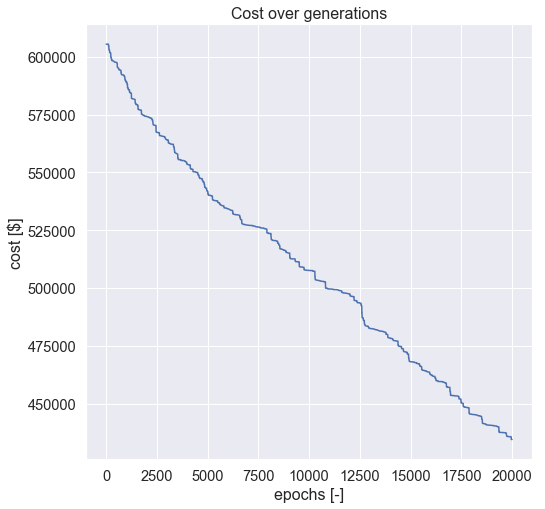

In [440]:
nb_seeds = 10 # number of seed sources : keep them along epochs
NB_MAX_EPOCHS = 20000
R_POP_LOST = 0.01# default 0.01
R_POP_MUT = 0.10
DELTA_CHOICE = 1
# LOOP OVER GENERATIONS 
list_best_cost = []
t_fit_0 = time.time()
for gen_id in range(0, NB_MAX_EPOCHS):
    t_epoch_0 = time.time()
    print(" ")
    print("GENERATION #{} / nb. pop: {}".format(gen_id, df_pop.shape[0]))
    
    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    #list_best_indiv = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
        #list_best_indiv.append(df_pop.loc[list_name_best[indice]])
    df_best = df_pop.loc[list_name_best]

    ############
    # LOST WORST INDIV.
    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)
    if (nb_survivor + 2 * nb_seeds) % 2 != 0:
        nb_survivor += 1
    print("nb_survivor: ", nb_survivor + 2 * nb_seeds)
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))

    df_pop = df_pop.loc[vect_survivor] 

    ############
    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 

    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace 2 parents by 2 children
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)

    ############
    # MUTATION
    # among pop, number of mutation = R_POP_MUT * number of indiv
    # df_pop = f(indiv, family)
    # nb of indiv. mutated :
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    # indice of mutated indiv.
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    # number of family who mutate  for each mutated indiv. : R_MUT * nb families
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    # loop over indice of mutated indiv to apply mutation to number of family
    # who mutated :
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                mutation_day(df_pop.loc[indice, fam_id], fam_id, nb_mut=1, 
                                        flag_prob=True)
                #np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))
            

    # add the best ones
    df_pop = df_pop.append(df_best, ignore_index=True)

    ############
    # EVALUATION
    # create cost dataFrame for all population
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 
    
    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

    print(df_cost.sort_values(by="cost").head(1))
    t_epoch_1 = time.time()
    print("Timing epoch: ", t_epoch_1 - t_epoch_0)
    
# timing    
t_fit_1 = time.time()
print("Timing total: ", t_fit_1 - t_fit_0)
# figure
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

#### Save results

In [441]:
# POP
joblib.dump(df_pop,
    PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)
# COST
joblib.dump(df_cost,
    PATH_TO_SAVE_DATA + \
            '/df_cost_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)

# submission
submission_final = pd.DataFrame(columns=["assigned_day"])
submission_final["assigned_day"] = \
    df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name]

joblib.dump(submission_final,
    PATH_TO_SAVE_DATA + \
            '/submission_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)



joblib.dump(list_best_cost,
    PATH_TO_SAVE_DATA + \
            '/list_best_cost{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)

['../../data/list_best_cost1000_fs10_rfm0.01_dc1_rm0.1_gen20000_s434530.pkl']

In [ ]:
nb_seeds = 10 # number of seed sources : keep them along epochs
NB_MAX_EPOCHS = 30000
R_POP_LOST = 0.01# default 0.01
R_POP_MUT = 0.10
DELTA_CHOICE = 1
# LOOP OVER GENERATIONS 
list_best_cost = []
t_fit_0 = time.time()
for gen_id in range(0, NB_MAX_EPOCHS):
    t_epoch_0 = time.time()
    print(" ")
    print("GENERATION #{} / nb. pop: {}".format(gen_id, df_pop.shape[0]))
    
    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    #list_best_indiv = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
        #list_best_indiv.append(df_pop.loc[list_name_best[indice]])
    df_best = df_pop.loc[list_name_best]

    ############
    # LOST WORST INDIV.
    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)
    if (nb_survivor + 2 * nb_seeds) % 2 != 0:
        nb_survivor += 1
    print("nb_survivor: ", nb_survivor + 2 * nb_seeds)
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))

    df_pop = df_pop.loc[vect_survivor] 

    ############
    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 

    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace 2 parents by 2 children
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)

    ############
    # MUTATION
    # among pop, number of mutation = R_POP_MUT * number of indiv
    # df_pop = f(indiv, family)
    # nb of indiv. mutated :
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    # indice of mutated indiv.
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    # number of family who mutate  for each mutated indiv. : R_MUT * nb families
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    # loop over indice of mutated indiv to apply mutation to number of family
    # who mutated :
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                mutation_day(df_pop.loc[indice, fam_id], fam_id, nb_mut=1, 
                                        flag_prob=True)
                #np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))
            

    # add the best ones
    df_pop = df_pop.append(df_best, ignore_index=True)

    ############
    # EVALUATION
    # create cost dataFrame for all population
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 
    
    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

    print(df_cost.sort_values(by="cost").head(1))
    t_epoch_1 = time.time()
    print("Timing epoch: ", t_epoch_1 - t_epoch_0)
    
# timing    
t_fit_1 = time.time()
print("Timing total: ", t_fit_1 - t_fit_0)
# figure
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

#### Save results

In [74]:
# POP
joblib.dump(df_pop,
    PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)
# COST
joblib.dump(df_cost,
    PATH_TO_SAVE_DATA + \
            '/df_cost_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)

# submission
submission_final = pd.DataFrame(columns=["assigned_day"])
submission_final["assigned_day"] = \
    df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name]

joblib.dump(submission_final,
    PATH_TO_SAVE_DATA + \
            '/submission_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)



joblib.dump(list_best_cost,
    PATH_TO_SAVE_DATA + \
            '/list_best_cost{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0])),
           compress=True)

['../../data/list_best_cost1000_fs10_rfm0.01_dd5_rm0.1_gen30000.pkl']

## Run with pop by days

### Evaluation #1

In [60]:
DELTA_DAYS = 3
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000

In [61]:
# load 
df_pop = joblib.load(PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dd{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_DAYS))

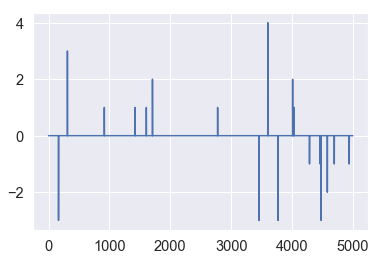

In [62]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [63]:
# create cost dataFrame for all population
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

cost
800  605419.833709
400  654844.718387
900  656228.754657
600  657505.942610
469  665206.371332
0    672254.027668
700  677348.768396
300  679410.167648
635  679441.505966
479  681538.723476

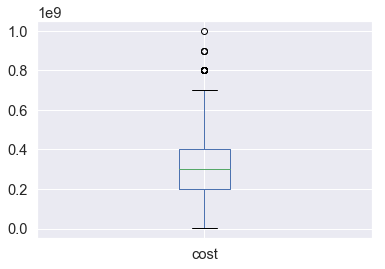

In [64]:
df_cost.boxplot()

###  Loop over generations

In [428]:
nb_seeds = 10 # number of seed sources : keep them along epochs
NB_MAX_EPOCHS = 20000
R_POP_LOST = 0.01# default 0.01
R_POP_MUT = 0.10
DELTA_DAYS = 5
# LOOP OVER GENERATIONS 
list_best_cost = []
t_fit_0 = time.time()
for gen_id in range(0, NB_MAX_EPOCHS):
    t_epoch_0 = time.time()
    print(" ")
    print("GENERATION #{} / nb. pop: {}".format(gen_id, df_pop.shape[0]))
    
    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    #list_best_indiv = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
        #list_best_indiv.append(df_pop.loc[list_name_best[indice]])
    df_best = df_pop.loc[list_name_best]

    ############
    # LOST WORST INDIV.
    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)
    if (nb_survivor + 2 * nb_seeds) % 2 != 0:
        nb_survivor += 1
    print("nb_survivor: ", nb_survivor + 2 * nb_seeds)
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))

    df_pop = df_pop.loc[vect_survivor] 

    ############
    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 

    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace 2 parents by 2 children
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)

    ############
    # MUTATION
    # among pop, number of mutation = R_POP_MUT * number of indiv
    # df_pop = f(indiv, family)
    # nb of indiv. mutated :
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    # indice of mutated indiv.
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    # number of family who mutate  for each mutated indiv. : R_MUT * nb families
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    # loop over indice of mutated indiv to apply mutation to number of family
    # who mutated :
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))

    # add the best ones
    df_pop = df_pop.append(df_best, ignore_index=True)

    ############
    # EVALUATION
    # create cost dataFrame for all population
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 
    
    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

    print(df_cost.sort_values(by="cost").head(1))
    t_epoch_1 = time.time()
    print("Timing epoch: ", t_epoch_1 - t_epoch_0)
    
# timing    
t_fit_1 = time.time()
print("Timing total: ", t_fit_1 - t_fit_0)
# figure
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

NameError: name 'cvpopo' is not defined

In [161]:
int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)

-2

In [ ]:
R_POP_LOST*df_cost_sort.shape[0]

#### Save results

In [74]:
# best score
#best_score = \
#cost_function(df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name].tolist())

# POP
joblib.dump(df_pop,
    PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)
# COST
joblib.dump(df_cost,
    PATH_TO_SAVE_DATA + '/df_cost_pop{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)

# submission
submission_final = pd.DataFrame(columns=["assigned_day"])
submission_final["assigned_day"] = \
    df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name]

joblib.dump(submission_final,
    PATH_TO_SAVE_DATA + \
            '/submission_pop{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)



joblib.dump(list_best_cost,
    PATH_TO_SAVE_DATA + \
            '/list_best_cost{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)

['../../data/list_best_cost1000_fs10_rfm0.01_dd5_rm0.1_gen30000.pkl']

In [124]:

#df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name,:].to_csv("test.csv")

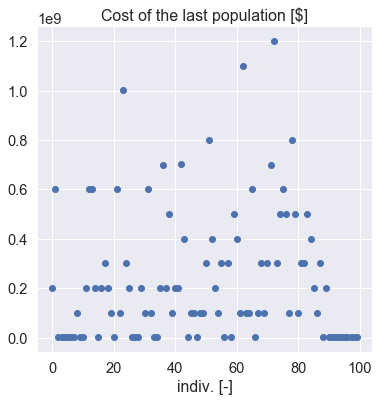

In [67]:
fig = plt.figure(figsize=(6, 6))
plt.title("Cost of the last population [$]")
plt.plot(df_cost["cost"], 'o')
ax = plt.gca()
ax.set_xlabel("indiv. [-]");
#ax.set_ylim([0 , 1e6])

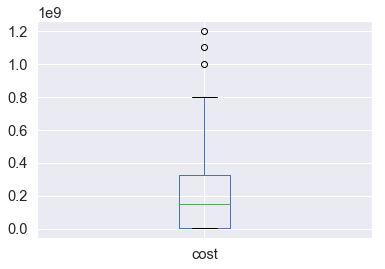

In [68]:
df_cost.boxplot()

In [72]:
cost_function(df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name].tolist())

585102.5859791327

In [59]:
np.ceil(R_POP_LOST*df_cost_sort.shape[0])

10.0

In [60]:
nb_seeds

10

## Explore more

In [34]:
submission = pd.read_csv('submission_672254.0276683343.csv')
submission.head()

family_id  assigned_day
0          0            52
1          1            26
2          2           100
3          3             2
4          4            53

In [40]:
cost_function(submission['assigned_day'].tolist(), True)

penalty for only families:  666488
daily_occupancy:  {100: 127, 99: 127, 98: 128, 97: 127, 96: 168, 95: 201, 94: 212, 93: 126, 92: 135, 91: 126, 90: 143, 89: 189, 88: 226, 87: 219, 86: 126, 85: 125, 84: 127, 83: 131, 82: 161, 81: 185, 80: 203, 79: 126, 78: 139, 77: 126, 76: 126, 75: 170, 74: 196, 73: 206, 72: 126, 71: 126, 70: 128, 69: 127, 68: 169, 67: 210, 66: 238, 65: 125, 64: 129, 63: 126, 62: 139, 61: 179, 60: 208, 59: 235, 58: 207, 57: 154, 56: 154, 55: 179, 54: 214, 53: 228, 52: 244, 51: 202, 50: 151, 49: 195, 48: 214, 47: 249, 46: 269, 45: 257, 44: 220, 43: 186, 42: 205, 41: 232, 40: 241, 39: 265, 38: 231, 37: 194, 36: 160, 35: 183, 34: 215, 33: 251, 32: 277, 31: 269, 30: 242, 29: 254, 28: 272, 27: 284, 26: 293, 25: 295, 24: 280, 23: 265, 22: 254, 21: 256, 20: 264, 19: 288, 18: 294, 17: 283, 16: 273, 15: 267, 14: 270, 13: 284, 12: 298, 11: 291, 10: 280, 9: 260, 8: 261, 7: 259, 6: 281, 5: 296, 4: 291, 3: 291, 2: 271, 1: 294}
accounting_cost:  5766.027668334263


672254.0276683343

In [36]:
# function submission -> choice number
list_choice=[]
for fam_id in submission["family_id"]:
    assigned_day = submission.at[fam_id, "assigned_day"]
    list_choice.append(np.argmax((data.filter(items=['choice_{}'.\
                                 format(n) for n in range(0, 10)]).\
        loc[fam_id] == assigned_day).tolist()))

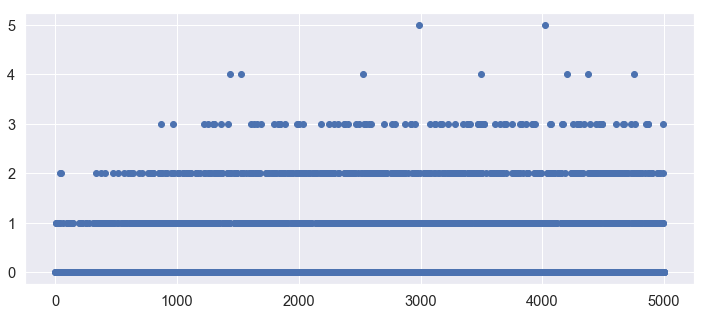

In [37]:
fig = plt.figure(figsize=(12, 5))
plt.plot(submission["family_id"], list_choice, 'o')

In [38]:
submission["choice"] = list_choice

In [39]:
submission["choice"].value_counts()

0    3535
1     946
2     416
3      94
4       7
5       2
Name: choice, dtype: int64